In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  

    
    term3 = np.sin(12*x)*np.exp(x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_Stan"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(beta_init*torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init = 1


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 100
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers,beta_init)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3626.0696 Test MSE 3495.13050965358 Test RE 0.9982366444785867
1 Train Loss 3604.505 Test MSE 3486.525618113898 Test RE 0.997007075017744
2 Train Loss 3582.8774 Test MSE 3484.2138444777147 Test RE 0.996676482744199
3 Train Loss 3564.2424 Test MSE 3494.5591834234333 Test RE 0.9981550535214267
4 Train Loss 3552.8506 Test MSE 3518.3102489199414 Test RE 1.0015413318827358
5 Train Loss 3551.6943 Test MSE 3527.3592727817754 Test RE 1.0028284769618454
6 Train Loss 3546.6711 Test MSE 3510.8730891316322 Test RE 1.0004822207092543
7 Train Loss 3532.9849 Test MSE 3488.7019435864518 Test RE 0

101 Train Loss 1134.0653 Test MSE 1451.061868163162 Test RE 0.6431981323392182
102 Train Loss 1132.4553 Test MSE 1456.4417011308885 Test RE 0.6443893624473197
103 Train Loss 1127.8391 Test MSE 1436.595367762481 Test RE 0.6399838883734031
104 Train Loss 1120.979 Test MSE 1429.4722033208834 Test RE 0.6383952797886989
105 Train Loss 1122.5359 Test MSE 1436.367778659954 Test RE 0.6399331924254673
106 Train Loss 1122.584 Test MSE 1443.1774034549571 Test RE 0.6414483170278371
107 Train Loss 1124.1659 Test MSE 1427.1913457000387 Test RE 0.637885766546264
108 Train Loss 1119.7195 Test MSE 1415.9976405965642 Test RE 0.6353793188246141
109 Train Loss 1116.6028 Test MSE 1423.0400877282764 Test RE 0.6369573848121833
110 Train Loss 1113.9286 Test MSE 1420.4377015952655 Test RE 0.6363747000332372
111 Train Loss 1114.2661 Test MSE 1409.723101008752 Test RE 0.6339700159956906
112 Train Loss 1115.2059 Test MSE 1409.6088569990839 Test RE 0.6339443269990281
113 Train Loss 1114.1776 Test MSE 1413.11920063

212 Train Loss 997.59344 Test MSE 1222.548590829257 Test RE 0.5903844015830485
213 Train Loss 1005.59717 Test MSE 1298.765204446964 Test RE 0.6085091770173817
214 Train Loss 1056.2924 Test MSE 1290.5448771612987 Test RE 0.6065803892767131
215 Train Loss 1079.2969 Test MSE 1471.5653415305717 Test RE 0.6477263804092467
216 Train Loss 1223.5607 Test MSE 1622.4349800485084 Test RE 0.6801198658519851
217 Train Loss 1400.7222 Test MSE 1502.646543376898 Test RE 0.654531011609943
218 Train Loss 1264.6539 Test MSE 1245.6005176603396 Test RE 0.5959244439185685
219 Train Loss 1050.0712 Test MSE 1179.7421027119751 Test RE 0.5799564052186401
220 Train Loss 970.71985 Test MSE 1232.8681253145403 Test RE 0.5928708833190091
221 Train Loss 1026.0652 Test MSE 1261.8596196833798 Test RE 0.5998012013856214
222 Train Loss 1070.6869 Test MSE 1279.4982101608966 Test RE 0.6039787392483226
223 Train Loss 1051.7544 Test MSE 1166.039630579969 Test RE 0.5765785285263658
224 Train Loss 956.33984 Test MSE 1182.28284

319 Train Loss 945.4348 Test MSE 1086.90325281378 Test RE 0.5566692785175902
320 Train Loss 886.58325 Test MSE 1046.822494733088 Test RE 0.5463089721545467
321 Train Loss 897.6697 Test MSE 1094.6879263105718 Test RE 0.5586592241951356
322 Train Loss 873.15625 Test MSE 1052.0451330861272 Test RE 0.5476700550530618
323 Train Loss 840.4378 Test MSE 1030.105426532629 Test RE 0.5419293188696822
324 Train Loss 881.65155 Test MSE 1043.1293726177023 Test RE 0.5453444493338333
325 Train Loss 840.3991 Test MSE 1025.090503761008 Test RE 0.5406085562498849
326 Train Loss 832.4582 Test MSE 1000.2585897568697 Test RE 0.5340205314771683
327 Train Loss 859.9987 Test MSE 1024.7434039310629 Test RE 0.5405170223685861
328 Train Loss 833.1145 Test MSE 1017.0899007144585 Test RE 0.53849475906027
329 Train Loss 834.1739 Test MSE 976.594871586964 Test RE 0.5276659004806081
330 Train Loss 837.954 Test MSE 994.1163504044285 Test RE 0.5323783896664729
331 Train Loss 827.9001 Test MSE 1008.1417157921231 Test RE 

434 Train Loss 742.82263 Test MSE 865.1546680613269 Test RE 0.49664799619073313
435 Train Loss 739.0031 Test MSE 866.3548293841329 Test RE 0.4969923572427403
436 Train Loss 734.85474 Test MSE 849.1134035077504 Test RE 0.4920221541500021
437 Train Loss 731.6835 Test MSE 855.4374643012982 Test RE 0.4938510063640209
438 Train Loss 726.6572 Test MSE 854.6405477434328 Test RE 0.4936209195593907
439 Train Loss 729.0622 Test MSE 855.3885939704137 Test RE 0.49383689954277254
440 Train Loss 725.7825 Test MSE 847.6466656608375 Test RE 0.49159701692497676
441 Train Loss 726.9797 Test MSE 851.147263025573 Test RE 0.492611065721505
442 Train Loss 723.38824 Test MSE 848.1914168571042 Test RE 0.49175495717398476
443 Train Loss 720.4354 Test MSE 836.2290416274896 Test RE 0.4882749373551857
444 Train Loss 720.75867 Test MSE 847.7529500040087 Test RE 0.4916278360329981
445 Train Loss 718.81696 Test MSE 836.2588186960294 Test RE 0.4882836307071994
446 Train Loss 722.1032 Test MSE 857.0387322443419 Test R

542 Train Loss 1120.0107 Test MSE 1263.2391451170283 Test RE 0.6001289775397709
543 Train Loss 958.40546 Test MSE 1229.9598378601167 Test RE 0.5921711908820261
544 Train Loss 959.6645 Test MSE 1272.2148435151335 Test RE 0.6022572531910299
545 Train Loss 1078.5948 Test MSE 872.1849821458094 Test RE 0.49866181347106897
546 Train Loss 737.7917 Test MSE 1224.828443187897 Test RE 0.5909346301599449
547 Train Loss 978.6005 Test MSE 947.7453151891403 Test RE 0.5198135942296449
548 Train Loss 783.6595 Test MSE 1147.3769337059312 Test RE 0.5719457895983592
549 Train Loss 995.4535 Test MSE 902.9805496481919 Test RE 0.5073889533122921
550 Train Loss 777.34576 Test MSE 1038.6548425856756 Test RE 0.544173557884417
551 Train Loss 858.9521 Test MSE 909.3973126894799 Test RE 0.5091885663054017
552 Train Loss 787.1913 Test MSE 851.0785512904906 Test RE 0.49259118147487024
553 Train Loss 710.12445 Test MSE 1027.8730155069525 Test RE 0.5413417745604764
554 Train Loss 842.6126 Test MSE 807.9503654277165 T

649 Train Loss 604.6192 Test MSE 679.7050929061335 Test RE 0.44021219746460966
650 Train Loss 604.69226 Test MSE 687.2618863780814 Test RE 0.4426525187737794
651 Train Loss 605.2654 Test MSE 677.6166200777672 Test RE 0.43953537561313033
652 Train Loss 607.25586 Test MSE 701.3565222381827 Test RE 0.4471685278509864
653 Train Loss 613.1615 Test MSE 686.5234206431625 Test RE 0.4424146388762073
654 Train Loss 629.44434 Test MSE 776.5807453543379 Test RE 0.4705384516478893
655 Train Loss 673.2367 Test MSE 803.9944391886672 Test RE 0.478771546576717
656 Train Loss 784.5279 Test MSE 1143.0298014077046 Test RE 0.5708612796030348
657 Train Loss 1015.7531 Test MSE 1248.792990578677 Test RE 0.5966876321046692
658 Train Loss 1294.1746 Test MSE 1336.1855626602148 Test RE 0.6172131883872918
659 Train Loss 1211.5922 Test MSE 824.6740467901845 Test RE 0.48488971617812826
660 Train Loss 778.3065 Test MSE 765.9172597717068 Test RE 0.46729672577583986
661 Train Loss 717.55176 Test MSE 1041.1444816802739 

755 Train Loss 582.4911 Test MSE 649.7215426679705 Test RE 0.4303932418178522
756 Train Loss 582.18835 Test MSE 649.8190999668275 Test RE 0.43042555291062684
757 Train Loss 581.9078 Test MSE 648.5518333784433 Test RE 0.4300056436463748
758 Train Loss 581.629 Test MSE 649.4695213406499 Test RE 0.43030976082679356
759 Train Loss 581.3723 Test MSE 646.4721706501518 Test RE 0.42931565657805737
760 Train Loss 581.2272 Test MSE 649.7434852667533 Test RE 0.4304005094439575
761 Train Loss 581.1761 Test MSE 645.1990824237967 Test RE 0.42889272572393755
762 Train Loss 581.4923 Test MSE 651.1765536199188 Test RE 0.4308748917496935
763 Train Loss 582.06665 Test MSE 646.4504681833554 Test RE 0.4293084503227826
764 Train Loss 584.33673 Test MSE 657.2214604342918 Test RE 0.43287018917905096
765 Train Loss 585.97 Test MSE 653.8350952692563 Test RE 0.4317535567177418
766 Train Loss 592.88306 Test MSE 665.8854901027141 Test RE 0.43571407132820567
767 Train Loss 591.8808 Test MSE 660.0313040784907 Test R

863 Train Loss 949.08936 Test MSE 967.7245447274842 Test RE 0.5252640622204013
864 Train Loss 832.1917 Test MSE 951.7453583595254 Test RE 0.5209093989035433
865 Train Loss 806.8912 Test MSE 803.9601649782902 Test RE 0.47876134147404587
866 Train Loss 793.3888 Test MSE 725.8426305339316 Test RE 0.4549074462909555
867 Train Loss 709.6148 Test MSE 921.5020039045169 Test RE 0.5125661853826562
868 Train Loss 810.0907 Test MSE 787.2446030328767 Test RE 0.47375810824055864
869 Train Loss 732.69446 Test MSE 755.3024656145184 Test RE 0.46404731169622393
870 Train Loss 750.8918 Test MSE 684.0106077064822 Test RE 0.4416042336327098
871 Train Loss 634.8893 Test MSE 770.6956454853679 Test RE 0.46875213895128065
872 Train Loss 676.86884 Test MSE 662.9780940468879 Test RE 0.4347618211366568
873 Train Loss 614.64075 Test MSE 741.4131561132481 Test RE 0.4597608149644086
874 Train Loss 706.35895 Test MSE 691.896350649313 Test RE 0.4441424969750261
875 Train Loss 632.3455 Test MSE 728.4022962430374 Test 

970 Train Loss 927.4312 Test MSE 714.2032608220935 Test RE 0.4512453340098883
971 Train Loss 680.3848 Test MSE 611.2182681123099 Test RE 0.4174456817322616
972 Train Loss 588.2638 Test MSE 750.8570925612613 Test RE 0.46267970881707104
973 Train Loss 737.2003 Test MSE 780.29198754387 Test RE 0.4716614519184565
974 Train Loss 747.6882 Test MSE 788.3152390747517 Test RE 0.4740801492987323
975 Train Loss 724.58466 Test MSE 655.5770576826566 Test RE 0.4323283179991459
976 Train Loss 634.0747 Test MSE 604.5669193574605 Test RE 0.415168122224241
977 Train Loss 594.29 Test MSE 595.6217156002631 Test RE 0.4120852515235422
978 Train Loss 580.39703 Test MSE 578.517796932729 Test RE 0.4061254183415773
979 Train Loss 572.0544 Test MSE 616.6306622328391 Test RE 0.4192898681211319
980 Train Loss 615.9492 Test MSE 580.4441762206211 Test RE 0.40680102538550167
981 Train Loss 590.513 Test MSE 607.1421715614223 Test RE 0.41605142102673953
982 Train Loss 595.75696 Test MSE 535.5589412755584 Test RE 0.3907

1078 Train Loss 528.73236 Test MSE 509.9857374056333 Test RE 0.3813123092831324
1079 Train Loss 540.05035 Test MSE 487.6206952652355 Test RE 0.37285749247675515
1080 Train Loss 517.97437 Test MSE 534.8095307313345 Test RE 0.39048232357266716
1081 Train Loss 553.0195 Test MSE 510.3641215273816 Test RE 0.38145374046442243
1082 Train Loss 537.80383 Test MSE 494.8146975871187 Test RE 0.37559785674908336
1083 Train Loss 518.4038 Test MSE 515.9075043450513 Test RE 0.3835197489758832
1084 Train Loss 527.6545 Test MSE 516.8869460366706 Test RE 0.38388362923861563
1085 Train Loss 535.37085 Test MSE 546.4836251111186 Test RE 0.39472114004288095
1086 Train Loss 553.5066 Test MSE 476.45086326559914 Test RE 0.36856226562958444
1087 Train Loss 503.09 Test MSE 528.174064849321 Test RE 0.38805237508717866
1088 Train Loss 545.2218 Test MSE 604.608097232077 Test RE 0.41518226081605003
1089 Train Loss 590.8557 Test MSE 516.0492609326864 Test RE 0.3835724354714034
1090 Train Loss 545.05176 Test MSE 489.25

1181 Train Loss 644.24963 Test MSE 598.7850642295714 Test RE 0.41317809539353745
1182 Train Loss 592.9528 Test MSE 510.5558464921273 Test RE 0.3815253827828108
1183 Train Loss 514.3769 Test MSE 600.2995789648897 Test RE 0.41370029372674477
1184 Train Loss 627.8943 Test MSE 544.7147769887082 Test RE 0.3940818092256497
1185 Train Loss 527.70166 Test MSE 523.1811335561821 Test RE 0.386213852824796
1186 Train Loss 515.0496 Test MSE 570.7209382014872 Test RE 0.4033793973773927
1187 Train Loss 619.41345 Test MSE 561.3223099290867 Test RE 0.4000441848165448
1188 Train Loss 540.47375 Test MSE 489.82118284423416 Test RE 0.3736978431212884
1189 Train Loss 515.3187 Test MSE 578.8448501032244 Test RE 0.40624019945918444
1190 Train Loss 577.16565 Test MSE 533.7461037032139 Test RE 0.3900939085750953
1191 Train Loss 520.8257 Test MSE 456.6301765434967 Test RE 0.36081460967503043
1192 Train Loss 472.17758 Test MSE 531.2435832923553 Test RE 0.38917833755250836
1193 Train Loss 531.4468 Test MSE 477.232

1291 Train Loss 387.95358 Test MSE 353.13416356760496 Test RE 0.31730117280033715
1292 Train Loss 390.27936 Test MSE 352.1709849212439 Test RE 0.3168681555160441
1293 Train Loss 398.2472 Test MSE 361.7849433700553 Test RE 0.321164144856621
1294 Train Loss 399.74072 Test MSE 363.6624961333218 Test RE 0.32199643806363737
1295 Train Loss 409.762 Test MSE 367.6058456761314 Test RE 0.3237375042442145
1296 Train Loss 405.4605 Test MSE 359.9387300996977 Test RE 0.3203436354580001
1297 Train Loss 408.22296 Test MSE 362.02396059591683 Test RE 0.32127021766290476
1298 Train Loss 398.53128 Test MSE 340.6526446703277 Test RE 0.3116432267238841
1299 Train Loss 392.49017 Test MSE 346.1733228144914 Test RE 0.31415835068521614
1300 Train Loss 384.07147 Test MSE 326.6116250903896 Test RE 0.305152989606937
1301 Train Loss 377.18793 Test MSE 330.4515226909884 Test RE 0.3069415547154216
1302 Train Loss 371.2557 Test MSE 320.753326236755 Test RE 0.3024039044727699
1303 Train Loss 367.11975 Test MSE 321.083

1399 Train Loss 339.6423 Test MSE 304.4795931970713 Test RE 0.29463267258071885
1400 Train Loss 340.01178 Test MSE 303.4786246563077 Test RE 0.29414797536954423
1401 Train Loss 338.60144 Test MSE 303.0075526864131 Test RE 0.29391959243212007
1402 Train Loss 338.7425 Test MSE 301.9232497495595 Test RE 0.2933932301380311
1403 Train Loss 337.62592 Test MSE 300.99183413288875 Test RE 0.2929403300738279
1404 Train Loss 337.637 Test MSE 300.3527400906916 Test RE 0.2926291656452114
1405 Train Loss 336.60422 Test MSE 299.700218351016 Test RE 0.2923111217447497
1406 Train Loss 336.3971 Test MSE 299.16996750299813 Test RE 0.2920524184975243
1407 Train Loss 335.8443 Test MSE 298.0628335882256 Test RE 0.29151152055768487
1408 Train Loss 335.1389 Test MSE 298.3134901057366 Test RE 0.29163406838795164
1409 Train Loss 334.87772 Test MSE 297.093246025406 Test RE 0.29103699615084155
1410 Train Loss 334.16437 Test MSE 296.854936521469 Test RE 0.2909202469532065
1411 Train Loss 333.9712 Test MSE 295.8015

1503 Train Loss 514.4133 Test MSE 513.3097904162839 Test RE 0.38255297501811225
1504 Train Loss 526.2857 Test MSE 690.0798599402534 Test RE 0.44355909243676284
1505 Train Loss 762.4777 Test MSE 701.400506682083 Test RE 0.4471825493579121
1506 Train Loss 733.0671 Test MSE 347.3514841979578 Test RE 0.3146924976346093
1507 Train Loss 381.02795 Test MSE 421.65279325367385 Test RE 0.34672032471234326
1508 Train Loss 479.03912 Test MSE 609.2163205091464 Test RE 0.41676148277046865
1509 Train Loss 655.94714 Test MSE 426.96276491149666 Test RE 0.3488966592075022
1510 Train Loss 477.0332 Test MSE 309.060230506497 Test RE 0.29684064866768284
1511 Train Loss 358.70566 Test MSE 493.78177050290145 Test RE 0.37520562114844314
1512 Train Loss 538.5016 Test MSE 388.6012721471776 Test RE 0.3328541061564518
1513 Train Loss 446.83426 Test MSE 312.93068898444665 Test RE 0.2986935799127594
1514 Train Loss 369.19867 Test MSE 453.733252057562 Test RE 0.3596682599398985
1515 Train Loss 472.54645 Test MSE 483.

1613 Train Loss 300.89542 Test MSE 256.7800288058612 Test RE 0.27057173810701685
1614 Train Loss 301.1907 Test MSE 257.3028386050034 Test RE 0.2708470430581876
1615 Train Loss 301.59534 Test MSE 257.72817902992944 Test RE 0.27107081561138463
1616 Train Loss 301.8402 Test MSE 257.24976628773913 Test RE 0.27081910861799996
1617 Train Loss 301.69836 Test MSE 257.11400960151525 Test RE 0.27074764041597577
1618 Train Loss 301.28876 Test MSE 256.4860547749484 Test RE 0.2704168120336867
1619 Train Loss 300.78754 Test MSE 255.88060861867808 Test RE 0.27009745831201704
1620 Train Loss 300.35645 Test MSE 255.7083684914625 Test RE 0.2700065380734607
1621 Train Loss 300.05896 Test MSE 255.50128552569225 Test RE 0.2698971848287821
1622 Train Loss 299.94315 Test MSE 255.40687250244537 Test RE 0.2698473139179913
1623 Train Loss 299.96072 Test MSE 255.58763943054674 Test RE 0.26994279067928884
1624 Train Loss 300.03787 Test MSE 255.61799446345825 Test RE 0.2699588201692769
1625 Train Loss 300.1322 Tes

1720 Train Loss 305.64072 Test MSE 270.32235377576933 Test RE 0.27761491175679953
1721 Train Loss 304.76172 Test MSE 266.428261186383 Test RE 0.27560808599455366
1722 Train Loss 303.21555 Test MSE 273.20979976599705 Test RE 0.27909364417256344
1723 Train Loss 305.8674 Test MSE 270.1341596499117 Test RE 0.27751825938750635
1724 Train Loss 303.06696 Test MSE 267.9102928459042 Test RE 0.2763735705900775
1725 Train Loss 302.13107 Test MSE 268.2777425222434 Test RE 0.2765630343481002
1726 Train Loss 303.28314 Test MSE 268.3093118934004 Test RE 0.27657930603758446
1727 Train Loss 303.13947 Test MSE 268.5766309954026 Test RE 0.2767170510246128
1728 Train Loss 301.52914 Test MSE 266.3861193955906 Test RE 0.2755862882363777
1729 Train Loss 301.66013 Test MSE 265.3891658765356 Test RE 0.27507011219944105
1730 Train Loss 301.0938 Test MSE 269.8596221742935 Test RE 0.27737720256951204
1731 Train Loss 302.14996 Test MSE 266.05659773243417 Test RE 0.2754157843202787
1732 Train Loss 301.0732 Test MSE

1824 Train Loss 293.91672 Test MSE 261.7263078356532 Test RE 0.2731652803760371
1825 Train Loss 293.87326 Test MSE 261.7841813337112 Test RE 0.27319548016110795
1826 Train Loss 293.83 Test MSE 261.734229556081 Test RE 0.27316941431775993
1827 Train Loss 293.78632 Test MSE 261.7619003319031 Test RE 0.27318385379300053
1828 Train Loss 293.7433 Test MSE 261.7240497555157 Test RE 0.27316410198776303
1829 Train Loss 293.70004 Test MSE 261.7839418857004 Test RE 0.2731953552182467
1830 Train Loss 293.65714 Test MSE 261.7161181298407 Test RE 0.2731599627964617
1831 Train Loss 293.6144 Test MSE 261.7812161488859 Test RE 0.2731939329373951
1832 Train Loss 293.57135 Test MSE 261.7090351949444 Test RE 0.27315626644918056
1833 Train Loss 293.52887 Test MSE 261.79205917136073 Test RE 0.27319959074838096
1834 Train Loss 293.4862 Test MSE 261.695335658383 Test RE 0.2731491169764288
1835 Train Loss 293.4441 Test MSE 261.80310146120837 Test RE 0.27320535241522875
1836 Train Loss 293.40213 Test MSE 261.6

1937 Train Loss 308.1891 Test MSE 290.18916617498513 Test RE 0.28763544799835644
1938 Train Loss 319.1129 Test MSE 299.73570265422956 Test RE 0.292328425952149
1939 Train Loss 322.56696 Test MSE 306.7194353158169 Test RE 0.2957143894946543
1940 Train Loss 334.3294 Test MSE 309.6207284000982 Test RE 0.29710969524183506
1941 Train Loss 332.2758 Test MSE 306.6324365572625 Test RE 0.2956724478920473
1942 Train Loss 334.56055 Test MSE 297.10485279414854 Test RE 0.2910426811776184
1943 Train Loss 320.96475 Test MSE 277.4595298154269 Test RE 0.28125589436718107
1944 Train Loss 308.1273 Test MSE 267.4324450696857 Test RE 0.27612698910339856
1945 Train Loss 295.03403 Test MSE 262.99398710482 Test RE 0.27382602339922035
1946 Train Loss 289.9489 Test MSE 263.51916644213804 Test RE 0.2740992920951003
1947 Train Loss 293.36197 Test MSE 273.9311528086524 Test RE 0.2794618453417898
1948 Train Loss 301.19687 Test MSE 277.15655754690005 Test RE 0.2811022935678926
1949 Train Loss 307.63168 Test MSE 281.

2048 Train Loss 296.8864 Test MSE 292.18075858033893 Test RE 0.28862079327496415
2049 Train Loss 292.42517 Test MSE 291.0549654042162 Test RE 0.28806421843824004
2050 Train Loss 290.7421 Test MSE 289.5908042934118 Test RE 0.28733874687876
2051 Train Loss 291.70505 Test MSE 296.2859198103888 Test RE 0.29064129271561057
2052 Train Loss 290.99707 Test MSE 288.00009562094544 Test RE 0.2865484910614037
2053 Train Loss 287.18814 Test MSE 288.61170840746945 Test RE 0.28685259473398805
2054 Train Loss 289.56586 Test MSE 293.8566202577405 Test RE 0.2894473311650404
2055 Train Loss 287.7246 Test MSE 290.4155169543299 Test RE 0.28774760555695617
2056 Train Loss 287.46664 Test MSE 285.17369706874274 Test RE 0.28513894792354405
2057 Train Loss 284.52463 Test MSE 289.3944612334542 Test RE 0.2872413222818574
2058 Train Loss 287.0996 Test MSE 283.03988265236376 Test RE 0.28407016767761273
2059 Train Loss 284.25967 Test MSE 289.1050486612731 Test RE 0.28709765670499005
2060 Train Loss 285.1301 Test MSE

2157 Train Loss 260.59918 Test MSE 258.0407654624838 Test RE 0.27123515034365886
2158 Train Loss 260.37177 Test MSE 257.8075204803449 Test RE 0.27111253688682097
2159 Train Loss 260.1437 Test MSE 257.6302133207437 Test RE 0.27101929200848657
2160 Train Loss 259.9145 Test MSE 257.42168161909035 Test RE 0.2709095852423435
2161 Train Loss 259.68393 Test MSE 257.24003121309306 Test RE 0.2708139842806309
2162 Train Loss 259.4522 Test MSE 257.03797449067105 Test RE 0.2707076039957879
2163 Train Loss 259.21924 Test MSE 256.8195905649507 Test RE 0.2705925806189945
2164 Train Loss 258.98523 Test MSE 256.6365532025601 Test RE 0.2704961366909353
2165 Train Loss 258.7497 Test MSE 256.42934645260107 Test RE 0.27038691619495064
2166 Train Loss 258.51328 Test MSE 256.2544206230047 Test RE 0.270294676899457
2167 Train Loss 258.27542 Test MSE 256.03424618823686 Test RE 0.2701785330173987
2168 Train Loss 258.03632 Test MSE 255.8381522097044 Test RE 0.27007504972871627
2169 Train Loss 257.79605 Test MSE 

2262 Train Loss 716.16187 Test MSE 678.162475074531 Test RE 0.43971237413699016
2263 Train Loss 609.91376 Test MSE 373.93352556987645 Test RE 0.3265118983854921
2264 Train Loss 350.65112 Test MSE 595.8069758720782 Test RE 0.41214933337974335
2265 Train Loss 591.28375 Test MSE 477.15118356250883 Test RE 0.3688330352695055
2266 Train Loss 410.8261 Test MSE 565.789560439837 Test RE 0.4016328941982454
2267 Train Loss 535.8129 Test MSE 424.2259204128354 Test RE 0.34777664231025585
2268 Train Loss 401.85602 Test MSE 366.52311800266045 Test RE 0.3232603926308451
2269 Train Loss 333.41495 Test MSE 510.4611615929514 Test RE 0.381490003335413
2270 Train Loss 431.3939 Test MSE 318.7705011279799 Test RE 0.3014677589196322
2271 Train Loss 319.59616 Test MSE 355.14676087774825 Test RE 0.31820407636069514
2272 Train Loss 352.73312 Test MSE 331.0278006414824 Test RE 0.3072090774650214
2273 Train Loss 294.97348 Test MSE 384.92993346471894 Test RE 0.331278043184511
2274 Train Loss 359.46725 Test MSE 288

2368 Train Loss 292.97238 Test MSE 416.311373645295 Test RE 0.3445172309017794
2369 Train Loss 377.26382 Test MSE 382.9954524514407 Test RE 0.33044456907116054
2370 Train Loss 361.92545 Test MSE 313.6560768365797 Test RE 0.29903957230867867
2371 Train Loss 254.05757 Test MSE 296.4804447216778 Test RE 0.29073668654162044
2372 Train Loss 270.78506 Test MSE 355.8534749736124 Test RE 0.31852051954563654
2373 Train Loss 328.38107 Test MSE 357.6843806046357 Test RE 0.31933887997290045
2374 Train Loss 298.09534 Test MSE 294.2531541797196 Test RE 0.2896425573122118
2375 Train Loss 257.12128 Test MSE 244.71635877546663 Test RE 0.264139475339884
2376 Train Loss 234.37245 Test MSE 263.3359285967385 Test RE 0.27400397815937044
2377 Train Loss 226.31982 Test MSE 292.50795560667444 Test RE 0.28878235326641943
2378 Train Loss 255.12584 Test MSE 299.1005438112215 Test RE 0.29201853051465554
2379 Train Loss 272.94562 Test MSE 280.88255768862086 Test RE 0.2829855080210997
2380 Train Loss 247.02856 Test 

2472 Train Loss 405.88312 Test MSE 899.346851526718 Test RE 0.5063670282872217
2473 Train Loss 622.9195 Test MSE 647.1582464877588 Test RE 0.42954340419558973
2474 Train Loss 523.7349 Test MSE 509.3862338893651 Test RE 0.38108812135597503
2475 Train Loss 397.1188 Test MSE 892.6381813445894 Test RE 0.5044748727844447
2476 Train Loss 582.1933 Test MSE 369.3239020807125 Test RE 0.3244931382267298
2477 Train Loss 252.42255 Test MSE 625.534539676757 Test RE 0.4223061998022365
2478 Train Loss 540.97864 Test MSE 410.5019348891025 Test RE 0.3421049940905497
2479 Train Loss 281.61096 Test MSE 591.8601933107751 Test RE 0.41078197222950563
2480 Train Loss 408.20947 Test MSE 374.5082026351335 Test RE 0.326762700799797
2481 Train Loss 347.16086 Test MSE 255.70309067654827 Test RE 0.27000375159467765
2482 Train Loss 204.62422 Test MSE 513.154548229973 Test RE 0.3824951221851154
2483 Train Loss 359.29855 Test MSE 226.93739185274237 Test RE 0.2543635277274205
2484 Train Loss 168.80185 Test MSE 380.992

2577 Train Loss 805.2995 Test MSE 311.575035795434 Test RE 0.29804588951885425
2578 Train Loss 255.18495 Test MSE 252.09200386240468 Test RE 0.26809045086881517
2579 Train Loss 189.85788 Test MSE 721.3311760521559 Test RE 0.45349151045692576
2580 Train Loss 549.74457 Test MSE 748.2954313303413 Test RE 0.46188978400417124
2581 Train Loss 664.9961 Test MSE 321.9257351758512 Test RE 0.30295606968100514
2582 Train Loss 228.39613 Test MSE 248.7978727554517 Test RE 0.26633309824949986
2583 Train Loss 153.05705 Test MSE 537.2967335236239 Test RE 0.39138926530058993
2584 Train Loss 427.3847 Test MSE 393.6092515879102 Test RE 0.3349920177741017
2585 Train Loss 295.16843 Test MSE 180.09283321670782 Test RE 0.2265948447836662
2586 Train Loss 101.73397 Test MSE 293.73180970695597 Test RE 0.2893858557461915
2587 Train Loss 213.92928 Test MSE 404.0482460183716 Test RE 0.33940514604188593
2588 Train Loss 304.23288 Test MSE 239.08466662969178 Test RE 0.26108244546885123
2589 Train Loss 168.30339 Test 

2682 Train Loss 32.86575 Test MSE 92.23257564165347 Test RE 0.1621600905590355
2683 Train Loss 37.38489 Test MSE 98.37940728748319 Test RE 0.1674765133012734
2684 Train Loss 45.950108 Test MSE 104.75270502714233 Test RE 0.17281619276034071
2685 Train Loss 48.844627 Test MSE 94.5400444350829 Test RE 0.16417601536595344
2686 Train Loss 43.69364 Test MSE 88.80040997745374 Test RE 0.159114330321991
2687 Train Loss 35.04049 Test MSE 83.30044489301025 Test RE 0.15410810151260113
2688 Train Loss 31.08538 Test MSE 83.86818061226847 Test RE 0.15463237303869812
2689 Train Loss 33.66677 Test MSE 92.88000042853263 Test RE 0.16272823509762643
2690 Train Loss 38.12542 Test MSE 91.02854963040117 Test RE 0.16109817532725204
2691 Train Loss 40.159176 Test MSE 92.36340434330809 Test RE 0.1622750590288939
2692 Train Loss 37.908257 Test MSE 88.55299930678152 Test RE 0.15889251804832355
2693 Train Loss 35.165115 Test MSE 84.15085196540109 Test RE 0.15489274218771018
2694 Train Loss 31.543823 Test MSE 83.81

2784 Train Loss 71.503365 Test MSE 201.66842186502618 Test RE 0.23978430867894723
2785 Train Loss 116.81976 Test MSE 117.67878432633614 Test RE 0.1831685453806242
2786 Train Loss 83.57547 Test MSE 111.88115824193781 Test RE 0.1785995197437447
2787 Train Loss 68.12926 Test MSE 153.70294147281064 Test RE 0.20933550733045908
2788 Train Loss 73.435684 Test MSE 116.65421462479152 Test RE 0.18236942421542068
2789 Train Loss 46.771854 Test MSE 140.77678815603463 Test RE 0.2003398462360955
2790 Train Loss 76.255295 Test MSE 129.1760220393104 Test RE 0.19190786021384829
2791 Train Loss 50.662178 Test MSE 140.8711250108097 Test RE 0.20040696051708817
2792 Train Loss 67.99105 Test MSE 119.71321188099638 Test RE 0.18474506722349077
2793 Train Loss 61.99535 Test MSE 112.82399264270013 Test RE 0.17935047951733632
2794 Train Loss 39.89892 Test MSE 137.084745559328 Test RE 0.19769531387435485
2795 Train Loss 56.11754 Test MSE 106.45511804157734 Test RE 0.17421481448446927
2796 Train Loss 40.052402 Tes

2893 Train Loss 25.863483 Test MSE 75.59521564238969 Test RE 0.14680774403038313
2894 Train Loss 16.848064 Test MSE 83.0469125959243 Test RE 0.15387340195212273
2895 Train Loss 23.1442 Test MSE 95.15531705087287 Test RE 0.16470938294524107
2896 Train Loss 32.303055 Test MSE 92.85763040101227 Test RE 0.1627086374754605
2897 Train Loss 26.197538 Test MSE 78.928199356559 Test RE 0.15000920429351247
2898 Train Loss 16.068926 Test MSE 78.03893791751442 Test RE 0.14916175514830907
2899 Train Loss 18.96122 Test MSE 87.13928872892897 Test RE 0.15761908978340053
2900 Train Loss 23.642944 Test MSE 93.24450999381422 Test RE 0.16304723765549808
2901 Train Loss 25.830147 Test MSE 84.96680369104773 Test RE 0.15564187370006086
2902 Train Loss 18.020948 Test MSE 77.96682220619729 Test RE 0.1490928190977833
2903 Train Loss 19.124462 Test MSE 84.22921107971776 Test RE 0.15496484148110656
2904 Train Loss 23.64866 Test MSE 86.32989017391785 Test RE 0.15688535474734938
2905 Train Loss 20.987806 Test MSE 78

3001 Train Loss 9.345779 Test MSE 66.95645444880687 Test RE 0.13816499767371515
3002 Train Loss 9.327227 Test MSE 66.76999022783357 Test RE 0.1379724785928946
3003 Train Loss 9.317991 Test MSE 66.9486360498911 Test RE 0.13815693078447425
3004 Train Loss 9.323057 Test MSE 66.73778983110685 Test RE 0.1379392053791137
3005 Train Loss 9.35263 Test MSE 67.06799967118044 Test RE 0.1382800368596364
3006 Train Loss 9.419851 Test MSE 66.70761806788977 Test RE 0.13790802110144215
3007 Train Loss 9.553589 Test MSE 67.55343917234126 Test RE 0.1387795713928808
3008 Train Loss 9.790204 Test MSE 67.18488080041486 Test RE 0.13840047649881848
3009 Train Loss 10.212003 Test MSE 68.83627652112104 Test RE 0.14009108378448062
3010 Train Loss 10.91117 Test MSE 68.83383780236348 Test RE 0.14008860220211578
3011 Train Loss 12.133385 Test MSE 72.34237779823574 Test RE 0.14361446990538138
3012 Train Loss 14.070583 Test MSE 74.08297382835535 Test RE 0.14533192082312085
3013 Train Loss 17.437956 Test MSE 81.24767

3103 Train Loss 10.429522 Test MSE 65.16715433598691 Test RE 0.13630638136038165
3104 Train Loss 8.650382 Test MSE 64.40160296692011 Test RE 0.1355033862551737
3105 Train Loss 7.909713 Test MSE 64.54642134238279 Test RE 0.13565565234864585
3106 Train Loss 8.485305 Test MSE 67.14537381033644 Test RE 0.1383597784263196
3107 Train Loss 10.011298 Test MSE 67.69203292547222 Test RE 0.13892185968205517
3108 Train Loss 11.845998 Test MSE 71.61688991916971 Test RE 0.14289253417392825
3109 Train Loss 13.364372 Test MSE 69.70773179015767 Test RE 0.1409750591978958
3110 Train Loss 14.158254 Test MSE 72.89950649927329 Test RE 0.1441664166874118
3111 Train Loss 14.353849 Test MSE 69.52589176946772 Test RE 0.14079106492130677
3112 Train Loss 14.235383 Test MSE 72.0971698475168 Test RE 0.1433708692477018
3113 Train Loss 14.2481575 Test MSE 70.66221953019857 Test RE 0.1419369429791268
3114 Train Loss 15.080889 Test MSE 73.90637571172378 Test RE 0.14515859721298666
3115 Train Loss 16.217503 Test MSE 76

3206 Train Loss 67.031075 Test MSE 93.44296662872468 Test RE 0.16322065594714774
3207 Train Loss 27.813602 Test MSE 119.50220369707766 Test RE 0.18458217829277782
3208 Train Loss 61.699383 Test MSE 127.1943246691336 Test RE 0.19043013564696498
3209 Train Loss 59.66562 Test MSE 152.8970927086398 Test RE 0.20878602386089704
3210 Train Loss 68.764626 Test MSE 120.31132077666017 Test RE 0.1852060021258088
3211 Train Loss 58.444813 Test MSE 81.77539164298514 Test RE 0.1526908899064314
3212 Train Loss 18.849588 Test MSE 101.86425082718019 Test RE 0.1704169183137654
3213 Train Loss 28.476791 Test MSE 100.54009825194858 Test RE 0.16930565431470998
3214 Train Loss 41.499237 Test MSE 99.33929804784458 Test RE 0.1682915666269811
3215 Train Loss 33.868587 Test MSE 102.55402446418736 Test RE 0.17099293380312133
3216 Train Loss 32.55799 Test MSE 81.45862089642085 Test RE 0.15239486601976143
3217 Train Loss 17.417768 Test MSE 94.25544805819678 Test RE 0.16392871742995302
3218 Train Loss 21.47334 Test

3315 Train Loss 6.1097302 Test MSE 63.46830059450682 Test RE 0.13451795143237247
3316 Train Loss 6.095327 Test MSE 63.448106649179955 Test RE 0.134496549691336
3317 Train Loss 6.0814767 Test MSE 63.33442457334253 Test RE 0.1343760047078554
3318 Train Loss 6.0682383 Test MSE 63.412089861635025 Test RE 0.13445837029120183
3319 Train Loss 6.0550113 Test MSE 63.26549577658522 Test RE 0.1343028620379382
3320 Train Loss 6.0414195 Test MSE 63.26854353808621 Test RE 0.13430609696210807
3321 Train Loss 6.028164 Test MSE 63.199159279643716 Test RE 0.13423243250977127
3322 Train Loss 6.0154786 Test MSE 63.17614268239739 Test RE 0.13420798712772772
3323 Train Loss 6.0028186 Test MSE 63.12102612347402 Test RE 0.13414943103223242
3324 Train Loss 5.989987 Test MSE 63.071977837501294 Test RE 0.1340973003971008
3325 Train Loss 5.977395 Test MSE 62.98881525462178 Test RE 0.13400886527345104
3326 Train Loss 5.9653087 Test MSE 62.99524643157499 Test RE 0.13401570627153234
3327 Train Loss 5.953263 Test MSE

3420 Train Loss 12.282414 Test MSE 75.11917344358136 Test RE 0.14634477126156184
3421 Train Loss 10.667299 Test MSE 69.28523776896772 Test RE 0.1405471895651466
3422 Train Loss 8.606716 Test MSE 71.5038945657336 Test RE 0.1427797635257242
3423 Train Loss 8.228707 Test MSE 70.14734304409443 Test RE 0.14141888958706764
3424 Train Loss 7.7008286 Test MSE 68.7913422116403 Test RE 0.1400453526377007
3425 Train Loss 7.0286922 Test MSE 71.75372296203685 Test RE 0.14302897607925352
3426 Train Loss 7.7892113 Test MSE 69.18994214267856 Test RE 0.14045050128453618
3427 Train Loss 9.304307 Test MSE 74.20594831546876 Test RE 0.14545249311468408
3428 Train Loss 10.074179 Test MSE 68.80510575205908 Test RE 0.14005936183861356
3429 Train Loss 9.289417 Test MSE 70.94713413202187 Test RE 0.14222280454533087
3430 Train Loss 8.7049055 Test MSE 68.04650145188505 Test RE 0.13928511609011432
3431 Train Loss 7.914021 Test MSE 68.98008820923503 Test RE 0.14023734549910027
3432 Train Loss 7.142412 Test MSE 66.0

3531 Train Loss 8.042371 Test MSE 63.527275671654984 Test RE 0.13458043431320188
3532 Train Loss 8.088432 Test MSE 65.07383361702504 Test RE 0.13620874961013926
3533 Train Loss 8.15099 Test MSE 63.17541900647416 Test RE 0.13420721845649358
3534 Train Loss 7.829651 Test MSE 64.26078478475283 Test RE 0.13535516181890628
3535 Train Loss 7.647995 Test MSE 63.48090242195744 Test RE 0.13453130524726925
3536 Train Loss 7.551006 Test MSE 63.07988892554608 Test RE 0.13410571001356453
3537 Train Loss 7.5742345 Test MSE 63.83932590745714 Test RE 0.13491056346227423
3538 Train Loss 7.634974 Test MSE 62.14289864980352 Test RE 0.13310597880052613
3539 Train Loss 7.5976367 Test MSE 63.459425427747526 Test RE 0.13450854586314062
3540 Train Loss 7.4399667 Test MSE 60.82507951499651 Test RE 0.1316870753654366
3541 Train Loss 7.039227 Test MSE 62.21165184295228 Test RE 0.13317959084177786
3542 Train Loss 6.555861 Test MSE 60.279256414021305 Test RE 0.13109488684961274
3543 Train Loss 6.0042515 Test MSE 6

3645 Train Loss 15.42668 Test MSE 92.80068899353031 Test RE 0.1626587423857761
3646 Train Loss 21.510595 Test MSE 78.66873242006952 Test RE 0.14976243273477097
3647 Train Loss 15.741355 Test MSE 81.5380352672659 Test RE 0.1524691331387719
3648 Train Loss 18.065632 Test MSE 83.04820854487627 Test RE 0.15387460254640015
3649 Train Loss 16.117697 Test MSE 78.73948943146772 Test RE 0.14982976800348802
3650 Train Loss 13.725398 Test MSE 80.79982849922135 Test RE 0.15177737218645837
3651 Train Loss 17.408195 Test MSE 72.45171055591179 Test RE 0.14372295291617165
3652 Train Loss 11.823156 Test MSE 76.8067411142998 Test RE 0.1479794739529402
3653 Train Loss 14.761677 Test MSE 75.1206630598238 Test RE 0.14634622226573002
3654 Train Loss 13.498161 Test MSE 72.74854976889377 Test RE 0.1440170729538141
3655 Train Loss 12.273142 Test MSE 72.89696351094786 Test RE 0.144163902152476
3656 Train Loss 13.588839 Test MSE 69.16781641755547 Test RE 0.14042804269037648
3657 Train Loss 10.524826 Test MSE 72.

3756 Train Loss 6.002041 Test MSE 52.22682372187898 Test RE 0.12202494397911755
3757 Train Loss 6.7528076 Test MSE 52.568966851765 Test RE 0.1224239902856837
3758 Train Loss 7.809871 Test MSE 55.73273786929646 Test RE 0.1260541066841414
3759 Train Loss 9.832223 Test MSE 56.88315221037164 Test RE 0.12734844237674617
3760 Train Loss 12.249771 Test MSE 64.16162861808208 Test RE 0.13525069312631954
3761 Train Loss 17.051643 Test MSE 65.64383768940766 Test RE 0.13680399857872655
3762 Train Loss 21.007404 Test MSE 79.13539288479978 Test RE 0.15020596898429575
3763 Train Loss 29.322721 Test MSE 76.73884870478254 Test RE 0.14791405714158096
3764 Train Loss 31.766916 Test MSE 91.79765596114359 Test RE 0.1617773084867847
3765 Train Loss 38.769215 Test MSE 79.60508310184132 Test RE 0.15065106628731068
3766 Train Loss 33.81904 Test MSE 82.84077453875413 Test RE 0.15368231193543208
3767 Train Loss 30.221796 Test MSE 63.281130953145585 Test RE 0.13431945654347202
3768 Train Loss 17.136732 Test MSE 5

3869 Train Loss 16.793522 Test MSE 68.2589579811531 Test RE 0.13950238640857873
3870 Train Loss 25.507542 Test MSE 73.22966573273432 Test RE 0.14449251013672515
3871 Train Loss 30.818365 Test MSE 90.39919696306114 Test RE 0.16054030958962986
3872 Train Loss 43.76127 Test MSE 88.64930189906867 Test RE 0.15897889345934862
3873 Train Loss 45.102425 Test MSE 106.73515329206933 Test RE 0.1744438041684628
3874 Train Loss 54.652893 Test MSE 92.35115952541268 Test RE 0.16226430209317114
3875 Train Loss 48.04073 Test MSE 104.43317206451351 Test RE 0.17255241606402588
3876 Train Loss 48.815292 Test MSE 79.43583996606182 Test RE 0.15049083641259323
3877 Train Loss 36.27801 Test MSE 83.3384969833981 Test RE 0.15414329619779502
3878 Train Loss 29.696259 Test MSE 61.13650909096346 Test RE 0.1320237694483565
3879 Train Loss 20.891632 Test MSE 66.34216073960185 Test RE 0.13752973810706964
3880 Train Loss 18.117258 Test MSE 60.18449351312911 Test RE 0.13099180148688216
3881 Train Loss 21.007336 Test MS

3976 Train Loss 397.6372 Test MSE 825.9662012009306 Test RE 0.4852694462963343
3977 Train Loss 633.8845 Test MSE 338.6763609759786 Test RE 0.3107379184703245
3978 Train Loss 190.51936 Test MSE 603.9279031661528 Test RE 0.41494865165375255
3979 Train Loss 465.61862 Test MSE 510.52312275295697 Test RE 0.38151315577840117
3980 Train Loss 350.10532 Test MSE 459.6004121324384 Test RE 0.3619862002967647
3981 Train Loss 323.8393 Test MSE 517.494243757418 Test RE 0.38410907816670514
3982 Train Loss 301.02805 Test MSE 295.7971406862959 Test RE 0.2904014601354091
3983 Train Loss 198.30608 Test MSE 520.2749300674168 Test RE 0.3851396750327292
3984 Train Loss 386.5823 Test MSE 268.5069811647305 Test RE 0.2766811682574266
3985 Train Loss 153.55301 Test MSE 356.23943222264154 Test RE 0.31869320577242255
3986 Train Loss 238.4345 Test MSE 359.72558595627476 Test RE 0.32024877281156067
3987 Train Loss 227.78168 Test MSE 173.8522681697907 Test RE 0.22263425692935052
3988 Train Loss 77.887405 Test MSE 28

4091 Train Loss 4.892406 Test MSE 59.50607149760956 Test RE 0.1302514149202911
4092 Train Loss 4.88035 Test MSE 59.471578165455476 Test RE 0.13021365863366557
4093 Train Loss 4.8687096 Test MSE 59.49701138279024 Test RE 0.130241498808648
4094 Train Loss 4.8537016 Test MSE 59.40515591429216 Test RE 0.13014092220275897
4095 Train Loss 4.8418536 Test MSE 59.225254912457125 Test RE 0.129943715123261
4096 Train Loss 4.8320446 Test MSE 59.17505640799613 Test RE 0.12988863420418445
4097 Train Loss 4.8197236 Test MSE 59.19889669777207 Test RE 0.1299147961636572
4098 Train Loss 4.8085437 Test MSE 59.10916344765388 Test RE 0.12981629687942076
4099 Train Loss 4.7985663 Test MSE 58.99344640568431 Test RE 0.12968916500795355
4100 Train Loss 4.785527 Test MSE 58.86384245759446 Test RE 0.12954662824687008
4101 Train Loss 4.7758975 Test MSE 58.8044398225011 Test RE 0.12948124555007037
4102 Train Loss 4.766115 Test MSE 58.81501267983735 Test RE 0.12949288519166616
4103 Train Loss 4.755442 Test MSE 58.7

4194 Train Loss 4.2819552 Test MSE 55.527102606432514 Test RE 0.1258213429200578
4195 Train Loss 4.2790685 Test MSE 55.5056265909904 Test RE 0.12579700883542613
4196 Train Loss 4.276174 Test MSE 55.484632381503936 Test RE 0.12577321612559947
4197 Train Loss 4.2733164 Test MSE 55.46419931719955 Test RE 0.1257500550380124
4198 Train Loss 4.27048 Test MSE 55.443106350347705 Test RE 0.12572614146850958
4199 Train Loss 4.267687 Test MSE 55.42354934650935 Test RE 0.12570396519031143
4200 Train Loss 4.2648683 Test MSE 55.4032597919768 Test RE 0.12568095411514252
4201 Train Loss 4.262092 Test MSE 55.38302855383458 Test RE 0.1256580049828345
4202 Train Loss 4.2593393 Test MSE 55.36357878253852 Test RE 0.12563593834855502
4203 Train Loss 4.2565985 Test MSE 55.34399969876756 Test RE 0.12561372108829386
4204 Train Loss 4.253879 Test MSE 55.32446778692998 Test RE 0.1255915534400698
4205 Train Loss 4.2512107 Test MSE 55.30562935486733 Test RE 0.12557016914590297
4206 Train Loss 4.2485256 Test MSE 55

4300 Train Loss 20.624506 Test MSE 86.16650239321945 Test RE 0.15673682397957295
4301 Train Loss 18.504457 Test MSE 65.11687109728615 Test RE 0.13625378393595947
4302 Train Loss 5.6439404 Test MSE 70.38413353246028 Test RE 0.14165737642461743
4303 Train Loss 11.808847 Test MSE 84.58866507929558 Test RE 0.15529515105544608
4304 Train Loss 23.269 Test MSE 83.77490002723339 Test RE 0.15454635584421297
4305 Train Loss 18.303476 Test MSE 64.8384532198402 Test RE 0.1359621841903602
4306 Train Loss 6.748366 Test MSE 61.07324421088498 Test RE 0.13195544178297205
4307 Train Loss 8.101662 Test MSE 74.58580816099477 Test RE 0.14582430315894676
4308 Train Loss 13.626706 Test MSE 86.81946878857728 Test RE 0.15732957590658583
4309 Train Loss 20.884838 Test MSE 71.01610891936407 Test RE 0.1422919222391508
4310 Train Loss 9.255453 Test MSE 62.81318743738162 Test RE 0.13382191054912068
4311 Train Loss 6.9017334 Test MSE 66.53671028979588 Test RE 0.13773124466965983
4312 Train Loss 13.0534315 Test MSE 7

4407 Train Loss 4.019226 Test MSE 58.104215525942976 Test RE 0.12870802639772447
4408 Train Loss 4.0275984 Test MSE 57.87148628165561 Test RE 0.12845000573564436
4409 Train Loss 4.0403547 Test MSE 58.08951874088084 Test RE 0.12869174776964276
4410 Train Loss 4.05757 Test MSE 57.832340807002254 Test RE 0.1284065552615382
4411 Train Loss 4.08429 Test MSE 58.22392478297425 Test RE 0.12884054358592437
4412 Train Loss 4.1195917 Test MSE 57.87962862724224 Test RE 0.12845904168425124
4413 Train Loss 4.1746716 Test MSE 58.365503018848045 Test RE 0.12899709384950966
4414 Train Loss 4.2459407 Test MSE 57.96186585196857 Test RE 0.128550268645576
4415 Train Loss 4.361385 Test MSE 58.76471180522602 Test RE 0.12943749968419171
4416 Train Loss 4.5075693 Test MSE 58.32009421661518 Test RE 0.12894690372881715
4417 Train Loss 4.751466 Test MSE 59.46451551782861 Test RE 0.13020592653271187
4418 Train Loss 5.045823 Test MSE 59.08984295072743 Test RE 0.12979507918487465
4419 Train Loss 5.562033 Test MSE 60

4512 Train Loss 104.0535 Test MSE 540.9928705931516 Test RE 0.39273316794735935
4513 Train Loss 486.82983 Test MSE 622.769561582593 Test RE 0.4213718304722357
4514 Train Loss 395.46002 Test MSE 578.5615612346475 Test RE 0.4061407795451474
4515 Train Loss 422.09296 Test MSE 548.0314094383953 Test RE 0.3952797214806437
4516 Train Loss 404.44672 Test MSE 255.33710559058062 Test RE 0.2698104556701818
4517 Train Loss 141.3827 Test MSE 532.9480550574899 Test RE 0.3898021683935203
4518 Train Loss 363.9349 Test MSE 330.7821862314711 Test RE 0.3070950855619394
4519 Train Loss 185.42244 Test MSE 345.74453728100934 Test RE 0.3139637252095669
4520 Train Loss 272.36856 Test MSE 214.10374911394243 Test RE 0.2470665472158139
4521 Train Loss 119.01195 Test MSE 371.0776517651484 Test RE 0.32526266026443357
4522 Train Loss 206.03044 Test MSE 158.3048627737751 Test RE 0.21244618550150288
4523 Train Loss 70.85386 Test MSE 206.6033601310837 Test RE 0.24270040446999966
4524 Train Loss 132.89351 Test MSE 319

4627 Train Loss 4.3135657 Test MSE 65.32744931331962 Test RE 0.13647391828229
4628 Train Loss 4.336129 Test MSE 64.82336870286821 Test RE 0.13594636762570855
4629 Train Loss 4.3324738 Test MSE 64.84674297295612 Test RE 0.13597087545966866
4630 Train Loss 4.244269 Test MSE 64.7701390373342 Test RE 0.13589054002856712
4631 Train Loss 4.221747 Test MSE 64.58157280800627 Test RE 0.13569258581340388
4632 Train Loss 4.262718 Test MSE 64.67312797537423 Test RE 0.13578873520197507
4633 Train Loss 4.241082 Test MSE 64.31424641064645 Test RE 0.1354114543355342
4634 Train Loss 4.200716 Test MSE 64.28343963590994 Test RE 0.13537901914368353
4635 Train Loss 4.195904 Test MSE 64.33558273181399 Test RE 0.1354339139215365
4636 Train Loss 4.174432 Test MSE 64.14942613337904 Test RE 0.13523783128797143
4637 Train Loss 4.1524963 Test MSE 64.10144770360542 Test RE 0.13518724850921188
4638 Train Loss 4.1634097 Test MSE 64.04021178432413 Test RE 0.13512266109549861
4639 Train Loss 4.1563845 Test MSE 64.0599

4735 Train Loss 9.107247 Test MSE 71.0288881314747 Test RE 0.14230472424201693
4736 Train Loss 11.43365 Test MSE 77.8343386849094 Test RE 0.14896609378571773
4737 Train Loss 18.501657 Test MSE 79.38686994023449 Test RE 0.15044444251608932
4738 Train Loss 18.516924 Test MSE 87.17303435867802 Test RE 0.15764960667576194
4739 Train Loss 24.61473 Test MSE 78.19365726531657 Test RE 0.14930954535886132
4740 Train Loss 17.111118 Test MSE 73.64752468105338 Test RE 0.1449041711892512
4741 Train Loss 12.83017 Test MSE 65.85463362870088 Test RE 0.13702347549014618
4742 Train Loss 6.4010696 Test MSE 63.142587480085965 Test RE 0.13417234096364425
4743 Train Loss 4.14584 Test MSE 64.4530505931008 Test RE 0.13555749931699806
4744 Train Loss 5.76531 Test MSE 68.03849342591226 Test RE 0.13927691999169836
4745 Train Loss 8.824408 Test MSE 71.24935678758261 Test RE 0.14252540504094485
4746 Train Loss 11.989424 Test MSE 68.86527279734881 Test RE 0.1401205863395334
4747 Train Loss 10.229722 Test MSE 65.717

4837 Train Loss 8.959033 Test MSE 69.60479425991151 Test RE 0.1408709316833296
4838 Train Loss 10.699978 Test MSE 68.80269650091957 Test RE 0.1400569096867902
4839 Train Loss 10.212487 Test MSE 67.94730308561086 Test RE 0.13918355396051596
4840 Train Loss 9.596423 Test MSE 65.76555931978952 Test RE 0.13693077585242705
4841 Train Loss 7.520001 Test MSE 63.640959409392046 Test RE 0.13470079810963656
4842 Train Loss 5.9985356 Test MSE 62.44726389895358 Test RE 0.1334315457612246
4843 Train Loss 4.627634 Test MSE 61.04316520657863 Test RE 0.13192294328731888
4844 Train Loss 3.9609063 Test MSE 61.03184419273614 Test RE 0.1319107095612797
4845 Train Loss 3.846029 Test MSE 60.696619206502334 Test RE 0.13154794276015946
4846 Train Loss 4.172467 Test MSE 61.35853336369185 Test RE 0.13226328195186476
4847 Train Loss 4.752639 Test MSE 61.773295917296096 Test RE 0.13270955617423827
4848 Train Loss 5.4458995 Test MSE 62.7795361981012 Test RE 0.13378605918877132
4849 Train Loss 6.2668023 Test MSE 63

4946 Train Loss 77.60554 Test MSE 115.73561655284654 Test RE 0.18164996756804894
4947 Train Loss 39.041946 Test MSE 157.22206639559332 Test RE 0.21171837883309158
4948 Train Loss 73.35889 Test MSE 114.31880895722536 Test RE 0.18053468618828192
4949 Train Loss 30.324804 Test MSE 151.19903399598627 Test RE 0.20762340928638892
4950 Train Loss 67.72079 Test MSE 102.4608157824747 Test RE 0.17091521062703896
4951 Train Loss 23.206347 Test MSE 146.08642244288959 Test RE 0.20408295627402256
4952 Train Loss 62.41194 Test MSE 105.54582414528419 Test RE 0.17346918479733264
4953 Train Loss 24.417698 Test MSE 136.07040882154044 Test RE 0.1969625483706645
4954 Train Loss 54.29215 Test MSE 104.20342785394256 Test RE 0.1723625111486866
4955 Train Loss 20.226513 Test MSE 139.44097602796916 Test RE 0.19938708167219785
4956 Train Loss 49.980347 Test MSE 98.16075295236698 Test RE 0.16729029630436743
4957 Train Loss 18.384024 Test MSE 117.02344471279217 Test RE 0.1826578110528858
4958 Train Loss 43.655205 

46 Train Loss 2599.832 Test MSE 2462.5207004502854 Test RE 0.8378991596271903
47 Train Loss 2516.6206 Test MSE 2470.8639836343073 Test RE 0.8393174052804104
48 Train Loss 2553.425 Test MSE 2405.6302599248597 Test RE 0.8281638110898795
49 Train Loss 2443.6912 Test MSE 2380.2754328961887 Test RE 0.8237879158171607
50 Train Loss 2427.0925 Test MSE 2356.592087871383 Test RE 0.8196793940550241
51 Train Loss 2386.1152 Test MSE 2587.435744234685 Test RE 0.8588881217634744
52 Train Loss 2502.3853 Test MSE 2581.5862442793095 Test RE 0.8579167143048266
53 Train Loss 2497.0886 Test MSE 2515.9173164589024 Test RE 0.8469348270998537
54 Train Loss 2471.5854 Test MSE 2393.367633181107 Test RE 0.8260503444550428
55 Train Loss 2428.1807 Test MSE 2347.5718028194133 Test RE 0.8181091539994665
56 Train Loss 2558.0312 Test MSE 2373.273407853443 Test RE 0.8225753603634716
57 Train Loss 2499.5994 Test MSE 2337.351462170063 Test RE 0.8163263598478075
58 Train Loss 2384.3242 Test MSE 2467.1162632202777 Test RE

162 Train Loss 1578.1748 Test MSE 1965.0554301738516 Test RE 0.7484955325820807
163 Train Loss 1990.0271 Test MSE 2008.1863806704148 Test RE 0.756665300883972
164 Train Loss 1865.0204 Test MSE 1601.2660312609585 Test RE 0.6756683177816116
165 Train Loss 1473.4729 Test MSE 2167.044700189307 Test RE 0.7860238877668981
166 Train Loss 2194.8452 Test MSE 1670.5563520948394 Test RE 0.6901323332170904
167 Train Loss 1547.856 Test MSE 1828.9873996497263 Test RE 0.7221163305847995
168 Train Loss 1670.5156 Test MSE 1811.3870383672909 Test RE 0.7186334656284052
169 Train Loss 1762.3325 Test MSE 1515.0541046960807 Test RE 0.6572277330122119
170 Train Loss 1427.2974 Test MSE 1805.2982846411223 Test RE 0.7174246501498629
171 Train Loss 1692.1665 Test MSE 1564.9064085711552 Test RE 0.6679531378809572
172 Train Loss 1427.8741 Test MSE 1599.020744436033 Test RE 0.6751944423224157
173 Train Loss 1490.4515 Test MSE 1702.622007732451 Test RE 0.6967242571823544
174 Train Loss 1626.8348 Test MSE 1422.162914

267 Train Loss 905.18414 Test MSE 1016.2384086206279 Test RE 0.5382693020789826
268 Train Loss 891.1366 Test MSE 1017.8948395331277 Test RE 0.5387078029653447
269 Train Loss 889.5244 Test MSE 983.3121313633885 Test RE 0.5294774986012127
270 Train Loss 894.37976 Test MSE 1027.0330736509097 Test RE 0.5411205465798187
271 Train Loss 890.6669 Test MSE 988.4096225754938 Test RE 0.5308481305367746
272 Train Loss 882.33264 Test MSE 985.5256528452251 Test RE 0.5300731136389844
273 Train Loss 878.71155 Test MSE 1012.8196255980512 Test RE 0.537363128760869
274 Train Loss 879.75464 Test MSE 973.8559973244402 Test RE 0.5269254576942003
275 Train Loss 879.9226 Test MSE 1004.2203766463888 Test RE 0.5350770506504642
276 Train Loss 876.3402 Test MSE 980.5246693385911 Test RE 0.528726492986676
277 Train Loss 870.56067 Test MSE 974.0212327534766 Test RE 0.5269701578662186
278 Train Loss 865.92413 Test MSE 992.2386887677424 Test RE 0.5318753806667611
279 Train Loss 865.884 Test MSE 965.7276726361931 Test

376 Train Loss 851.3186 Test MSE 934.7363843362206 Test RE 0.5162337376451427
377 Train Loss 914.7676 Test MSE 1218.2234398637636 Test RE 0.5893391408294956
378 Train Loss 1026.3925 Test MSE 1210.3425879740776 Test RE 0.5874297906274234
379 Train Loss 1259.7277 Test MSE 1707.8174873205885 Test RE 0.6977864598955383
380 Train Loss 1475.7134 Test MSE 1515.9194539865978 Test RE 0.6574153996980688
381 Train Loss 1590.3932 Test MSE 1414.3145315310423 Test RE 0.6350015884399989
382 Train Loss 1208.2996 Test MSE 949.1665645521376 Test RE 0.5202032073265808
383 Train Loss 856.8603 Test MSE 919.5052289718147 Test RE 0.5120105521099578
384 Train Loss 884.2337 Test MSE 1327.8151924580386 Test RE 0.6152769231767065
385 Train Loss 1122.4943 Test MSE 1138.9564149914393 Test RE 0.5698431898007051
386 Train Loss 1127.9226 Test MSE 1041.628180407644 Test RE 0.544951898987979
387 Train Loss 914.09735 Test MSE 1003.7873018677103 Test RE 0.5349616609563526
388 Train Loss 850.53876 Test MSE 1003.1563549374

495 Train Loss 846.113 Test MSE 947.1663452072538 Test RE 0.5196547950040373
496 Train Loss 813.31165 Test MSE 940.6701678520119 Test RE 0.5178696925899345
497 Train Loss 803.90656 Test MSE 878.4681872911985 Test RE 0.5004547655978472
498 Train Loss 836.2742 Test MSE 909.6017408343596 Test RE 0.5092457946605643
499 Train Loss 784.2538 Test MSE 943.7771378809846 Test RE 0.5187242318584004
500 Train Loss 801.0456 Test MSE 881.0221494743456 Test RE 0.5011817212971226
501 Train Loss 825.30164 Test MSE 895.03009685007 Test RE 0.5051503166729139
502 Train Loss 777.6381 Test MSE 933.3345259874039 Test RE 0.5158464850862107
503 Train Loss 795.9495 Test MSE 868.5719056434868 Test RE 0.49762787393557145
504 Train Loss 804.59204 Test MSE 889.8596452035042 Test RE 0.5036891153666475
505 Train Loss 780.3095 Test MSE 928.1444370568597 Test RE 0.5144102254112866
506 Train Loss 794.60767 Test MSE 864.5501099239661 Test RE 0.49647444048444567
507 Train Loss 785.3765 Test MSE 882.9805404007744 Test RE 0

607 Train Loss 744.36285 Test MSE 846.2483521562855 Test RE 0.491191370030316
608 Train Loss 744.2842 Test MSE 858.8785500818502 Test RE 0.49484329287736994
609 Train Loss 744.5117 Test MSE 842.1829013458172 Test RE 0.49001008650746497
610 Train Loss 745.40466 Test MSE 870.1789751249083 Test RE 0.4980880275426458
611 Train Loss 747.7842 Test MSE 838.1063043503946 Test RE 0.48882269785850735
612 Train Loss 753.5915 Test MSE 908.3668350865024 Test RE 0.5088999926905394
613 Train Loss 767.3586 Test MSE 855.4726482528868 Test RE 0.4938611622503158
614 Train Loss 801.0252 Test MSE 1064.307052706563 Test RE 0.5508524430576782
615 Train Loss 880.23535 Test MSE 1069.4318118862059 Test RE 0.5521770589259901
616 Train Loss 1090.1453 Test MSE 1771.3098514131166 Test RE 0.7106390669499777
617 Train Loss 1512.2422 Test MSE 2349.3747917714613 Test RE 0.8184232569923322
618 Train Loss 2516.7166 Test MSE 3203.596891063653 Test RE 0.9556981418839334
619 Train Loss 2954.913 Test MSE 2811.1477300924576 T

716 Train Loss 728.02423 Test MSE 839.0164310136863 Test RE 0.48908804000777606
717 Train Loss 727.4754 Test MSE 838.93374648536 Test RE 0.48906393975849216
718 Train Loss 727.01575 Test MSE 835.1398008973846 Test RE 0.48795682938039214
719 Train Loss 726.5868 Test MSE 836.7630197783765 Test RE 0.4884308076527783
720 Train Loss 726.04694 Test MSE 837.3413291920817 Test RE 0.4885995623297613
721 Train Loss 725.6022 Test MSE 833.8785198453239 Test RE 0.48758821848958
722 Train Loss 725.1326 Test MSE 834.8392245874959 Test RE 0.4878690108724777
723 Train Loss 724.61017 Test MSE 835.9429065494961 Test RE 0.4881913929350304
724 Train Loss 724.1575 Test MSE 833.024567305023 Test RE 0.4873384915553349
725 Train Loss 723.6664 Test MSE 833.4051547835746 Test RE 0.4874498050478411
726 Train Loss 723.15405 Test MSE 834.4889590805092 Test RE 0.48776665486836795
727 Train Loss 722.6873 Test MSE 831.8567699272314 Test RE 0.48699677761844984
728 Train Loss 722.18414 Test MSE 831.783660510753 Test RE 

832 Train Loss 2281.1204 Test MSE 889.6818174967271 Test RE 0.5036387847577085
833 Train Loss 745.9875 Test MSE 1685.6378384786026 Test RE 0.693240530052415
834 Train Loss 1886.0267 Test MSE 2009.5658952014892 Test RE 0.7569251501652975
835 Train Loss 1713.5178 Test MSE 940.1319566038511 Test RE 0.5177215199450703
836 Train Loss 796.5439 Test MSE 1527.025106704786 Test RE 0.6598191237205282
837 Train Loss 1715.0193 Test MSE 1133.3107050091746 Test RE 0.5684291031582643
838 Train Loss 908.38434 Test MSE 1394.71996135543 Test RE 0.6305874427928524
839 Train Loss 1149.658 Test MSE 1283.694642841652 Test RE 0.6049683777346846
840 Train Loss 1236.4475 Test MSE 870.0367372970521 Test RE 0.4980473176102591
841 Train Loss 799.60297 Test MSE 1400.983715210495 Test RE 0.6320018556608392
842 Train Loss 1158.8646 Test MSE 919.8064965229917 Test RE 0.5120944230481481
843 Train Loss 766.6775 Test MSE 1024.4766655584622 Test RE 0.540446670115627
844 Train Loss 1116.1285 Test MSE 834.8134683401851 Tes

945 Train Loss 635.7058 Test MSE 753.3879724109247 Test RE 0.4634588195659984
946 Train Loss 635.1719 Test MSE 752.1333700580554 Test RE 0.46307276429260685
947 Train Loss 634.64813 Test MSE 752.1529654929284 Test RE 0.46307879650275313
948 Train Loss 634.10815 Test MSE 751.7813900124257 Test RE 0.462964398241604
949 Train Loss 633.5857 Test MSE 750.3805223930623 Test RE 0.4625328537445375
950 Train Loss 633.05566 Test MSE 750.0072189727975 Test RE 0.46241778774064185
951 Train Loss 632.5282 Test MSE 749.8661693246753 Test RE 0.4623743035371194
952 Train Loss 632.0042 Test MSE 749.3398085654261 Test RE 0.46221199563260296
953 Train Loss 631.47266 Test MSE 748.4255677579052 Test RE 0.46192994599818216
954 Train Loss 630.952 Test MSE 748.0954377503136 Test RE 0.46182805626897394
955 Train Loss 630.4256 Test MSE 747.7262394527847 Test RE 0.46171408205815845
956 Train Loss 629.90216 Test MSE 746.5391141085962 Test RE 0.4613474169708518
957 Train Loss 629.38055 Test MSE 746.4158610554475 Te

1064 Train Loss 690.106 Test MSE 760.759616423909 Test RE 0.46572069325371757
1065 Train Loss 645.38556 Test MSE 773.5032729512285 Test RE 0.4696051896672473
1066 Train Loss 627.4809 Test MSE 801.9521048592745 Test RE 0.4781630639334188
1067 Train Loss 690.1387 Test MSE 716.8238435888038 Test RE 0.45207243957890997
1068 Train Loss 592.4746 Test MSE 765.1396914431363 Test RE 0.4670594629404436
1069 Train Loss 632.33075 Test MSE 711.8573619455087 Test RE 0.4505036357635072
1070 Train Loss 611.01434 Test MSE 771.8007978436415 Test RE 0.46908810617379104
1071 Train Loss 625.9143 Test MSE 704.3640598528925 Test RE 0.4481262700568789
1072 Train Loss 609.1424 Test MSE 728.1390528728538 Test RE 0.45562649654259274
1073 Train Loss 600.75726 Test MSE 736.721700296797 Test RE 0.45830388739920036
1074 Train Loss 602.5915 Test MSE 690.4363392369348 Test RE 0.4436736438296686
1075 Train Loss 587.007 Test MSE 744.4888686324582 Test RE 0.4607134744537242
1076 Train Loss 612.61255 Test MSE 675.67158496

1170 Train Loss 519.0268 Test MSE 633.2685265180918 Test RE 0.42490883557054376
1171 Train Loss 518.55804 Test MSE 624.5479234974055 Test RE 0.42197302991057745
1172 Train Loss 519.66754 Test MSE 638.4682622726848 Test RE 0.42664972174385013
1173 Train Loss 519.0827 Test MSE 620.7807008883443 Test RE 0.4206984513548696
1174 Train Loss 516.99475 Test MSE 627.9823150407767 Test RE 0.4231316549677172
1175 Train Loss 514.8077 Test MSE 627.6985718234182 Test RE 0.4230360517164868
1176 Train Loss 513.8678 Test MSE 620.5618573893773 Test RE 0.42062429051473965
1177 Train Loss 514.03345 Test MSE 632.617978376351 Test RE 0.424690527957056
1178 Train Loss 513.9689 Test MSE 617.9626188319758 Test RE 0.4197424685848224
1179 Train Loss 512.9423 Test MSE 627.0675244208473 Test RE 0.4228233517499961
1180 Train Loss 511.2181 Test MSE 620.7358026509124 Test RE 0.42068323747944364
1181 Train Loss 509.70084 Test MSE 618.1068475484259 Test RE 0.41979144839662413
1182 Train Loss 508.6197 Test MSE 620.65598

1280 Train Loss 458.35095 Test MSE 605.292631319586 Test RE 0.4154172279068126
1281 Train Loss 476.70126 Test MSE 576.2323157592728 Test RE 0.40532240887306303
1282 Train Loss 516.626 Test MSE 746.7800137388703 Test RE 0.4614218467333036
1283 Train Loss 601.1543 Test MSE 776.27605519348 Test RE 0.4704461351033888
1284 Train Loss 779.84015 Test MSE 1271.1733879993708 Test RE 0.6020106939884121
1285 Train Loss 1094.2781 Test MSE 1442.4288162868015 Test RE 0.6412819333724303
1286 Train Loss 1549.1826 Test MSE 1996.5338752252399 Test RE 0.7544668311355942
1287 Train Loss 1792.8724 Test MSE 1403.71567910261 Test RE 0.6326177676503127
1288 Train Loss 1475.4049 Test MSE 910.2320361069421 Test RE 0.509422201332865
1289 Train Loss 712.7959 Test MSE 646.7894901579426 Test RE 0.4294210079961361
1290 Train Loss 487.89615 Test MSE 937.8920961138937 Test RE 0.5171044174771524
1291 Train Loss 940.00055 Test MSE 1353.6698171511484 Test RE 0.6212382428353186
1292 Train Loss 1148.64 Test MSE 790.7743759

1387 Train Loss 337.49167 Test MSE 442.32244227184657 Test RE 0.35511686439608786
1388 Train Loss 339.66922 Test MSE 478.53370714957214 Test RE 0.369366987143616
1389 Train Loss 347.44455 Test MSE 455.15683407631 Test RE 0.3602320452501035
1390 Train Loss 370.73718 Test MSE 586.0200175807211 Test RE 0.40875025389813735
1391 Train Loss 432.10776 Test MSE 626.5207039073302 Test RE 0.42263895461540646
1392 Train Loss 591.01587 Test MSE 1072.6412812641556 Test RE 0.5530050068609237
1393 Train Loss 876.77985 Test MSE 1325.3521184817691 Test RE 0.6147059943182832
1394 Train Loss 1327.4646 Test MSE 1516.358359706077 Test RE 0.6575105638889167
1395 Train Loss 1286.2373 Test MSE 796.479393366376 Test RE 0.47652872175944844
1396 Train Loss 704.9809 Test MSE 540.0777288688957 Test RE 0.3924008542982942
1397 Train Loss 405.29297 Test MSE 952.5927100321488 Test RE 0.5211412336299494
1398 Train Loss 764.2034 Test MSE 850.2364414397133 Test RE 0.4923474210442801
1399 Train Loss 850.4794 Test MSE 687.

1500 Train Loss 922.09125 Test MSE 901.9414498771496 Test RE 0.5070969317904316
1501 Train Loss 565.8628 Test MSE 1039.995217463356 Test RE 0.5445245702553964
1502 Train Loss 816.7984 Test MSE 734.2959328286657 Test RE 0.4575487478996347
1503 Train Loss 672.5125 Test MSE 748.4465023885048 Test RE 0.4619364064035827
1504 Train Loss 563.51544 Test MSE 758.8537558012926 Test RE 0.4651369639696024
1505 Train Loss 619.0497 Test MSE 687.3969550246491 Test RE 0.44269601423053595
1506 Train Loss 600.4471 Test MSE 546.4576636582713 Test RE 0.394711764047423
1507 Train Loss 389.76663 Test MSE 893.6572820092158 Test RE 0.5047627632399795
1508 Train Loss 649.6045 Test MSE 624.3138085155523 Test RE 0.42189393312371604
1509 Train Loss 457.4942 Test MSE 499.3667683384362 Test RE 0.3773215664365294
1510 Train Loss 396.1475 Test MSE 698.6530892155761 Test RE 0.44630587289784807
1511 Train Loss 549.2885 Test MSE 538.0844060721718 Test RE 0.39167604694022873
1512 Train Loss 368.11154 Test MSE 547.4256064

1612 Train Loss 182.47911 Test MSE 294.50536949999554 Test RE 0.28976666242725835
1613 Train Loss 181.77078 Test MSE 293.8920704029923 Test RE 0.2894647897482062
1614 Train Loss 181.05745 Test MSE 292.55985161862964 Test RE 0.28880796964283917
1615 Train Loss 180.34172 Test MSE 291.73179522080613 Test RE 0.2883989614576795
1616 Train Loss 179.62639 Test MSE 291.34414540294847 Test RE 0.28820728716932165
1617 Train Loss 178.92316 Test MSE 290.0439911493651 Test RE 0.2875634902682162
1618 Train Loss 178.22371 Test MSE 289.2519211030029 Test RE 0.2871705737639917
1619 Train Loss 177.52559 Test MSE 288.6068843971607 Test RE 0.28685019742019907
1620 Train Loss 176.82576 Test MSE 287.6066026122654 Test RE 0.286352669306463
1621 Train Loss 176.12701 Test MSE 286.8294532074839 Test RE 0.28596552704349626
1622 Train Loss 175.43433 Test MSE 285.8754436587874 Test RE 0.28548956290067257
1623 Train Loss 174.74745 Test MSE 285.3368859507335 Test RE 0.2852205207538302
1624 Train Loss 174.06635 Test 

1724 Train Loss 134.19423 Test MSE 233.2560776400565 Test RE 0.2578803755880187
1725 Train Loss 132.41916 Test MSE 236.9409986770138 Test RE 0.25990935840947266
1726 Train Loss 129.6047 Test MSE 237.4946527252952 Test RE 0.2602128430439276
1727 Train Loss 129.36946 Test MSE 231.02956696838993 Test RE 0.2566466453372671
1728 Train Loss 130.34308 Test MSE 239.70056066973254 Test RE 0.2614185098867747
1729 Train Loss 129.758 Test MSE 228.55443579064456 Test RE 0.2552681536367007
1730 Train Loss 127.66613 Test MSE 230.1736917182015 Test RE 0.25617081592521385
1731 Train Loss 126.70919 Test MSE 236.15107813071378 Test RE 0.25947575015987057
1732 Train Loss 127.22525 Test MSE 225.91154673121835 Test RE 0.2537879655975668
1733 Train Loss 127.28056 Test MSE 234.49006798147906 Test RE 0.2585616057078741
1734 Train Loss 126.22232 Test MSE 229.52070556110786 Test RE 0.2558071887846261
1735 Train Loss 125.08706 Test MSE 228.85294545370496 Test RE 0.25543479915757095
1736 Train Loss 125.00556 Test 

1827 Train Loss 125.2175 Test MSE 448.13552080616716 Test RE 0.3574427513617902
1828 Train Loss 319.7513 Test MSE 278.88841399155774 Test RE 0.2819791818565974
1829 Train Loss 241.83217 Test MSE 217.13712804764575 Test RE 0.2488105862628694
1830 Train Loss 114.988846 Test MSE 387.9757392561898 Test RE 0.33258610002353844
1831 Train Loss 250.77606 Test MSE 244.61035945538399 Test RE 0.2640822629052492
1832 Train Loss 199.89273 Test MSE 213.62011968612833 Test RE 0.24678734564513963
1833 Train Loss 113.05607 Test MSE 364.66880636679406 Test RE 0.3224416372039557
1834 Train Loss 216.24837 Test MSE 225.1950312969294 Test RE 0.25338518094062357
1835 Train Loss 157.63794 Test MSE 196.65997693735093 Test RE 0.23678806133165417
1836 Train Loss 116.699295 Test MSE 323.36829405157033 Test RE 0.3036340885920465
1837 Train Loss 188.73445 Test MSE 207.13429072607408 Test RE 0.24301205088234037
1838 Train Loss 127.86595 Test MSE 201.6188611749975 Test RE 0.23975484297008323
1839 Train Loss 122.70569

1930 Train Loss 62.093735 Test MSE 149.06440628850947 Test RE 0.20615258609203654
1931 Train Loss 61.31694 Test MSE 147.52379698618174 Test RE 0.20508450591193025
1932 Train Loss 60.77231 Test MSE 150.07669802681986 Test RE 0.20685138960544056
1933 Train Loss 60.26947 Test MSE 147.25931407114157 Test RE 0.2049005841241981
1934 Train Loss 59.77034 Test MSE 147.32361716136668 Test RE 0.2049453157691765
1935 Train Loss 59.309082 Test MSE 147.62174501461314 Test RE 0.20515257726804978
1936 Train Loss 58.895943 Test MSE 146.48029201110742 Test RE 0.20435788927976895
1937 Train Loss 58.58587 Test MSE 146.93158937481115 Test RE 0.20467245463442985
1938 Train Loss 58.268173 Test MSE 145.52099257735838 Test RE 0.20368762016964317
1939 Train Loss 57.934227 Test MSE 146.2993716229071 Test RE 0.20423164727288406
1940 Train Loss 57.639755 Test MSE 145.54971503537203 Test RE 0.20370772077629598
1941 Train Loss 57.42389 Test MSE 145.31876955723703 Test RE 0.20354604387555736
1942 Train Loss 57.374416

2043 Train Loss 49.172146 Test MSE 135.68721100435738 Test RE 0.19668501252612564
2044 Train Loss 48.78184 Test MSE 136.10169845071223 Test RE 0.1969851930106777
2045 Train Loss 47.151825 Test MSE 137.49278682608954 Test RE 0.19798932144950646
2046 Train Loss 47.65269 Test MSE 136.20673556046015 Test RE 0.1970611904635597
2047 Train Loss 47.467083 Test MSE 132.7804312742659 Test RE 0.1945668497820768
2048 Train Loss 46.26663 Test MSE 136.43743079380778 Test RE 0.19722800249345362
2049 Train Loss 46.357803 Test MSE 133.74737937461109 Test RE 0.19527401261208496
2050 Train Loss 46.46751 Test MSE 132.23946610240267 Test RE 0.19417009962900983
2051 Train Loss 45.51 Test MSE 132.60774974599167 Test RE 0.19444029110404973
2052 Train Loss 45.185493 Test MSE 135.40649122186355 Test RE 0.19648144890178412
2053 Train Loss 45.53554 Test MSE 129.26560477715458 Test RE 0.1919743921124239
2054 Train Loss 44.909843 Test MSE 132.45641844725398 Test RE 0.19432931229052952
2055 Train Loss 44.49699 Test 

2147 Train Loss 30.581347 Test MSE 112.22848830920631 Test RE 0.17887653204013979
2148 Train Loss 30.371758 Test MSE 111.30491566931295 Test RE 0.17813898863888863
2149 Train Loss 30.232641 Test MSE 111.68699256631243 Test RE 0.17844447596519952
2150 Train Loss 30.104057 Test MSE 112.20120190272806 Test RE 0.17885478535822041
2151 Train Loss 30.00449 Test MSE 110.4243486054306 Test RE 0.1774329335335995
2152 Train Loss 29.898277 Test MSE 111.74308877116846 Test RE 0.1784892833373258
2153 Train Loss 29.789467 Test MSE 110.42219202162963 Test RE 0.17743120089553852
2154 Train Loss 29.701838 Test MSE 111.29101119501013 Test RE 0.17812786151869023
2155 Train Loss 29.63184 Test MSE 109.53054291045893 Test RE 0.17671337850322968
2156 Train Loss 29.582085 Test MSE 111.92835486854705 Test RE 0.17863718652428043
2157 Train Loss 29.57997 Test MSE 108.48373180790819 Test RE 0.1758669039271694
2158 Train Loss 29.633213 Test MSE 111.43808724562876 Test RE 0.17824552462661036
2159 Train Loss 29.7911

2257 Train Loss 54.85033 Test MSE 129.90415825410457 Test RE 0.19244797090918225
2258 Train Loss 67.077 Test MSE 149.417896397094 Test RE 0.20639687562585676
2259 Train Loss 67.19484 Test MSE 130.33713474071698 Test RE 0.19276842304485522
2260 Train Loss 59.753998 Test MSE 132.58770656376296 Test RE 0.19442559607503448
2261 Train Loss 51.548763 Test MSE 126.6876659082811 Test RE 0.1900504828205108
2262 Train Loss 44.81201 Test MSE 112.66738269718978 Test RE 0.17922595891611207
2263 Train Loss 37.736076 Test MSE 114.89884268549892 Test RE 0.18099210748240188
2264 Train Loss 30.103315 Test MSE 99.4613374093799 Test RE 0.1683949088680246
2265 Train Loss 24.7452 Test MSE 105.70869456369202 Test RE 0.173602975536382
2266 Train Loss 26.50643 Test MSE 112.67893377657914 Test RE 0.17923514613680858
2267 Train Loss 34.379353 Test MSE 118.26661005100436 Test RE 0.18362545466681804
2268 Train Loss 43.555996 Test MSE 127.5536830007625 Test RE 0.1906989542007414
2269 Train Loss 50.185833 Test MSE 1

2364 Train Loss 105.57523 Test MSE 257.6194446742361 Test RE 0.2710136278020005
2365 Train Loss 201.80519 Test MSE 406.7589703506264 Test RE 0.340541762578466
2366 Train Loss 364.97076 Test MSE 704.0343215108959 Test RE 0.4480213657046872
2367 Train Loss 669.1613 Test MSE 896.9900863631477 Test RE 0.5057031181264204
2368 Train Loss 847.6452 Test MSE 925.1739671251406 Test RE 0.5135863963786764
2369 Train Loss 940.992 Test MSE 794.206656869015 Test RE 0.4758483539258658
2370 Train Loss 783.03326 Test MSE 619.9822154411918 Test RE 0.42042780047870065
2371 Train Loss 554.4577 Test MSE 568.2520797817691 Test RE 0.4025059705351508
2372 Train Loss 481.60883 Test MSE 829.9618611070894 Test RE 0.4864417898801517
2373 Train Loss 631.0901 Test MSE 753.2025565855132 Test RE 0.4634017852818209
2374 Train Loss 641.7864 Test MSE 416.6035350037947 Test RE 0.3446380983285163
2375 Train Loss 354.1486 Test MSE 729.2586218622145 Test RE 0.4559766421387247
2376 Train Loss 537.9902 Test MSE 1288.2602424682

2469 Train Loss 23.805105 Test MSE 101.58799825667816 Test RE 0.1701856788293816
2470 Train Loss 23.502974 Test MSE 101.54507005533529 Test RE 0.17014971721394895
2471 Train Loss 23.424755 Test MSE 99.77435696316265 Test RE 0.1686596825654516
2472 Train Loss 23.262104 Test MSE 99.84639279590955 Test RE 0.1687205566662301
2473 Train Loss 23.106358 Test MSE 100.57322481869959 Test RE 0.16933354394904795
2474 Train Loss 22.94514 Test MSE 99.77211419325955 Test RE 0.16865778695320635
2475 Train Loss 22.829153 Test MSE 97.7819873978701 Test RE 0.16696722907822237
2476 Train Loss 22.63664 Test MSE 97.84819360821565 Test RE 0.16702374458409988
2477 Train Loss 22.542412 Test MSE 98.75126063016974 Test RE 0.16779272766856085
2478 Train Loss 22.39954 Test MSE 97.1542613179277 Test RE 0.16643043063793161
2479 Train Loss 22.230307 Test MSE 96.42342560508803 Test RE 0.16580326869179948
2480 Train Loss 22.126196 Test MSE 97.47165312136514 Test RE 0.16670206351299055
2481 Train Loss 21.986599 Test MS

2580 Train Loss 14.171697 Test MSE 79.38893352530675 Test RE 0.15044639783243155
2581 Train Loss 14.123352 Test MSE 79.26364867395561 Test RE 0.15032764011671387
2582 Train Loss 14.075274 Test MSE 79.13136060757455 Test RE 0.15020214212629127
2583 Train Loss 14.027276 Test MSE 79.0018895983509 Test RE 0.15007921498471613
2584 Train Loss 13.979602 Test MSE 78.8801640565416 Test RE 0.14996354992745675
2585 Train Loss 13.93219 Test MSE 78.74636350281868 Test RE 0.14983630803851583
2586 Train Loss 13.884831 Test MSE 78.62178615904311 Test RE 0.14971774003872232
2587 Train Loss 13.837703 Test MSE 78.4966112637534 Test RE 0.1495985086608275
2588 Train Loss 13.790783 Test MSE 78.37242960325577 Test RE 0.1494801293824658
2589 Train Loss 13.743973 Test MSE 78.24470940922043 Test RE 0.1493582790342392
2590 Train Loss 13.6972 Test MSE 78.1216542971411 Test RE 0.1492407852646644
2591 Train Loss 13.650645 Test MSE 77.99729414535041 Test RE 0.14912195138359355
2592 Train Loss 13.604111 Test MSE 77.8

2694 Train Loss 14.500855 Test MSE 83.59877698118812 Test RE 0.1543838161338526
2695 Train Loss 16.768812 Test MSE 77.87635766629973 Test RE 0.14900629814197772
2696 Train Loss 16.195053 Test MSE 77.82563832854935 Test RE 0.14895776780554043
2697 Train Loss 13.790895 Test MSE 80.20059829886254 Test RE 0.15121351678713224
2698 Train Loss 14.253041 Test MSE 77.79968952090768 Test RE 0.14893293281033407
2699 Train Loss 15.55023 Test MSE 79.16105031273362 Test RE 0.1502303170437101
2700 Train Loss 14.624645 Test MSE 77.36096355371328 Test RE 0.1485124097786767
2701 Train Loss 13.384528 Test MSE 77.46079229395362 Test RE 0.1486082011589319
2702 Train Loss 13.863857 Test MSE 80.14704479894293 Test RE 0.15116302236730775
2703 Train Loss 14.708432 Test MSE 77.20213694942824 Test RE 0.14835987909754342
2704 Train Loss 13.820121 Test MSE 78.14032132728488 Test RE 0.14925861460956086
2705 Train Loss 12.982275 Test MSE 78.51242075122842 Test RE 0.14961357272944953
2706 Train Loss 13.424539 Test MS

2806 Train Loss 13.559758 Test MSE 70.08663335163229 Test RE 0.14135768017180625
2807 Train Loss 14.978958 Test MSE 72.48389936058398 Test RE 0.14375487594668254
2808 Train Loss 16.836882 Test MSE 75.69147013739943 Test RE 0.14690117858062476
2809 Train Loss 19.164053 Test MSE 74.9341721466119 Test RE 0.1461644533676711
2810 Train Loss 20.663177 Test MSE 76.640027908492 Test RE 0.14781878796592604
2811 Train Loss 21.344887 Test MSE 75.29239595693934 Test RE 0.14651340738039514
2812 Train Loss 20.744804 Test MSE 73.79818987293876 Test RE 0.14505231507114266
2813 Train Loss 20.187582 Test MSE 76.22538591658179 Test RE 0.14741837708059422
2814 Train Loss 19.473162 Test MSE 71.73513830158652 Test RE 0.14301045218260705
2815 Train Loss 18.334005 Test MSE 75.02320640364091 Test RE 0.14625126142758962
2816 Train Loss 16.729187 Test MSE 70.02461625410032 Test RE 0.14129512521099113
2817 Train Loss 14.938582 Test MSE 70.85339967959848 Test RE 0.14212882201153426
2818 Train Loss 13.593886 Test M

2916 Train Loss 68.67028 Test MSE 95.5538495913415 Test RE 0.16505394309899704
2917 Train Loss 37.596836 Test MSE 69.86339224628315 Test RE 0.14113237320379207
2918 Train Loss 17.511637 Test MSE 70.48575475473973 Test RE 0.14175960261334294
2919 Train Loss 21.38782 Test MSE 98.70126920817752 Test RE 0.16775025095042712
2920 Train Loss 35.671326 Test MSE 94.85749976361997 Test RE 0.16445142708373328
2921 Train Loss 43.08198 Test MSE 102.07001642166546 Test RE 0.17058895240719352
2922 Train Loss 47.217224 Test MSE 101.75204576358496 Test RE 0.17032303400400747
2923 Train Loss 45.41116 Test MSE 84.10718600730611 Test RE 0.15485254997657288
2924 Train Loss 41.943832 Test MSE 93.10131788858622 Test RE 0.16292199678388963
2925 Train Loss 34.016346 Test MSE 70.6531658887238 Test RE 0.14192784980765003
2926 Train Loss 20.86577 Test MSE 69.08133192771496 Test RE 0.14034022261027404
2927 Train Loss 13.364256 Test MSE 73.31929273237755 Test RE 0.14458090648461616
2928 Train Loss 19.348658 Test MS

3025 Train Loss 39.885307 Test MSE 88.45000685958247 Test RE 0.15880009040350646
3026 Train Loss 32.906548 Test MSE 72.38655915445392 Test RE 0.14365831774233012
3027 Train Loss 30.258478 Test MSE 85.3194538471091 Test RE 0.15596453087337472
3028 Train Loss 25.40361 Test MSE 69.66352461513954 Test RE 0.14093035040206645
3029 Train Loss 18.614086 Test MSE 75.36952557694819 Test RE 0.14658843242580544
3030 Train Loss 22.766518 Test MSE 91.15683835969124 Test RE 0.16121165512980065
3031 Train Loss 33.199818 Test MSE 80.09861892679268 Test RE 0.1511173481488297
3032 Train Loss 39.234253 Test MSE 88.92784293646417 Test RE 0.15922845783977138
3033 Train Loss 33.64302 Test MSE 66.78557896288561 Test RE 0.13798858381384219
3034 Train Loss 21.419458 Test MSE 67.94303674241894 Test RE 0.13917918429386042
3035 Train Loss 13.007891 Test MSE 69.19132663027014 Test RE 0.14045190648157427
3036 Train Loss 13.4241085 Test MSE 64.1205961181828 Test RE 0.13520743860072365
3037 Train Loss 16.495796 Test M

3137 Train Loss 16.719603 Test MSE 70.53198813457489 Test RE 0.14180608683693158
3138 Train Loss 21.531507 Test MSE 83.75003454904864 Test RE 0.15452341845942227
3139 Train Loss 27.822598 Test MSE 75.26005944538696 Test RE 0.14648194177733748
3140 Train Loss 30.111855 Test MSE 88.02483999425617 Test RE 0.15841796568532118
3141 Train Loss 30.01087 Test MSE 67.16292858721252 Test RE 0.13837786393368914
3142 Train Loss 23.210108 Test MSE 67.8283954180687 Test RE 0.13906171513861448
3143 Train Loss 16.353096 Test MSE 61.00112549171625 Test RE 0.13187750856832425
3144 Train Loss 11.757527 Test MSE 56.508965187998704 Test RE 0.12692889144317035
3145 Train Loss 11.1111765 Test MSE 67.75766242049126 Test RE 0.13898918786147416
3146 Train Loss 12.589051 Test MSE 59.65803228941166 Test RE 0.13041762054712436
3147 Train Loss 13.368017 Test MSE 68.39166552155218 Test RE 0.1396379292714829
3148 Train Loss 12.899181 Test MSE 60.88285051644105 Test RE 0.13174959800176342
3149 Train Loss 11.647292 Tes

3249 Train Loss 217.0978 Test MSE 284.1654789216949 Test RE 0.2846344539785523
3250 Train Loss 232.31825 Test MSE 272.24441998666595 Test RE 0.27860012272956874
3251 Train Loss 246.11276 Test MSE 269.4462556963003 Test RE 0.277164680262525
3252 Train Loss 257.9953 Test MSE 324.9829480399592 Test RE 0.3043912028847476
3253 Train Loss 283.112 Test MSE 312.27156620404423 Test RE 0.2983788464454307
3254 Train Loss 313.21527 Test MSE 357.788415679249 Test RE 0.3193853176014505
3255 Train Loss 283.4476 Test MSE 208.312186397551 Test RE 0.24370203093263218
3256 Train Loss 195.17155 Test MSE 134.7376352180794 Test RE 0.195995576747679
3257 Train Loss 79.84316 Test MSE 73.73387387896975 Test RE 0.14498909389087353
3258 Train Loss 17.902433 Test MSE 77.7909890673265 Test RE 0.14892460488315346
3259 Train Loss 44.217587 Test MSE 163.87745129442803 Test RE 0.2161530710932347
3260 Train Loss 118.79316 Test MSE 178.14848610952217 Test RE 0.2253683255254822
3261 Train Loss 155.136 Test MSE 182.866445

3352 Train Loss 21.333977 Test MSE 118.64386921395881 Test RE 0.18391809528857941
3353 Train Loss 52.877357 Test MSE 155.35741799919325 Test RE 0.21045914767659327
3354 Train Loss 90.36726 Test MSE 125.50251805502654 Test RE 0.18915944434829313
3355 Train Loss 73.71363 Test MSE 78.76596404041304 Test RE 0.14985495454693004
3356 Train Loss 29.810871 Test MSE 94.70853715666952 Test RE 0.164322250485268
3357 Train Loss 32.908432 Test MSE 100.44301826046811 Test RE 0.1692238950897082
3358 Train Loss 37.375416 Test MSE 80.91418255132166 Test RE 0.15188473764243732
3359 Train Loss 33.656967 Test MSE 95.38245346672733 Test RE 0.16490584700676744
3360 Train Loss 31.311008 Test MSE 104.39022467102913 Test RE 0.1725169319433367
3361 Train Loss 42.295647 Test MSE 90.34197563841802 Test RE 0.16048949175250227
3362 Train Loss 38.02525 Test MSE 77.61431698990178 Test RE 0.14875539649967195
3363 Train Loss 20.92125 Test MSE 67.33172112427069 Test RE 0.1385516390686268
3364 Train Loss 12.528685 Test M

3463 Train Loss 8.112037 Test MSE 59.569054032261796 Test RE 0.13032032717148753
3464 Train Loss 12.27992 Test MSE 72.20609387913464 Test RE 0.14347913035722282
3465 Train Loss 17.711237 Test MSE 67.38573894071858 Test RE 0.13860720542276972
3466 Train Loss 18.337055 Test MSE 67.4714206819192 Test RE 0.13869529775607975
3467 Train Loss 16.516684 Test MSE 65.68639124220039 Test RE 0.13684833292328605
3468 Train Loss 14.674206 Test MSE 60.587312757602625 Test RE 0.13142943930654388
3469 Train Loss 16.28174 Test MSE 71.58013307286863 Test RE 0.14285586019228375
3470 Train Loss 16.667929 Test MSE 56.4441766655939 Test RE 0.12685610747199974
3471 Train Loss 13.300171 Test MSE 63.85576743685121 Test RE 0.13492793514629406
3472 Train Loss 9.432378 Test MSE 57.50388547331968 Test RE 0.1280413973603836
3473 Train Loss 7.8223686 Test MSE 54.56601264202688 Test RE 0.12472770159784673
3474 Train Loss 9.008384 Test MSE 66.14444406179292 Test RE 0.13732464821709953
3475 Train Loss 10.882678 Test MSE

3569 Train Loss 47.235577 Test MSE 87.90790134224596 Test RE 0.1583127036933324
3570 Train Loss 45.824867 Test MSE 99.65052322417046 Test RE 0.1685549851046164
3571 Train Loss 41.889336 Test MSE 73.22839269436413 Test RE 0.14449125418869366
3572 Train Loss 28.531984 Test MSE 67.69328430074127 Test RE 0.13892314375174994
3573 Train Loss 16.638714 Test MSE 59.87399560128539 Test RE 0.1306534645429866
3574 Train Loss 9.558087 Test MSE 56.57760140951698 Test RE 0.1270059524519457
3575 Train Loss 9.399274 Test MSE 69.53279848825623 Test RE 0.14079805785674476
3576 Train Loss 12.968142 Test MSE 63.11247471788911 Test RE 0.13414034368748934
3577 Train Loss 15.979053 Test MSE 74.3639261899025 Test RE 0.1456072385194544
3578 Train Loss 19.06045 Test MSE 70.37964589497999 Test RE 0.14165286037069114
3579 Train Loss 20.55746 Test MSE 69.37049919650414 Test RE 0.14063364066256248
3580 Train Loss 23.554504 Test MSE 79.87114946243742 Test RE 0.15090261896729915
3581 Train Loss 27.175606 Test MSE 70.

3671 Train Loss 86.09385 Test MSE 209.27032804511273 Test RE 0.24426184739228296
3672 Train Loss 148.55293 Test MSE 169.40347201575466 Test RE 0.2197672447764271
3673 Train Loss 164.21478 Test MSE 171.2244690058034 Test RE 0.2209452777774584
3674 Train Loss 120.76054 Test MSE 114.25058072794683 Test RE 0.18048080441468012
3675 Train Loss 54.860077 Test MSE 75.60277688409731 Test RE 0.14681508590428072
3676 Train Loss 26.361502 Test MSE 108.46890547100934 Test RE 0.17585488576085423
3677 Train Loss 40.567417 Test MSE 101.72041502740278 Test RE 0.17029655855741876
3678 Train Loss 65.425446 Test MSE 129.63566301667598 Test RE 0.19224898539753513
3679 Train Loss 67.59389 Test MSE 100.29455108993619 Test RE 0.16909878194417763
3680 Train Loss 45.739246 Test MSE 85.4023499089639 Test RE 0.15604027975558057
3681 Train Loss 28.66925 Test MSE 103.46138541780034 Test RE 0.17174770983079576
3682 Train Loss 37.612152 Test MSE 103.89491377972239 Test RE 0.17210716600488307
3683 Train Loss 53.606678

3787 Train Loss 73.163086 Test MSE 276.4369410559181 Test RE 0.2807371257297358
3788 Train Loss 188.96704 Test MSE 458.1843366544531 Test RE 0.36142811198733943
3789 Train Loss 368.88116 Test MSE 388.6193451215754 Test RE 0.3328618462157719
3790 Train Loss 296.39682 Test MSE 236.70080955200123 Test RE 0.25977758883276425
3791 Train Loss 183.60179 Test MSE 202.85052830374335 Test RE 0.2404860457546907
3792 Train Loss 137.39442 Test MSE 282.12907527348096 Test RE 0.28361273799413994
3793 Train Loss 211.5699 Test MSE 212.50408156315382 Test RE 0.24614184286908894
3794 Train Loss 160.38408 Test MSE 150.97777234790382 Test RE 0.20747143769172072
3795 Train Loss 59.02528 Test MSE 163.72688110827434 Test RE 0.21605374782705383
3796 Train Loss 88.1574 Test MSE 207.88046478841542 Test RE 0.243449366882302
3797 Train Loss 164.42421 Test MSE 337.08481439491777 Test RE 0.31000693114141686
3798 Train Loss 192.73788 Test MSE 192.79590861003135 Test RE 0.23445025883618992
3799 Train Loss 128.67484 Te

3896 Train Loss 8.599223 Test MSE 59.98742987295819 Test RE 0.13077717073214667
3897 Train Loss 9.488166 Test MSE 57.30917336543048 Test RE 0.1278244350570852
3898 Train Loss 10.542651 Test MSE 62.83580268734909 Test RE 0.13384599899076088
3899 Train Loss 11.8408 Test MSE 59.10130364220252 Test RE 0.12980766569011584
3900 Train Loss 13.447372 Test MSE 67.26356517468777 Test RE 0.1384814974677723
3901 Train Loss 15.578257 Test MSE 62.58348416831279 Test RE 0.13357699792838437
3902 Train Loss 18.39951 Test MSE 74.82562994914962 Test RE 0.14605855535219212
3903 Train Loss 22.474497 Test MSE 71.61128484635815 Test RE 0.14288694234544488
3904 Train Loss 28.431208 Test MSE 88.81013340908262 Test RE 0.15912304140205707
3905 Train Loss 37.3737 Test MSE 92.82537650927715 Test RE 0.16268037677920355
3906 Train Loss 51.287132 Test MSE 121.16588058361809 Test RE 0.1858625885328041
3907 Train Loss 70.98284 Test MSE 140.06003884694482 Test RE 0.19982919143452105
3908 Train Loss 100.72351 Test MSE 18

4002 Train Loss 8.06638 Test MSE 55.35519246224106 Test RE 0.12562642249764697
4003 Train Loss 8.440042 Test MSE 57.51097663339784 Test RE 0.12804929190566486
4004 Train Loss 9.535246 Test MSE 59.25991186880198 Test RE 0.12998172926974297
4005 Train Loss 11.327611 Test MSE 58.99427237714075 Test RE 0.12969007289840653
4006 Train Loss 14.124346 Test MSE 66.17829151592237 Test RE 0.13735977962774887
4007 Train Loss 17.870321 Test MSE 63.69547134763818 Test RE 0.13475847503619728
4008 Train Loss 22.077877 Test MSE 76.5129354527493 Test RE 0.147696172876659
4009 Train Loss 27.550467 Test MSE 72.406405764902 Test RE 0.1436780101776559
4010 Train Loss 33.23877 Test MSE 89.220583938932 Test RE 0.159490324083405
4011 Train Loss 41.310406 Test MSE 89.54839309326073 Test RE 0.1597830505526625
4012 Train Loss 49.76286 Test MSE 106.78417938401098 Test RE 0.17448386274276156
4013 Train Loss 61.122353 Test MSE 116.04766365015303 Test RE 0.18189468561905045
4014 Train Loss 72.9263 Test MSE 128.596233

4119 Train Loss 16.227007 Test MSE 71.77404592899539 Test RE 0.1430492298531427
4120 Train Loss 25.934174 Test MSE 103.73723211248839 Test RE 0.17197651259449917
4121 Train Loss 48.065945 Test MSE 78.54317575532433 Test RE 0.1496428732877102
4122 Train Loss 36.64154 Test MSE 80.86362411272766 Test RE 0.15183727837843747
4123 Train Loss 18.281656 Test MSE 59.13808284584 Test RE 0.12984804957124835
4124 Train Loss 11.656052 Test MSE 64.48304072410326 Test RE 0.13558903323453425
4125 Train Loss 22.796362 Test MSE 98.6521842302351 Test RE 0.16770853395225632
4126 Train Loss 34.113976 Test MSE 61.692152740290084 Test RE 0.13262236628545385
4127 Train Loss 20.745224 Test MSE 54.502421067458386 Test RE 0.12465500118605681
4128 Train Loss 10.115494 Test MSE 65.33390474290047 Test RE 0.13648066105286463
4129 Train Loss 10.485713 Test MSE 67.0705950589498 Test RE 0.1382827124042044
4130 Train Loss 19.875763 Test MSE 77.15014264871704 Test RE 0.14830991177993547
4131 Train Loss 19.389286 Test MSE

4222 Train Loss 8.945569 Test MSE 52.37766969456122 Test RE 0.12220103835044127
4223 Train Loss 7.196048 Test MSE 56.00060979987857 Test RE 0.12635667463658168
4224 Train Loss 6.0975413 Test MSE 58.14792886982885 Test RE 0.1287564325277263
4225 Train Loss 6.9052567 Test MSE 50.83363201590942 Test RE 0.12038638686384996
4226 Train Loss 7.9632006 Test MSE 59.31743779181346 Test RE 0.1300448031502432
4227 Train Loss 8.060206 Test MSE 51.91921496927312 Test RE 0.1216650582741626
4228 Train Loss 7.413004 Test MSE 55.726918093040474 Test RE 0.1260475250422067
4229 Train Loss 6.6257334 Test MSE 54.5349654830587 Test RE 0.12469221254901233
4230 Train Loss 6.2498984 Test MSE 53.637439103707415 Test RE 0.12366187499508616
4231 Train Loss 6.648405 Test MSE 59.449539135535126 Test RE 0.13018952905170278
4232 Train Loss 7.492361 Test MSE 52.87719853692634 Test RE 0.12278237473843846
4233 Train Loss 7.5662513 Test MSE 58.447709630629305 Test RE 0.1290879067618399
4234 Train Loss 7.5616045 Test MSE 5

4336 Train Loss 6.398346 Test MSE 55.640787281550345 Test RE 0.1259500786538103
4337 Train Loss 8.774391 Test MSE 55.76951460176366 Test RE 0.12609568990626271
4338 Train Loss 14.255268 Test MSE 73.53307098984784 Test RE 0.1447915315190457
4339 Train Loss 18.65052 Test MSE 58.70506856404133 Test RE 0.12937179671687368
4340 Train Loss 16.886806 Test MSE 63.34356371195193 Test RE 0.13438569956686247
4341 Train Loss 14.699526 Test MSE 60.612710843622175 Test RE 0.1314569839054021
4342 Train Loss 13.925097 Test MSE 54.09687329271276 Test RE 0.12419036172583375
4343 Train Loss 15.589462 Test MSE 69.98520698914007 Test RE 0.14125535976136222
4344 Train Loss 17.210314 Test MSE 56.00735063071683 Test RE 0.12636427922644416
4345 Train Loss 16.849495 Test MSE 66.90766541195006 Test RE 0.1381146502826869
4346 Train Loss 13.351802 Test MSE 51.703647957557166 Test RE 0.12141222073491734
4347 Train Loss 9.186024 Test MSE 53.25757378727996 Test RE 0.12322320450713872
4348 Train Loss 6.9219217 Test MS

4448 Train Loss 87.362206 Test MSE 168.30912338316566 Test RE 0.21905624501919543
4449 Train Loss 115.92474 Test MSE 162.20015742038453 Test RE 0.21504405736932108
4450 Train Loss 114.934814 Test MSE 125.811005955415 Test RE 0.18939178066414156
4451 Train Loss 84.8001 Test MSE 78.2278234525634 Test RE 0.1493421616920515
4452 Train Loss 39.135315 Test MSE 62.97393574489896 Test RE 0.13399303624113165
4453 Train Loss 15.519618 Test MSE 69.37052150497868 Test RE 0.14063366327535742
4454 Train Loss 24.176836 Test MSE 112.04474303813022 Test RE 0.178730039908348
4455 Train Loss 50.479916 Test MSE 112.09208406319615 Test RE 0.17876779433348972
4456 Train Loss 65.64251 Test MSE 117.64020398833641 Test RE 0.18313851752249283
4457 Train Loss 65.89776 Test MSE 104.56919905449507 Test RE 0.17266475655471675
4458 Train Loss 51.341972 Test MSE 71.91636176510053 Test RE 0.1431909808773097
4459 Train Loss 34.545216 Test MSE 82.77289803981115 Test RE 0.15361933838773367
4460 Train Loss 28.22799 Test M

4557 Train Loss 82.95038 Test MSE 99.01518287251422 Test RE 0.168016799157158
4558 Train Loss 52.33907 Test MSE 86.15188347069791 Test RE 0.15672352750927102
4559 Train Loss 34.726135 Test MSE 127.82411582998616 Test RE 0.19090100227474122
4560 Train Loss 76.27021 Test MSE 99.82789485137414 Test RE 0.1687049270176435
4561 Train Loss 51.25978 Test MSE 61.86375425703306 Test RE 0.13280668790697192
4562 Train Loss 19.999624 Test MSE 77.65973232839778 Test RE 0.14879891159434286
4563 Train Loss 27.338846 Test MSE 106.52955122761004 Test RE 0.17427570915087276
4564 Train Loss 35.56116 Test MSE 77.18218933736053 Test RE 0.14834071112744854
4565 Train Loss 37.850098 Test MSE 57.60970961375529 Test RE 0.12815916020799312
4566 Train Loss 9.998126 Test MSE 96.20856540059205 Test RE 0.16561843605566112
4567 Train Loss 29.88519 Test MSE 74.77081193615967 Test RE 0.1460050435624233
4568 Train Loss 36.227894 Test MSE 86.23707307828049 Test RE 0.1568009948633108
4569 Train Loss 37.576607 Test MSE 60.

4660 Train Loss 79.95401 Test MSE 142.8452413481915 Test RE 0.2018062900127773
4661 Train Loss 95.57674 Test MSE 138.45823433737377 Test RE 0.19868322664807717
4662 Train Loss 105.83271 Test MSE 154.29936280465813 Test RE 0.2097412616958733
4663 Train Loss 107.38867 Test MSE 124.30586376666723 Test RE 0.1882554759336118
4664 Train Loss 93.718956 Test MSE 123.83339726485879 Test RE 0.1878973710128549
4665 Train Loss 73.22228 Test MSE 81.18864926363062 Test RE 0.15214212152450865
4666 Train Loss 47.559464 Test MSE 81.75995005448308 Test RE 0.15267647297024783
4667 Train Loss 25.4428 Test MSE 55.69804711240772 Test RE 0.12601486948508198
4668 Train Loss 11.46551 Test MSE 61.06538486960154 Test RE 0.13194695102542728
4669 Train Loss 9.129655 Test MSE 69.97666368234222 Test RE 0.14124673776281055
4670 Train Loss 17.628773 Test MSE 68.66744470131293 Test RE 0.1399191805810798
4671 Train Loss 31.075008 Test MSE 96.72625433956082 Test RE 0.16606342659922516
4672 Train Loss 42.429783 Test MSE 7

4762 Train Loss 7.991822 Test MSE 50.85590710744174 Test RE 0.12041276038838615
4763 Train Loss 9.197741 Test MSE 61.04062451328117 Test RE 0.1319201978593554
4764 Train Loss 10.72436 Test MSE 52.1482541472601 Test RE 0.12193312280571686
4765 Train Loss 12.422139 Test MSE 65.21317360700458 Test RE 0.13635450079534783
4766 Train Loss 14.432858 Test MSE 55.93354149163942 Test RE 0.126280987360121
4767 Train Loss 16.97144 Test MSE 70.19179186211692 Test RE 0.14146368748508
4768 Train Loss 20.84514 Test MSE 65.41608606877715 Test RE 0.13656647129820526
4769 Train Loss 26.687016 Test MSE 83.0491833180908 Test RE 0.15387550559056848
4770 Train Loss 35.92813 Test MSE 90.4544282678857 Test RE 0.16058934485288104
4771 Train Loss 50.64691 Test MSE 114.78429002738969 Test RE 0.1809018615897252
4772 Train Loss 70.70805 Test MSE 148.83487334088784 Test RE 0.2059938055970075
4773 Train Loss 103.808495 Test MSE 188.64985488675688 Test RE 0.2319156452806382
4774 Train Loss 148.68181 Test MSE 198.67503

4880 Train Loss 24.299818 Test MSE 115.1604496418937 Test RE 0.1811980358991973
4881 Train Loss 47.1238 Test MSE 78.37265072129063 Test RE 0.14948034025208745
4882 Train Loss 51.93535 Test MSE 96.30674822972927 Test RE 0.1657029230242297
4883 Train Loss 43.08127 Test MSE 61.60995369172705 Test RE 0.13253398335869984
4884 Train Loss 19.278032 Test MSE 51.85883682476529 Test RE 0.12159429403588844
4885 Train Loss 9.716273 Test MSE 77.54767798704333 Test RE 0.14869152271725214
4886 Train Loss 21.484535 Test MSE 73.61605505452009 Test RE 0.14487320906659013
4887 Train Loss 35.736607 Test MSE 108.51218030925834 Test RE 0.17588996186318467
4888 Train Loss 46.805576 Test MSE 68.80692580737052 Test RE 0.14006121427454032
4889 Train Loss 31.846535 Test MSE 64.25680662574494 Test RE 0.13535097207323227
4890 Train Loss 18.201529 Test MSE 57.820703291449504 Test RE 0.1283936350818753
4891 Train Loss 14.539657 Test MSE 60.176622370507715 Test RE 0.13098323541940346
4892 Train Loss 23.073948 Test MS

4987 Train Loss 51.75204 Test MSE 112.40252089373433 Test RE 0.17901517012816884
4988 Train Loss 68.97169 Test MSE 137.86532391040475 Test RE 0.1982573663109453
4989 Train Loss 93.439804 Test MSE 162.97118964716535 Test RE 0.2155545664985394
4990 Train Loss 121.05709 Test MSE 192.4842123854542 Test RE 0.234260662435387
4991 Train Loss 146.0776 Test MSE 225.4843645702899 Test RE 0.25354790484762246
4992 Train Loss 180.1562 Test MSE 156.95912598164983 Test RE 0.21154126433997533
4993 Train Loss 108.81338 Test MSE 89.30890325896364 Test RE 0.1595692441718573
4994 Train Loss 44.21324 Test MSE 66.10569862168512 Test RE 0.13728442198635588
4995 Train Loss 20.893871 Test MSE 106.32816004687402 Test RE 0.1741108995093704
4996 Train Loss 44.174877 Test MSE 124.74799380510397 Test RE 0.18858997150227036
4997 Train Loss 71.721924 Test MSE 190.30942568136408 Test RE 0.23293350367577936
4998 Train Loss 113.41349 Test MSE 208.62174541677743 Test RE 0.24388303847982448
4999 Train Loss 159.21278 Test 

99 Train Loss 1290.8641 Test MSE 1573.2220032294363 Test RE 0.6697254701686672
100 Train Loss 1312.5745 Test MSE 1489.397523754026 Test RE 0.6516390826054388
101 Train Loss 1151.1357 Test MSE 1487.9413558014119 Test RE 0.6513204544425697
102 Train Loss 1165.1304 Test MSE 1528.2789632358636 Test RE 0.6600899603798793
103 Train Loss 1257.8312 Test MSE 1458.869897563206 Test RE 0.6449263054364096
104 Train Loss 1155.6776 Test MSE 1427.697586257713 Test RE 0.63799888908449
105 Train Loss 1069.3674 Test MSE 1460.4424694978707 Test RE 0.6452738072415227
106 Train Loss 1117.6956 Test MSE 1469.4073150513257 Test RE 0.6472512660927119
107 Train Loss 1169.6708 Test MSE 1456.1953531845204 Test RE 0.6443348629403426
108 Train Loss 1140.1029 Test MSE 1391.1853894970593 Test RE 0.6297879021665606
109 Train Loss 1043.443 Test MSE 1376.4400805347352 Test RE 0.626441419572077
110 Train Loss 998.7742 Test MSE 1397.660076543438 Test RE 0.6312517423385627
111 Train Loss 1036.8339 Test MSE 1407.20569595577

207 Train Loss 644.99786 Test MSE 1075.9453886269466 Test RE 0.5538560756275829
208 Train Loss 643.2119 Test MSE 1076.9293066063822 Test RE 0.5541092596780384
209 Train Loss 656.0664 Test MSE 1082.1948914775453 Test RE 0.555462250777703
210 Train Loss 675.3115 Test MSE 1118.4258968265406 Test RE 0.5646839150740909
211 Train Loss 690.76013 Test MSE 1089.406080379373 Test RE 0.5573098351040117
212 Train Loss 702.2385 Test MSE 1125.3488511238434 Test RE 0.5664288898977774
213 Train Loss 703.1937 Test MSE 1098.9920879814435 Test RE 0.5597564321748542
214 Train Loss 696.594 Test MSE 1098.1262291117773 Test RE 0.5595358821006607
215 Train Loss 680.1993 Test MSE 1071.5101471307273 Test RE 0.5527133493210008
216 Train Loss 673.1629 Test MSE 1052.6744700626662 Test RE 0.5478338396073632
217 Train Loss 653.0782 Test MSE 1068.7791552267358 Test RE 0.552008540918904
218 Train Loss 647.8903 Test MSE 1053.9088142137048 Test RE 0.5481549347806433
219 Train Loss 632.925 Test MSE 1048.8578609369913 Tes

324 Train Loss 902.942 Test MSE 1134.5718985257522 Test RE 0.5687453005429557
325 Train Loss 698.78357 Test MSE 1250.5462126367142 Test RE 0.5971063400134337
326 Train Loss 861.4688 Test MSE 927.0513122644036 Test RE 0.5141072121016629
327 Train Loss 603.57666 Test MSE 1074.3868487388095 Test RE 0.5534547915023559
328 Train Loss 767.4753 Test MSE 1053.9637177126815 Test RE 0.5481692126913821
329 Train Loss 671.67584 Test MSE 1048.0268526062619 Test RE 0.5466231430776878
330 Train Loss 681.9453 Test MSE 1030.9904718051164 Test RE 0.5421620761152521
331 Train Loss 664.64905 Test MSE 1053.0614007827528 Test RE 0.5479345137820006
332 Train Loss 638.2229 Test MSE 1082.8585616549985 Test RE 0.5556325469193089
333 Train Loss 647.34894 Test MSE 990.0889534804268 Test RE 0.5312989008022074
334 Train Loss 572.99084 Test MSE 1062.8903450655794 Test RE 0.5504856989238943
335 Train Loss 660.7826 Test MSE 1001.1842324264552 Test RE 0.5342675665382879
336 Train Loss 607.1731 Test MSE 1016.44000950684

437 Train Loss 469.0353 Test MSE 874.8289027074583 Test RE 0.49941705725657065
438 Train Loss 466.47516 Test MSE 881.1277457083636 Test RE 0.5012117553414799
439 Train Loss 484.57623 Test MSE 888.8029788339513 Test RE 0.5033899729987619
440 Train Loss 498.01178 Test MSE 842.5457350858596 Test RE 0.4901156295236197
441 Train Loss 472.8191 Test MSE 867.9971157505362 Test RE 0.4974631905008727
442 Train Loss 456.08844 Test MSE 849.8605802061095 Test RE 0.492238583810233
443 Train Loss 455.7401 Test MSE 843.8778662179811 Test RE 0.49050293219109903
444 Train Loss 471.6772 Test MSE 875.3903831838958 Test RE 0.4995772988462892
445 Train Loss 468.19058 Test MSE 840.3621058714875 Test RE 0.48948010014350485
446 Train Loss 453.41077 Test MSE 828.613502725868 Test RE 0.4860464919121957
447 Train Loss 447.0438 Test MSE 848.1551954038408 Test RE 0.49174445702684144
448 Train Loss 451.581 Test MSE 837.5776898131637 Test RE 0.4886685172131836
449 Train Loss 458.5896 Test MSE 841.1185908776708 Test R

543 Train Loss 419.32327 Test MSE 790.7246606081734 Test RE 0.4748040902994791
544 Train Loss 416.7124 Test MSE 804.639594114644 Test RE 0.4789636000704561
545 Train Loss 422.44257 Test MSE 775.6724031533552 Test RE 0.4702631840787871
546 Train Loss 413.65826 Test MSE 774.2616194752761 Test RE 0.4698353349246492
547 Train Loss 415.218 Test MSE 797.6044607803055 Test RE 0.47686516344777974
548 Train Loss 413.27008 Test MSE 791.8708183850748 Test RE 0.4751480806702539
549 Train Loss 412.12546 Test MSE 773.1768214788003 Test RE 0.4695060824691649
550 Train Loss 413.47925 Test MSE 778.5986805460143 Test RE 0.4711493991121576
551 Train Loss 413.09732 Test MSE 768.8075044102077 Test RE 0.46817758469942994
552 Train Loss 409.63602 Test MSE 771.7121955908501 Test RE 0.4690611798891981
553 Train Loss 410.1026 Test MSE 782.9751459742713 Test RE 0.4724716975350827
554 Train Loss 408.37695 Test MSE 776.4327768839204 Test RE 0.4704936216851019
555 Train Loss 407.52914 Test MSE 766.4174533195189 Tes

657 Train Loss 379.0229 Test MSE 717.3126719788182 Test RE 0.4522265556724552
658 Train Loss 377.17227 Test MSE 716.3784578947003 Test RE 0.45193197418801506
659 Train Loss 376.259 Test MSE 711.4076524040257 Test RE 0.45036131245448596
660 Train Loss 376.87448 Test MSE 720.6380398244656 Test RE 0.4532735752332462
661 Train Loss 374.9045 Test MSE 713.284753681972 Test RE 0.4509550767200099
662 Train Loss 374.51984 Test MSE 709.3484666263209 Test RE 0.4497090495372755
663 Train Loss 374.8025 Test MSE 717.2064103374626 Test RE 0.4521930583443344
664 Train Loss 373.38898 Test MSE 713.3792197548521 Test RE 0.4509849375466659
665 Train Loss 372.82077 Test MSE 708.2321891109822 Test RE 0.44935506431369854
666 Train Loss 373.04565 Test MSE 712.2020356192032 Test RE 0.4506126870708113
667 Train Loss 372.16214 Test MSE 710.2115741964318 Test RE 0.44998256058608566
668 Train Loss 371.28265 Test MSE 707.8266796053745 Test RE 0.4492264032311078
669 Train Loss 371.52615 Test MSE 711.5485125838607 Te

766 Train Loss 439.51538 Test MSE 771.4689519608959 Test RE 0.4689872500375577
767 Train Loss 477.08203 Test MSE 820.9484897115842 Test RE 0.4837932046583884
768 Train Loss 448.64954 Test MSE 760.073454496 Test RE 0.4655106190788017
769 Train Loss 443.33936 Test MSE 750.8333970160757 Test RE 0.4626724081372528
770 Train Loss 420.4311 Test MSE 886.5754032468149 Test RE 0.502758762980093
771 Train Loss 460.88226 Test MSE 665.9745321970372 Test RE 0.43574320216009926
772 Train Loss 380.28375 Test MSE 725.2630009231964 Test RE 0.45472577434399664
773 Train Loss 434.9732 Test MSE 730.3683035245804 Test RE 0.45632343034524664
774 Train Loss 401.16446 Test MSE 735.4957124435997 Test RE 0.4579223939877039
775 Train Loss 412.9724 Test MSE 678.5193651885422 Test RE 0.4398280605426473
776 Train Loss 395.39874 Test MSE 730.6999630251105 Test RE 0.45642702658762807
777 Train Loss 402.50787 Test MSE 671.0407225910909 Test RE 0.43739745129955215
778 Train Loss 385.88037 Test MSE 705.9954453651067 Tes

873 Train Loss 301.9864 Test MSE 587.4753072069094 Test RE 0.4092574730543337
874 Train Loss 301.46375 Test MSE 590.4248191709669 Test RE 0.41028355744363854
875 Train Loss 300.9381 Test MSE 586.0998904096174 Test RE 0.40877810868613856
876 Train Loss 300.41882 Test MSE 588.1202201693827 Test RE 0.4094820467944805
877 Train Loss 299.89905 Test MSE 584.9804635479483 Test RE 0.40838754735886523
878 Train Loss 299.38058 Test MSE 585.8503994128748 Test RE 0.40869109509412055
879 Train Loss 298.86987 Test MSE 583.6577912431463 Test RE 0.4079255929755842
880 Train Loss 298.3627 Test MSE 584.1816762318344 Test RE 0.40810862673637793
881 Train Loss 297.85626 Test MSE 582.0576318855931 Test RE 0.4073660236766852
882 Train Loss 297.34808 Test MSE 582.9827654023997 Test RE 0.4076896328092524
883 Train Loss 296.8464 Test MSE 580.2909670518711 Test RE 0.4067473339516129
884 Train Loss 296.3514 Test MSE 582.186433586091 Test RE 0.4074110935557852
885 Train Loss 295.866 Test MSE 578.0811504235827 Tes

980 Train Loss 287.10147 Test MSE 570.2664464759735 Test RE 0.40321875046600947
981 Train Loss 286.95096 Test MSE 569.2107066115509 Test RE 0.40284533614618795
982 Train Loss 286.01535 Test MSE 571.972419698429 Test RE 0.4038214219965543
983 Train Loss 285.8478 Test MSE 568.4029933279747 Test RE 0.4025594147486288
984 Train Loss 285.0594 Test MSE 565.6453723850187 Test RE 0.401581714077728
985 Train Loss 284.66327 Test MSE 566.7686510139584 Test RE 0.4019802539178648
986 Train Loss 284.00983 Test MSE 568.9505249051641 Test RE 0.40275325691631264
987 Train Loss 283.54758 Test MSE 563.7402074597647 Test RE 0.4009048547398547
988 Train Loss 282.90863 Test MSE 562.3286545226277 Test RE 0.4004026259639557
989 Train Loss 282.4633 Test MSE 565.757279350996 Test RE 0.40162143646467957
990 Train Loss 281.8639 Test MSE 564.2227093177437 Test RE 0.40107638407372614
991 Train Loss 281.3488 Test MSE 559.8984965149083 Test RE 0.3995364997304324
992 Train Loss 280.8794 Test MSE 560.9027098198789 Test

1089 Train Loss 236.36449 Test MSE 502.9805127430581 Test RE 0.3786843780993446
1090 Train Loss 235.81047 Test MSE 502.5237846173221 Test RE 0.37851240812978115
1091 Train Loss 235.38219 Test MSE 501.51195000687187 Test RE 0.3781311476300424
1092 Train Loss 235.02226 Test MSE 502.6551814629799 Test RE 0.3785618904501159
1093 Train Loss 234.66924 Test MSE 498.9974058389891 Test RE 0.37718199545721787
1094 Train Loss 234.28621 Test MSE 503.0676400544632 Test RE 0.3787171749197099
1095 Train Loss 233.88034 Test MSE 496.9757151735787 Test RE 0.37641714253098096
1096 Train Loss 233.4843 Test MSE 503.20942658480885 Test RE 0.37877054071680166
1097 Train Loss 233.13832 Test MSE 494.7053140865165 Test RE 0.37555633971315544
1098 Train Loss 232.87877 Test MSE 504.43560950035743 Test RE 0.3792317397288675
1099 Train Loss 232.74911 Test MSE 491.87368601459997 Test RE 0.3744799797506818
1100 Train Loss 232.82396 Test MSE 507.8612866631717 Test RE 0.3805172629133482
1101 Train Loss 233.25932 Test M

1196 Train Loss 227.53606 Test MSE 509.98551712042723 Test RE 0.3813122269303689
1197 Train Loss 252.24045 Test MSE 513.4516066470825 Test RE 0.38260581686464806
1198 Train Loss 246.66399 Test MSE 491.09941730647796 Test RE 0.3741851252670586
1199 Train Loss 232.51564 Test MSE 464.8503997019005 Test RE 0.3640478028049437
1200 Train Loss 235.12654 Test MSE 487.51917194337307 Test RE 0.372818675726266
1201 Train Loss 228.75844 Test MSE 479.9208059445777 Test RE 0.3699019314467038
1202 Train Loss 221.36356 Test MSE 457.67717241173943 Test RE 0.3612280242139546
1203 Train Loss 236.96725 Test MSE 489.04546047479204 Test RE 0.37340181607164724
1204 Train Loss 223.31001 Test MSE 483.3266973252273 Test RE 0.37121216687445696
1205 Train Loss 223.9495 Test MSE 474.41096116648197 Test RE 0.36777242825396766
1206 Train Loss 224.52415 Test MSE 465.55842252859026 Test RE 0.3643249415162586
1207 Train Loss 215.13933 Test MSE 483.0117269331858 Test RE 0.3710911929068569
1208 Train Loss 220.42052 Test 

1302 Train Loss 193.67097 Test MSE 431.63578477950165 Test RE 0.35080076455345066
1303 Train Loss 195.26237 Test MSE 421.15735424369257 Test RE 0.34651656789329816
1304 Train Loss 194.30206 Test MSE 421.3526320979225 Test RE 0.3465968931793055
1305 Train Loss 193.79036 Test MSE 421.389213528097 Test RE 0.3466119384571771
1306 Train Loss 192.7335 Test MSE 414.79211102780397 Test RE 0.3438880257154985
1307 Train Loss 190.6136 Test MSE 418.7074977253441 Test RE 0.34550726104438334
1308 Train Loss 192.23062 Test MSE 420.1288027934198 Test RE 0.34609317745812784
1309 Train Loss 193.25739 Test MSE 415.01186976562445 Test RE 0.34397911036908135
1310 Train Loss 191.00768 Test MSE 414.4977144179613 Test RE 0.3437659676577722
1311 Train Loss 189.43953 Test MSE 420.7151238261289 Test RE 0.3463345926612057
1312 Train Loss 190.05775 Test MSE 413.1656165959771 Test RE 0.34321313178812496
1313 Train Loss 190.3241 Test MSE 413.10507027726067 Test RE 0.34318798321309246
1314 Train Loss 189.90334 Test M

1407 Train Loss 181.69197 Test MSE 402.3800216313312 Test RE 0.33870375754544046
1408 Train Loss 180.8464 Test MSE 401.0813101523533 Test RE 0.3381567199897752
1409 Train Loss 180.4241 Test MSE 395.64619294272853 Test RE 0.33585769682100924
1410 Train Loss 180.76382 Test MSE 403.7505920404902 Test RE 0.33928010663694463
1411 Train Loss 180.04903 Test MSE 397.069278128229 Test RE 0.3364611717294347
1412 Train Loss 179.72485 Test MSE 394.1688355018136 Test RE 0.3352300578679605
1413 Train Loss 179.76335 Test MSE 403.33748687718247 Test RE 0.3391064917415048
1414 Train Loss 179.65527 Test MSE 396.4336842006124 Test RE 0.3361917750055337
1415 Train Loss 179.03445 Test MSE 392.24395856420847 Test RE 0.3344105279338001
1416 Train Loss 179.22523 Test MSE 402.82703270712125 Test RE 0.33889184131799555
1417 Train Loss 179.41394 Test MSE 394.7845670430366 Test RE 0.33549178730408036
1418 Train Loss 179.47331 Test MSE 396.9607517367166 Test RE 0.33641518805069753
1419 Train Loss 180.4484 Test MSE

1516 Train Loss 225.56906 Test MSE 455.1231129704695 Test RE 0.3602187007861575
1517 Train Loss 245.96786 Test MSE 461.698001788351 Test RE 0.3628113019634118
1518 Train Loss 297.48788 Test MSE 517.5815125215821 Test RE 0.3841414643351208
1519 Train Loss 310.31393 Test MSE 506.26392763617116 Test RE 0.3799183775533216
1520 Train Loss 357.12476 Test MSE 536.8336414103278 Test RE 0.3912205611731736
1521 Train Loss 328.79492 Test MSE 455.9447119856508 Test RE 0.3605436918439796
1522 Train Loss 292.2888 Test MSE 426.9942945731662 Test RE 0.34890954135021507
1523 Train Loss 213.69843 Test MSE 366.9028270264799 Test RE 0.32342779423305734
1524 Train Loss 171.86554 Test MSE 386.0235639304129 Test RE 0.33174830902126784
1525 Train Loss 194.96858 Test MSE 436.615394696899 Test RE 0.35281848609178473
1526 Train Loss 226.28394 Test MSE 385.1693522852886 Test RE 0.33138105137165486
1527 Train Loss 215.27399 Test MSE 393.743205769759 Test RE 0.3350490156269978
1528 Train Loss 182.92574 Test MSE 371

1619 Train Loss 1418.0531 Test MSE 841.0380476498287 Test RE 0.48967691621975856
1620 Train Loss 733.84985 Test MSE 1743.9187743244604 Test RE 0.7051230901569713
1621 Train Loss 1251.3752 Test MSE 1197.4165528291353 Test RE 0.5842845984351004
1622 Train Loss 914.8862 Test MSE 938.656570361946 Test RE 0.5173151200144838
1623 Train Loss 812.5608 Test MSE 1789.9921500957455 Test RE 0.7143768510750396
1624 Train Loss 1144.7378 Test MSE 797.1407580983331 Test RE 0.4767265259312713
1625 Train Loss 517.6331 Test MSE 1004.5402528364648 Test RE 0.5351622634108592
1626 Train Loss 810.6606 Test MSE 661.5217105882189 Test RE 0.4342840315655154
1627 Train Loss 405.3591 Test MSE 1018.7198375067212 Test RE 0.5389260685525401
1628 Train Loss 725.83405 Test MSE 511.66208397206174 Test RE 0.3819384906796246
1629 Train Loss 340.69952 Test MSE 815.0720783920367 Test RE 0.48205858078432684
1630 Train Loss 540.0546 Test MSE 883.6429127952699 Test RE 0.5019265966256854
1631 Train Loss 596.05005 Test MSE 708.

1721 Train Loss 159.2108 Test MSE 363.71169193545944 Test RE 0.3220182169623792
1722 Train Loss 159.10994 Test MSE 360.2968226233695 Test RE 0.32050294610504637
1723 Train Loss 159.2774 Test MSE 363.0692460753086 Test RE 0.32173369118059875
1724 Train Loss 159.20518 Test MSE 356.9256687248239 Test RE 0.31900001303532344
1725 Train Loss 159.03651 Test MSE 365.22576009959914 Test RE 0.3226877736340094
1726 Train Loss 158.82838 Test MSE 357.07445094597864 Test RE 0.3190664926831417
1727 Train Loss 158.45743 Test MSE 361.07966511775237 Test RE 0.32085094693246535
1728 Train Loss 158.07593 Test MSE 357.60584722098116 Test RE 0.3193038209364081
1729 Train Loss 157.79338 Test MSE 360.0452966108161 Test RE 0.3203910537743966
1730 Train Loss 157.41835 Test MSE 357.22297557293484 Test RE 0.3191328434187202
1731 Train Loss 157.1974 Test MSE 358.3861418541219 Test RE 0.31965199099033687
1732 Train Loss 156.97455 Test MSE 358.13656058785926 Test RE 0.3195406682663127
1733 Train Loss 156.76967 Test 

1829 Train Loss 146.10226 Test MSE 315.1299725574178 Test RE 0.2997413546232329
1830 Train Loss 148.58994 Test MSE 343.00005836632243 Test RE 0.3127151391823103
1831 Train Loss 150.64839 Test MSE 314.50201837076844 Test RE 0.29944256092522586
1832 Train Loss 150.56628 Test MSE 340.5841593582913 Test RE 0.3116118985413876
1833 Train Loss 148.06563 Test MSE 314.77050745225256 Test RE 0.2995703501000253
1834 Train Loss 145.30809 Test MSE 328.897733765745 Test RE 0.3062190821257534
1835 Train Loss 143.97015 Test MSE 321.12346451861515 Test RE 0.30257833600611667
1836 Train Loss 144.38539 Test MSE 324.40412667941723 Test RE 0.3041200091919956
1837 Train Loss 145.31421 Test MSE 325.04114189957244 Test RE 0.30441845493923125
1838 Train Loss 145.6488 Test MSE 323.2176757177268 Test RE 0.3035633670835354
1839 Train Loss 145.02246 Test MSE 323.77839613622774 Test RE 0.30382656497272065
1840 Train Loss 143.64789 Test MSE 321.3263353675466 Test RE 0.3026738983657651
1841 Train Loss 142.36212 Test 

1937 Train Loss 143.60184 Test MSE 322.18652466055715 Test RE 0.30307875599380646
1938 Train Loss 143.02217 Test MSE 327.59971330113 Test RE 0.3056142260561192
1939 Train Loss 143.30946 Test MSE 319.4564676661688 Test RE 0.30179195087210187
1940 Train Loss 142.71373 Test MSE 320.2374177738444 Test RE 0.3021606092283218
1941 Train Loss 142.10779 Test MSE 327.7342601954524 Test RE 0.3056769782841919
1942 Train Loss 142.34187 Test MSE 319.31548957349315 Test RE 0.30172535220699404
1943 Train Loss 142.2424 Test MSE 322.62668760810396 Test RE 0.30328571453517106
1944 Train Loss 141.87816 Test MSE 322.7280951698078 Test RE 0.30333337495760054
1945 Train Loss 142.30133 Test MSE 320.8673226271281 Test RE 0.30245763718312657
1946 Train Loss 142.94078 Test MSE 321.55000869299823 Test RE 0.30277922477791885
1947 Train Loss 143.95267 Test MSE 328.65793633197956 Test RE 0.3061074304908339
1948 Train Loss 145.92581 Test MSE 323.1461944375478 Test RE 0.3035297979139403
1949 Train Loss 149.95479 Test 

2039 Train Loss 955.4328 Test MSE 2099.40412967156 Test RE 0.773659447813706
2040 Train Loss 2398.194 Test MSE 2039.041406716946 Test RE 0.7624560808149947
2041 Train Loss 2029.8751 Test MSE 1448.0383295958363 Test RE 0.6425276755838173
2042 Train Loss 1285.9832 Test MSE 520.8143239810037 Test RE 0.38533926967824
2043 Train Loss 365.87555 Test MSE 750.3275566518822 Test RE 0.46251652947504446
2044 Train Loss 495.63373 Test MSE 1040.1080165138303 Test RE 0.5445540993282579
2045 Train Loss 883.8634 Test MSE 645.138840295693 Test RE 0.4288727024362683
2046 Train Loss 606.52466 Test MSE 778.9272709372392 Test RE 0.4712488077283113
2047 Train Loss 518.5632 Test MSE 477.0626724226079 Test RE 0.36879882457529223
2048 Train Loss 358.8839 Test MSE 442.7090981952137 Test RE 0.35527204309849814
2049 Train Loss 322.31445 Test MSE 749.2544932516429 Test RE 0.46218568254775305
2050 Train Loss 493.7889 Test MSE 330.7296946693319 Test RE 0.3070707182577106
2051 Train Loss 214.89355 Test MSE 399.925096

2143 Train Loss 496.7623 Test MSE 423.89203984680705 Test RE 0.3476397592104745
2144 Train Loss 237.08807 Test MSE 573.4869588556868 Test RE 0.40435571263762365
2145 Train Loss 442.5579 Test MSE 722.334839960418 Test RE 0.453806895997804
2146 Train Loss 573.95306 Test MSE 519.6045536626286 Test RE 0.3848914680188569
2147 Train Loss 325.25858 Test MSE 347.517610746193 Test RE 0.3147677420649111
2148 Train Loss 218.46227 Test MSE 622.4003739579501 Test RE 0.4212469140207874
2149 Train Loss 391.1136 Test MSE 463.02163561223244 Test RE 0.3633309984006653
2150 Train Loss 306.21936 Test MSE 325.86722140831733 Test RE 0.30480504334337155
2151 Train Loss 186.65823 Test MSE 437.923937679135 Test RE 0.3533467917388766
2152 Train Loss 207.04996 Test MSE 359.83067508931106 Test RE 0.32029554764440643
2153 Train Loss 253.64038 Test MSE 351.0112546053899 Test RE 0.3163459877929997
2154 Train Loss 233.21828 Test MSE 364.2973423411741 Test RE 0.32227737036254217
2155 Train Loss 178.67023 Test MSE 264.

2249 Train Loss 2005.8406 Test MSE 1703.0828621518642 Test RE 0.6968185431504068
2250 Train Loss 1817.113 Test MSE 1457.327650765637 Test RE 0.6445853228237417
2251 Train Loss 1463.1755 Test MSE 679.8166116096404 Test RE 0.44024830862560366
2252 Train Loss 589.6306 Test MSE 725.8083806887744 Test RE 0.4548967134593871
2253 Train Loss 430.80664 Test MSE 1097.9698844205782 Test RE 0.559496048984785
2254 Train Loss 1008.56366 Test MSE 1163.478983306895 Test RE 0.5759450913564964
2255 Train Loss 1068.7021 Test MSE 644.6126337680366 Test RE 0.4286977620682203
2256 Train Loss 599.4947 Test MSE 519.0072576056974 Test RE 0.3846701841024812
2257 Train Loss 431.3443 Test MSE 757.5313679689274 Test RE 0.464731510575557
2258 Train Loss 539.7539 Test MSE 616.995936560455 Test RE 0.419414037384411
2259 Train Loss 584.6844 Test MSE 463.6750519082079 Test RE 0.3635872744350712
2260 Train Loss 331.57852 Test MSE 445.9249297899675 Test RE 0.3565600534429315
2261 Train Loss 257.047 Test MSE 567.880226562

2357 Train Loss 133.44112 Test MSE 267.1414718997509 Test RE 0.2759767316959821
2358 Train Loss 139.4611 Test MSE 255.8796241537387 Test RE 0.2700969387303748
2359 Train Loss 154.57793 Test MSE 267.64670382307435 Test RE 0.27623757923648207
2360 Train Loss 139.39833 Test MSE 236.35063151598573 Test RE 0.2595853586585615
2361 Train Loss 126.84642 Test MSE 222.47770953806187 Test RE 0.25185180179208916
2362 Train Loss 90.40076 Test MSE 194.133483355864 Test RE 0.2352621347566091
2363 Train Loss 68.15084 Test MSE 195.1165444977011 Test RE 0.23585704762332846
2364 Train Loss 71.40021 Test MSE 220.5464412463888 Test RE 0.25075629076619554
2365 Train Loss 87.71059 Test MSE 208.75705899145896 Test RE 0.2439621178113887
2366 Train Loss 94.37822 Test MSE 215.4834967450974 Test RE 0.2478613535868046
2367 Train Loss 80.86858 Test MSE 190.4612099139131 Test RE 0.23302637502507106
2368 Train Loss 66.74178 Test MSE 195.28635752454792 Test RE 0.23595966036861762
2369 Train Loss 67.89441 Test MSE 208.

2465 Train Loss 50.335106 Test MSE 170.97072990218126 Test RE 0.2207815066694829
2466 Train Loss 49.621162 Test MSE 170.73987448167017 Test RE 0.22063239978881377
2467 Train Loss 49.292454 Test MSE 175.6385936690556 Test RE 0.22377511315218476
2468 Train Loss 49.371933 Test MSE 166.13949502110924 Test RE 0.217639767314965
2469 Train Loss 49.32276 Test MSE 174.7244279745525 Test RE 0.2231919998219478
2470 Train Loss 48.878914 Test MSE 168.3231695240995 Test RE 0.2190653854348654
2471 Train Loss 48.38863 Test MSE 168.78462754781742 Test RE 0.21936546382191066
2472 Train Loss 48.17873 Test MSE 171.4919686699511 Test RE 0.22111779903642131
2473 Train Loss 48.148914 Test MSE 166.6237476235638 Test RE 0.21795671765098615
2474 Train Loss 48.022488 Test MSE 169.35426714762144 Test RE 0.21973532570323906
2475 Train Loss 47.698963 Test MSE 168.14435980102058 Test RE 0.21894899792448655
2476 Train Loss 47.356358 Test MSE 165.04656892658386 Test RE 0.21692272931571915
2477 Train Loss 47.213005 Tes

2569 Train Loss 52.17401 Test MSE 164.31208596376356 Test RE 0.21643952114629972
2570 Train Loss 51.377136 Test MSE 166.79710516292036 Test RE 0.21807007069354148
2571 Train Loss 52.12345 Test MSE 165.4526739268105 Test RE 0.21718943974376334
2572 Train Loss 53.29214 Test MSE 167.55297400135066 Test RE 0.21856362257944234
2573 Train Loss 54.125458 Test MSE 160.49789506122335 Test RE 0.213912656139446
2574 Train Loss 53.741013 Test MSE 163.47318747097955 Test RE 0.2158862960631032
2575 Train Loss 52.979725 Test MSE 159.8738878293738 Test RE 0.2134964106773748
2576 Train Loss 51.683437 Test MSE 161.09847715833249 Test RE 0.21431251231967952
2577 Train Loss 50.453777 Test MSE 158.79155705118458 Test RE 0.21277250837034986
2578 Train Loss 49.29292 Test MSE 159.49379078659533 Test RE 0.21324246788028278
2579 Train Loss 48.413563 Test MSE 155.83925144843585 Test RE 0.21078525940465864
2580 Train Loss 47.757618 Test MSE 155.638354647098 Test RE 0.2106493509599686
2581 Train Loss 47.477264 Tes

2679 Train Loss 64.83433 Test MSE 145.85286316310643 Test RE 0.2039197496791957
2680 Train Loss 85.82688 Test MSE 171.51588925697527 Test RE 0.22113321982599163
2681 Train Loss 88.61558 Test MSE 165.56489575801015 Test RE 0.21726308396033275
2682 Train Loss 112.20274 Test MSE 188.20310094019555 Test RE 0.23164087527476165
2683 Train Loss 106.09581 Test MSE 173.65325211704882 Test RE 0.22250679100957885
2684 Train Loss 121.17444 Test MSE 172.43735224688646 Test RE 0.2217264392939069
2685 Train Loss 84.31615 Test MSE 115.39508767156629 Test RE 0.18138253637595064
2686 Train Loss 47.020527 Test MSE 110.99961447734616 Test RE 0.1778945098092451
2687 Train Loss 30.030703 Test MSE 129.75522276146782 Test RE 0.19233761819293943
2688 Train Loss 47.08094 Test MSE 128.30237194800543 Test RE 0.19125779853084302
2689 Train Loss 62.835228 Test MSE 137.76233966751937 Test RE 0.19818330418090635
2690 Train Loss 50.125507 Test MSE 105.21279451963882 Test RE 0.17319529418622187
2691 Train Loss 31.81849

2783 Train Loss 41.994896 Test MSE 128.83874702902634 Test RE 0.19165716341648914
2784 Train Loss 40.721226 Test MSE 102.49623642471805 Test RE 0.17094475071689705
2785 Train Loss 30.475914 Test MSE 107.75636592845086 Test RE 0.17527633276505697
2786 Train Loss 39.132908 Test MSE 116.05645429566715 Test RE 0.18190157477723076
2787 Train Loss 35.338085 Test MSE 94.8815078661695 Test RE 0.16447223680858625
2788 Train Loss 25.17419 Test MSE 98.04997848054447 Test RE 0.16719587605590022
2789 Train Loss 35.813343 Test MSE 107.07069754830194 Test RE 0.17471778927892165
2790 Train Loss 32.955658 Test MSE 100.77714094182014 Test RE 0.16950512219430972
2791 Train Loss 26.853699 Test MSE 95.09895474632785 Test RE 0.1646605954692403
2792 Train Loss 30.522068 Test MSE 106.78897389648523 Test RE 0.17448777978211727
2793 Train Loss 30.02706 Test MSE 95.47989134080797 Test RE 0.1649900552289513
2794 Train Loss 23.442465 Test MSE 94.31632385331513 Test RE 0.16398164636104665
2795 Train Loss 29.63476 T

2896 Train Loss 13.756016 Test MSE 63.7196585475475 Test RE 0.13478405865099427
2897 Train Loss 13.074887 Test MSE 58.630706766912944 Test RE 0.12928983302969807
2898 Train Loss 12.541262 Test MSE 61.81870511745327 Test RE 0.13275832423536968
2899 Train Loss 12.018228 Test MSE 58.38914700867503 Test RE 0.12902321970286926
2900 Train Loss 11.609697 Test MSE 60.54249120198638 Test RE 0.13138081558028455
2901 Train Loss 11.226008 Test MSE 58.07301037281037 Test RE 0.12867346011856365
2902 Train Loss 10.938037 Test MSE 59.89880168525556 Test RE 0.1306805269192225
2903 Train Loss 10.72009 Test MSE 57.65075082060391 Test RE 0.12820480242872062
2904 Train Loss 10.560032 Test MSE 59.07148524234308 Test RE 0.1297749156069455
2905 Train Loss 10.420172 Test MSE 57.50229348130575 Test RE 0.12803962493847487
2906 Train Loss 10.2975025 Test MSE 58.386155113680275 Test RE 0.1290199140468513
2907 Train Loss 10.199443 Test MSE 57.26313467907188 Test RE 0.1277730815730801
2908 Train Loss 10.13131 Test M

3000 Train Loss 14.981898 Test MSE 64.0677901294054 Test RE 0.1351517526472512
3001 Train Loss 15.0353 Test MSE 68.40324636163292 Test RE 0.13964975129734064
3002 Train Loss 14.792944 Test MSE 64.19762250518113 Test RE 0.13528862479766937
3003 Train Loss 14.646984 Test MSE 63.05523526823921 Test RE 0.1340795010317552
3004 Train Loss 14.039278 Test MSE 65.27632079799746 Test RE 0.1364205021861048
3005 Train Loss 12.913718 Test MSE 60.53852119345702 Test RE 0.13137650793206157
3006 Train Loss 14.358638 Test MSE 63.58473782829094 Test RE 0.13464128639574535
3007 Train Loss 13.280144 Test MSE 61.93310615725861 Test RE 0.13288110802917422
3008 Train Loss 12.313906 Test MSE 58.415752565936785 Test RE 0.12905261166940282
3009 Train Loss 12.162253 Test MSE 63.306668073350494 Test RE 0.13434655613910215
3010 Train Loss 12.628364 Test MSE 60.21552364027465 Test RE 0.1310255657360347
3011 Train Loss 12.723134 Test MSE 61.55677769326776 Test RE 0.1324767754901363
3012 Train Loss 11.601816 Test MSE

3104 Train Loss 14.38315 Test MSE 44.94121795779778 Test RE 0.11319421419964129
3105 Train Loss 8.589016 Test MSE 48.17688236108656 Test RE 0.11719825787608888
3106 Train Loss 9.444114 Test MSE 55.124654223237044 Test RE 0.12536455084537307
3107 Train Loss 13.998302 Test MSE 50.216799097286675 Test RE 0.1196537524880714
3108 Train Loss 16.255554 Test MSE 54.63370090240762 Test RE 0.12480503897443668
3109 Train Loss 12.718801 Test MSE 45.49159708819532 Test RE 0.11388522964634636
3110 Train Loss 8.267909 Test MSE 46.542751762600055 Test RE 0.11519346399553317
3111 Train Loss 6.505407 Test MSE 49.148540993575224 Test RE 0.11837421851571497
3112 Train Loss 8.272234 Test MSE 47.50749458144968 Test RE 0.11638121145515913
3113 Train Loss 11.38187 Test MSE 53.47309263926938 Test RE 0.1234722781013567
3114 Train Loss 12.737756 Test MSE 47.59265863530751 Test RE 0.1164854798224694
3115 Train Loss 12.767458 Test MSE 51.0786397417667 Test RE 0.12067615702592213
3116 Train Loss 10.496767 Test MSE 

3211 Train Loss 44.41523 Test MSE 132.9764318808378 Test RE 0.19471039939060245
3212 Train Loss 74.89868 Test MSE 99.78387772154355 Test RE 0.16866772937141586
3213 Train Loss 53.916473 Test MSE 107.72740996932015 Test RE 0.17525278132433889
3214 Train Loss 61.531075 Test MSE 108.16437593207982 Test RE 0.17560785345329177
3215 Train Loss 45.491215 Test MSE 108.04173627420118 Test RE 0.1755082707810534
3216 Train Loss 64.81443 Test MSE 85.7243150525636 Test RE 0.15633413741682806
3217 Train Loss 45.481937 Test MSE 75.64801233486313 Test RE 0.1468590013115295
3218 Train Loss 30.711338 Test MSE 74.2936447613022 Test RE 0.14553841547362537
3219 Train Loss 41.0821 Test MSE 93.81651655619147 Test RE 0.16354657802037015
3220 Train Loss 43.160606 Test MSE 75.65184147224052 Test RE 0.1468627181056514
3221 Train Loss 37.31971 Test MSE 59.96099350970082 Test RE 0.13074835091284323
3222 Train Loss 16.504023 Test MSE 77.49545903602059 Test RE 0.14864145143788665
3223 Train Loss 25.628859 Test MSE 6

3322 Train Loss 9.847514 Test MSE 44.54235278076706 Test RE 0.1126907804120082
3323 Train Loss 14.392002 Test MSE 61.743810813457706 Test RE 0.13267788049608234
3324 Train Loss 16.439095 Test MSE 46.168079730847964 Test RE 0.11472886984663627
3325 Train Loss 15.297678 Test MSE 55.76146663689135 Test RE 0.12608659129473512
3326 Train Loss 11.796252 Test MSE 42.3870545850508 Test RE 0.10993055724193902
3327 Train Loss 7.9960938 Test MSE 44.776793758670834 Test RE 0.11298695543303307
3328 Train Loss 5.5473294 Test MSE 43.923147375965385 Test RE 0.11190475381515462
3329 Train Loss 5.0878186 Test MSE 42.068676784327295 Test RE 0.10951692365288136
3330 Train Loss 6.2782583 Test MSE 50.88076073313424 Test RE 0.12044218005954531
3331 Train Loss 8.361838 Test MSE 44.082555035207115 Test RE 0.112107634530716
3332 Train Loss 10.777345 Test MSE 58.589669086546174 Test RE 0.12924457787347501
3333 Train Loss 13.401508 Test MSE 46.89590033919831 Test RE 0.11562966008237803
3334 Train Loss 17.138435 T

3424 Train Loss 5.682304 Test MSE 44.498647195860435 Test RE 0.11263547995154743
3425 Train Loss 7.799472 Test MSE 47.10163935756812 Test RE 0.11588302442388707
3426 Train Loss 10.275986 Test MSE 50.437275387749835 Test RE 0.11991613403355003
3427 Train Loss 12.586247 Test MSE 49.63461153766581 Test RE 0.11895812861795992
3428 Train Loss 13.382312 Test MSE 50.7265130570405 Test RE 0.12025947811601662
3429 Train Loss 14.34051 Test MSE 51.35870434459849 Test RE 0.12100653895524578
3430 Train Loss 14.129465 Test MSE 47.863455753341356 Test RE 0.11681640469551385
3431 Train Loss 16.847578 Test MSE 59.33925028647615 Test RE 0.13006871130403358
3432 Train Loss 20.56816 Test MSE 57.82824416790188 Test RE 0.128402007247195
3433 Train Loss 34.630188 Test MSE 92.72261903979256 Test RE 0.16259030845220337
3434 Train Loss 51.415195 Test MSE 106.39578748938975 Test RE 0.17416626021150686
3435 Train Loss 95.28705 Test MSE 200.31033306953003 Test RE 0.23897555913728996
3436 Train Loss 154.25278 Test 

3527 Train Loss 6.975321 Test MSE 51.55100325727488 Test RE 0.12123286558588893
3528 Train Loss 6.7237144 Test MSE 50.68736158937821 Test RE 0.12021306014219937
3529 Train Loss 6.78337 Test MSE 50.33222524568679 Test RE 0.11979118901039044
3530 Train Loss 6.747079 Test MSE 49.93210694460574 Test RE 0.11931409621324136
3531 Train Loss 6.6041694 Test MSE 51.61207827701007 Test RE 0.12130465960956235
3532 Train Loss 6.5431466 Test MSE 48.61257217902 Test RE 0.11772700899748047
3533 Train Loss 6.5825324 Test MSE 51.284975205880485 Test RE 0.12091965093645618
3534 Train Loss 6.5376678 Test MSE 48.86216594138046 Test RE 0.11802884765254446
3535 Train Loss 6.509479 Test MSE 50.816353228397944 Test RE 0.12036592494219475
3536 Train Loss 6.588726 Test MSE 48.61558146183562 Test RE 0.11773065279132547
3537 Train Loss 6.81049 Test MSE 52.215108144927115 Test RE 0.12201125682852829
3538 Train Loss 6.986559 Test MSE 47.98573976424571 Test RE 0.1169655337757929
3539 Train Loss 7.5957456 Test MSE 54.

3640 Train Loss 8.409641 Test MSE 50.242598714810285 Test RE 0.1196844854768936
3641 Train Loss 8.522733 Test MSE 45.40003782862771 Test RE 0.11377056562166507
3642 Train Loss 15.490176 Test MSE 63.461232043041115 Test RE 0.13451046049965792
3643 Train Loss 16.790052 Test MSE 41.727552647316465 Test RE 0.10907199751164462
3644 Train Loss 11.727629 Test MSE 43.77004169911775 Test RE 0.11170954683667825
3645 Train Loss 6.4443936 Test MSE 46.07592311071973 Test RE 0.11461430685805503
3646 Train Loss 6.448087 Test MSE 41.16191162353579 Test RE 0.10833020819653204
3647 Train Loss 9.341257 Test MSE 52.21558997487177 Test RE 0.12201181977423108
3648 Train Loss 11.702543 Test MSE 41.991817869317195 Test RE 0.10941683493266781
3649 Train Loss 12.48646 Test MSE 48.679090194473204 Test RE 0.11780752613171461
3650 Train Loss 10.35258 Test MSE 39.28061778380955 Test RE 0.1058256548625912
3651 Train Loss 8.448775 Test MSE 41.971597201175946 Test RE 0.10939048756271215
3652 Train Loss 5.8484373 Test 

3743 Train Loss 930.51434 Test MSE 521.7187775150542 Test RE 0.3856737173572328
3744 Train Loss 404.19205 Test MSE 506.06363387640124 Test RE 0.3798432163538011
3745 Train Loss 346.51993 Test MSE 429.09737950990564 Test RE 0.34976773207369266
3746 Train Loss 369.70297 Test MSE 494.12382486578286 Test RE 0.37533555557381626
3747 Train Loss 330.75812 Test MSE 403.42642244361826 Test RE 0.33914387602464446
3748 Train Loss 282.5622 Test MSE 282.4772687036157 Test RE 0.28378769628531364
3749 Train Loss 278.06393 Test MSE 366.7008356410622 Test RE 0.3233387534606793
3750 Train Loss 274.3839 Test MSE 310.77979700031295 Test RE 0.29766529246151185
3751 Train Loss 204.21758 Test MSE 240.28762930748704 Test RE 0.26173844396171997
3752 Train Loss 178.47427 Test MSE 424.3765693630282 Test RE 0.3478383871648944
3753 Train Loss 294.49484 Test MSE 273.72758536016215 Test RE 0.2793579872970832
3754 Train Loss 219.0939 Test MSE 233.51101410261353 Test RE 0.2580212618572232
3755 Train Loss 148.29024 Tes

3851 Train Loss 4.856249 Test MSE 42.76906313888331 Test RE 0.11042481451108555
3852 Train Loss 4.8009124 Test MSE 42.9478889204819 Test RE 0.1106554275295542
3853 Train Loss 4.746778 Test MSE 42.88444484120043 Test RE 0.11057366534618004
3854 Train Loss 4.711825 Test MSE 42.49984445510157 Test RE 0.11007671997989381
3855 Train Loss 4.6776066 Test MSE 42.52593987972579 Test RE 0.11011050902058218
3856 Train Loss 4.6223903 Test MSE 42.4189357149658 Test RE 0.10997189122525257
3857 Train Loss 4.57697 Test MSE 42.207939948016474 Test RE 0.10969804501304324
3858 Train Loss 4.547741 Test MSE 42.285466058807614 Test RE 0.10979874361627934
3859 Train Loss 4.5080523 Test MSE 41.91940318745216 Test RE 0.10932244982858341
3860 Train Loss 4.4628983 Test MSE 41.682767730754605 Test RE 0.10901344996484082
3861 Train Loss 4.424781 Test MSE 41.97926758310614 Test RE 0.10940048275640694
3862 Train Loss 4.3942313 Test MSE 41.49461273878689 Test RE 0.10876712965877627
3863 Train Loss 4.3528905 Test MSE 

3956 Train Loss 2.9533832 Test MSE 34.06930351294026 Test RE 0.09855608365419057
3957 Train Loss 2.8458123 Test MSE 34.98214505416622 Test RE 0.09986769540416883
3958 Train Loss 2.6825914 Test MSE 34.278938138027485 Test RE 0.0988588354066603
3959 Train Loss 2.5870366 Test MSE 33.495729885795456 Test RE 0.0977229418991039
3960 Train Loss 2.6728356 Test MSE 35.3791032131721 Test RE 0.10043271889624703
3961 Train Loss 2.8749309 Test MSE 33.33703118639071 Test RE 0.0974911673291622
3962 Train Loss 3.1091259 Test MSE 36.40446440281778 Test RE 0.10187770025705613
3963 Train Loss 3.3880048 Test MSE 33.70210346552407 Test RE 0.09802352446421737
3964 Train Loss 3.9921823 Test MSE 37.78128748962376 Test RE 0.10378633753302871
3965 Train Loss 4.946213 Test MSE 35.32571400019441 Test RE 0.1003569107529576
3966 Train Loss 7.0810137 Test MSE 42.60066297240529 Test RE 0.11020720513903227
3967 Train Loss 9.503174 Test MSE 40.07306539439056 Test RE 0.10688778869234891
3968 Train Loss 15.287247 Test MS

4064 Train Loss 25.53497 Test MSE 73.4231671342019 Test RE 0.14468328703917002
4065 Train Loss 30.225761 Test MSE 50.82206573986851 Test RE 0.12037269020928326
4066 Train Loss 22.488457 Test MSE 50.133260153615524 Test RE 0.11955418512340243
4067 Train Loss 9.399589 Test MSE 41.33989679563285 Test RE 0.10856416687168367
4068 Train Loss 5.118297 Test MSE 40.61912759376155 Test RE 0.1076135865013671
4069 Train Loss 9.624208 Test MSE 58.88080894149715 Test RE 0.12956529668859543
4070 Train Loss 16.491585 Test MSE 44.895654453950065 Test RE 0.11313681886027781
4071 Train Loss 20.822224 Test MSE 57.017056220379864 Test RE 0.127498244583355
4072 Train Loss 17.769857 Test MSE 39.82520530365815 Test RE 0.10655671456043175
4073 Train Loss 14.997886 Test MSE 43.682797672520024 Test RE 0.11159815955375453
4074 Train Loss 8.864477 Test MSE 35.204062746663105 Test RE 0.10018396205078721
4075 Train Loss 5.1067853 Test MSE 36.695339104272854 Test RE 0.10228389614011316
4076 Train Loss 3.3333547 Test 

4166 Train Loss 35.541668 Test MSE 73.79036547006693 Test RE 0.14504462533080367
4167 Train Loss 34.480106 Test MSE 66.46728502089626 Test RE 0.13765937063017225
4168 Train Loss 27.700684 Test MSE 64.52341958906737 Test RE 0.13563147908059459
4169 Train Loss 28.375257 Test MSE 68.48331191831006 Test RE 0.13973145695989253
4170 Train Loss 27.00749 Test MSE 58.835578652415634 Test RE 0.1295155232413595
4171 Train Loss 19.431562 Test MSE 63.64191647726933 Test RE 0.13470181095830694
4172 Train Loss 25.791954 Test MSE 52.948491466041 Test RE 0.12286511897257908
4173 Train Loss 12.895553 Test MSE 69.81228283213242 Test RE 0.14108074020697
4174 Train Loss 27.410784 Test MSE 49.44370751584966 Test RE 0.11872914059023289
4175 Train Loss 10.422794 Test MSE 59.5773617652336 Test RE 0.1303294143456163
4176 Train Loss 18.200974 Test MSE 53.7655267286444 Test RE 0.12380944086588776
4177 Train Loss 14.4131365 Test MSE 57.49354508809143 Test RE 0.12802988460008197
4178 Train Loss 16.08735 Test MSE 54

4270 Train Loss 2.9309719 Test MSE 34.441701750599044 Test RE 0.09909325874146446
4271 Train Loss 3.1209807 Test MSE 36.29296567520755 Test RE 0.10172156631606857
4272 Train Loss 3.4663415 Test MSE 34.5538815932278 Test RE 0.09925450555329755
4273 Train Loss 4.1140137 Test MSE 38.34952570505732 Test RE 0.10456390850600537
4274 Train Loss 5.2697034 Test MSE 35.964565207222634 Test RE 0.10126030169864463
4275 Train Loss 7.447975 Test MSE 44.12774872469469 Test RE 0.11216508650598517
4276 Train Loss 11.234021 Test MSE 42.31469877104796 Test RE 0.10983668999400253
4277 Train Loss 18.283659 Test MSE 60.6428217767586 Test RE 0.13148963218101636
4278 Train Loss 29.746552 Test MSE 63.48611322936942 Test RE 0.1345368266112598
4279 Train Loss 49.984207 Test MSE 103.25165898521797 Test RE 0.17157354675098127
4280 Train Loss 79.98729 Test MSE 127.62063677908797 Test RE 0.19074899721063973
4281 Train Loss 139.32045 Test MSE 220.14885053307412 Test RE 0.250530163005128
4282 Train Loss 228.87468 Test

4382 Train Loss 4.339207 Test MSE 38.159988505021175 Test RE 0.10430519215118064
4383 Train Loss 2.9917102 Test MSE 37.26911420577665 Test RE 0.10308045936366494
4384 Train Loss 3.096486 Test MSE 37.350182695390174 Test RE 0.1031925097560132
4385 Train Loss 3.9339232 Test MSE 39.58903305272547 Test RE 0.10624029234022972
4386 Train Loss 4.2607493 Test MSE 36.21712990275554 Test RE 0.10161523486332923
4387 Train Loss 3.7273924 Test MSE 37.534446763046205 Test RE 0.10344674248084285
4388 Train Loss 3.036001 Test MSE 35.06837081616532 Test RE 0.09999069912993785
4389 Train Loss 2.8629076 Test MSE 36.808907080760136 Test RE 0.10244205248346804
4390 Train Loss 3.2528965 Test MSE 36.065983251612415 Test RE 0.10140297535485523
4391 Train Loss 3.6251867 Test MSE 36.413145681601975 Test RE 0.10188984678924332
4392 Train Loss 3.4764736 Test MSE 35.21753901094226 Test RE 0.10020313563846424
4393 Train Loss 2.9095433 Test MSE 34.9353525096785 Test RE 0.09980088092916187
4394 Train Loss 2.395109 Te

4485 Train Loss 6.6658525 Test MSE 40.92976847879568 Test RE 0.10802429829273598
4486 Train Loss 6.156672 Test MSE 36.02267747828872 Test RE 0.10134207789870937
4487 Train Loss 4.8458195 Test MSE 38.36906140725294 Test RE 0.10459053816123634
4488 Train Loss 4.65505 Test MSE 39.01182298162984 Test RE 0.1054629541556982
4489 Train Loss 4.8931913 Test MSE 36.90599193945557 Test RE 0.10257706087760839
4490 Train Loss 5.6455736 Test MSE 39.69328720780396 Test RE 0.10638008748977357
4491 Train Loss 4.574385 Test MSE 37.51198640573651 Test RE 0.10341578693617168
4492 Train Loss 3.7244308 Test MSE 36.928234060280985 Test RE 0.10260796626198093
4493 Train Loss 4.3289886 Test MSE 39.98535455447806 Test RE 0.10677074806533579
4494 Train Loss 4.6297398 Test MSE 37.43944494425869 Test RE 0.1033157447442918
4495 Train Loss 4.264389 Test MSE 37.45949665515737 Test RE 0.10334340781647591
4496 Train Loss 3.7800586 Test MSE 38.436436642250904 Test RE 0.10468232723594714
4497 Train Loss 3.5898592 Test MS

4596 Train Loss 2.9809334 Test MSE 33.826308656310474 Test RE 0.09820398551136413
4597 Train Loss 2.9212954 Test MSE 32.75741411867559 Test RE 0.09663993193840358
4598 Train Loss 3.540343 Test MSE 36.21903991093983 Test RE 0.10161791430496245
4599 Train Loss 3.8724413 Test MSE 32.99390780810016 Test RE 0.0969881528327052
4600 Train Loss 3.42632 Test MSE 34.034945243356184 Test RE 0.0985063751144318
4601 Train Loss 2.8286164 Test MSE 34.23286627457786 Test RE 0.09879237853220783
4602 Train Loss 2.6677248 Test MSE 33.07042376405745 Test RE 0.09710055000122879
4603 Train Loss 2.9087021 Test MSE 35.32119613302595 Test RE 0.10035049313759607
4604 Train Loss 3.23503 Test MSE 33.500658981679635 Test RE 0.09773013189067771
4605 Train Loss 3.240916 Test MSE 34.787420141324034 Test RE 0.09958935532604511
4606 Train Loss 2.9127588 Test MSE 33.09412568311836 Test RE 0.09713534025927362
4607 Train Loss 2.6172953 Test MSE 33.71607494132262 Test RE 0.09804384057583361
4608 Train Loss 2.6137598 Test M

4714 Train Loss 2.0064468 Test MSE 30.303217584849882 Test RE 0.09294931252164573
4715 Train Loss 1.9742209 Test MSE 29.577497529832193 Test RE 0.09182956419558179
4716 Train Loss 1.9420542 Test MSE 30.025273769450738 Test RE 0.09252206087347445
4717 Train Loss 1.9116203 Test MSE 29.483057757309876 Test RE 0.09168284291116198
4718 Train Loss 1.8833945 Test MSE 29.846370843959892 Test RE 0.09224600680943437
4719 Train Loss 1.8588458 Test MSE 29.362946724216066 Test RE 0.09149589894585207
4720 Train Loss 1.8378816 Test MSE 29.662491710084765 Test RE 0.09196141070238155
4721 Train Loss 1.8201605 Test MSE 29.319889977524284 Test RE 0.09142879122278551
4722 Train Loss 1.8051289 Test MSE 29.502385881048532 Test RE 0.09171289011685894
4723 Train Loss 1.7929498 Test MSE 29.32649199002221 Test RE 0.09143908423628924
4724 Train Loss 1.7828906 Test MSE 29.40911970888596 Test RE 0.09156780895000491
4725 Train Loss 1.7744535 Test MSE 29.273309485355917 Test RE 0.09135613592071472
4726 Train Loss 1.

4819 Train Loss 15.071975 Test MSE 63.67568806386301 Test RE 0.13473754598005602
4820 Train Loss 13.704459 Test MSE 63.48698580376437 Test RE 0.1345377511676764
4821 Train Loss 14.14568 Test MSE 62.909726933659954 Test RE 0.13392470854611754
4822 Train Loss 13.378479 Test MSE 61.77290355315099 Test RE 0.13270913470931986
4823 Train Loss 13.468228 Test MSE 62.82181461516615 Test RE 0.13383110022585695
4824 Train Loss 13.010278 Test MSE 61.80662738524999 Test RE 0.1327453548775607
4825 Train Loss 12.834348 Test MSE 61.43509443600636 Test RE 0.13234577301970205
4826 Train Loss 12.588652 Test MSE 62.298598386812216 Test RE 0.13327262375249932
4827 Train Loss 12.306992 Test MSE 60.62487766718993 Test RE 0.13147017696056254
4828 Train Loss 12.207622 Test MSE 59.68614609520312 Test RE 0.13044834653366652
4829 Train Loss 11.904441 Test MSE 59.9001951760523 Test RE 0.1306820469918062
4830 Train Loss 11.733486 Test MSE 60.587680009725275 Test RE 0.13142983763801974
4831 Train Loss 11.459156 Test

4923 Train Loss 5.2112145 Test MSE 42.54199107500269 Test RE 0.11013128738014705
4924 Train Loss 5.121074 Test MSE 45.93927394892585 Test RE 0.11444422259855154
4925 Train Loss 5.038537 Test MSE 42.48033450879566 Test RE 0.11005145121187447
4926 Train Loss 4.9938927 Test MSE 45.74949544573408 Test RE 0.1142075892280605
4927 Train Loss 4.9647536 Test MSE 42.296710120112984 Test RE 0.10981334085096643
4928 Train Loss 4.985289 Test MSE 45.94486108886373 Test RE 0.11445118174691742
4929 Train Loss 5.038188 Test MSE 42.08475249103651 Test RE 0.10953784650950667
4930 Train Loss 5.172494 Test MSE 46.62505855252308 Test RE 0.11529527379313398
4931 Train Loss 5.3792253 Test MSE 41.93815584028358 Test RE 0.10934689980362046
4932 Train Loss 5.7566833 Test MSE 48.10764059446617 Test RE 0.11711400655132047
4933 Train Loss 6.3073144 Test MSE 42.128469745725454 Test RE 0.10959472519695566
4934 Train Loss 7.2957373 Test MSE 51.45486060299165 Test RE 0.1211197631410385
4935 Train Loss 8.72196 Test MSE 

45 Train Loss 2785.6467 Test MSE 3275.658720101482 Test RE 0.9663871215697489
46 Train Loss 3103.2317 Test MSE 3137.7962238798505 Test RE 0.9458323803006884
47 Train Loss 2647.65 Test MSE 3429.9089925553426 Test RE 0.9888788953801682
48 Train Loss 2963.4597 Test MSE 3100.3243103763843 Test RE 0.9401677996988103
49 Train Loss 2596.241 Test MSE 3195.7270427470457 Test RE 0.9545235521286345
50 Train Loss 2974.5344 Test MSE 3073.8034005191466 Test RE 0.9361379538948763
51 Train Loss 2569.4343 Test MSE 3223.0008527481505 Test RE 0.9585880707747977
52 Train Loss 2748.3225 Test MSE 2990.9026135034474 Test RE 0.9234278022191317
53 Train Loss 2542.415 Test MSE 2979.003518770022 Test RE 0.9215890754510444
54 Train Loss 2532.13 Test MSE 3128.010067676088 Test RE 0.9443562978877388
55 Train Loss 2626.1294 Test MSE 2919.4964569005433 Test RE 0.912338046199319
56 Train Loss 2374.5615 Test MSE 3012.6412805302443 Test RE 0.9267775845630315
57 Train Loss 2645.768 Test MSE 3043.4251660789696 Test RE 0.9

153 Train Loss 608.3779 Test MSE 1190.758953248544 Test RE 0.5826580320789073
154 Train Loss 609.5037 Test MSE 1157.3524693214397 Test RE 0.5744267171455154
155 Train Loss 633.12335 Test MSE 1243.806902872337 Test RE 0.5954952357030323
156 Train Loss 659.3067 Test MSE 1162.6419055945719 Test RE 0.5757378690720383
157 Train Loss 660.91406 Test MSE 1227.6174580471263 Test RE 0.5916070460879431
158 Train Loss 647.13855 Test MSE 1144.0057560293421 Test RE 0.5711049372178398
159 Train Loss 619.24915 Test MSE 1172.6639802652799 Test RE 0.5782139997398339
160 Train Loss 597.8438 Test MSE 1142.5516879205825 Test RE 0.5707418754439864
161 Train Loss 585.55164 Test MSE 1136.9941755398875 Test RE 0.569352103928042
162 Train Loss 583.091 Test MSE 1153.5760004336942 Test RE 0.5734887672990043
163 Train Loss 588.3352 Test MSE 1119.2261673953296 Test RE 0.5648859039187578
164 Train Loss 600.98114 Test MSE 1186.9334531079476 Test RE 0.5817213389393204
165 Train Loss 626.90515 Test MSE 1130.68528455824

266 Train Loss 525.0591 Test MSE 979.6163907511859 Test RE 0.5284815515637362
267 Train Loss 500.43835 Test MSE 1042.624538969747 Test RE 0.5452124707161123
268 Train Loss 568.82416 Test MSE 1068.1422931214638 Test RE 0.551844051507729
269 Train Loss 625.4033 Test MSE 1069.0217993339616 Test RE 0.552071198399467
270 Train Loss 589.92334 Test MSE 1001.9357952587873 Test RE 0.5344680592674081
271 Train Loss 516.59314 Test MSE 975.7497931353129 Test RE 0.5274375480676077
272 Train Loss 489.29913 Test MSE 1036.108952275491 Test RE 0.5435062254222505
273 Train Loss 522.8101 Test MSE 1060.2476403357264 Test RE 0.5498009262396033
274 Train Loss 566.9867 Test MSE 1057.1209872814122 Test RE 0.5489896506918672
275 Train Loss 556.732 Test MSE 1010.2877986854121 Test RE 0.5366910635156658
276 Train Loss 515.54144 Test MSE 982.8611832964791 Test RE 0.5293560751854852
277 Train Loss 484.81137 Test MSE 1001.9840245887236 Test RE 0.5344809227294676
278 Train Loss 490.73203 Test MSE 1014.8684437920505 

377 Train Loss 485.8143 Test MSE 891.3318512703038 Test RE 0.5041056011156602
378 Train Loss 445.54123 Test MSE 1001.7041055134359 Test RE 0.5344062599342144
379 Train Loss 551.7389 Test MSE 1035.1755597244717 Test RE 0.5432613578503316
380 Train Loss 623.17487 Test MSE 921.5991474185479 Test RE 0.5125932016929926
381 Train Loss 508.27917 Test MSE 955.4045748162939 Test RE 0.5219098196600714
382 Train Loss 442.85217 Test MSE 922.5572453317436 Test RE 0.5128595793819424
383 Train Loss 495.23108 Test MSE 1046.036917895922 Test RE 0.5461039477961057
384 Train Loss 531.15704 Test MSE 983.3295592176564 Test RE 0.5294821907104132
385 Train Loss 498.74603 Test MSE 873.8412269899677 Test RE 0.49913505845666933
386 Train Loss 450.92203 Test MSE 984.72362391964 Test RE 0.5298573807972345
387 Train Loss 455.3474 Test MSE 919.0664237417017 Test RE 0.511888366986919
388 Train Loss 485.5206 Test MSE 998.3532763230066 Test RE 0.5335116823192407
389 Train Loss 502.3989 Test MSE 947.043578665799 Test R

488 Train Loss 840.7286 Test MSE 1212.9315570316771 Test RE 0.5880577224017808
489 Train Loss 1032.3013 Test MSE 875.6230775445995 Test RE 0.49964369270792214
490 Train Loss 447.45676 Test MSE 1025.939493758747 Test RE 0.5408323785677555
491 Train Loss 629.14996 Test MSE 1070.5886210836773 Test RE 0.552475624411104
492 Train Loss 958.5746 Test MSE 1416.5527121565763 Test RE 0.6355038410778984
493 Train Loss 1019.6264 Test MSE 1280.5916107897517 Test RE 0.6042367504371581
494 Train Loss 725.97046 Test MSE 979.1446522541796 Test RE 0.5283542899560811
495 Train Loss 639.04803 Test MSE 1055.3629906729736 Test RE 0.5485329747105736
496 Train Loss 852.5554 Test MSE 819.2396103467431 Test RE 0.4832894124479406
497 Train Loss 441.92413 Test MSE 1132.0684372513513 Test RE 0.5681174786593757
498 Train Loss 673.7556 Test MSE 1026.0296305919371 Test RE 0.5408561362296306
499 Train Loss 533.7524 Test MSE 831.6080502872755 Test RE 0.4869239677773425
500 Train Loss 483.75104 Test MSE 888.694706420707

596 Train Loss 440.0864 Test MSE 902.2885118868683 Test RE 0.5071944864338988
597 Train Loss 490.91858 Test MSE 806.0951356255928 Test RE 0.47939661158051866
598 Train Loss 385.54953 Test MSE 765.7533943671438 Test RE 0.4672467348256714
599 Train Loss 324.0104 Test MSE 813.8415097717951 Test RE 0.4816945453522109
600 Train Loss 368.05383 Test MSE 874.6374883445369 Test RE 0.49936241752801835
601 Train Loss 418.20724 Test MSE 889.6751345035013 Test RE 0.5036368931708283
602 Train Loss 422.53552 Test MSE 791.2388478058779 Test RE 0.47495844144126625
603 Train Loss 350.34024 Test MSE 757.2683087478977 Test RE 0.4646508125811063
604 Train Loss 316.28864 Test MSE 809.6878656490599 Test RE 0.4804637485022805
605 Train Loss 340.93973 Test MSE 854.0309213174721 Test RE 0.4934448349819354
606 Train Loss 390.37024 Test MSE 856.0594495044276 Test RE 0.49403051229896716
607 Train Loss 425.36453 Test MSE 823.5964637632064 Test RE 0.4845728153799172
608 Train Loss 420.63373 Test MSE 829.732296527059

704 Train Loss 355.3643 Test MSE 826.1378074113223 Test RE 0.4853198544883534
705 Train Loss 329.64188 Test MSE 715.367312878524 Test RE 0.4516129178837886
706 Train Loss 276.79535 Test MSE 717.4705923582707 Test RE 0.45227633303025644
707 Train Loss 329.1893 Test MSE 802.4008280689691 Test RE 0.4782968205866185
708 Train Loss 348.8653 Test MSE 861.5304154160057 Test RE 0.4956066408537216
709 Train Loss 342.01672 Test MSE 722.8704880404102 Test RE 0.45397512528122413
710 Train Loss 287.1415 Test MSE 681.2029276506747 Test RE 0.44069696819663673
711 Train Loss 288.1989 Test MSE 786.8757364752292 Test RE 0.4736471046229849
712 Train Loss 330.007 Test MSE 829.3121191870542 Test RE 0.48625134528300296
713 Train Loss 345.58035 Test MSE 767.3049197799189 Test RE 0.4677198495055715
714 Train Loss 319.91766 Test MSE 697.3242089038396 Test RE 0.4458812205295636
715 Train Loss 271.87897 Test MSE 744.2531624848273 Test RE 0.46064053743657535
716 Train Loss 291.8857 Test MSE 775.2053993213744 Test

814 Train Loss 271.1613 Test MSE 711.7596284138358 Test RE 0.45047270904626796
815 Train Loss 260.37665 Test MSE 713.8893469165347 Test RE 0.45114615513360723
816 Train Loss 257.25696 Test MSE 632.451455878956 Test RE 0.42463462914903605
817 Train Loss 240.90883 Test MSE 664.1638889546928 Test RE 0.4351504524071972
818 Train Loss 246.79271 Test MSE 726.2186653050283 Test RE 0.45502526719367686
819 Train Loss 255.44583 Test MSE 676.7956806130095 Test RE 0.4392690441216569
820 Train Loss 253.80887 Test MSE 627.1279706233446 Test RE 0.4228437302970081
821 Train Loss 251.90715 Test MSE 689.6384416215001 Test RE 0.4434172056487676
822 Train Loss 245.45163 Test MSE 701.3765421848348 Test RE 0.44717490993050235
823 Train Loss 238.868 Test MSE 633.7139690824313 Test RE 0.4250582502354345
824 Train Loss 237.10632 Test MSE 648.5890734525218 Test RE 0.43001798900670823
825 Train Loss 238.65555 Test MSE 708.2991168253625 Test RE 0.44937629576673926
826 Train Loss 246.69637 Test MSE 679.52655199823

921 Train Loss 252.1685 Test MSE 659.8580067914422 Test RE 0.4337375832548624
922 Train Loss 263.578 Test MSE 667.9793056972158 Test RE 0.4363985650523228
923 Train Loss 271.95306 Test MSE 687.5767308557656 Test RE 0.4427538998819256
924 Train Loss 284.40903 Test MSE 674.2336090283552 Test RE 0.43843680929679035
925 Train Loss 288.55734 Test MSE 686.9440306116543 Test RE 0.4425501444602758
926 Train Loss 288.1977 Test MSE 664.5526676694114 Test RE 0.43527779483428347
927 Train Loss 271.74698 Test MSE 658.5563364255847 Test RE 0.43330956536352355
928 Train Loss 246.46375 Test MSE 634.2529396493086 Test RE 0.42523896677882894
929 Train Loss 219.95868 Test MSE 625.0768756107688 Test RE 0.4221516841641466
930 Train Loss 209.69113 Test MSE 630.8916567382655 Test RE 0.42411067303437805
931 Train Loss 219.03337 Test MSE 638.3547581796855 Test RE 0.4266117960981992
932 Train Loss 235.23944 Test MSE 654.1885474435328 Test RE 0.4318702402792654
933 Train Loss 244.81769 Test MSE 638.3550413702563

1032 Train Loss 200.73727 Test MSE 583.0810435777015 Test RE 0.4077239951498881
1033 Train Loss 219.43816 Test MSE 722.7107706153224 Test RE 0.4539249698627696
1034 Train Loss 248.53738 Test MSE 581.1087353175357 Test RE 0.4070338350142114
1035 Train Loss 265.45047 Test MSE 692.4686106883506 Test RE 0.444326131756345
1036 Train Loss 286.38895 Test MSE 691.1210707516901 Test RE 0.4438935931750846
1037 Train Loss 333.54623 Test MSE 706.345619447933 Test RE 0.44875617531590206
1038 Train Loss 394.56607 Test MSE 816.963114760222 Test RE 0.4826174652086462
1039 Train Loss 468.01047 Test MSE 876.0780486612637 Test RE 0.49977348253025483
1040 Train Loss 549.3617 Test MSE 782.5574510100761 Test RE 0.47234565561865116
1041 Train Loss 500.01123 Test MSE 847.5281040701431 Test RE 0.491562635522385
1042 Train Loss 348.86014 Test MSE 594.3334285769423 Test RE 0.4116393548704809
1043 Train Loss 234.98651 Test MSE 754.5008593075837 Test RE 0.46380099845216355
1044 Train Loss 323.85587 Test MSE 835.70

1142 Train Loss 337.1695 Test MSE 643.135514306931 Test RE 0.42820630335807475
1143 Train Loss 308.823 Test MSE 819.0158178668539 Test RE 0.48322339762024835
1144 Train Loss 380.15884 Test MSE 664.4373041339153 Test RE 0.43524001200136947
1145 Train Loss 360.03027 Test MSE 716.9724189821226 Test RE 0.4521192874628627
1146 Train Loss 321.58453 Test MSE 779.9860839869879 Test RE 0.4715689884163746
1147 Train Loss 314.94138 Test MSE 602.5844991740182 Test RE 0.41448687962921793
1148 Train Loss 248.30856 Test MSE 646.1298462739055 Test RE 0.4292019744416223
1149 Train Loss 202.00917 Test MSE 682.7717272624333 Test RE 0.4412041354528586
1150 Train Loss 251.08206 Test MSE 610.7767120465538 Test RE 0.41729486901554386
1151 Train Loss 268.79123 Test MSE 720.7618158936499 Test RE 0.4533125004699144
1152 Train Loss 244.34035 Test MSE 657.4304883332762 Test RE 0.43293902043180954
1153 Train Loss 220.70218 Test MSE 559.9186943050119 Test RE 0.39954370610947676
1154 Train Loss 209.80574 Test MSE 71

1245 Train Loss 194.87154 Test MSE 659.3015769933639 Test RE 0.4335546685870825
1246 Train Loss 222.62187 Test MSE 582.9027432464605 Test RE 0.4076616514306327
1247 Train Loss 248.74757 Test MSE 667.809715648609 Test RE 0.43634316397083556
1248 Train Loss 228.85605 Test MSE 666.226664185033 Test RE 0.4358256785897644
1249 Train Loss 201.77562 Test MSE 581.1993277177124 Test RE 0.40706556120657955
1250 Train Loss 189.845 Test MSE 619.3506519181119 Test RE 0.420213605206279
1251 Train Loss 203.36769 Test MSE 644.5486586530117 Test RE 0.42867648830804633
1252 Train Loss 223.92766 Test MSE 634.4353188152568 Test RE 0.4253001010273567
1253 Train Loss 236.22324 Test MSE 623.2671420431262 Test RE 0.42154013070662383
1254 Train Loss 237.6948 Test MSE 615.8815209437756 Test RE 0.41903509420915336
1255 Train Loss 221.55644 Test MSE 605.7758616981204 Test RE 0.41558301728261754
1256 Train Loss 201.38882 Test MSE 619.690570470803 Test RE 0.42032890241870446
1257 Train Loss 189.08252 Test MSE 589.8

1350 Train Loss 204.85265 Test MSE 649.3916251301605 Test RE 0.43028395476220466
1351 Train Loss 195.15698 Test MSE 601.9877997222696 Test RE 0.41428160937113423
1352 Train Loss 188.06996 Test MSE 631.9292330346825 Test RE 0.42445927996066696
1353 Train Loss 183.91214 Test MSE 637.7572380192584 Test RE 0.4264120883148237
1354 Train Loss 179.51733 Test MSE 632.2112821658206 Test RE 0.42455399390121334
1355 Train Loss 182.56598 Test MSE 638.8204476691545 Test RE 0.4267673776202651
1356 Train Loss 184.94531 Test MSE 612.0534010595395 Test RE 0.4177307710837711
1357 Train Loss 187.14534 Test MSE 626.2926425168973 Test RE 0.42256202467501314
1358 Train Loss 190.10555 Test MSE 664.3539929249965 Test RE 0.4352127246199625
1359 Train Loss 190.08937 Test MSE 646.8473713274586 Test RE 0.4294402220019939
1360 Train Loss 189.25108 Test MSE 605.0556998519756 Test RE 0.41533591595784153
1361 Train Loss 187.3757 Test MSE 620.5038215379335 Test RE 0.42060462135580023
1362 Train Loss 183.58742 Test MSE

1453 Train Loss 182.18077 Test MSE 661.42451436564 Test RE 0.4342521260986795
1454 Train Loss 185.19133 Test MSE 641.6109453331106 Test RE 0.4276984652922766
1455 Train Loss 188.79858 Test MSE 633.0204191839215 Test RE 0.4248255902157321
1456 Train Loss 189.64784 Test MSE 695.2014675686191 Test RE 0.4452020444072032
1457 Train Loss 183.94464 Test MSE 658.7916566206425 Test RE 0.43338697512983754
1458 Train Loss 177.37027 Test MSE 630.0258173668625 Test RE 0.4238195471397613
1459 Train Loss 177.5281 Test MSE 674.4216559840528 Test RE 0.43849794608844317
1460 Train Loss 179.44398 Test MSE 660.5316195475066 Test RE 0.43395891620719745
1461 Train Loss 180.843 Test MSE 655.0645853408251 Test RE 0.43215930688275916
1462 Train Loss 183.44154 Test MSE 664.9475057261561 Test RE 0.4354070838483038
1463 Train Loss 184.12718 Test MSE 634.3840924879916 Test RE 0.4252829306387356
1464 Train Loss 181.6181 Test MSE 638.8349254871065 Test RE 0.4267722135842803
1465 Train Loss 179.31644 Test MSE 675.065

1561 Train Loss 227.25659 Test MSE 752.9611985027116 Test RE 0.4633275325280605
1562 Train Loss 266.10883 Test MSE 627.0002341647587 Test RE 0.4228006646757644
1563 Train Loss 244.3139 Test MSE 594.4908454707494 Test RE 0.4116938652642704
1564 Train Loss 195.22437 Test MSE 639.419876396022 Test RE 0.4269675564376225
1565 Train Loss 195.92097 Test MSE 619.2915585677761 Test RE 0.420193558063314
1566 Train Loss 215.77162 Test MSE 647.7122545365528 Test RE 0.42972722291140647
1567 Train Loss 225.44469 Test MSE 667.7980820970262 Test RE 0.4363393633052459
1568 Train Loss 206.3068 Test MSE 579.1080304206521 Test RE 0.4063325405025874
1569 Train Loss 181.60185 Test MSE 578.8286123743296 Test RE 0.4062345015036052
1570 Train Loss 191.04622 Test MSE 648.2367877445816 Test RE 0.4299011894998412
1571 Train Loss 207.90733 Test MSE 641.6568012162611 Test RE 0.42771374880682494
1572 Train Loss 204.348 Test MSE 607.6447350450744 Test RE 0.4162235792213593
1573 Train Loss 186.6998 Test MSE 610.184800

1664 Train Loss 307.88348 Test MSE 749.4859107719785 Test RE 0.4622570532288619
1665 Train Loss 248.02596 Test MSE 610.2723885431296 Test RE 0.4171225514836084
1666 Train Loss 208.01627 Test MSE 717.8187287738511 Test RE 0.45238604816528016
1667 Train Loss 248.19122 Test MSE 848.5983995577691 Test RE 0.4918729209701432
1668 Train Loss 293.06424 Test MSE 641.4227777148211 Test RE 0.42763574433684043
1669 Train Loss 256.99457 Test MSE 671.225000009 Test RE 0.4374575049872962
1670 Train Loss 194.00734 Test MSE 754.2685377454134 Test RE 0.4637295874875773
1671 Train Loss 198.2735 Test MSE 613.6577859811515 Test RE 0.4182779147823177
1672 Train Loss 209.62968 Test MSE 675.5087983268465 Test RE 0.4388512248757963
1673 Train Loss 214.37239 Test MSE 731.6576124631171 Test RE 0.45672602343134744
1674 Train Loss 261.8842 Test MSE 637.732165452334 Test RE 0.4264037063239467
1675 Train Loss 277.00946 Test MSE 700.622442829422 Test RE 0.4469344506475594
1676 Train Loss 272.0603 Test MSE 734.2599100

1791 Train Loss 199.8252 Test MSE 624.6468289004833 Test RE 0.42200644108595226
1792 Train Loss 174.64922 Test MSE 678.2438153546328 Test RE 0.43973874337488117
1793 Train Loss 193.2655 Test MSE 635.6429648977758 Test RE 0.4257046874392596
1794 Train Loss 211.0557 Test MSE 662.1727815148523 Test RE 0.4344976905927583
1795 Train Loss 216.60443 Test MSE 693.2625194375794 Test RE 0.44458076665862467
1796 Train Loss 211.78224 Test MSE 626.9589206681203 Test RE 0.4227867351262754
1797 Train Loss 192.8538 Test MSE 634.1921495727622 Test RE 0.42521858774141247
1798 Train Loss 176.45177 Test MSE 663.2607820782544 Test RE 0.4348545005676568
1799 Train Loss 175.19748 Test MSE 622.3573565024226 Test RE 0.4212323564431664
1800 Train Loss 186.16217 Test MSE 647.6414099174609 Test RE 0.4297037211992534
1801 Train Loss 201.10521 Test MSE 683.5726766843915 Test RE 0.44146284462829405
1802 Train Loss 215.11269 Test MSE 649.8682253715115 Test RE 0.43044182238459233
1803 Train Loss 229.1385 Test MSE 659.

1896 Train Loss 174.47067 Test MSE 619.9552951623513 Test RE 0.4204186726713198
1897 Train Loss 168.34946 Test MSE 616.6604024534649 Test RE 0.4192999792164736
1898 Train Loss 178.18991 Test MSE 669.3841214743675 Test RE 0.43685721518849935
1899 Train Loss 184.96504 Test MSE 629.0838603300862 Test RE 0.42350260049675037
1900 Train Loss 186.08711 Test MSE 606.9747069750895 Test RE 0.4159940385161186
1901 Train Loss 182.50768 Test MSE 663.6480630531581 Test RE 0.43498143879668955
1902 Train Loss 174.84831 Test MSE 632.1910292901916 Test RE 0.4245471935574495
1903 Train Loss 168.26025 Test MSE 603.2456305440751 Test RE 0.41471419642581875
1904 Train Loss 169.25632 Test MSE 632.434586821391 Test RE 0.4246289660790074
1905 Train Loss 170.81425 Test MSE 626.3005051285135 Test RE 0.42256467713364865
1906 Train Loss 175.11469 Test MSE 616.0445953492596 Test RE 0.41909056703447906
1907 Train Loss 177.22504 Test MSE 618.8974575560019 Test RE 0.42005983666977637
1908 Train Loss 175.25217 Test MSE

2003 Train Loss 182.72464 Test MSE 597.6117293270195 Test RE 0.41277308027628457
2004 Train Loss 192.75352 Test MSE 594.0651253648577 Test RE 0.41154643007167313
2005 Train Loss 199.32224 Test MSE 546.482433364869 Test RE 0.3947207096478306
2006 Train Loss 205.5753 Test MSE 553.5794365322149 Test RE 0.3972755014554649
2007 Train Loss 195.39839 Test MSE 589.195304678168 Test RE 0.40985614276114674
2008 Train Loss 186.54654 Test MSE 596.878063789115 Test RE 0.412519629438782
2009 Train Loss 175.02441 Test MSE 555.3337224349873 Test RE 0.39790448394163297
2010 Train Loss 165.5082 Test MSE 528.5907243968288 Test RE 0.38820540593739816
2011 Train Loss 166.35374 Test MSE 529.7980059237581 Test RE 0.38864847643669864
2012 Train Loss 174.59343 Test MSE 554.7332552402711 Test RE 0.3976893041305895
2013 Train Loss 176.10617 Test MSE 581.6374618886676 Test RE 0.40721896445776007
2014 Train Loss 174.55684 Test MSE 575.2505574935726 Test RE 0.4049769767860502
2015 Train Loss 169.92482 Test MSE 548.

2148 Train Loss 151.06235 Test MSE 546.4776169453714 Test RE 0.39471897020974905
2149 Train Loss 150.94164 Test MSE 543.1455232547067 Test RE 0.39351375011224754
2150 Train Loss 150.80995 Test MSE 544.3553444030632 Test RE 0.3939517694105388
2151 Train Loss 150.68146 Test MSE 542.7014668733244 Test RE 0.3933528558262896
2152 Train Loss 150.57162 Test MSE 540.5488880086084 Test RE 0.39257198053994
2153 Train Loss 150.47792 Test MSE 542.9933508110462 Test RE 0.39345862110790514
2154 Train Loss 150.37743 Test MSE 539.3417214909463 Test RE 0.39213338503260525
2155 Train Loss 150.27705 Test MSE 541.0508779793786 Test RE 0.3927542225814864
2156 Train Loss 150.18825 Test MSE 539.8109855516183 Test RE 0.392303939329125
2157 Train Loss 150.11058 Test MSE 538.61807260059 Test RE 0.39187022892404505
2158 Train Loss 150.067 Test MSE 540.5304283643691 Test RE 0.3925652773525599
2159 Train Loss 150.07079 Test MSE 536.3134935232183 Test RE 0.39103098487952315
2160 Train Loss 150.14534 Test MSE 540.33

2261 Train Loss 142.60027 Test MSE 463.34859214331647 Test RE 0.36345925642365834
2262 Train Loss 142.2366 Test MSE 469.30515495548104 Test RE 0.3657880153494582
2263 Train Loss 142.09253 Test MSE 467.1993295791923 Test RE 0.3649664265486689
2264 Train Loss 142.00146 Test MSE 468.0269318007608 Test RE 0.3652895363673817
2265 Train Loss 141.91791 Test MSE 474.11998505423236 Test RE 0.367659625837868
2266 Train Loss 141.95506 Test MSE 469.7747213273304 Test RE 0.36597096540504837
2267 Train Loss 141.91515 Test MSE 468.0145957973233 Test RE 0.36528472228258907
2268 Train Loss 141.79526 Test MSE 471.48646748612134 Test RE 0.3666371142476783
2269 Train Loss 141.71461 Test MSE 467.97108474428336 Test RE 0.36526774173059556
2270 Train Loss 141.59479 Test MSE 470.60488906356096 Test RE 0.36629418754644183
2271 Train Loss 141.36763 Test MSE 469.65338745223175 Test RE 0.36592370068327723
2272 Train Loss 141.19318 Test MSE 467.73171704975374 Test RE 0.36517431236765996
2273 Train Loss 141.01334 T

2365 Train Loss 293.03314 Test MSE 673.7315090228172 Test RE 0.43827352751955995
2366 Train Loss 249.61726 Test MSE 550.3172388144486 Test RE 0.39610321606406806
2367 Train Loss 246.49452 Test MSE 755.7363340859201 Test RE 0.464180573933511
2368 Train Loss 218.74344 Test MSE 795.9178994574108 Test RE 0.47636072296976995
2369 Train Loss 248.55667 Test MSE 581.8913277994408 Test RE 0.4073078237061173
2370 Train Loss 238.97995 Test MSE 557.1160368583422 Test RE 0.3985424992068547
2371 Train Loss 298.20285 Test MSE 802.7353879183426 Test RE 0.47839652277423966
2372 Train Loss 450.65576 Test MSE 972.217600903033 Test RE 0.5264820265311044
2373 Train Loss 712.3845 Test MSE 833.2661616045596 Test RE 0.4874091555373689
2374 Train Loss 628.39606 Test MSE 693.188462919095 Test RE 0.44455702025509625
2375 Train Loss 492.57172 Test MSE 785.5437642137674 Test RE 0.4732460552690301
2376 Train Loss 339.5936 Test MSE 636.0236480366434 Test RE 0.42583214447792084
2377 Train Loss 200.52695 Test MSE 592.

2468 Train Loss 123.12321 Test MSE 467.66567812666295 Test RE 0.36514853202314496
2469 Train Loss 123.03658 Test MSE 471.07622248087506 Test RE 0.36647757225866434
2470 Train Loss 122.96533 Test MSE 469.14576820059995 Test RE 0.3657258950902634
2471 Train Loss 122.93945 Test MSE 473.046176839884 Test RE 0.3672430438226176
2472 Train Loss 122.96769 Test MSE 468.7405412006541 Test RE 0.36556791218420087
2473 Train Loss 123.08117 Test MSE 473.5688372167046 Test RE 0.36744586799456697
2474 Train Loss 123.326706 Test MSE 469.4048884708069 Test RE 0.36582688066583635
2475 Train Loss 123.76557 Test MSE 476.2940831334429 Test RE 0.3685016213958708
2476 Train Loss 124.50291 Test MSE 469.1769129854076 Test RE 0.3657380344572122
2477 Train Loss 125.7048 Test MSE 481.0546529370553 Test RE 0.3703386334574487
2478 Train Loss 127.61466 Test MSE 469.8062106122888 Test RE 0.3659832308275812
2479 Train Loss 130.56308 Test MSE 487.6609635464041 Test RE 0.3728728876604771
2480 Train Loss 134.91109 Test MS

2591 Train Loss 162.7912 Test MSE 451.7791036744159 Test RE 0.358892910616592
2592 Train Loss 192.03204 Test MSE 594.0320699866361 Test RE 0.411534980138354
2593 Train Loss 233.29285 Test MSE 498.12218610910855 Test RE 0.3768510698850943
2594 Train Loss 289.23575 Test MSE 690.160030373062 Test RE 0.44358485705744727
2595 Train Loss 366.07852 Test MSE 635.5246551178113 Test RE 0.42566506820766054
2596 Train Loss 466.87784 Test MSE 713.6412145834603 Test RE 0.451067744048246
2597 Train Loss 414.39447 Test MSE 625.9678077123071 Test RE 0.42245242682386475
2598 Train Loss 316.4047 Test MSE 483.148336447516 Test RE 0.3711436667919057
2599 Train Loss 169.92216 Test MSE 614.2336090194395 Test RE 0.4184741133726807
2600 Train Loss 232.72346 Test MSE 582.544475007417 Test RE 0.4075363520796561
2601 Train Loss 323.10754 Test MSE 598.9728170380015 Test RE 0.4132428676067404
2602 Train Loss 252.24464 Test MSE 478.0753389322896 Test RE 0.3691900438612578
2603 Train Loss 136.077 Test MSE 492.1837782

2701 Train Loss 109.26804 Test MSE 451.7224477652047 Test RE 0.35887040620955
2702 Train Loss 113.333435 Test MSE 465.24817957607223 Test RE 0.3642035302425106
2703 Train Loss 114.50021 Test MSE 463.29903623306075 Test RE 0.3634398196149407
2704 Train Loss 111.88763 Test MSE 458.833224913323 Test RE 0.3616839516824353
2705 Train Loss 105.942245 Test MSE 455.5872798390297 Test RE 0.36040234228039225
2706 Train Loss 101.74269 Test MSE 465.4622541991597 Test RE 0.36428731108276047
2707 Train Loss 101.71147 Test MSE 452.88847041463606 Test RE 0.3593332804113311
2708 Train Loss 104.031685 Test MSE 465.7823238756785 Test RE 0.3644125385136196
2709 Train Loss 105.83627 Test MSE 464.93392875716347 Test RE 0.3640805092446398
2710 Train Loss 105.54129 Test MSE 454.12497925245947 Test RE 0.35982348488931903
2711 Train Loss 104.81164 Test MSE 468.700949130671 Test RE 0.36555247305025507
2712 Train Loss 104.82994 Test MSE 447.82881798304476 Test RE 0.35732041396642683
2713 Train Loss 106.40576 Test

2809 Train Loss 486.5942 Test MSE 799.431982955379 Test RE 0.4774111627971114
2810 Train Loss 429.5971 Test MSE 630.5184100141446 Test RE 0.42398519876508145
2811 Train Loss 258.45917 Test MSE 558.1848000366545 Test RE 0.3989245950655434
2812 Train Loss 284.92014 Test MSE 895.7506507829095 Test RE 0.5053536142044451
2813 Train Loss 452.39014 Test MSE 686.7494004877159 Test RE 0.4424874467094442
2814 Train Loss 333.72644 Test MSE 675.5955522158877 Test RE 0.43887940424834243
2815 Train Loss 282.6318 Test MSE 724.9104098876396 Test RE 0.45461522705092655
2816 Train Loss 292.26074 Test MSE 681.5338990718614 Test RE 0.44080401441112677
2817 Train Loss 134.58044 Test MSE 681.2020907156075 Test RE 0.4406966974734462
2818 Train Loss 197.41089 Test MSE 523.5158054765752 Test RE 0.38633736097471544
2819 Train Loss 212.51242 Test MSE 609.5549029046123 Test RE 0.4168772778469139
2820 Train Loss 293.59656 Test MSE 702.655220611857 Test RE 0.4475823462394361
2821 Train Loss 384.25934 Test MSE 611.4

2913 Train Loss 92.908905 Test MSE 405.05845197154036 Test RE 0.33982917344287955
2914 Train Loss 92.85969 Test MSE 408.62533880901816 Test RE 0.3413221375063533
2915 Train Loss 92.841385 Test MSE 405.942461328416 Test RE 0.3401997970399431
2916 Train Loss 92.84744 Test MSE 409.06488727638856 Test RE 0.34150566418052436
2917 Train Loss 92.89653 Test MSE 401.34821764243804 Test RE 0.33826921781545827
2918 Train Loss 93.0149 Test MSE 411.6893254875335 Test RE 0.3425994118966426
2919 Train Loss 93.166504 Test MSE 405.0272856537142 Test RE 0.33981609949304353
2920 Train Loss 93.4697 Test MSE 412.0523447203327 Test RE 0.34275042719298093
2921 Train Loss 93.91576 Test MSE 401.7342329127283 Test RE 0.3384318517773834
2922 Train Loss 94.7481 Test MSE 414.1241953286091 Test RE 0.34361104268839315
2923 Train Loss 95.93657 Test MSE 402.9930574162562 Test RE 0.33896167106957653
2924 Train Loss 98.12104 Test MSE 422.6067757501294 Test RE 0.34711232762316674
2925 Train Loss 101.12123 Test MSE 402.95

3016 Train Loss 90.26237 Test MSE 412.08596121721797 Test RE 0.34276440822454635
3017 Train Loss 90.20877 Test MSE 408.32310856969156 Test RE 0.34119588866279804
3018 Train Loss 90.153534 Test MSE 402.78406919536565 Test RE 0.338873768583707
3019 Train Loss 90.19676 Test MSE 413.34185522342693 Test RE 0.34328632394144676
3020 Train Loss 90.16771 Test MSE 406.8840573385818 Test RE 0.3405941204513909
3021 Train Loss 90.0922 Test MSE 408.1254652073203 Test RE 0.3411133030051553
3022 Train Loss 90.035255 Test MSE 406.759805954451 Test RE 0.3405421123652856
3023 Train Loss 89.98425 Test MSE 409.0543756658111 Test RE 0.34150127637100425
3024 Train Loss 89.989296 Test MSE 408.11885560703706 Test RE 0.3411105408255011
3025 Train Loss 90.05302 Test MSE 410.6867944924795 Test RE 0.3421820147693111
3026 Train Loss 90.12019 Test MSE 411.25561472742913 Test RE 0.3424189017436506
3027 Train Loss 90.23943 Test MSE 408.12727603868734 Test RE 0.3411140597552681
3028 Train Loss 90.373764 Test MSE 407.32

3119 Train Loss 88.079865 Test MSE 429.6208176941486 Test RE 0.349981000664778
3120 Train Loss 88.15719 Test MSE 428.0719859735978 Test RE 0.34934957047781107
3121 Train Loss 88.32678 Test MSE 432.24909983545587 Test RE 0.35104990401865804
3122 Train Loss 88.48024 Test MSE 428.48038779903266 Test RE 0.34951617912477323
3123 Train Loss 88.53575 Test MSE 428.37712596571015 Test RE 0.34947406067874265
3124 Train Loss 88.577576 Test MSE 432.8118300781262 Test RE 0.3512783395953367
3125 Train Loss 88.55957 Test MSE 429.9018545604309 Test RE 0.35009545215283494
3126 Train Loss 88.64183 Test MSE 434.84616704513166 Test RE 0.35210292513481606
3127 Train Loss 88.876015 Test MSE 421.7018936263214 Test RE 0.3467405114653378
3128 Train Loss 89.43873 Test MSE 442.4630372665681 Test RE 0.3551732979862466
3129 Train Loss 90.50486 Test MSE 416.16739845444243 Test RE 0.34445765263118816
3130 Train Loss 92.46904 Test MSE 452.8658824588164 Test RE 0.35932431936904385
3131 Train Loss 95.77735 Test MSE 409

3224 Train Loss 137.64828 Test MSE 497.83764637520085 Test RE 0.37674342117610904
3225 Train Loss 157.40263 Test MSE 452.7420025042699 Test RE 0.3592751700219714
3226 Train Loss 190.22206 Test MSE 553.806432787318 Test RE 0.39735694487839157
3227 Train Loss 231.86751 Test MSE 531.0913744484582 Test RE 0.38912258099344915
3228 Train Loss 303.98987 Test MSE 645.5750734217664 Test RE 0.4290176765504248
3229 Train Loss 373.2582 Test MSE 652.6030737473706 Test RE 0.4313465882840951
3230 Train Loss 443.11935 Test MSE 618.7101714696447 Test RE 0.4199962741890136
3231 Train Loss 301.3577 Test MSE 466.2511865772918 Test RE 0.3645959036423833
3232 Train Loss 144.48517 Test MSE 464.6889123143183 Test RE 0.3639845628514675
3233 Train Loss 139.62294 Test MSE 581.7667646927832 Test RE 0.40726422600931333
3234 Train Loss 241.43987 Test MSE 575.8528426953017 Test RE 0.4051889260199422
3235 Train Loss 275.4156 Test MSE 505.06984441306605 Test RE 0.3794700718859051
3236 Train Loss 169.3836 Test MSE 466.

3367 Train Loss 109.594444 Test MSE 422.16787816047764 Test RE 0.34693203432440606
3368 Train Loss 108.68203 Test MSE 435.77943366447954 Test RE 0.3524805641793619
3369 Train Loss 100.94664 Test MSE 460.1186268569275 Test RE 0.3621902185334446
3370 Train Loss 104.24059 Test MSE 426.31400721785303 Test RE 0.3486314891987833
3371 Train Loss 112.681015 Test MSE 447.90644791072793 Test RE 0.3573513828933654
3372 Train Loss 104.0325 Test MSE 407.1481881348339 Test RE 0.3407046516944157
3373 Train Loss 90.95776 Test MSE 459.6903517079689 Test RE 0.36202161724997917
3374 Train Loss 92.84638 Test MSE 488.5887325732661 Test RE 0.3732274121782133
3375 Train Loss 101.510925 Test MSE 391.0236294249638 Test RE 0.3338899223191762
3376 Train Loss 102.55386 Test MSE 459.00099558360404 Test RE 0.3617500698380879
3377 Train Loss 91.50286 Test MSE 486.75501898428644 Test RE 0.3725263772538887
3378 Train Loss 90.278564 Test MSE 411.7280764615239 Test RE 0.3426155354000762
3379 Train Loss 94.30537 Test MSE

3522 Train Loss 86.39552 Test MSE 428.188412556708 Test RE 0.3493970751182931
3523 Train Loss 86.154686 Test MSE 435.67402277185454 Test RE 0.3524379307561413
3524 Train Loss 87.35944 Test MSE 411.9489898605745 Test RE 0.34270743854788455
3525 Train Loss 88.36929 Test MSE 428.12263391407157 Test RE 0.3493702367599937
3526 Train Loss 87.25656 Test MSE 416.0513060990499 Test RE 0.3444096050311726
3527 Train Loss 85.790535 Test MSE 428.2868510045059 Test RE 0.3494372351602265
3528 Train Loss 84.99908 Test MSE 425.9567727069626 Test RE 0.34848538879047036
3529 Train Loss 84.76995 Test MSE 410.38361534726886 Test RE 0.3420556878390122
3530 Train Loss 85.61195 Test MSE 439.47304106123306 Test RE 0.3539712009716247
3531 Train Loss 86.12324 Test MSE 421.74416482503113 Test RE 0.34675788958243264
3532 Train Loss 85.70801 Test MSE 429.1932481309623 Test RE 0.3498068023163281
3533 Train Loss 85.05615 Test MSE 419.10347091801964 Test RE 0.345670596169104
3534 Train Loss 84.52811 Test MSE 420.64491

3626 Train Loss 83.05096 Test MSE 420.23609393933503 Test RE 0.34613736671978895
3627 Train Loss 82.8086 Test MSE 422.0142199365054 Test RE 0.346868891420071
3628 Train Loss 82.68753 Test MSE 422.9629015651518 Test RE 0.3472585505853483
3629 Train Loss 82.68826 Test MSE 418.23624349763674 Test RE 0.34531277253149045
3630 Train Loss 82.77017 Test MSE 425.8490767769491 Test RE 0.3484413317018392
3631 Train Loss 82.86951 Test MSE 415.9399626882045 Test RE 0.3443635165973865
3632 Train Loss 82.926254 Test MSE 427.01333572303867 Test RE 0.34891732080404986
3633 Train Loss 82.91428 Test MSE 417.07688475560207 Test RE 0.3448338336405396
3634 Train Loss 82.845985 Test MSE 425.7411950839148 Test RE 0.3483971930340985
3635 Train Loss 82.74131 Test MSE 418.0779733453471 Test RE 0.34524742922685997
3636 Train Loss 82.63331 Test MSE 423.60869645364545 Test RE 0.34752355285883935
3637 Train Loss 82.552475 Test MSE 420.03154762007586 Test RE 0.3460531167673224
3638 Train Loss 82.51656 Test MSE 421.64

3735 Train Loss 85.29538 Test MSE 490.2627295051399 Test RE 0.3738662391315288
3736 Train Loss 84.53277 Test MSE 498.9241446178234 Test RE 0.37715430610695216
3737 Train Loss 84.42742 Test MSE 497.22796794752077 Test RE 0.37651266050062826
3738 Train Loss 84.466095 Test MSE 495.0938457920493 Test RE 0.37570378800458487
3739 Train Loss 84.014656 Test MSE 487.55863677997377 Test RE 0.37283376531783274
3740 Train Loss 84.09964 Test MSE 486.37796799489547 Test RE 0.3723820657981278
3741 Train Loss 84.08818 Test MSE 496.7885639260324 Test RE 0.37634626022310136
3742 Train Loss 84.1823 Test MSE 490.0991912899485 Test RE 0.37380387816320104
3743 Train Loss 84.02624 Test MSE 485.38618469817993 Test RE 0.3720022060979072
3744 Train Loss 84.20032 Test MSE 495.6055061549087 Test RE 0.3758978755472825
3745 Train Loss 84.25517 Test MSE 500.0209863493512 Test RE 0.3775686491258441
3746 Train Loss 84.2944 Test MSE 493.63544123814825 Test RE 0.37515002206182013
3747 Train Loss 84.29415 Test MSE 488.78

3843 Train Loss 143.4317 Test MSE 538.0228959606129 Test RE 0.39165365944338
3844 Train Loss 152.654 Test MSE 505.9396889152047 Test RE 0.3797966979590808
3845 Train Loss 140.37381 Test MSE 478.9803272673454 Test RE 0.36953931382774324
3846 Train Loss 107.99008 Test MSE 487.5138385909214 Test RE 0.37281663644355606
3847 Train Loss 87.895195 Test MSE 486.23529873377083 Test RE 0.37232744637226756
3848 Train Loss 89.0899 Test MSE 495.1949200241493 Test RE 0.3757421363240781
3849 Train Loss 105.5278 Test MSE 512.4267256667916 Test RE 0.38222377375510797
3850 Train Loss 116.764786 Test MSE 504.689285063723 Test RE 0.3793270836456324
3851 Train Loss 108.8056 Test MSE 467.66487207469294 Test RE 0.36514821734448216
3852 Train Loss 93.51522 Test MSE 464.4758961979854 Test RE 0.3639011269618411
3853 Train Loss 84.78615 Test MSE 471.2132865687144 Test RE 0.3665308834411223
3854 Train Loss 91.918526 Test MSE 482.33945042315884 Test RE 0.3708328526363848
3855 Train Loss 101.36285 Test MSE 484.9854

3950 Train Loss 124.8553 Test MSE 504.5030131362821 Test RE 0.3792570757120873
3951 Train Loss 118.25715 Test MSE 488.2348808184784 Test RE 0.3730922360204145
3952 Train Loss 113.08783 Test MSE 487.4123925746034 Test RE 0.37277784500082006
3953 Train Loss 101.33514 Test MSE 476.1569230083553 Test RE 0.36844855820485645
3954 Train Loss 91.2039 Test MSE 469.8611693917889 Test RE 0.3660046368914232
3955 Train Loss 82.94172 Test MSE 469.4332094242235 Test RE 0.3658379163516931
3956 Train Loss 81.28707 Test MSE 471.97687208846236 Test RE 0.3668277388055179
3957 Train Loss 85.29356 Test MSE 480.3574499138595 Test RE 0.37007016621022604
3958 Train Loss 90.3837 Test MSE 478.31563380663454 Test RE 0.36928281514973804
3959 Train Loss 93.88576 Test MSE 486.5644230063019 Test RE 0.3724534360634976
3960 Train Loss 92.42638 Test MSE 476.9643583980933 Test RE 0.3687608212195445
3961 Train Loss 89.20687 Test MSE 481.21331363953635 Test RE 0.37039970068057676
3962 Train Loss 84.64108 Test MSE 470.16872

4057 Train Loss 84.3566 Test MSE 494.0214241658845 Test RE 0.37529666186628
4058 Train Loss 81.84011 Test MSE 483.5805337158104 Test RE 0.37130963178654874
4059 Train Loss 80.68423 Test MSE 462.43009187091207 Test RE 0.36309883336621723
4060 Train Loss 80.61007 Test MSE 484.79364725966985 Test RE 0.37177507504880997
4061 Train Loss 80.86741 Test MSE 483.7595727804717 Test RE 0.3713783615765743
4062 Train Loss 81.86323 Test MSE 473.1483098514945 Test RE 0.3672826864786543
4063 Train Loss 81.49485 Test MSE 473.7912555572089 Test RE 0.3675321459545893
4064 Train Loss 80.89121 Test MSE 483.96575100577644 Test RE 0.37145749383463095
4065 Train Loss 81.215515 Test MSE 478.69322860535453 Test RE 0.3694285471225342
4066 Train Loss 80.752754 Test MSE 460.95079194555376 Test RE 0.3625175970427808
4067 Train Loss 81.03409 Test MSE 483.82786761087766 Test RE 0.3714045753494343
4068 Train Loss 80.69804 Test MSE 476.0986715251326 Test RE 0.3684260201187465
4069 Train Loss 79.9441 Test MSE 472.546763

4212 Train Loss 92.61766 Test MSE 498.43994747498175 Test RE 0.37697125085940664
4213 Train Loss 89.99851 Test MSE 483.76929437778904 Test RE 0.3713820931541476
4214 Train Loss 90.79879 Test MSE 496.04475389385493 Test RE 0.37606441498431836
4215 Train Loss 92.848335 Test MSE 479.3899760127334 Test RE 0.3696973046200747
4216 Train Loss 94.65273 Test MSE 486.45501390220204 Test RE 0.37241155868216436
4217 Train Loss 91.85429 Test MSE 480.66789596072005 Test RE 0.3701897316129027
4218 Train Loss 87.6878 Test MSE 462.9661051668241 Test RE 0.3633092105018026
4219 Train Loss 82.579185 Test MSE 476.78444236123 Test RE 0.3686912644045337
4220 Train Loss 79.93472 Test MSE 465.28619983648184 Test RE 0.36421841136487004
4221 Train Loss 81.14273 Test MSE 474.4135424925719 Test RE 0.3677734287992233
4222 Train Loss 85.18652 Test MSE 474.78240642546336 Test RE 0.36791637580888464
4223 Train Loss 90.86995 Test MSE 483.748116760646 Test RE 0.3713739642030641
4224 Train Loss 93.89472 Test MSE 475.5581

4319 Train Loss 79.57769 Test MSE 470.93857876157153 Test RE 0.3664240278225662
4320 Train Loss 78.44459 Test MSE 491.7444563397211 Test RE 0.37443078307026145
4321 Train Loss 76.972984 Test MSE 465.84251537443674 Test RE 0.36443608366244684
4322 Train Loss 75.42719 Test MSE 468.5670397858508 Test RE 0.3655002495705393
4323 Train Loss 74.78154 Test MSE 478.3289835900513 Test RE 0.3692879684531803
4324 Train Loss 75.4865 Test MSE 463.4308730691564 Test RE 0.3634915263356539
4325 Train Loss 76.29181 Test MSE 479.4596628953867 Test RE 0.36972417430631654
4326 Train Loss 77.1109 Test MSE 470.60101840197984 Test RE 0.3662926811832619
4327 Train Loss 77.47167 Test MSE 475.0043862872441 Test RE 0.36800237360636995
4328 Train Loss 76.96851 Test MSE 457.533683014227 Test RE 0.36117139428143924
4329 Train Loss 76.31947 Test MSE 476.00472545382775 Test RE 0.36838966853150684
4330 Train Loss 75.661736 Test MSE 471.21677838184564 Test RE 0.36653224148324176
4331 Train Loss 75.256676 Test MSE 466.55

4427 Train Loss 72.60176 Test MSE 472.3610340494599 Test RE 0.36697699675441126
4428 Train Loss 72.410324 Test MSE 467.4094363257411 Test RE 0.36504848284060476
4429 Train Loss 72.72371 Test MSE 463.2902774967158 Test RE 0.36343638415711166
4430 Train Loss 73.17909 Test MSE 469.7784219841934 Test RE 0.36597240687287985
4431 Train Loss 73.60136 Test MSE 458.7769727421937 Test RE 0.361661780084936
4432 Train Loss 73.404366 Test MSE 469.85472327855234 Test RE 0.36600212623978795
4433 Train Loss 72.90937 Test MSE 466.41800115901884 Test RE 0.36466112007064894
4434 Train Loss 72.42862 Test MSE 465.9900851191041 Test RE 0.36449380218278615
4435 Train Loss 72.13213 Test MSE 467.0831721728504 Test RE 0.3649210538499331
4436 Train Loss 72.08951 Test MSE 472.60658041143125 Test RE 0.3670723667708041
4437 Train Loss 72.330475 Test MSE 468.4416742404116 Test RE 0.3654513513344955
4438 Train Loss 72.662315 Test MSE 468.8949048109793 Test RE 0.36562810085223413
4439 Train Loss 72.89252 Test MSE 468.

4532 Train Loss 253.60886 Test MSE 617.6038289907833 Test RE 0.419620599401362
4533 Train Loss 210.63695 Test MSE 621.0374463278307 Test RE 0.4207854395963429
4534 Train Loss 182.57571 Test MSE 541.5571546069027 Test RE 0.39293793523911896
4535 Train Loss 201.18536 Test MSE 585.3608091028202 Test RE 0.40852028952560077
4536 Train Loss 240.42188 Test MSE 494.2346690816635 Test RE 0.3753776517451891
4537 Train Loss 184.99316 Test MSE 573.2275829308688 Test RE 0.4042642615621056
4538 Train Loss 151.31512 Test MSE 642.2211644704093 Test RE 0.42790180328455196
4539 Train Loss 205.95949 Test MSE 509.23716713640573 Test RE 0.38103235647491696
4540 Train Loss 165.793 Test MSE 480.26435666282373 Test RE 0.3700343046823118
4541 Train Loss 101.82461 Test MSE 464.74075402769756 Test RE 0.3640048657429592
4542 Train Loss 111.0129 Test MSE 542.2391117895673 Test RE 0.3931852614341417
4543 Train Loss 134.44212 Test MSE 566.9737008659538 Test RE 0.4020529630714118
4544 Train Loss 126.7492 Test MSE 461

4686 Train Loss 72.17565 Test MSE 458.64032364165155 Test RE 0.3616079146552272
4687 Train Loss 72.485405 Test MSE 452.10480343556566 Test RE 0.3590222551063836
4688 Train Loss 72.179726 Test MSE 512.9141853052008 Test RE 0.3824055308377553
4689 Train Loss 72.48987 Test MSE 458.16200976937387 Test RE 0.3614193058567244
4690 Train Loss 69.06886 Test MSE 447.50166343796894 Test RE 0.3571898726186155
4691 Train Loss 69.4926 Test MSE 486.2375659957016 Test RE 0.37232831443230274
4692 Train Loss 70.03753 Test MSE 466.4053729373832 Test RE 0.36465618345520406
4693 Train Loss 69.10805 Test MSE 454.82087814565864 Test RE 0.3600990752240512
4694 Train Loss 70.79081 Test MSE 480.28920306236785 Test RE 0.37004387639124864
4695 Train Loss 69.36239 Test MSE 480.26468667260804 Test RE 0.3700344318153359
4696 Train Loss 68.130585 Test MSE 450.3791771510697 Test RE 0.35833642900929613
4697 Train Loss 68.42535 Test MSE 480.06058991270606 Test RE 0.36995579720397564
4698 Train Loss 67.60579 Test MSE 489

4796 Train Loss 72.1514 Test MSE 500.41273836734615 Test RE 0.3777165272391238
4797 Train Loss 75.44792 Test MSE 446.0387772608754 Test RE 0.35660556656295256
4798 Train Loss 77.84069 Test MSE 490.65026039208584 Test RE 0.37401397226175787
4799 Train Loss 78.30749 Test MSE 460.6073145958347 Test RE 0.362382506931043
4800 Train Loss 76.35154 Test MSE 462.95004052609244 Test RE 0.36330290714340646
4801 Train Loss 73.39307 Test MSE 447.7211966380724 Test RE 0.357277476115348
4802 Train Loss 71.997734 Test MSE 487.5054625884317 Test RE 0.37281343373807274
4803 Train Loss 72.43999 Test MSE 453.4443557966235 Test RE 0.35955373961337994
4804 Train Loss 72.255936 Test MSE 478.2949267840032 Test RE 0.3692748216514789
4805 Train Loss 70.8962 Test MSE 471.38926172929945 Test RE 0.36659931774900806
4806 Train Loss 69.22597 Test MSE 463.43037303014444 Test RE 0.36349133023306
4807 Train Loss 67.137794 Test MSE 477.76931429797907 Test RE 0.3690718623477143
4808 Train Loss 65.31962 Test MSE 474.18146

4900 Train Loss 78.4282 Test MSE 461.4101712093392 Test RE 0.36269819288845945
4901 Train Loss 78.8829 Test MSE 461.4240024089022 Test RE 0.36270362895576624
4902 Train Loss 81.02463 Test MSE 461.1822734790588 Test RE 0.36260861065864686
4903 Train Loss 81.17235 Test MSE 450.54388702160423 Test RE 0.35840194730428204
4904 Train Loss 84.18224 Test MSE 466.95708913670956 Test RE 0.36487179767613376
4905 Train Loss 86.20757 Test MSE 439.6021530814379 Test RE 0.35402319344488453
4906 Train Loss 90.4967 Test MSE 479.07566227413827 Test RE 0.36957608807309245
4907 Train Loss 94.29992 Test MSE 433.42689300893585 Test RE 0.35152784938827786
4908 Train Loss 96.794395 Test MSE 486.12165874009185 Test RE 0.3722839347625218
4909 Train Loss 95.49182 Test MSE 435.1473380107575 Test RE 0.35222483586002173
4910 Train Loss 89.32699 Test MSE 471.3877395263652 Test RE 0.3665987258400986
4911 Train Loss 79.37006 Test MSE 437.8472566492606 Test RE 0.353315854651682
4912 Train Loss 69.032326 Test MSE 447.78

8 Train Loss 2628.3083 Test MSE 3719.9761324543488 Test RE 1.0298450516797937
9 Train Loss 2622.116 Test MSE 3715.429898161296 Test RE 1.0292155653528212
10 Train Loss 2623.1143 Test MSE 3718.814548838454 Test RE 1.0296842516511142
11 Train Loss 2614.4211 Test MSE 3710.1046580820353 Test RE 1.0284777253960726
12 Train Loss 2593.2437 Test MSE 3676.1584292481803 Test RE 1.023761798036496
13 Train Loss 2572.5881 Test MSE 3622.4524819768694 Test RE 1.0162560837825743
14 Train Loss 2562.5408 Test MSE 3579.103448368519 Test RE 1.0101571343839624
15 Train Loss 2555.869 Test MSE 3575.5526812310804 Test RE 1.0096559302614012
16 Train Loss 2543.745 Test MSE 3610.925806958284 Test RE 1.0146379277015694
17 Train Loss 2535.2678 Test MSE 3672.399999181262 Test RE 1.023238327522045
18 Train Loss 2539.5603 Test MSE 3723.507024080753 Test RE 1.0303336850323912
19 Train Loss 2545.7996 Test MSE 3719.7531386533856 Test RE 1.029814184209684
20 Train Loss 2541.2937 Test MSE 3660.4509466274317 Test RE 1.0215

158 Train Loss 905.6348 Test MSE 2008.135221918856 Test RE 0.7566556627599781
159 Train Loss 942.32007 Test MSE 2053.9920497679896 Test RE 0.7652462128905674
160 Train Loss 893.1179 Test MSE 2118.2340275241063 Test RE 0.7771212416421699
161 Train Loss 921.96655 Test MSE 2112.8237428045873 Test RE 0.7761281655103349
162 Train Loss 879.5849 Test MSE 2082.83371917651 Test RE 0.7706001865517715
163 Train Loss 905.0584 Test MSE 1920.5130897851811 Test RE 0.7399637517057872
164 Train Loss 868.70715 Test MSE 1984.0514918197275 Test RE 0.7521046598122222
165 Train Loss 884.34216 Test MSE 2087.1765898379244 Test RE 0.7714031489385655
166 Train Loss 864.61743 Test MSE 1968.78173987979 Test RE 0.7492048777565603
167 Train Loss 862.8206 Test MSE 1884.6827467503688 Test RE 0.7330286300301612
168 Train Loss 855.41296 Test MSE 2056.8883911945554 Test RE 0.7657855610139362
169 Train Loss 850.89374 Test MSE 2021.9914426793987 Test RE 0.7592616536895849
170 Train Loss 842.02045 Test MSE 1811.54354162712

266 Train Loss 666.52844 Test MSE 1471.6418611803733 Test RE 0.6477432206915297
267 Train Loss 668.7994 Test MSE 1402.8239179578934 Test RE 0.6324167890690625
268 Train Loss 620.5938 Test MSE 1304.5238167096425 Test RE 0.6098567233981936
269 Train Loss 636.63574 Test MSE 1465.0924319527126 Test RE 0.6463002476803611
270 Train Loss 662.36774 Test MSE 1365.8825583299683 Test RE 0.6240343405626816
271 Train Loss 620.9961 Test MSE 1316.2865137399854 Test RE 0.6126000468789534
272 Train Loss 611.5764 Test MSE 1434.2202869928153 Test RE 0.639454636285964
273 Train Loss 645.18634 Test MSE 1348.884830868111 Test RE 0.6201392864997849
274 Train Loss 627.6854 Test MSE 1340.2082894008076 Test RE 0.618141582665752
275 Train Loss 598.77325 Test MSE 1372.426912570544 Test RE 0.6255275222574083
276 Train Loss 619.4852 Test MSE 1340.2356171023541 Test RE 0.6181478847841273
277 Train Loss 630.7833 Test MSE 1358.4028915383174 Test RE 0.6223233675205097
278 Train Loss 600.94336 Test MSE 1297.930643431384

370 Train Loss 499.51236 Test MSE 1078.143601705161 Test RE 0.5544215655052598
371 Train Loss 491.0066 Test MSE 1137.0319105796912 Test RE 0.569361551797921
372 Train Loss 494.0963 Test MSE 1061.609280659983 Test RE 0.5501538583645149
373 Train Loss 493.92865 Test MSE 1111.7796340563873 Test RE 0.5630035936770795
374 Train Loss 488.19296 Test MSE 1094.4098239677135 Test RE 0.5585882567969847
375 Train Loss 484.10413 Test MSE 1048.3387807556148 Test RE 0.5467044837702988
376 Train Loss 481.74838 Test MSE 1095.2990701968363 Test RE 0.558815146957319
377 Train Loss 482.20538 Test MSE 1071.6042403772915 Test RE 0.5527376166841816
378 Train Loss 481.78598 Test MSE 1061.6911521024113 Test RE 0.550175071923207
379 Train Loss 478.3657 Test MSE 1057.5658050868678 Test RE 0.5491051411093225
380 Train Loss 473.2278 Test MSE 1055.9911899159529 Test RE 0.5486962061007289
381 Train Loss 470.38824 Test MSE 1049.5082263628233 Test RE 0.5470093293832918
382 Train Loss 470.9375 Test MSE 1048.06509482429

525 Train Loss 358.47424 Test MSE 957.9929851895608 Test RE 0.5226163282314743
526 Train Loss 387.24908 Test MSE 764.9644834193182 Test RE 0.4670059843066505
527 Train Loss 352.9746 Test MSE 877.5029041959255 Test RE 0.5001797338377844
528 Train Loss 319.23654 Test MSE 798.8424679133722 Test RE 0.4772351046885325
529 Train Loss 296.51913 Test MSE 754.6555815839641 Test RE 0.46384855086172216
530 Train Loss 303.73798 Test MSE 871.8474937269685 Test RE 0.49856532655969515
531 Train Loss 314.69647 Test MSE 777.9247264230706 Test RE 0.4709454417771322
532 Train Loss 320.71848 Test MSE 849.2873484809138 Test RE 0.49207254812410567
533 Train Loss 342.00507 Test MSE 841.6696296347527 Test RE 0.4898607444539124
534 Train Loss 336.98285 Test MSE 820.0910526330084 Test RE 0.4835404905059271
535 Train Loss 328.53006 Test MSE 780.5348919534922 Test RE 0.47173486016399097
536 Train Loss 303.44608 Test MSE 815.029435473463 Test RE 0.48204597045560443
537 Train Loss 294.2705 Test MSE 739.250617192090

632 Train Loss 592.91406 Test MSE 1313.482038172458 Test RE 0.6119470971126076
633 Train Loss 602.15076 Test MSE 708.5484998660676 Test RE 0.44945539862159967
634 Train Loss 302.86447 Test MSE 684.8914687444376 Test RE 0.44188848858792873
635 Train Loss 245.67789 Test MSE 1050.1997944974594 Test RE 0.5471895242182666
636 Train Loss 394.59756 Test MSE 823.2406104801815 Test RE 0.48446811880512125
637 Train Loss 527.93665 Test MSE 1353.340937337576 Test RE 0.6211627720203285
638 Train Loss 619.42145 Test MSE 645.9217066054147 Test RE 0.4291328388393117
639 Train Loss 294.0277 Test MSE 805.335812783683 Test RE 0.4791707681622603
640 Train Loss 325.40613 Test MSE 1333.8542504997467 Test RE 0.616674511410779
641 Train Loss 641.59576 Test MSE 672.8684395759279 Test RE 0.4379927170600428
642 Train Loss 298.62912 Test MSE 924.4764567187822 Test RE 0.5133927574447629
643 Train Loss 409.33237 Test MSE 1277.367044841278 Test RE 0.6034755283141605
644 Train Loss 687.727 Test MSE 839.140871852204 T

784 Train Loss 214.8454 Test MSE 635.7508500144604 Test RE 0.4257408124762847
785 Train Loss 178.54066 Test MSE 724.3464230495982 Test RE 0.4544383452665456
786 Train Loss 197.2006 Test MSE 583.5150835409372 Test RE 0.40787571984463594
787 Train Loss 236.99864 Test MSE 828.0496882019348 Test RE 0.4858811031617295
788 Train Loss 243.15918 Test MSE 581.6223266909367 Test RE 0.40721366615766214
789 Train Loss 216.06425 Test MSE 692.9339201090203 Test RE 0.44447539080706266
790 Train Loss 182.49393 Test MSE 655.6082340059797 Test RE 0.4323385976810128
791 Train Loss 176.54607 Test MSE 580.1199756213634 Test RE 0.40668740243733636
792 Train Loss 195.80331 Test MSE 759.285680187669 Test RE 0.4652693184692052
793 Train Loss 209.61894 Test MSE 582.6305253731182 Test RE 0.4075664505173673
794 Train Loss 204.20906 Test MSE 696.0350190428558 Test RE 0.4454688646505899
795 Train Loss 183.02783 Test MSE 611.9473705656562 Test RE 0.4176945862359105
796 Train Loss 169.69798 Test MSE 600.9983030899489

932 Train Loss 174.2178 Test MSE 557.1293144610872 Test RE 0.3985472483588292
933 Train Loss 186.56445 Test MSE 659.7943911666724 Test RE 0.4337166748532612
934 Train Loss 202.4298 Test MSE 587.4095409781102 Test RE 0.40923456479453413
935 Train Loss 221.6556 Test MSE 708.5198811924172 Test RE 0.44944632165138326
936 Train Loss 237.64062 Test MSE 613.171186268203 Test RE 0.4181120452358403
937 Train Loss 254.52484 Test MSE 730.9554532582955 Test RE 0.45650681477819477
938 Train Loss 251.4781 Test MSE 599.613795599929 Test RE 0.4134639202033091
939 Train Loss 245.69092 Test MSE 706.1078422824158 Test RE 0.4486806365499711
940 Train Loss 222.1666 Test MSE 546.898012307596 Test RE 0.3948707661098021
941 Train Loss 199.89038 Test MSE 667.049028161158 Test RE 0.43609457866869666
942 Train Loss 181.17424 Test MSE 506.75527506078737 Test RE 0.3801026950952145
943 Train Loss 175.49962 Test MSE 687.2883453495293 Test RE 0.44266103955593183
944 Train Loss 184.70686 Test MSE 520.9156661843605 Tes

1039 Train Loss 153.3585 Test MSE 626.3646723300194 Test RE 0.42258632337063345
1040 Train Loss 155.55894 Test MSE 480.2519595840944 Test RE 0.37002952879800166
1041 Train Loss 151.65425 Test MSE 550.2124201025748 Test RE 0.3960654914543657
1042 Train Loss 144.59947 Test MSE 542.39050905867 Test RE 0.39324014775551613
1043 Train Loss 146.88275 Test MSE 520.0862429781552 Test RE 0.3850698297739172
1044 Train Loss 168.99219 Test MSE 665.7464696912382 Test RE 0.43566858579634166
1045 Train Loss 197.9626 Test MSE 547.7088680118962 Test RE 0.395163384307649
1046 Train Loss 217.42804 Test MSE 670.3167409779879 Test RE 0.4371614349442829
1047 Train Loss 230.91203 Test MSE 617.6905176329017 Test RE 0.41965004794254424
1048 Train Loss 243.71262 Test MSE 620.4026469144004 Test RE 0.42057032966609587
1049 Train Loss 224.02701 Test MSE 633.8013236605702 Test RE 0.4250875453957561
1050 Train Loss 207.01292 Test MSE 543.6517853005158 Test RE 0.39369710306845074
1051 Train Loss 167.06529 Test MSE 591

1144 Train Loss 135.85686 Test MSE 503.0589290698793 Test RE 0.3787138960229066
1145 Train Loss 108.82486 Test MSE 507.28181143727386 Test RE 0.3803001137951723
1146 Train Loss 104.43476 Test MSE 448.78976565920954 Test RE 0.3577035762450361
1147 Train Loss 118.74582 Test MSE 592.1704806003088 Test RE 0.41088963593542954
1148 Train Loss 141.27979 Test MSE 451.38000689723873 Test RE 0.3587343545330823
1149 Train Loss 162.41919 Test MSE 644.0046307111876 Test RE 0.42849553903786236
1150 Train Loss 169.48097 Test MSE 442.85731039537734 Test RE 0.35533150793109447
1151 Train Loss 165.26237 Test MSE 608.1853123298126 Test RE 0.416408679971697
1152 Train Loss 146.37897 Test MSE 439.8309584882952 Test RE 0.35411531297033905
1153 Train Loss 126.58609 Test MSE 531.5073341365946 Test RE 0.3892749348396001
1154 Train Loss 110.44713 Test MSE 465.69352704070695 Test RE 0.36437780101849737
1155 Train Loss 104.6776 Test MSE 486.16944626406615 Test RE 0.3723022327440466
1156 Train Loss 108.51782 Test 

1250 Train Loss 134.21059 Test MSE 438.4445560809287 Test RE 0.353556764504194
1251 Train Loss 154.73259 Test MSE 689.8669639318559 Test RE 0.4434906661210877
1252 Train Loss 197.81404 Test MSE 469.35817843644105 Test RE 0.36580867867038847
1253 Train Loss 241.73926 Test MSE 764.4120081099511 Test RE 0.4668373125034697
1254 Train Loss 249.33284 Test MSE 442.6468707009553 Test RE 0.3552470735801001
1255 Train Loss 216.9986 Test MSE 631.6705133262641 Test RE 0.42437238160424107
1256 Train Loss 161.91675 Test MSE 426.49881263513515 Test RE 0.3487070461894454
1257 Train Loss 124.21043 Test MSE 508.34816747755696 Test RE 0.3806996179950981
1258 Train Loss 116.04302 Test MSE 502.72611675829825 Test RE 0.37858860105925374
1259 Train Loss 130.0229 Test MSE 510.9316849344609 Test RE 0.38166578419755337
1260 Train Loss 156.29636 Test MSE 550.766960613272 Test RE 0.39626503170394506
1261 Train Loss 182.88924 Test MSE 568.0219578848496 Test RE 0.40242446197569404
1262 Train Loss 200.34866 Test MSE

1354 Train Loss 84.998474 Test MSE 402.66632668345954 Test RE 0.3388242348904607
1355 Train Loss 87.90166 Test MSE 452.5176101872767 Test RE 0.3591861252910779
1356 Train Loss 92.74908 Test MSE 434.0954474278507 Test RE 0.35179885811401246
1357 Train Loss 99.99796 Test MSE 450.1708553451335 Test RE 0.35825354559680594
1358 Train Loss 113.1926 Test MSE 492.0724485000125 Test RE 0.37455563439102535
1359 Train Loss 131.88046 Test MSE 471.6269351421933 Test RE 0.3666917253811416
1360 Train Loss 158.09167 Test MSE 550.3707985994264 Test RE 0.3961224910253234
1361 Train Loss 178.28177 Test MSE 496.0669045137453 Test RE 0.37607281137078724
1362 Train Loss 200.56839 Test MSE 583.2950530032956 Test RE 0.4077988121705447
1363 Train Loss 188.55688 Test MSE 447.7094535987449 Test RE 0.357272790664899
1364 Train Loss 167.18402 Test MSE 541.3379877149321 Test RE 0.3928584166693134
1365 Train Loss 133.57355 Test MSE 383.66122178610425 Test RE 0.3307316538587959
1366 Train Loss 101.52508 Test MSE 483.

1462 Train Loss 260.84903 Test MSE 619.1043239213915 Test RE 0.42013003326740855
1463 Train Loss 163.86328 Test MSE 383.57089333682404 Test RE 0.33069271815937074
1464 Train Loss 105.64791 Test MSE 457.56650089020025 Test RE 0.36118434706057345
1465 Train Loss 141.45767 Test MSE 608.8916341297535 Test RE 0.4166504098997309
1466 Train Loss 219.0826 Test MSE 469.1961700235582 Test RE 0.36574554011107124
1467 Train Loss 183.82823 Test MSE 458.4679699338322 Test RE 0.3615399634546615
1468 Train Loss 98.49628 Test MSE 412.24000527381946 Test RE 0.3428284675366234
1469 Train Loss 70.36979 Test MSE 420.81141807306943 Test RE 0.3463742253233226
1470 Train Loss 117.30087 Test MSE 523.4348187015222 Test RE 0.38630747703733553
1471 Train Loss 156.26671 Test MSE 449.90175041411516 Test RE 0.3581464504721469
1472 Train Loss 132.35106 Test MSE 428.4402982315895 Test RE 0.34949982799109586
1473 Train Loss 92.35463 Test MSE 445.65154879556286 Test RE 0.3564507394307069
1474 Train Loss 82.187996 Test M

1565 Train Loss 61.514004 Test MSE 339.9473622545828 Test RE 0.3113204487049229
1566 Train Loss 66.9172 Test MSE 408.70070520983626 Test RE 0.34135361259190616
1567 Train Loss 72.545105 Test MSE 343.06324735662724 Test RE 0.31274394273995426
1568 Train Loss 80.640175 Test MSE 443.5902417498439 Test RE 0.3556254242011722
1569 Train Loss 89.50533 Test MSE 346.1873698979388 Test RE 0.314164724607627
1570 Train Loss 99.65658 Test MSE 482.89211560616934 Test RE 0.3710452422023138
1571 Train Loss 107.62194 Test MSE 348.95849047296997 Test RE 0.3154196130724629
1572 Train Loss 113.81923 Test MSE 511.49615562904046 Test RE 0.3818765557017548
1573 Train Loss 113.77847 Test MSE 334.9577488579321 Test RE 0.30902728363534715
1574 Train Loss 114.24405 Test MSE 521.8311970046419 Test RE 0.38571526743069007
1575 Train Loss 113.91724 Test MSE 327.38786494206374 Test RE 0.3055153945553474
1576 Train Loss 128.79413 Test MSE 577.8288477354988 Test RE 0.40588352160604974
1577 Train Loss 154.59799 Test MSE

1670 Train Loss 50.943905 Test MSE 334.31675316789847 Test RE 0.3087314552579633
1671 Train Loss 48.058872 Test MSE 336.1244835375043 Test RE 0.30956502223602056
1672 Train Loss 47.277054 Test MSE 362.6768100802166 Test RE 0.32155976565652405
1673 Train Loss 49.327484 Test MSE 330.61903809664364 Test RE 0.3070193436207918
1674 Train Loss 52.90987 Test MSE 364.3412090526446 Test RE 0.3222967732255596
1675 Train Loss 55.463856 Test MSE 326.5780237367274 Test RE 0.3051372923437832
1676 Train Loss 56.805733 Test MSE 357.44137626439567 Test RE 0.31923038499427603
1677 Train Loss 58.794487 Test MSE 355.0150968721552 Test RE 0.31814508679403347
1678 Train Loss 64.04694 Test MSE 345.4489119579744 Test RE 0.3138294707725109
1679 Train Loss 74.51819 Test MSE 410.40061921200635 Test RE 0.3420627741458049
1680 Train Loss 87.1445 Test MSE 347.38395174638543 Test RE 0.3147072047189686
1681 Train Loss 106.50926 Test MSE 455.1024508547382 Test RE 0.36021052391626374
1682 Train Loss 126.95764 Test MSE 

1776 Train Loss 47.813885 Test MSE 377.1089296428077 Test RE 0.327895319934204
1777 Train Loss 59.3203 Test MSE 291.27461551161286 Test RE 0.28817289448045774
1778 Train Loss 68.82971 Test MSE 391.8855502987493 Test RE 0.3342577111901624
1779 Train Loss 70.26771 Test MSE 298.3801279039499 Test RE 0.29166663943766097
1780 Train Loss 67.27251 Test MSE 360.6774544598967 Test RE 0.32067219742036973
1781 Train Loss 61.55656 Test MSE 324.3441751433019 Test RE 0.304091906429645
1782 Train Loss 60.9529 Test MSE 329.825108102138 Test RE 0.3066504925464991
1783 Train Loss 68.09233 Test MSE 387.56613748141365 Test RE 0.33241049132257705
1784 Train Loss 83.99412 Test MSE 336.996786853074 Test RE 0.30996645033544945
1785 Train Loss 106.54326 Test MSE 465.12188570750317 Test RE 0.3641540944824918
1786 Train Loss 134.03403 Test MSE 376.52671191552514 Test RE 0.32764210369492697
1787 Train Loss 146.81244 Test MSE 476.68789641231376 Test RE 0.36865393364562643
1788 Train Loss 148.59084 Test MSE 384.739

1882 Train Loss 77.44561 Test MSE 316.758294928137 Test RE 0.3005147604080742
1883 Train Loss 90.84744 Test MSE 390.6268603165427 Test RE 0.33372048137006677
1884 Train Loss 88.40535 Test MSE 341.6032107881326 Test RE 0.31207773255761423
1885 Train Loss 85.36488 Test MSE 337.1937338052989 Test RE 0.3100570120758577
1886 Train Loss 73.63939 Test MSE 368.9162419476277 Test RE 0.32431400083697964
1887 Train Loss 66.59234 Test MSE 282.3934817482053 Test RE 0.2837456053400304
1888 Train Loss 59.60203 Test MSE 373.8541968495017 Test RE 0.32647726235635377
1889 Train Loss 54.32095 Test MSE 262.40447126352984 Test RE 0.2735189529932725
1890 Train Loss 49.870052 Test MSE 345.60408931555077 Test RE 0.31389994973273194
1891 Train Loss 47.919514 Test MSE 285.57163229476134 Test RE 0.285337821938155
1892 Train Loss 51.438126 Test MSE 335.9647975824189 Test RE 0.3094914794546547
1893 Train Loss 56.073364 Test MSE 319.47698417757977 Test RE 0.3018016417364616
1894 Train Loss 65.56183 Test MSE 353.204

1984 Train Loss 54.07264 Test MSE 329.27757299646237 Test RE 0.3063958550944928
1985 Train Loss 68.87417 Test MSE 338.7811499147913 Test RE 0.31078598704277954
1986 Train Loss 89.386024 Test MSE 390.9869790179711 Test RE 0.3338742743028126
1987 Train Loss 96.886475 Test MSE 310.71334112627477 Test RE 0.29763346499880383
1988 Train Loss 99.80202 Test MSE 404.67033444629504 Test RE 0.33966632624556764
1989 Train Loss 89.59082 Test MSE 291.9491151591852 Test RE 0.2885063600645547
1990 Train Loss 78.00242 Test MSE 376.2222867283875 Test RE 0.32750962613834944
1991 Train Loss 61.18473 Test MSE 269.0904174678249 Test RE 0.27698160410124134
1992 Train Loss 51.18095 Test MSE 338.81892696912456 Test RE 0.31080331423445695
1993 Train Loss 42.90229 Test MSE 275.8421269493285 Test RE 0.2804349296382203
1994 Train Loss 41.15491 Test MSE 325.0775622444997 Test RE 0.30443550926428187
1995 Train Loss 46.97208 Test MSE 322.6448395730037 Test RE 0.30329424630644597
1996 Train Loss 56.101585 Test MSE 319

2090 Train Loss 154.30423 Test MSE 340.01965585526625 Test RE 0.3113535498291938
2091 Train Loss 169.04527 Test MSE 474.8382248548407 Test RE 0.3679380024639552
2092 Train Loss 152.31857 Test MSE 301.47263819040035 Test RE 0.2931742080084559
2093 Train Loss 118.929794 Test MSE 381.73946436229915 Test RE 0.32990229727220277
2094 Train Loss 72.40759 Test MSE 267.58831891293056 Test RE 0.276207448123973
2095 Train Loss 41.87969 Test MSE 301.5487071483922 Test RE 0.2932111932055589
2096 Train Loss 34.569748 Test MSE 319.6824174025946 Test RE 0.3018986598690258
2097 Train Loss 47.70696 Test MSE 286.31154986799675 Test RE 0.28570723868747633
2098 Train Loss 69.62908 Test MSE 386.9049236940822 Test RE 0.33212681299687175
2099 Train Loss 80.78615 Test MSE 275.19786526739244 Test RE 0.28010724383320346
2100 Train Loss 87.1732 Test MSE 398.07912409942736 Test RE 0.33688875227933657
2101 Train Loss 78.13916 Test MSE 273.96351429050844 Test RE 0.2794783522857026
2102 Train Loss 67.37623 Test MSE 3

2201 Train Loss 50.056194 Test MSE 372.1857797524422 Test RE 0.32574795488068636
2202 Train Loss 54.350155 Test MSE 239.1938126514066 Test RE 0.2611420328509539
2203 Train Loss 52.151524 Test MSE 338.6798350329958 Test RE 0.31073951220198426
2204 Train Loss 44.850822 Test MSE 256.3383242849889 Test RE 0.27033892366224604
2205 Train Loss 40.99268 Test MSE 298.65750898830686 Test RE 0.2918021779799544
2206 Train Loss 42.83685 Test MSE 311.4971591656534 Test RE 0.29800863964760843
2207 Train Loss 51.865047 Test MSE 294.3426736924883 Test RE 0.2896866123860402
2208 Train Loss 63.61719 Test MSE 361.2509843667607 Test RE 0.3209270539942199
2209 Train Loss 76.61821 Test MSE 304.00346539841826 Test RE 0.294402217579097
2210 Train Loss 78.96177 Test MSE 343.5546958944255 Test RE 0.3129678701787492
2211 Train Loss 80.53439 Test MSE 324.01174685880744 Test RE 0.3039360308599596
2212 Train Loss 73.00226 Test MSE 288.70709480895334 Test RE 0.28689999332449434
2213 Train Loss 70.77502 Test MSE 361.2

2313 Train Loss 30.419765 Test MSE 248.4947216083999 Test RE 0.266170790202466
2314 Train Loss 31.584354 Test MSE 296.01523761516086 Test RE 0.29050849970329795
2315 Train Loss 36.332638 Test MSE 264.65232320554645 Test RE 0.2746879860550057
2316 Train Loss 45.110664 Test MSE 322.71122443520755 Test RE 0.3033254464198904
2317 Train Loss 58.95079 Test MSE 292.64536491773276 Test RE 0.28885017488346254
2318 Train Loss 79.951515 Test MSE 399.17773426370206 Test RE 0.3373533011364129
2319 Train Loss 111.323135 Test MSE 341.52857758968617 Test RE 0.3120436394476587
2320 Train Loss 148.615 Test MSE 538.5791216282319 Test RE 0.3918560593267032
2321 Train Loss 193.26353 Test MSE 378.5303841920287 Test RE 0.32851271436753915
2322 Train Loss 209.50143 Test MSE 612.1053016847553 Test RE 0.4177484819800428
2323 Train Loss 207.13972 Test MSE 328.01428900606976 Test RE 0.3058075415090772
2324 Train Loss 180.2766 Test MSE 555.2012442736265 Test RE 0.39785701987051314
2325 Train Loss 160.50848 Test MS

2419 Train Loss 52.31938 Test MSE 398.4083669564341 Test RE 0.3370280402795481
2420 Train Loss 72.95438 Test MSE 239.5683815840266 Test RE 0.26134642239475286
2421 Train Loss 104.67649 Test MSE 480.98797844997034 Test RE 0.37031296798063795
2422 Train Loss 121.215996 Test MSE 251.828472547671 Test RE 0.2679502863622068
2423 Train Loss 127.86302 Test MSE 455.72013745895026 Test RE 0.360454888421609
2424 Train Loss 104.39434 Test MSE 230.5386323613269 Test RE 0.2563738150494215
2425 Train Loss 73.039696 Test MSE 339.51010159843696 Test RE 0.3111201647771408
2426 Train Loss 46.34953 Test MSE 274.4408737452541 Test RE 0.27972173062389544
2427 Train Loss 39.375908 Test MSE 260.75075600307844 Test RE 0.27265571051271825
2428 Train Loss 50.271545 Test MSE 379.7664232488414 Test RE 0.3290486338390017
2429 Train Loss 66.92685 Test MSE 240.06466795046325 Test RE 0.2616169830639929
2430 Train Loss 73.99386 Test MSE 390.2485496125509 Test RE 0.3335588429559563
2431 Train Loss 68.0986 Test MSE 232.

2525 Train Loss 39.261463 Test MSE 295.71346710262014 Test RE 0.2903603835897563
2526 Train Loss 45.207 Test MSE 247.59925375794154 Test RE 0.2656907749794426
2527 Train Loss 53.782284 Test MSE 322.7052249210352 Test RE 0.30332262684989275
2528 Train Loss 63.25849 Test MSE 265.61987802787996 Test RE 0.2751896502949328
2529 Train Loss 74.59469 Test MSE 350.7900197201777 Test RE 0.3162462790249108
2530 Train Loss 82.7377 Test MSE 282.2486868020183 Test RE 0.28367285189465585
2531 Train Loss 89.05525 Test MSE 352.3410022792362 Test RE 0.31694463340383056
2532 Train Loss 84.319305 Test MSE 276.7228550931545 Test RE 0.28088226903225827
2533 Train Loss 75.78527 Test MSE 315.43731896328956 Test RE 0.2998874879408368
2534 Train Loss 54.66089 Test MSE 251.07206117282456 Test RE 0.2675475656764856
2535 Train Loss 35.846054 Test MSE 267.6025507163445 Test RE 0.27621479313412417
2536 Train Loss 24.276632 Test MSE 260.84847801868625 Test RE 0.27270679755475813
2537 Train Loss 25.311567 Test MSE 254

2636 Train Loss 68.924774 Test MSE 284.17721426241036 Test RE 0.28464033127199384
2637 Train Loss 59.27581 Test MSE 265.41351289201856 Test RE 0.2750827294867093
2638 Train Loss 43.930584 Test MSE 285.3334064613583 Test RE 0.28521878171333825
2639 Train Loss 31.849457 Test MSE 228.0794490235551 Test RE 0.2550027637838807
2640 Train Loss 26.361403 Test MSE 274.47808943377186 Test RE 0.27974069588181394
2641 Train Loss 29.375925 Test MSE 240.40970144594547 Test RE 0.26180492036485425
2642 Train Loss 37.74918 Test MSE 279.6400881924064 Test RE 0.28235892844830346
2643 Train Loss 46.362278 Test MSE 265.6551181841462 Test RE 0.2752079045850859
2644 Train Loss 55.81006 Test MSE 297.7092191902596 Test RE 0.29133854819908006
2645 Train Loss 62.383904 Test MSE 280.42810107396735 Test RE 0.28275648579481827
2646 Train Loss 68.53917 Test MSE 305.7943096713186 Test RE 0.29526808656648773
2647 Train Loss 69.44698 Test MSE 274.3002011258972 Test RE 0.27965003169711905
2648 Train Loss 70.55046 Test M

2743 Train Loss 30.494047 Test MSE 231.68448231502936 Test RE 0.25701015482042217
2744 Train Loss 37.988125 Test MSE 315.58665587224993 Test RE 0.29995846713149316
2745 Train Loss 45.003845 Test MSE 201.8393372114858 Test RE 0.23988589656808854
2746 Train Loss 54.415253 Test MSE 351.2876217347841 Test RE 0.3164705000831729
2747 Train Loss 58.079506 Test MSE 198.75690590089732 Test RE 0.2380471156097657
2748 Train Loss 56.86901 Test MSE 339.8830229940271 Test RE 0.3112909866800376
2749 Train Loss 49.57447 Test MSE 218.91359490255238 Test RE 0.2498263116713675
2750 Train Loss 43.849014 Test MSE 292.89189148338164 Test RE 0.2889718140065354
2751 Train Loss 41.542484 Test MSE 249.54394203952188 Test RE 0.2667321253838854
2752 Train Loss 44.711765 Test MSE 274.1340758209671 Test RE 0.2795653362016424
2753 Train Loss 49.929394 Test MSE 266.8237638564575 Test RE 0.27581257501992584
2754 Train Loss 57.166397 Test MSE 281.88137710902174 Test RE 0.28348821027472515
2755 Train Loss 62.02993 Test 

2899 Train Loss 48.168583 Test MSE 289.9846786730161 Test RE 0.28753408615143405
2900 Train Loss 33.476036 Test MSE 216.51531425558898 Test RE 0.24845407243767645
2901 Train Loss 27.330036 Test MSE 280.8171461288532 Test RE 0.282952555456466
2902 Train Loss 33.32454 Test MSE 226.2011455090403 Test RE 0.25395058045000823
2903 Train Loss 48.37049 Test MSE 311.5373071356075 Test RE 0.29802784376563624
2904 Train Loss 61.86777 Test MSE 244.36759780415596 Test RE 0.26395118718062593
2905 Train Loss 79.22359 Test MSE 351.5905736822795 Test RE 0.3166069334307689
2906 Train Loss 91.28185 Test MSE 270.41662264399764 Test RE 0.27766331352967893
2907 Train Loss 95.54709 Test MSE 339.9509585772553 Test RE 0.3113220954390224
2908 Train Loss 88.715096 Test MSE 284.39770651202065 Test RE 0.2847507356508952
2909 Train Loss 78.48341 Test MSE 282.3316163028463 Test RE 0.28371452280644216
2910 Train Loss 52.457546 Test MSE 253.09992992000807 Test RE 0.2686258621249884
2911 Train Loss 34.01197 Test MSE 24

3012 Train Loss 27.005966 Test MSE 243.44855530074744 Test RE 0.26345437239414493
3013 Train Loss 29.909746 Test MSE 219.86618148906146 Test RE 0.2503692721618738
3014 Train Loss 37.15524 Test MSE 287.21206929549624 Test RE 0.28615619530616004
3015 Train Loss 48.170574 Test MSE 218.81766862419954 Test RE 0.2497715696755367
3016 Train Loss 65.65069 Test MSE 348.3451397961638 Test RE 0.3151422908067151
3017 Train Loss 86.68767 Test MSE 241.88477541428085 Test RE 0.2626068660857415
3018 Train Loss 113.00524 Test MSE 414.22595172710584 Test RE 0.3436532552360004
3019 Train Loss 133.61963 Test MSE 270.19174643762284 Test RE 0.2775478382706047
3020 Train Loss 148.84412 Test MSE 414.38976035023126 Test RE 0.34372119859159445
3021 Train Loss 129.93088 Test MSE 245.80891416452027 Test RE 0.26472845439482423
3022 Train Loss 104.41994 Test MSE 325.8495668288125 Test RE 0.30479678648689085
3023 Train Loss 59.14909 Test MSE 214.20402328272584 Test RE 0.24712439648913204
3024 Train Loss 28.712189 Te

3124 Train Loss 76.14552 Test MSE 332.7205354213937 Test RE 0.30799354388890665
3125 Train Loss 63.443523 Test MSE 227.02767785441614 Test RE 0.25441412137789965
3126 Train Loss 62.764675 Test MSE 298.9141792791588 Test RE 0.291927540414664
3127 Train Loss 63.881104 Test MSE 260.6619324482191 Test RE 0.2726092670955599
3128 Train Loss 74.9033 Test MSE 288.3349012227672 Test RE 0.2867150017244282
3129 Train Loss 80.62347 Test MSE 319.26763143560055 Test RE 0.30170274047176476
3130 Train Loss 66.91172 Test MSE 215.92994863098784 Test RE 0.24811798788276773
3131 Train Loss 51.265194 Test MSE 328.8737652182255 Test RE 0.30620792400638647
3132 Train Loss 40.793884 Test MSE 201.3585737966629 Test RE 0.23960003276722425
3133 Train Loss 32.137424 Test MSE 265.0258317364236 Test RE 0.2748817537323443
3134 Train Loss 31.330235 Test MSE 254.36156268302457 Test RE 0.26929454247308415
3135 Train Loss 42.52904 Test MSE 245.37853484986815 Test RE 0.26449660038415523
3136 Train Loss 50.661335 Test MSE

3228 Train Loss 44.76798 Test MSE 251.0280685905224 Test RE 0.26752412494819533
3229 Train Loss 37.23893 Test MSE 241.8552786575663 Test RE 0.2625908537364925
3230 Train Loss 28.045761 Test MSE 224.9190712551878 Test RE 0.2532298808445569
3231 Train Loss 22.87684 Test MSE 250.19134638108818 Test RE 0.26707789951741406
3232 Train Loss 21.698948 Test MSE 202.42746436605037 Test RE 0.24023513668060273
3233 Train Loss 24.728441 Test MSE 265.46010806273966 Test RE 0.275106874761193
3234 Train Loss 29.066118 Test MSE 210.38766545593518 Test RE 0.24491306147998645
3235 Train Loss 32.598328 Test MSE 261.88381368990395 Test RE 0.27324746290490043
3236 Train Loss 35.428673 Test MSE 233.09603510293164 Test RE 0.25779189148113735
3237 Train Loss 37.227104 Test MSE 244.9041612165614 Test RE 0.2642408100542408
3238 Train Loss 43.187927 Test MSE 274.8581925919309 Test RE 0.27993432433413923
3239 Train Loss 50.45649 Test MSE 235.57016172758932 Test RE 0.25915640685288455
3240 Train Loss 64.72824 Test 

3339 Train Loss 28.114159 Test MSE 220.49242180716354 Test RE 0.2507255794482352
3340 Train Loss 34.34189 Test MSE 297.83934922513504 Test RE 0.2914022139357023
3341 Train Loss 38.439713 Test MSE 194.83984644547465 Test RE 0.235689751868718
3342 Train Loss 38.9752 Test MSE 298.11347791007034 Test RE 0.2915362850947891
3343 Train Loss 34.950535 Test MSE 195.7057085769777 Test RE 0.23621287024389434
3344 Train Loss 29.346313 Test MSE 261.2728740433172 Test RE 0.27292855204785005
3345 Train Loss 23.02577 Test MSE 221.86816405583434 Test RE 0.251506552771516
3346 Train Loss 18.263258 Test MSE 210.26267443105695 Test RE 0.24484029941365457
3347 Train Loss 18.012362 Test MSE 261.59629464949927 Test RE 0.27309742418613064
3348 Train Loss 21.863838 Test MSE 192.50076715421585 Test RE 0.2342707361127723
3349 Train Loss 27.082188 Test MSE 281.2908264620384 Test RE 0.28319109606980936
3350 Train Loss 30.40786 Test MSE 196.5855401621888 Test RE 0.23674324436347866
3351 Train Loss 31.492916 Test MS

3445 Train Loss 85.49832 Test MSE 225.98227448444715 Test RE 0.25382769010071954
3446 Train Loss 107.56344 Test MSE 387.9413871501843 Test RE 0.3325713757963284
3447 Train Loss 119.120964 Test MSE 277.29695621552054 Test RE 0.2811734832797195
3448 Train Loss 135.62868 Test MSE 353.3681960126472 Test RE 0.31740629781746965
3449 Train Loss 122.490326 Test MSE 309.8011548470545 Test RE 0.2971962505568636
3450 Train Loss 113.73234 Test MSE 279.95928684931437 Test RE 0.2825200335430296
3451 Train Loss 87.5132 Test MSE 328.0402339253573 Test RE 0.30581963548693475
3452 Train Loss 64.18389 Test MSE 209.3711942864933 Test RE 0.2443207062056972
3453 Train Loss 54.204002 Test MSE 349.48479036182795 Test RE 0.31565738169911495
3454 Train Loss 62.55181 Test MSE 214.02818619032712 Test RE 0.24702294518127127
3455 Train Loss 82.643166 Test MSE 349.33582868720674 Test RE 0.31559010285751743
3456 Train Loss 90.6992 Test MSE 224.10666843450898 Test RE 0.25277213670385756
3457 Train Loss 82.56851 Test M

3554 Train Loss 77.63986 Test MSE 326.76385120132716 Test RE 0.30522409369197584
3555 Train Loss 118.74273 Test MSE 390.7864563837396 Test RE 0.333788647493307
3556 Train Loss 164.24297 Test MSE 342.09671448712936 Test RE 0.3123030757726988
3557 Train Loss 154.39668 Test MSE 367.6977868514057 Test RE 0.3237779863884718
3558 Train Loss 122.53039 Test MSE 265.65626065814064 Test RE 0.2752084963627603
3559 Train Loss 62.57824 Test MSE 236.40348901919543 Test RE 0.2596143838970018
3560 Train Loss 28.70985 Test MSE 270.21227101251765 Test RE 0.2775583797532571
3561 Train Loss 32.602757 Test MSE 237.93192461725252 Test RE 0.26045228303714296
3562 Train Loss 51.356777 Test MSE 285.30223488223635 Test RE 0.2852032017594099
3563 Train Loss 67.9265 Test MSE 271.1246428654875 Test RE 0.27802657286893534
3564 Train Loss 74.72803 Test MSE 247.5489531231626 Test RE 0.2656637856140485
3565 Train Loss 61.89171 Test MSE 264.23294912618155 Test RE 0.2744702613586644
3566 Train Loss 41.52353 Test MSE 205

3705 Train Loss 66.13975 Test MSE 209.46052391405428 Test RE 0.24437282118337506
3706 Train Loss 60.509335 Test MSE 279.66363977380126 Test RE 0.28237081848044676
3707 Train Loss 42.631123 Test MSE 193.1217365993717 Test RE 0.23464828743797927
3708 Train Loss 27.45652 Test MSE 230.78522815706384 Test RE 0.25651089361039786
3709 Train Loss 18.076126 Test MSE 227.50266136502736 Test RE 0.25468012280452035
3710 Train Loss 16.748016 Test MSE 193.44019935124572 Test RE 0.23484167829974048
3711 Train Loss 22.729021 Test MSE 276.8749083116679 Test RE 0.28095942779766203
3712 Train Loss 30.596846 Test MSE 180.4823105248108 Test RE 0.22683973483508563
3713 Train Loss 34.483994 Test MSE 275.92748509677375 Test RE 0.2804783159671914
3714 Train Loss 32.99631 Test MSE 187.1643590475612 Test RE 0.23100074765814582
3715 Train Loss 29.961523 Test MSE 241.89902046866476 Test RE 0.2626145986807504
3716 Train Loss 24.904531 Test MSE 197.8058013917087 Test RE 0.23747687330991887
3717 Train Loss 20.460201 

3811 Train Loss 118.587944 Test MSE 395.2774775099005 Test RE 0.3357011620389452
3812 Train Loss 103.94181 Test MSE 221.00740702098716 Test RE 0.2510182077830287
3813 Train Loss 88.86175 Test MSE 375.0848177638769 Test RE 0.3270141557038519
3814 Train Loss 77.57239 Test MSE 213.50432283182715 Test RE 0.24672044868781495
3815 Train Loss 94.55685 Test MSE 404.5703495984419 Test RE 0.3396243617363158
3816 Train Loss 122.550095 Test MSE 255.47363245822513 Test RE 0.2698825788611423
3817 Train Loss 159.01682 Test MSE 484.15656683373777 Test RE 0.3715307149085496
3818 Train Loss 170.87683 Test MSE 274.7928084493328 Test RE 0.2799010265192787
3819 Train Loss 163.08868 Test MSE 444.6608909058561 Test RE 0.3560543342140278
3820 Train Loss 113.5427 Test MSE 235.2683496448376 Test RE 0.25899033827458756
3821 Train Loss 52.556416 Test MSE 254.41485423045495 Test RE 0.2693227510811984
3822 Train Loss 23.271698 Test MSE 281.3801874636849 Test RE 0.28323607483930224
3823 Train Loss 37.738583 Test MSE

3915 Train Loss 48.3588 Test MSE 260.4972998329864 Test RE 0.27252316425548584
3916 Train Loss 60.631943 Test MSE 238.48233741807908 Test RE 0.26075336381755004
3917 Train Loss 67.34242 Test MSE 282.76578854229047 Test RE 0.2839325884458917
3918 Train Loss 63.06126 Test MSE 229.1942078089625 Test RE 0.25562517863560025
3919 Train Loss 56.7139 Test MSE 281.7649636685536 Test RE 0.28342966570844724
3920 Train Loss 43.437244 Test MSE 199.65795234627126 Test RE 0.23858608798254535
3921 Train Loss 36.906334 Test MSE 279.2838245042484 Test RE 0.282179007368726
3922 Train Loss 31.06996 Test MSE 183.21307050757488 Test RE 0.22854937420294263
3923 Train Loss 30.370653 Test MSE 267.62076348889366 Test RE 0.2762241924309478
3924 Train Loss 31.05245 Test MSE 203.0097453479037 Test RE 0.2405804057923433
3925 Train Loss 30.782387 Test MSE 236.44377022922126 Test RE 0.25963650103269503
3926 Train Loss 30.47249 Test MSE 235.0450449276231 Test RE 0.25886739888629257
3927 Train Loss 28.569742 Test MSE 2

4069 Train Loss 52.40182 Test MSE 202.05670618400745 Test RE 0.24001503323739143
4070 Train Loss 41.52257 Test MSE 247.92206292721167 Test RE 0.26586391661921094
4071 Train Loss 26.687052 Test MSE 217.19177704786824 Test RE 0.24884189457590664
4072 Train Loss 16.79342 Test MSE 190.5935481189561 Test RE 0.23310731785124633
4073 Train Loss 17.073212 Test MSE 244.29969879822218 Test RE 0.26391451442103314
4074 Train Loss 24.470533 Test MSE 183.79151124442743 Test RE 0.22890987819189246
4075 Train Loss 29.610867 Test MSE 246.12940049942466 Test RE 0.26490097502153864
4076 Train Loss 28.144169 Test MSE 201.84062500034761 Test RE 0.23988666183490226
4077 Train Loss 24.580317 Test MSE 214.52014865142863 Test RE 0.24730668412199014
4078 Train Loss 24.067238 Test MSE 241.2664120997837 Test RE 0.26227098225961365
4079 Train Loss 28.308031 Test MSE 189.01697233766828 Test RE 0.23214119249755932
4080 Train Loss 37.437378 Test MSE 278.25016588403065 Test RE 0.28165633630808873
4081 Train Loss 42.04

4179 Train Loss 29.146538 Test MSE 245.70600923685467 Test RE 0.26467303591201796
4180 Train Loss 20.90613 Test MSE 195.65863349754002 Test RE 0.23618445919631129
4181 Train Loss 37.994423 Test MSE 283.6597906419401 Test RE 0.2843810797815079
4182 Train Loss 57.906425 Test MSE 217.33604003493895 Test RE 0.2489245236614497
4183 Train Loss 62.33793 Test MSE 283.14884123329495 Test RE 0.2841248400153791
4184 Train Loss 52.53287 Test MSE 203.85383499187412 Test RE 0.24108003890082633
4185 Train Loss 30.392826 Test MSE 221.95296761813827 Test RE 0.25155461422731773
4186 Train Loss 15.334063 Test MSE 215.13450362374962 Test RE 0.24766055639960968
4187 Train Loss 14.496366 Test MSE 199.63941010434468 Test RE 0.23857500897560147
4188 Train Loss 24.314173 Test MSE 248.4427302966121 Test RE 0.2661429439521069
4189 Train Loss 36.792072 Test MSE 201.69690350275533 Test RE 0.2398012404539767
4190 Train Loss 41.159283 Test MSE 250.85807756413672 Test RE 0.267433528700499
4191 Train Loss 41.909393 Te

4290 Train Loss 22.230892 Test MSE 210.77065864422005 Test RE 0.24513588201486305
4291 Train Loss 20.171896 Test MSE 236.08270518711225 Test RE 0.2594381843665932
4292 Train Loss 22.657013 Test MSE 185.50500252101477 Test RE 0.229974467927654
4293 Train Loss 29.840551 Test MSE 277.7811948224401 Test RE 0.2814188802510316
4294 Train Loss 39.415634 Test MSE 179.29931443266244 Test RE 0.2260950865057287
4295 Train Loss 52.238792 Test MSE 304.4457674131767 Test RE 0.29461630619994295
4296 Train Loss 58.92035 Test MSE 178.98897526929767 Test RE 0.22589933408976273
4297 Train Loss 64.07465 Test MSE 301.8370398539175 Test RE 0.29335134001268665
4298 Train Loss 59.836426 Test MSE 182.59892326230684 Test RE 0.22816599327608422
4299 Train Loss 53.459167 Test MSE 267.0546121723097 Test RE 0.27593186181416246
4300 Train Loss 47.85423 Test MSE 224.29442144234298 Test RE 0.2528779987770692
4301 Train Loss 46.266895 Test MSE 228.87918684154505 Test RE 0.2554494434337932
4302 Train Loss 49.995975 Test

4393 Train Loss 24.639334 Test MSE 235.55349593006844 Test RE 0.25914723946817964
4394 Train Loss 18.030226 Test MSE 180.6768228338901 Test RE 0.22696193860845515
4395 Train Loss 16.756844 Test MSE 216.0003481374269 Test RE 0.24815843146298505
4396 Train Loss 15.408049 Test MSE 205.07220588762334 Test RE 0.24179939582147492
4397 Train Loss 15.296969 Test MSE 179.67610870225622 Test RE 0.22633252919535274
4398 Train Loss 18.686357 Test MSE 239.96682711555425 Test RE 0.2615636652791184
4399 Train Loss 21.623154 Test MSE 191.42409100226982 Test RE 0.23361466756737884
4400 Train Loss 19.481825 Test MSE 221.09803365228038 Test RE 0.2510696689608092
4401 Train Loss 19.930138 Test MSE 211.10333525368296 Test RE 0.24532926476636804
4402 Train Loss 19.786968 Test MSE 209.18775417785275 Test RE 0.24421365222869112
4403 Train Loss 15.892229 Test MSE 201.55097815570178 Test RE 0.23971447806399776
4404 Train Loss 13.293616 Test MSE 202.67576410853806 Test RE 0.24038242905033239
4405 Train Loss 13.9

4501 Train Loss 72.37173 Test MSE 355.24013162311206 Test RE 0.31824590273011333
4502 Train Loss 73.46388 Test MSE 199.68120006422185 Test RE 0.2385999777890036
4503 Train Loss 59.864033 Test MSE 256.0536830904002 Test RE 0.27018878815734365
4504 Train Loss 31.193233 Test MSE 229.36652538848122 Test RE 0.2557212553126084
4505 Train Loss 23.066645 Test MSE 213.24578281993647 Test RE 0.24657102213496163
4506 Train Loss 40.591537 Test MSE 315.8620685241297 Test RE 0.30008932554905854
4507 Train Loss 54.785145 Test MSE 185.6496161619164 Test RE 0.2300640907561229
4508 Train Loss 50.508133 Test MSE 281.8304933808062 Test RE 0.28346262222731866
4509 Train Loss 34.14341 Test MSE 193.74555939740327 Test RE 0.23502696291964129
4510 Train Loss 19.312126 Test MSE 197.90637356488477 Test RE 0.23753723688368075
4511 Train Loss 20.191986 Test MSE 284.4767986387598 Test RE 0.2847903280511551
4512 Train Loss 31.49312 Test MSE 175.70140701889463 Test RE 0.22381512374349838
4513 Train Loss 37.024014 Tes

4610 Train Loss 14.585643 Test MSE 216.92701842465806 Test RE 0.248690178133085
4611 Train Loss 18.133812 Test MSE 200.57692388628038 Test RE 0.2391345312315234
4612 Train Loss 20.165178 Test MSE 227.6395063174066 Test RE 0.2547567075128934
4613 Train Loss 19.7006 Test MSE 199.62606061062567 Test RE 0.23856703232203091
4614 Train Loss 18.935904 Test MSE 228.11387916538823 Test RE 0.25502201025708465
4615 Train Loss 17.02454 Test MSE 199.60340088079207 Test RE 0.2385534919608729
4616 Train Loss 14.052259 Test MSE 206.88420971115977 Test RE 0.24286530778519083
4617 Train Loss 11.106129 Test MSE 204.1813977444821 Test RE 0.2412736510146578
4618 Train Loss 9.580506 Test MSE 186.9504987415155 Test RE 0.2308687353162207
4619 Train Loss 9.986534 Test MSE 215.77070235435846 Test RE 0.24802647868365207
4620 Train Loss 11.447532 Test MSE 182.7736175137463 Test RE 0.22827511154961613
4621 Train Loss 13.312132 Test MSE 230.64484778712682 Test RE 0.256432867447438
4622 Train Loss 15.679214 Test MSE

4760 Train Loss 81.14462 Test MSE 282.8024835356319 Test RE 0.2839510110536944
4761 Train Loss 95.91994 Test MSE 313.9333531041396 Test RE 0.2991717206485841
4762 Train Loss 107.347374 Test MSE 289.91559284796915 Test RE 0.28749983311273564
4763 Train Loss 90.813614 Test MSE 271.6024725070116 Test RE 0.27827146181448065
4764 Train Loss 63.81416 Test MSE 240.2437839218433 Test RE 0.26171456310983665
4765 Train Loss 28.884216 Test MSE 195.71498958211683 Test RE 0.23621847117114317
4766 Train Loss 16.787977 Test MSE 229.15166251486173 Test RE 0.25560145169837356
4767 Train Loss 30.282156 Test MSE 209.90932707519858 Test RE 0.24463448530550505
4768 Train Loss 47.75456 Test MSE 258.88094718862243 Test RE 0.27167636283520097
4769 Train Loss 59.63156 Test MSE 226.11961102247227 Test RE 0.25390480792234926
4770 Train Loss 59.184395 Test MSE 286.2963784531564 Test RE 0.28569966889075304
4771 Train Loss 53.990906 Test MSE 195.7167857356171 Test RE 0.23621955510360357
4772 Train Loss 45.697712 Te

4869 Train Loss 25.13352 Test MSE 194.0095442006168 Test RE 0.23518702446384684
4870 Train Loss 25.373238 Test MSE 235.00596237342612 Test RE 0.2588458761612572
4871 Train Loss 23.037045 Test MSE 189.899673343498 Test RE 0.232682605755038
4872 Train Loss 20.234552 Test MSE 223.71615764325978 Test RE 0.2525518101814492
4873 Train Loss 16.202707 Test MSE 196.134744196471 Test RE 0.23647164719521563
4874 Train Loss 12.523631 Test MSE 193.2560603204393 Test RE 0.2347298767839689
4875 Train Loss 10.913606 Test MSE 222.05414975976814 Test RE 0.2516119460456978
4876 Train Loss 12.179322 Test MSE 172.92330123501836 Test RE 0.2220386452420405
4877 Train Loss 15.784184 Test MSE 249.17920704571767 Test RE 0.26653712542924557
4878 Train Loss 19.967106 Test MSE 171.2103977750398 Test RE 0.22093619894694935
4879 Train Loss 24.093777 Test MSE 261.7755857255783 Test RE 0.27319099497686994
4880 Train Loss 26.973852 Test MSE 175.3314699093483 Test RE 0.223579379620607
4881 Train Loss 30.009466 Test MSE 

22 Train Loss 3108.1992 Test MSE 3354.7034135369368 Test RE 0.9779775268686682
23 Train Loss 3086.8008 Test MSE 3343.9189191006208 Test RE 0.9764042904294289
24 Train Loss 3063.563 Test MSE 3324.848847167887 Test RE 0.9736161362206468
25 Train Loss 3035.448 Test MSE 3303.844788022986 Test RE 0.9705359525368877
26 Train Loss 3003.4512 Test MSE 3285.7090271726047 Test RE 0.9678685104513985
27 Train Loss 2969.4436 Test MSE 3259.617742493201 Test RE 0.9640180074040692
28 Train Loss 2942.134 Test MSE 3243.0472820977297 Test RE 0.9615645639761842
29 Train Loss 2901.5325 Test MSE 3194.752108838503 Test RE 0.9543779407620865
30 Train Loss 2862.0525 Test MSE 3190.5157848459194 Test RE 0.9537449659304486
31 Train Loss 2831.55 Test MSE 3179.6291665161416 Test RE 0.9521164001293424
32 Train Loss 2879.6719 Test MSE 3125.327513572519 Test RE 0.9439512751781729
33 Train Loss 2753.5586 Test MSE 3105.7960394166635 Test RE 0.9409970799835843
34 Train Loss 2724.5193 Test MSE 3091.9181137969117 Test RE 0.

176 Train Loss 785.4556 Test MSE 1019.5851662515875 Test RE 0.539154909304966
177 Train Loss 793.4295 Test MSE 964.0696551460081 Test RE 0.5242712186254858
178 Train Loss 773.02936 Test MSE 957.7856273123555 Test RE 0.5225597649377812
179 Train Loss 734.62427 Test MSE 1012.4776584699699 Test RE 0.5372724038010535
180 Train Loss 774.6156 Test MSE 944.8365032598016 Test RE 0.5190152774621516
181 Train Loss 710.5192 Test MSE 941.8878018846384 Test RE 0.518204757874362
182 Train Loss 737.75195 Test MSE 902.0602933233097 Test RE 0.5071303392593173
183 Train Loss 713.30585 Test MSE 921.1055659118476 Test RE 0.512455918357651
184 Train Loss 700.2406 Test MSE 920.6311793575321 Test RE 0.5123239391823258
185 Train Loss 700.291 Test MSE 902.9245886193528 Test RE 0.5073732306880373
186 Train Loss 687.29694 Test MSE 883.7756976162174 Test RE 0.5019643074072019
187 Train Loss 682.4117 Test MSE 890.450277656645 Test RE 0.5038562460996806
188 Train Loss 673.2253 Test MSE 885.1571152198886 Test RE 0.5

327 Train Loss 432.9867 Test MSE 593.3489452458257 Test RE 0.41129828366124815
328 Train Loss 419.66888 Test MSE 585.9993987557048 Test RE 0.4087430629969374
329 Train Loss 412.32352 Test MSE 581.6037773688686 Test RE 0.4072071725987636
330 Train Loss 414.66785 Test MSE 596.5477962153592 Test RE 0.4124054849282602
331 Train Loss 419.03867 Test MSE 585.7049143151731 Test RE 0.4086403465107196
332 Train Loss 417.4727 Test MSE 584.4244596867047 Test RE 0.4081934220440815
333 Train Loss 412.7595 Test MSE 584.1977527989111 Test RE 0.408114242233098
334 Train Loss 409.35883 Test MSE 574.0308976011765 Test RE 0.404547428078836
335 Train Loss 410.2171 Test MSE 594.2151824960167 Test RE 0.4115984038155688
336 Train Loss 411.5819 Test MSE 573.4206597803001 Test RE 0.4043323387977171
337 Train Loss 410.8174 Test MSE 589.0337072276164 Test RE 0.40979993368312934
338 Train Loss 407.4088 Test MSE 567.3856767443294 Test RE 0.40219900692190513
339 Train Loss 403.6958 Test MSE 578.2032224236601 Test RE

432 Train Loss 306.5788 Test MSE 453.86525585648116 Test RE 0.35972057495517257
433 Train Loss 307.30035 Test MSE 460.33742442508645 Test RE 0.36227632341569793
434 Train Loss 305.81778 Test MSE 452.6438707459316 Test RE 0.3592362314933798
435 Train Loss 303.66064 Test MSE 452.8036294912225 Test RE 0.3592996213570447
436 Train Loss 301.72955 Test MSE 452.2061113393132 Test RE 0.3590624778096842
437 Train Loss 301.3378 Test MSE 451.47424532899083 Test RE 0.3587718005853372
438 Train Loss 302.2491 Test MSE 459.3207986270525 Test RE 0.3618760702501409
439 Train Loss 305.3403 Test MSE 463.37969446168 Test RE 0.3634714548375533
440 Train Loss 312.9739 Test MSE 489.45891854908933 Test RE 0.37355962694107603
441 Train Loss 334.34305 Test MSE 559.4658605235101 Test RE 0.39938210810866787
442 Train Loss 399.8646 Test MSE 751.7746012861379 Test RE 0.46296230790941584
443 Train Loss 585.0563 Test MSE 1202.2970608781445 Test RE 0.5854741201164029
444 Train Loss 1001.15594 Test MSE 1773.92740031591

582 Train Loss 293.40097 Test MSE 388.9921406893872 Test RE 0.3330214621453395
583 Train Loss 260.91635 Test MSE 432.1301341874613 Test RE 0.3510015918842131
584 Train Loss 279.89648 Test MSE 416.8269828095948 Test RE 0.3447305102947571
585 Train Loss 285.78467 Test MSE 389.54685888318204 Test RE 0.333258828447137
586 Train Loss 261.52637 Test MSE 403.41837601504744 Test RE 0.3391404938582454
587 Train Loss 269.41452 Test MSE 409.6510859811394 Test RE 0.34175026902974937
588 Train Loss 271.95395 Test MSE 394.9604933056926 Test RE 0.3355665309076426
589 Train Loss 257.82678 Test MSE 395.66965830616283 Test RE 0.3358676563583539
590 Train Loss 263.9332 Test MSE 392.7128521510005 Test RE 0.33461034760647046
591 Train Loss 264.47314 Test MSE 388.8583939655086 Test RE 0.33296420602867033
592 Train Loss 255.33437 Test MSE 397.37765058007614 Test RE 0.3365917978258816
593 Train Loss 258.56277 Test MSE 399.00214581238987 Test RE 0.33727909627216096
594 Train Loss 261.34467 Test MSE 386.5394856

689 Train Loss 247.5757 Test MSE 410.9765400405993 Test RE 0.34230270069801993
690 Train Loss 296.9737 Test MSE 374.7245071902468 Test RE 0.32685705128048137
691 Train Loss 265.2305 Test MSE 379.9191947684202 Test RE 0.3291148116290816
692 Train Loss 261.06345 Test MSE 390.06537640007815 Test RE 0.3334805515489037
693 Train Loss 280.61703 Test MSE 362.84547701064344 Test RE 0.3216345294582853
694 Train Loss 247.59566 Test MSE 370.8429040643933 Test RE 0.32515976166519056
695 Train Loss 253.00322 Test MSE 387.83510248353656 Test RE 0.33252581522926244
696 Train Loss 268.31296 Test MSE 362.19781129081946 Test RE 0.32134734839575624
697 Train Loss 250.26392 Test MSE 378.5905899349897 Test RE 0.32853883851303184
698 Train Loss 260.06094 Test MSE 360.0505124558691 Test RE 0.32039337446023314
699 Train Loss 249.42632 Test MSE 342.53903349964867 Test RE 0.3125049089960503
700 Train Loss 235.99947 Test MSE 363.9657450125775 Test RE 0.3221306623960292
701 Train Loss 256.2377 Test MSE 352.822628

796 Train Loss 280.92136 Test MSE 403.8677696960102 Test RE 0.33932933648840974
797 Train Loss 233.90273 Test MSE 430.4730506733673 Test RE 0.35032795496597274
798 Train Loss 262.91843 Test MSE 406.7151013086612 Test RE 0.3405233983323347
799 Train Loss 230.34511 Test MSE 421.4282946926217 Test RE 0.34662801110889246
800 Train Loss 247.07265 Test MSE 392.1797934507238 Test RE 0.33438317459080025
801 Train Loss 233.71031 Test MSE 391.4042970534881 Test RE 0.3340524063184526
802 Train Loss 232.82816 Test MSE 403.1479117744595 Test RE 0.33902678962385613
803 Train Loss 232.65894 Test MSE 388.97235515800935 Test RE 0.33301299270638846
804 Train Loss 224.21436 Test MSE 387.808605046859 Test RE 0.3325144557208299
805 Train Loss 232.51822 Test MSE 375.6864257878491 Test RE 0.32727630376625744
806 Train Loss 218.62811 Test MSE 388.3413346734205 Test RE 0.3327427635861099
807 Train Loss 227.0153 Test MSE 376.93008729462343 Test RE 0.32781755921489325
808 Train Loss 215.97003 Test MSE 371.736500

906 Train Loss 172.50873 Test MSE 275.270812167912 Test RE 0.28014436548995336
907 Train Loss 172.31334 Test MSE 275.5952634575355 Test RE 0.28030941465122616
908 Train Loss 172.2429 Test MSE 274.8786739968169 Test RE 0.27994475396947105
909 Train Loss 172.42183 Test MSE 276.58867621912776 Test RE 0.28081416291876987
910 Train Loss 173.23209 Test MSE 276.93975559289555 Test RE 0.2809923278326681
911 Train Loss 175.22363 Test MSE 284.693386978174 Test RE 0.28489872094724306
912 Train Loss 180.57121 Test MSE 291.6318470975299 Test RE 0.28834955408295476
913 Train Loss 191.04433 Test MSE 322.58102028028696 Test RE 0.3032642489546175
914 Train Loss 215.4289 Test MSE 351.21040359028456 Test RE 0.31643571575495055
915 Train Loss 248.58812 Test MSE 389.39368923798634 Test RE 0.33319330339660047
916 Train Loss 279.85443 Test MSE 385.5784276396474 Test RE 0.3315569789810794
917 Train Loss 280.24283 Test MSE 356.98030532642724 Test RE 0.3190244276560839
918 Train Loss 253.38295 Test MSE 309.4706

1062 Train Loss 163.26141 Test MSE 287.03224776180286 Test RE 0.28606660105130943
1063 Train Loss 168.66629 Test MSE 279.0394063084093 Test RE 0.2820555043686846
1064 Train Loss 162.93231 Test MSE 295.200007906831 Test RE 0.29010819185882264
1065 Train Loss 169.54333 Test MSE 273.2850925666636 Test RE 0.27913209867632216
1066 Train Loss 158.89941 Test MSE 280.07172152690424 Test RE 0.2825767593987515
1067 Train Loss 165.91995 Test MSE 280.33024223007334 Test RE 0.28270714580876644
1068 Train Loss 162.42657 Test MSE 278.8962674733385 Test RE 0.2819831520874607
1069 Train Loss 161.64565 Test MSE 272.6849668551827 Test RE 0.27882544745551635
1070 Train Loss 159.67862 Test MSE 275.96649834557957 Test RE 0.2804981436106117
1071 Train Loss 162.69601 Test MSE 271.3770798507185 Test RE 0.27815597435023864
1072 Train Loss 157.9218 Test MSE 274.94791603405196 Test RE 0.27998001084161084
1073 Train Loss 159.27399 Test MSE 273.1098519617004 Test RE 0.2790425893630478
1074 Train Loss 158.3942 Test 

1170 Train Loss 155.06146 Test MSE 253.20484044366376 Test RE 0.2686815293867961
1171 Train Loss 160.47618 Test MSE 262.44020570634797 Test RE 0.27353757637000403
1172 Train Loss 166.76857 Test MSE 264.67757314294124 Test RE 0.2747010894522119
1173 Train Loss 173.38664 Test MSE 271.8975667889696 Test RE 0.2784225908227261
1174 Train Loss 177.14375 Test MSE 269.5384809426394 Test RE 0.2772121097470001
1175 Train Loss 179.21335 Test MSE 269.0116383134446 Test RE 0.27694105644066797
1176 Train Loss 174.56079 Test MSE 257.64171512432796 Test RE 0.27102534171793863
1177 Train Loss 167.1414 Test MSE 251.38734543465276 Test RE 0.2677154996775575
1178 Train Loss 155.76279 Test MSE 237.62265369949614 Test RE 0.26028295622406417
1179 Train Loss 144.87978 Test MSE 232.8325315460562 Test RE 0.2576461397767265
1180 Train Loss 136.904 Test MSE 228.66571050414063 Test RE 0.2553302863931284
1181 Train Loss 133.54355 Test MSE 228.3869318470325 Test RE 0.2551745954885502
1182 Train Loss 134.23622 Test M

1279 Train Loss 127.33077 Test MSE 229.8786438148937 Test RE 0.2560065771312657
1280 Train Loss 126.03118 Test MSE 227.2143423318458 Test RE 0.25451869083341794
1281 Train Loss 126.91449 Test MSE 230.44489254205845 Test RE 0.2563216873901463
1282 Train Loss 126.47396 Test MSE 229.03086892832553 Test RE 0.2555340747358316
1283 Train Loss 125.41891 Test MSE 227.52378060508786 Test RE 0.25469194360213143
1284 Train Loss 125.85254 Test MSE 230.57031534218453 Test RE 0.2563914312023735
1285 Train Loss 125.92799 Test MSE 227.69387095357894 Test RE 0.2547871260662083
1286 Train Loss 124.84149 Test MSE 226.92960601892577 Test RE 0.254359164301177
1287 Train Loss 124.91815 Test MSE 229.84001217441087 Test RE 0.2559850649772282
1288 Train Loss 125.28816 Test MSE 227.08968183087956 Test RE 0.254448860777135
1289 Train Loss 124.420975 Test MSE 227.5227611050463 Test RE 0.2546913729832332
1290 Train Loss 124.293236 Test MSE 228.99271862617064 Test RE 0.25551279134244337
1291 Train Loss 124.56942 Te

1384 Train Loss 123.38519 Test MSE 218.0070111746622 Test RE 0.2493084739276122
1385 Train Loss 119.334656 Test MSE 217.5046296777595 Test RE 0.24902105151137763
1386 Train Loss 118.91408 Test MSE 213.0129509311276 Test RE 0.24643637638665475
1387 Train Loss 120.89472 Test MSE 219.72198788649067 Test RE 0.2502871595602259
1388 Train Loss 119.78048 Test MSE 213.50351331943213 Test RE 0.24671998096086686
1389 Train Loss 117.93382 Test MSE 214.9691826136994 Test RE 0.24756538021571722
1390 Train Loss 118.29821 Test MSE 217.85702176233968 Test RE 0.24922269671972974
1391 Train Loss 118.45338 Test MSE 213.97612063414806 Test RE 0.24699289734146304
1392 Train Loss 117.59641 Test MSE 213.7298876230575 Test RE 0.24685074290094436
1393 Train Loss 117.86867 Test MSE 217.3011493689934 Test RE 0.24890454195247758
1394 Train Loss 119.080826 Test MSE 213.64849100422464 Test RE 0.24680373326310906
1395 Train Loss 118.881874 Test MSE 214.3303816567657 Test RE 0.24719727474962655
1396 Train Loss 117.55

1526 Train Loss 119.73225 Test MSE 206.11184294249972 Test RE 0.24241153585088157
1527 Train Loss 111.01867 Test MSE 212.02205740300903 Test RE 0.24586252194464367
1528 Train Loss 124.597595 Test MSE 241.30844986380762 Test RE 0.26229383004300943
1529 Train Loss 146.09601 Test MSE 249.5827790690928 Test RE 0.26675288060706664
1530 Train Loss 162.88191 Test MSE 259.83846811100017 Test RE 0.27217832272759374
1531 Train Loss 166.13243 Test MSE 245.1880654718274 Test RE 0.26439392578981624
1532 Train Loss 151.63602 Test MSE 223.61578954557731 Test RE 0.2524951513582569
1533 Train Loss 129.03552 Test MSE 203.85300561436873 Test RE 0.24107954848433596
1534 Train Loss 112.33662 Test MSE 210.18475025942757 Test RE 0.2447949258218401
1535 Train Loss 111.839325 Test MSE 214.50078189335426 Test RE 0.24729552051601764
1536 Train Loss 122.57346 Test MSE 230.93029668372859 Test RE 0.25659150061426783
1537 Train Loss 135.20949 Test MSE 233.19163370370686 Test RE 0.25784474956125364
1538 Train Loss 14

1633 Train Loss 1049.9294 Test MSE 773.5266960798332 Test RE 0.46961229987599795
1634 Train Loss 601.1903 Test MSE 674.2538903586992 Test RE 0.438443403461466
1635 Train Loss 592.9104 Test MSE 880.6056657760521 Test RE 0.5010632460173835
1636 Train Loss 739.10077 Test MSE 965.2568032321552 Test RE 0.5245939111236525
1637 Train Loss 682.7602 Test MSE 438.7116373730014 Test RE 0.3536644337865911
1638 Train Loss 285.00824 Test MSE 769.7250453385316 Test RE 0.46845687698025434
1639 Train Loss 547.68805 Test MSE 630.6013262972268 Test RE 0.4240130759218052
1640 Train Loss 506.84082 Test MSE 366.9546584544346 Test RE 0.3234506383367003
1641 Train Loss 231.94196 Test MSE 670.346333867162 Test RE 0.43717108465637033
1642 Train Loss 558.9827 Test MSE 406.4445831331987 Test RE 0.34041013343169774
1643 Train Loss 283.09268 Test MSE 375.3425658759194 Test RE 0.32712649403673344
1644 Train Loss 260.12674 Test MSE 482.26566066315905 Test RE 0.37080448598112126
1645 Train Loss 365.93594 Test MSE 367.

1745 Train Loss 104.1715 Test MSE 202.6108334338138 Test RE 0.24034392063846702
1746 Train Loss 108.02756 Test MSE 202.82899016023765 Test RE 0.2404732783231614
1747 Train Loss 114.77778 Test MSE 210.22032947669442 Test RE 0.24481564388842245
1748 Train Loss 114.41802 Test MSE 199.62885328420722 Test RE 0.23856870103581626
1749 Train Loss 109.67829 Test MSE 201.8918442136305 Test RE 0.23991709680486442
1750 Train Loss 106.640976 Test MSE 197.6187305985508 Test RE 0.23736455229807385
1751 Train Loss 104.959785 Test MSE 195.42510712278082 Test RE 0.2360434693332901
1752 Train Loss 104.9991 Test MSE 201.5312138178397 Test RE 0.23970272442694646
1753 Train Loss 107.33759 Test MSE 200.25011551318133 Test RE 0.2389396358634753
1754 Train Loss 108.96027 Test MSE 203.91104488651203 Test RE 0.24111386508834187
1755 Train Loss 108.02695 Test MSE 195.0197429190115 Test RE 0.23579853344889645
1756 Train Loss 103.878174 Test MSE 195.23734478736657 Test RE 0.2359300480733681
1757 Train Loss 102.0355

1850 Train Loss 101.773575 Test MSE 196.91672745741403 Test RE 0.23694258089587622
1851 Train Loss 103.33613 Test MSE 191.6923037818007 Test RE 0.23377827421161892
1852 Train Loss 106.61198 Test MSE 206.11184274192914 Test RE 0.2424115357329343
1853 Train Loss 110.821785 Test MSE 198.6074691392748 Test RE 0.2379576100932811
1854 Train Loss 116.20149 Test MSE 221.47086570638695 Test RE 0.25128126603018763
1855 Train Loss 125.35725 Test MSE 216.2508355342278 Test RE 0.24830227972332172
1856 Train Loss 137.48943 Test MSE 254.6827749913524 Test RE 0.2694645237966426
1857 Train Loss 156.1063 Test MSE 248.2083158852791 Test RE 0.2660173567299257
1858 Train Loss 175.55106 Test MSE 299.8469743665529 Test RE 0.2923826818614962
1859 Train Loss 201.02542 Test MSE 293.2446628111019 Test RE 0.28914578654800255
1860 Train Loss 224.41338 Test MSE 340.27282909273265 Test RE 0.311469442715224
1861 Train Loss 239.40189 Test MSE 300.77769985438056 Test RE 0.292836108430896
1862 Train Loss 231.73956 Test 

1953 Train Loss 90.86058 Test MSE 180.363483607035 Test RE 0.22676504855546642
1954 Train Loss 90.70836 Test MSE 185.78093197892676 Test RE 0.2301454421595032
1955 Train Loss 91.66048 Test MSE 183.55097087673406 Test RE 0.2287600342367597
1956 Train Loss 94.127304 Test MSE 192.79089311304148 Test RE 0.23444720925846915
1957 Train Loss 97.644966 Test MSE 189.0686263744792 Test RE 0.23217290978317484
1958 Train Loss 101.8374 Test MSE 205.6452661275839 Test RE 0.24213700605777402
1959 Train Loss 108.94912 Test MSE 201.73516265179225 Test RE 0.23982398288632448
1960 Train Loss 120.27926 Test MSE 239.1287207380848 Test RE 0.26110649808738673
1961 Train Loss 140.02214 Test MSE 240.3095010517481 Test RE 0.2617503558234801
1962 Train Loss 167.53644 Test MSE 314.3037349218208 Test RE 0.2993481515706667
1963 Train Loss 213.01144 Test MSE 327.1754192997771 Test RE 0.30541625229313185
1964 Train Loss 269.44266 Test MSE 453.6877390422558 Test RE 0.3596502207092869
1965 Train Loss 350.8413 Test MSE 

2060 Train Loss 111.70875 Test MSE 229.58607209751233 Test RE 0.2558436125998823
2061 Train Loss 130.94112 Test MSE 241.7386134446238 Test RE 0.2625275123172898
2062 Train Loss 146.53139 Test MSE 187.77514186451083 Test RE 0.23137735880345464
2063 Train Loss 95.20841 Test MSE 226.3250722028311 Test RE 0.2540201356825111
2064 Train Loss 133.74097 Test MSE 214.43156679613557 Test RE 0.2472556186462891
2065 Train Loss 119.548325 Test MSE 200.6564308987671 Test RE 0.2391819219981924
2066 Train Loss 102.97961 Test MSE 216.83176385938893 Test RE 0.24863557111353
2067 Train Loss 125.73225 Test MSE 195.00236658870406 Test RE 0.23578802834717197
2068 Train Loss 99.88222 Test MSE 202.26782215040922 Test RE 0.24014038858403292
2069 Train Loss 108.09433 Test MSE 201.53086355871352 Test RE 0.23970251612645124
2070 Train Loss 111.8017 Test MSE 183.9098957318826 Test RE 0.22898358947481803
2071 Train Loss 97.454636 Test MSE 193.3346334464559 Test RE 0.23477758961086642
2072 Train Loss 102.52976 Test 

2162 Train Loss 86.95076 Test MSE 170.76247457353756 Test RE 0.22064700137946766
2163 Train Loss 85.62225 Test MSE 168.787262430728 Test RE 0.21936717606331685
2164 Train Loss 89.91225 Test MSE 180.2241601883005 Test RE 0.22667744826979092
2165 Train Loss 89.745926 Test MSE 164.89551778153597 Test RE 0.21682344240754445
2166 Train Loss 86.13657 Test MSE 167.1282628048754 Test RE 0.21828644064134473
2167 Train Loss 85.40609 Test MSE 178.6821678248059 Test RE 0.22570564248653177
2168 Train Loss 88.43389 Test MSE 171.3190164979439 Test RE 0.22100627063400666
2169 Train Loss 89.59832 Test MSE 170.42681557228917 Test RE 0.22043003748517548
2170 Train Loss 86.99619 Test MSE 174.89638307172112 Test RE 0.22330180004973657
2171 Train Loss 88.15137 Test MSE 170.4966866606819 Test RE 0.22047521848653587
2172 Train Loss 92.01221 Test MSE 182.9878848508522 Test RE 0.22840887695395487
2173 Train Loss 93.9146 Test MSE 173.30444209824043 Test RE 0.2222832086392609
2174 Train Loss 95.28805 Test MSE 185

2266 Train Loss 171.50388 Test MSE 219.94499694652157 Test RE 0.25041414309309823
2267 Train Loss 128.30244 Test MSE 216.6030294991764 Test RE 0.2485043945194555
2268 Train Loss 130.26015 Test MSE 274.7406563257256 Test RE 0.279874464460246
2269 Train Loss 151.81935 Test MSE 201.79432090507925 Test RE 0.23985914415363657
2270 Train Loss 140.30524 Test MSE 225.8271032122231 Test RE 0.25374052943897046
2271 Train Loss 126.53155 Test MSE 208.36259422880744 Test RE 0.24373151492009723
2272 Train Loss 115.00664 Test MSE 191.0095603207766 Test RE 0.23336158309165955
2273 Train Loss 120.766014 Test MSE 223.99484718133382 Test RE 0.2527090666845321
2274 Train Loss 129.60371 Test MSE 193.15899558460353 Test RE 0.23467092169859077
2275 Train Loss 110.54412 Test MSE 172.4218361635266 Test RE 0.22171646348743343
2276 Train Loss 92.3438 Test MSE 208.22046351520635 Test RE 0.24364837225276256
2277 Train Loss 113.08648 Test MSE 179.95549481969616 Test RE 0.22650842794101658
2278 Train Loss 108.4102 T

2373 Train Loss 84.24867 Test MSE 150.99800183371403 Test RE 0.2074853367573208
2374 Train Loss 74.671135 Test MSE 147.30268140387594 Test RE 0.20493075314182008
2375 Train Loss 73.62023 Test MSE 163.09542957694268 Test RE 0.21563671409232418
2376 Train Loss 78.44694 Test MSE 149.5437898923519 Test RE 0.2064838081611857
2377 Train Loss 82.67627 Test MSE 170.3145597353613 Test RE 0.22035742967913524
2378 Train Loss 83.06314 Test MSE 145.9823656490749 Test RE 0.20401025957602242
2379 Train Loss 78.87665 Test MSE 156.02075237988169 Test RE 0.2109079710695998
2380 Train Loss 73.353806 Test MSE 141.94397270934255 Test RE 0.20116864370905788
2381 Train Loss 68.529465 Test MSE 143.40861995109128 Test RE 0.20220385826263373
2382 Train Loss 66.37666 Test MSE 146.62240563607057 Test RE 0.20445699817483542
2383 Train Loss 67.00038 Test MSE 141.47006265578193 Test RE 0.20083254084839386
2384 Train Loss 69.33786 Test MSE 155.1640310803386 Test RE 0.21032811846585078
2385 Train Loss 71.94674 Test MS

2476 Train Loss 139.75969 Test MSE 286.81052201434056 Test RE 0.2859560898014439
2477 Train Loss 193.17265 Test MSE 308.3212696441465 Test RE 0.296485564326044
2478 Train Loss 182.92084 Test MSE 210.7623139021077 Test RE 0.24513102930913416
2479 Train Loss 120.78289 Test MSE 219.3762889812586 Test RE 0.2500901877920592
2480 Train Loss 133.4827 Test MSE 230.85185890126053 Test RE 0.2565479199799234
2481 Train Loss 140.86508 Test MSE 200.7307383945823 Test RE 0.2392262050656693
2482 Train Loss 121.12584 Test MSE 179.62537568106515 Test RE 0.22630057351759433
2483 Train Loss 104.158676 Test MSE 197.6783663486998 Test RE 0.23740036455465335
2484 Train Loss 118.95756 Test MSE 195.88852234742126 Test RE 0.23632317077083423
2485 Train Loss 118.11096 Test MSE 159.11144501392292 Test RE 0.21298671724049006
2486 Train Loss 80.36886 Test MSE 187.0857406745372 Test RE 0.2309522266401413
2487 Train Loss 116.00803 Test MSE 170.2120897023588 Test RE 0.22029113050166865
2488 Train Loss 92.4531 Test MS

2578 Train Loss 278.80603 Test MSE 1168.2428638408128 Test RE 0.5771229943612651
2579 Train Loss 1013.8773 Test MSE 472.70378582724703 Test RE 0.36711011443342767
2580 Train Loss 326.9437 Test MSE 782.9205848790666 Test RE 0.4724552353124249
2581 Train Loss 592.4415 Test MSE 709.9101725102792 Test RE 0.4498870679893935
2582 Train Loss 471.85025 Test MSE 645.0602359650019 Test RE 0.4288465745111333
2583 Train Loss 469.6839 Test MSE 570.6458293066438 Test RE 0.4033528534260604
2584 Train Loss 381.86194 Test MSE 624.5938519239418 Test RE 0.4219885452940119
2585 Train Loss 426.36105 Test MSE 400.9269378099976 Test RE 0.33809163709060996
2586 Train Loss 255.90865 Test MSE 523.6348641281575 Test RE 0.38638128915215164
2587 Train Loss 457.7948 Test MSE 285.1263429969472 Test RE 0.28511527278987864
2588 Train Loss 152.22392 Test MSE 485.0782014571214 Test RE 0.37188416748394465
2589 Train Loss 388.6021 Test MSE 256.0210411085277 Test RE 0.2701715656387759
2590 Train Loss 144.55399 Test MSE 384

2686 Train Loss 64.53552 Test MSE 164.5753940136163 Test RE 0.21661287253009595
2687 Train Loss 65.21183 Test MSE 166.3567793383079 Test RE 0.21778204009741978
2688 Train Loss 66.753136 Test MSE 167.54018597105622 Test RE 0.21855528177983655
2689 Train Loss 68.21227 Test MSE 172.07383766898258 Test RE 0.2214926056281289
2690 Train Loss 71.57373 Test MSE 173.46986659412616 Test RE 0.22238927146340368
2691 Train Loss 74.0141 Test MSE 182.20416091465816 Test RE 0.2279192227153216
2692 Train Loss 80.05538 Test MSE 181.72555614203696 Test RE 0.22761968247693382
2693 Train Loss 82.005516 Test MSE 193.32339117686467 Test RE 0.23477076343781933
2694 Train Loss 88.822525 Test MSE 184.33584417098916 Test RE 0.22924860727827326
2695 Train Loss 85.04274 Test MSE 188.22027788693404 Test RE 0.23165144574935803
2696 Train Loss 85.30264 Test MSE 172.74251701451908 Test RE 0.22192254874126252
2697 Train Loss 75.363594 Test MSE 165.80889078371513 Test RE 0.21742311666264297
2698 Train Loss 68.13715 Test

2798 Train Loss 114.7741 Test MSE 337.66649814790503 Test RE 0.31027429451780253
2799 Train Loss 200.70334 Test MSE 302.34512433070876 Test RE 0.29359813641618626
2800 Train Loss 182.50945 Test MSE 193.9718290797541 Test RE 0.23516416337674198
2801 Train Loss 103.195465 Test MSE 198.85632769878015 Test RE 0.2381066459017401
2802 Train Loss 96.33629 Test MSE 218.97140495052244 Test RE 0.24985929618681763
2803 Train Loss 110.28214 Test MSE 211.6042050367607 Test RE 0.24562012993874138
2804 Train Loss 108.30408 Test MSE 192.18622270615805 Test RE 0.23407925977037056
2805 Train Loss 102.337906 Test MSE 220.0590568196908 Test RE 0.25047906501399736
2806 Train Loss 131.35068 Test MSE 262.47877685721056 Test RE 0.2735576767038383
2807 Train Loss 136.98744 Test MSE 146.56806128509047 Test RE 0.2044191045371988
2808 Train Loss 64.993706 Test MSE 176.52546045081039 Test RE 0.22433936505496233
2809 Train Loss 89.50715 Test MSE 258.2592697800681 Test RE 0.2713499645868172
2810 Train Loss 132.94824

2908 Train Loss 198.47614 Test MSE 258.07400819663127 Test RE 0.2712526210475621
2909 Train Loss 181.56456 Test MSE 215.377464169996 Test RE 0.2478003637387672
2910 Train Loss 142.18163 Test MSE 181.01469581859746 Test RE 0.22717405350288722
2911 Train Loss 98.49418 Test MSE 142.36349478899456 Test RE 0.20146570606410225
2912 Train Loss 60.971035 Test MSE 127.49827298680805 Test RE 0.19065752936978145
2913 Train Loss 44.0734 Test MSE 135.1210357431032 Test RE 0.19627423469670408
2914 Train Loss 49.30612 Test MSE 145.67685712614946 Test RE 0.2037966737911436
2915 Train Loss 67.827644 Test MSE 171.34903797714512 Test RE 0.22102563405508582
2916 Train Loss 87.06883 Test MSE 170.64983848903387 Test RE 0.22057421924750847
2917 Train Loss 94.95105 Test MSE 172.81418330552225 Test RE 0.22196857885880455
2918 Train Loss 90.09564 Test MSE 153.69331340041825 Test RE 0.2093289507578794
2919 Train Loss 74.29844 Test MSE 140.11952031938307 Test RE 0.19987161921385438
2920 Train Loss 57.161194 Test 

3062 Train Loss 34.87764 Test MSE 112.26925904176262 Test RE 0.17890902051578858
3063 Train Loss 34.80621 Test MSE 112.54056037256017 Test RE 0.17912505902751896
3064 Train Loss 34.74004 Test MSE 111.7856885477027 Test RE 0.1785233027971684
3065 Train Loss 34.65817 Test MSE 112.39338850826108 Test RE 0.1790078977434663
3066 Train Loss 34.573673 Test MSE 111.30739339306095 Test RE 0.17814097137587567
3067 Train Loss 34.495693 Test MSE 112.77368278771483 Test RE 0.17931048756832152
3068 Train Loss 34.42839 Test MSE 110.77113531449349 Test RE 0.1777113284251781
3069 Train Loss 34.367542 Test MSE 112.88463444634199 Test RE 0.1793986726154768
3070 Train Loss 34.316177 Test MSE 110.85843134208038 Test RE 0.17778133961418116
3071 Train Loss 34.29797 Test MSE 113.1397118789869 Test RE 0.17960124549772963
3072 Train Loss 34.340847 Test MSE 110.68908882994457 Test RE 0.17764550220327616
3073 Train Loss 34.48792 Test MSE 114.15496204166833 Test RE 0.1804052645374449
3074 Train Loss 34.801685 Test

3172 Train Loss 32.98406 Test MSE 98.44504979920085 Test RE 0.167532377358941
3173 Train Loss 32.91759 Test MSE 96.54011684051783 Test RE 0.16590356557518837
3174 Train Loss 32.81765 Test MSE 97.83961810479288 Test RE 0.16701642536836267
3175 Train Loss 32.787716 Test MSE 95.88451246340372 Test RE 0.16533927998854997
3176 Train Loss 32.82872 Test MSE 98.7169562015358 Test RE 0.16776358103495032
3177 Train Loss 32.90838 Test MSE 95.66942229733918 Test RE 0.16515372958780086
3178 Train Loss 33.042206 Test MSE 98.82144934895766 Test RE 0.1678523474878631
3179 Train Loss 33.336056 Test MSE 96.09653378140894 Test RE 0.16552197943482816
3180 Train Loss 33.818726 Test MSE 100.95202014780659 Test RE 0.16965213009789804
3181 Train Loss 34.64306 Test MSE 97.22147948479984 Test RE 0.16648799483512744
3182 Train Loss 35.983177 Test MSE 104.96160184575301 Test RE 0.17298842111875903
3183 Train Loss 38.278625 Test MSE 101.4581204433352 Test RE 0.17007685488671076
3184 Train Loss 41.94481 Test MSE 11

3279 Train Loss 249.91884 Test MSE 304.23223867522205 Test RE 0.2945129707470347
3280 Train Loss 275.04025 Test MSE 343.1813138151684 Test RE 0.3127977540905571
3281 Train Loss 284.90588 Test MSE 296.5196525153308 Test RE 0.29075591001381507
3282 Train Loss 251.44762 Test MSE 257.61718780471426 Test RE 0.2710124406949152
3283 Train Loss 203.02902 Test MSE 217.95068539249942 Test RE 0.249276265326008
3284 Train Loss 149.07913 Test MSE 168.92419885770488 Test RE 0.2194561438758799
3285 Train Loss 109.15078 Test MSE 178.59520267979156 Test RE 0.22565070999644316
3286 Train Loss 96.89562 Test MSE 162.57872700102982 Test RE 0.21529486382269913
3287 Train Loss 101.35941 Test MSE 174.41869945233944 Test RE 0.22299664638253314
3288 Train Loss 95.747154 Test MSE 134.9812044964469 Test RE 0.1961726503099825
3289 Train Loss 77.16827 Test MSE 128.19247897816174 Test RE 0.19117587335038008
3290 Train Loss 64.140854 Test MSE 146.2135953463586 Test RE 0.2041717673206385
3291 Train Loss 67.48422 Test 

3384 Train Loss 27.763885 Test MSE 95.49760990211318 Test RE 0.16500536343025898
3385 Train Loss 32.343567 Test MSE 94.75295142645136 Test RE 0.16436077603714244
3386 Train Loss 32.496082 Test MSE 88.71956222340391 Test RE 0.15904188152600532
3387 Train Loss 27.386963 Test MSE 86.32246668877457 Test RE 0.15687860933660241
3388 Train Loss 26.211767 Test MSE 97.05995419147014 Test RE 0.16634963445766954
3389 Train Loss 30.900007 Test MSE 91.91558413482204 Test RE 0.16188118902206533
3390 Train Loss 31.468254 Test MSE 91.23195000956603 Test RE 0.16127805925408545
3391 Train Loss 27.684086 Test MSE 86.41986177588893 Test RE 0.15696708513594626
3392 Train Loss 26.36821 Test MSE 93.52087733905647 Test RE 0.1632886866834089
3393 Train Loss 27.882128 Test MSE 87.44959511598621 Test RE 0.15789948422752792
3394 Train Loss 26.85628 Test MSE 87.1036745827421 Test RE 0.15758687674226898
3395 Train Loss 24.220154 Test MSE 87.37934661646693 Test RE 0.15783605094163713
3396 Train Loss 24.44183 Test MS

3492 Train Loss 39.137512 Test MSE 102.84031575557084 Test RE 0.1712314406324317
3493 Train Loss 38.522823 Test MSE 94.66243240510867 Test RE 0.16428224902920674
3494 Train Loss 36.911304 Test MSE 113.76231883542208 Test RE 0.18009473963567155
3495 Train Loss 49.154224 Test MSE 123.95955382482359 Test RE 0.18799305784795886
3496 Train Loss 67.75936 Test MSE 179.063286376511 Test RE 0.2259462226973385
3497 Train Loss 102.58585 Test MSE 185.9427965864578 Test RE 0.2302456792791547
3498 Train Loss 122.338974 Test MSE 319.5197266897802 Test RE 0.30182182993398476
3499 Train Loss 199.56754 Test MSE 357.55204438396845 Test RE 0.31927979993983874
3500 Train Loss 274.98618 Test MSE 963.7560602253963 Test RE 0.5241859435821814
3501 Train Loss 685.95703 Test MSE 1251.275713204518 Test RE 0.5972804742850873
3502 Train Loss 1110.0712 Test MSE 3511.4425675966 Test RE 1.0005633586431237
3503 Train Loss 2735.5786 Test MSE 5332.833797612649 Test RE 1.2330504165147125
3504 Train Loss 4816.263 Test MSE 

3598 Train Loss 63.96316 Test MSE 174.29537103394878 Test RE 0.22291779392283262
3599 Train Loss 59.730946 Test MSE 171.79112002612288 Test RE 0.22131057444164912
3600 Train Loss 57.283592 Test MSE 169.17643914283033 Test RE 0.21961993044878525
3601 Train Loss 56.011276 Test MSE 169.65331460687824 Test RE 0.21992924555284343
3602 Train Loss 55.790405 Test MSE 171.49582317329552 Test RE 0.22112028397642586
3603 Train Loss 56.473286 Test MSE 171.01379181774715 Test RE 0.22080930872670318
3604 Train Loss 57.576687 Test MSE 172.94157864015685 Test RE 0.2220503792970097
3605 Train Loss 59.03227 Test MSE 171.94658094431728 Test RE 0.22141068836186323
3606 Train Loss 59.774597 Test MSE 175.10829149689525 Test RE 0.2234370378610571
3607 Train Loss 60.8016 Test MSE 172.3503572424569 Test RE 0.22167050151193016
3608 Train Loss 60.16544 Test MSE 173.84652374934493 Test RE 0.22263057876237738
3609 Train Loss 59.83928 Test MSE 170.16448959675245 Test RE 0.22026032594984277
3610 Train Loss 58.099365

3705 Train Loss 46.58868 Test MSE 136.66874519042025 Test RE 0.19739512069514104
3706 Train Loss 44.552254 Test MSE 134.4242783500654 Test RE 0.19576753240652978
3707 Train Loss 43.08587 Test MSE 133.80455503663745 Test RE 0.19531574699234688
3708 Train Loss 43.10817 Test MSE 134.08219180017895 Test RE 0.19551827646380007
3709 Train Loss 44.06705 Test MSE 135.60080973746145 Test RE 0.1966223811982363
3710 Train Loss 44.78365 Test MSE 133.54727908799606 Test RE 0.1951278826023763
3711 Train Loss 44.22953 Test MSE 133.1325890684565 Test RE 0.19482469222705995
3712 Train Loss 43.191742 Test MSE 131.5818711717415 Test RE 0.19368671743650442
3713 Train Loss 42.31749 Test MSE 131.1557690355496 Test RE 0.1933728548721028
3714 Train Loss 42.13463 Test MSE 131.7865343329191 Test RE 0.19383728959821403
3715 Train Loss 42.488525 Test MSE 131.31146985820357 Test RE 0.19348760156748676
3716 Train Loss 42.86787 Test MSE 131.9263458961798 Test RE 0.19394008276552133
3717 Train Loss 42.925926 Test MSE

3815 Train Loss 33.054554 Test MSE 116.19582442184176 Test RE 0.18201076318499204
3816 Train Loss 33.236618 Test MSE 115.54935855904922 Test RE 0.18150374040387415
3817 Train Loss 33.533443 Test MSE 117.45043970278668 Test RE 0.18299074841353188
3818 Train Loss 34.129944 Test MSE 116.81265921232475 Test RE 0.18249323304307577
3819 Train Loss 35.036224 Test MSE 120.85252863414708 Test RE 0.18562209959565176
3820 Train Loss 36.85266 Test MSE 121.01398173305037 Test RE 0.18574604925915594
3821 Train Loss 39.55828 Test MSE 131.00555630790856 Test RE 0.19326208816369259
3822 Train Loss 45.366688 Test MSE 135.00756748921896 Test RE 0.19619180647949083
3823 Train Loss 53.801224 Test MSE 163.19052324638432 Test RE 0.2156995690059961
3824 Train Loss 72.6862 Test MSE 178.95532083617243 Test RE 0.2258780957106382
3825 Train Loss 97.289665 Test MSE 257.4923426182353 Test RE 0.2709467643726787
3826 Train Loss 151.80518 Test MSE 287.7215810170389 Test RE 0.28640990214270384
3827 Train Loss 202.53941

3920 Train Loss 282.90646 Test MSE 437.6579728399355 Test RE 0.3532394761895217
3921 Train Loss 387.7512 Test MSE 613.3524381216864 Test RE 0.4181738371019035
3922 Train Loss 529.9179 Test MSE 615.9342290584315 Test RE 0.4190530246685915
3923 Train Loss 569.1396 Test MSE 625.9737474229631 Test RE 0.4224544311116236
3924 Train Loss 530.1696 Test MSE 421.8658143283003 Test RE 0.3468078960640012
3925 Train Loss 344.26593 Test MSE 323.6804086888889 Test RE 0.3037805868551248
3926 Train Loss 194.92683 Test MSE 243.98118803106846 Test RE 0.26374241631498974
3927 Train Loss 144.11786 Test MSE 388.42155472037314 Test RE 0.33277712930950326
3928 Train Loss 292.44507 Test MSE 485.1248793874431 Test RE 0.3719020598213315
3929 Train Loss 389.9148 Test MSE 369.93887380299986 Test RE 0.32476318722877073
3930 Train Loss 293.51062 Test MSE 210.4383820710743 Test RE 0.24494257940104733
3931 Train Loss 110.079926 Test MSE 148.61284875660743 Test RE 0.2058401025120889
3932 Train Loss 59.089016 Test MSE 3

4026 Train Loss 21.666142 Test MSE 98.13873889595469 Test RE 0.16727153654341356
4027 Train Loss 21.592358 Test MSE 97.81536350914924 Test RE 0.1669957222675643
4028 Train Loss 21.5152 Test MSE 97.8674611200674 Test RE 0.1670401882886426
4029 Train Loss 21.431078 Test MSE 97.5639240380732 Test RE 0.16678094856924885
4030 Train Loss 21.348598 Test MSE 97.54051474845261 Test RE 0.1667609388280063
4031 Train Loss 21.26687 Test MSE 97.2791658899475 Test RE 0.16653738037085158
4032 Train Loss 21.192207 Test MSE 97.2640241222264 Test RE 0.16652441886752642
4033 Train Loss 21.121046 Test MSE 97.20848891473896 Test RE 0.1664768715410568
4034 Train Loss 21.053432 Test MSE 96.98202740930792 Test RE 0.1662828422630506
4035 Train Loss 20.983568 Test MSE 96.83925217255292 Test RE 0.16616039784194553
4036 Train Loss 20.912905 Test MSE 96.81129084416466 Test RE 0.1661364075654349
4037 Train Loss 20.839529 Test MSE 96.59972648153133 Test RE 0.1659547770621679
4038 Train Loss 20.765175 Test MSE 96.5806

4175 Train Loss 15.891849 Test MSE 87.48924902131321 Test RE 0.15793527982814332
4176 Train Loss 15.847313 Test MSE 87.6109079225923 Test RE 0.15804505078768682
4177 Train Loss 15.787454 Test MSE 87.72497959764026 Test RE 0.15814790669649528
4178 Train Loss 15.717187 Test MSE 87.28025218889411 Test RE 0.15774652686843835
4179 Train Loss 15.651015 Test MSE 87.21840883209902 Test RE 0.1576906304702478
4180 Train Loss 15.574185 Test MSE 87.83159034393279 Test RE 0.15824397481211627
4181 Train Loss 15.530764 Test MSE 86.62828464045255 Test RE 0.15715625361647695
4182 Train Loss 15.468926 Test MSE 87.24917529731505 Test RE 0.15771844085790723
4183 Train Loss 15.402555 Test MSE 86.72683585914966 Test RE 0.15724562129811112
4184 Train Loss 15.355275 Test MSE 87.0715120364517 Test RE 0.1575577800181765
4185 Train Loss 15.308316 Test MSE 86.32302428623434 Test RE 0.15687911601218846
4186 Train Loss 15.282424 Test MSE 87.4075606408582 Test RE 0.15786153082302518
4187 Train Loss 15.261894 Test MS

4285 Train Loss 12.16246 Test MSE 75.73829486465287 Test RE 0.14694661001507142
4286 Train Loss 12.136335 Test MSE 77.45135899649385 Test RE 0.14859915201285478
4287 Train Loss 12.114112 Test MSE 75.54136992351955 Test RE 0.14675544986993286
4288 Train Loss 12.077042 Test MSE 77.15616131006486 Test RE 0.14831569666700495
4289 Train Loss 12.073946 Test MSE 76.38372848565866 Test RE 0.14757141333278573
4290 Train Loss 12.115671 Test MSE 76.83241871062216 Test RE 0.14800420771729317
4291 Train Loss 12.251153 Test MSE 76.73233603248698 Test RE 0.1479077804236091
4292 Train Loss 12.354777 Test MSE 77.80917994122022 Test RE 0.1489420163493396
4293 Train Loss 12.603046 Test MSE 76.45105940192224 Test RE 0.14763643981163774
4294 Train Loss 12.85771 Test MSE 79.46640102967552 Test RE 0.15051978252657264
4295 Train Loss 13.381908 Test MSE 77.1123528489751 Test RE 0.14827358463811013
4296 Train Loss 13.980775 Test MSE 81.55064604470995 Test RE 0.15248092321907392
4297 Train Loss 15.067988 Test MS

4439 Train Loss 8.778187 Test MSE 65.82728535948081 Test RE 0.13699502081790757
4440 Train Loss 8.708654 Test MSE 65.55816744813794 Test RE 0.13671469958007113
4441 Train Loss 8.806132 Test MSE 65.24635236294809 Test RE 0.13638918318517324
4442 Train Loss 9.0038185 Test MSE 66.73888315208397 Test RE 0.13794033525777408
4443 Train Loss 9.234491 Test MSE 65.19221075049616 Test RE 0.13633258337114726
4444 Train Loss 9.516032 Test MSE 67.42035049099859 Test RE 0.13864279748175706
4445 Train Loss 9.7949295 Test MSE 66.03620227334616 Test RE 0.13721224004848243
4446 Train Loss 10.109324 Test MSE 67.64616437134572 Test RE 0.13887478453611746
4447 Train Loss 10.548954 Test MSE 66.97066487757137 Test RE 0.13817965854330763
4448 Train Loss 11.086257 Test MSE 69.3514091336971 Test RE 0.14061428885026117
4449 Train Loss 11.96429 Test MSE 69.4025780407084 Test RE 0.14066615335366633
4450 Train Loss 13.227014 Test MSE 72.37923567991507 Test RE 0.14365105047713578
4451 Train Loss 15.329402 Test MSE 7

4542 Train Loss 61.422874 Test MSE 152.81393970888016 Test RE 0.20872924205754811
4543 Train Loss 84.5864 Test MSE 142.28550690739905 Test RE 0.20141051622762976
4544 Train Loss 114.317535 Test MSE 221.3892285964278 Test RE 0.2512349489513009
4545 Train Loss 147.91936 Test MSE 198.38275487361756 Test RE 0.23782295351729665
4546 Train Loss 179.21843 Test MSE 271.53554517893986 Test RE 0.27823717436359635
4547 Train Loss 194.46861 Test MSE 199.48787383979203 Test RE 0.23848444662446133
4548 Train Loss 179.62488 Test MSE 209.72130453702968 Test RE 0.24452489726977972
4549 Train Loss 138.05557 Test MSE 110.93739953010085 Test RE 0.17784464815484818
4550 Train Loss 74.427765 Test MSE 93.64515466323466 Test RE 0.16339714558784324
4551 Train Loss 36.12139 Test MSE 101.285797401049 Test RE 0.16993235873288975
4552 Train Loss 33.370884 Test MSE 103.1461756472589 Test RE 0.17148588338901607
4553 Train Loss 52.254753 Test MSE 151.85116671411805 Test RE 0.2080706751624668
4554 Train Loss 65.89441 

4647 Train Loss 15.510176 Test MSE 75.24254571479094 Test RE 0.1464648969161414
4648 Train Loss 23.742517 Test MSE 81.93485719818776 Test RE 0.15283969432199854
4649 Train Loss 24.372995 Test MSE 68.91322855119047 Test RE 0.14016936577980776
4650 Train Loss 15.909496 Test MSE 67.08886320887413 Test RE 0.1383015432892511
4651 Train Loss 11.167878 Test MSE 71.27627323857348 Test RE 0.1425523239915543
4652 Train Loss 15.746565 Test MSE 68.50703239445367 Test RE 0.13975565416676458
4653 Train Loss 19.9951 Test MSE 73.84835528761006 Test RE 0.14510160742757708
4654 Train Loss 16.129002 Test MSE 62.717927201218075 Test RE 0.13372039728218973
4655 Train Loss 9.875195 Test MSE 64.92942831260487 Test RE 0.13605753529713122
4656 Train Loss 10.342998 Test MSE 70.28007452789555 Test RE 0.14155262143790565
4657 Train Loss 15.060689 Test MSE 68.49942302579456 Test RE 0.13974789232254387
4658 Train Loss 14.830276 Test MSE 65.66015983214102 Test RE 0.13682100547293044
4659 Train Loss 9.923311 Test MSE

4752 Train Loss 9.090897 Test MSE 60.15659204052586 Test RE 0.13096143413108038
4753 Train Loss 7.660647 Test MSE 61.189668042664806 Test RE 0.13208115512786292
4754 Train Loss 7.279069 Test MSE 55.97215838761485 Test RE 0.12632457246314724
4755 Train Loss 8.549501 Test MSE 64.23887494431575 Test RE 0.13533208504795294
4756 Train Loss 9.117408 Test MSE 56.44356500116793 Test RE 0.12685542012404855
4757 Train Loss 8.109475 Test MSE 60.132910730490636 Test RE 0.13093565438277469
4758 Train Loss 6.9417105 Test MSE 57.84996614830273 Test RE 0.12842612075827395
4759 Train Loss 7.113143 Test MSE 58.77556966926019 Test RE 0.12944945711422284
4760 Train Loss 7.6938796 Test MSE 59.14015817004713 Test RE 0.12985032792069276
4761 Train Loss 7.344819 Test MSE 57.03638199241206 Test RE 0.1275198503397407
4762 Train Loss 6.6265025 Test MSE 56.15031007551434 Test RE 0.12652544962572104
4763 Train Loss 6.4860206 Test MSE 58.99582444149745 Test RE 0.12969177887771235
4764 Train Loss 6.9781485 Test MSE 

4862 Train Loss 80.34449 Test MSE 195.14058206701466 Test RE 0.2358715754931792
4863 Train Loss 132.82162 Test MSE 167.34095255535016 Test RE 0.21842529365818728
4864 Train Loss 81.20471 Test MSE 179.05193877518354 Test RE 0.22593906325016647
4865 Train Loss 112.833534 Test MSE 126.41962486608725 Test RE 0.18984932549946001
4866 Train Loss 59.377514 Test MSE 168.5244952589197 Test RE 0.21919635468889065
4867 Train Loss 96.934364 Test MSE 135.30950306685844 Test RE 0.1964110690157508
4868 Train Loss 69.99828 Test MSE 123.51552347147799 Test RE 0.18765605473584382
4869 Train Loss 63.31202 Test MSE 148.23581579953225 Test RE 0.20557882702615762
4870 Train Loss 69.95161 Test MSE 126.11842150149404 Test RE 0.18962302615292492
4871 Train Loss 57.913387 Test MSE 126.92994984044479 Test RE 0.1902321271176127
4872 Train Loss 55.73192 Test MSE 121.76251269630518 Test RE 0.18631962896886048
4873 Train Loss 54.3411 Test MSE 115.71581276778137 Test RE 0.18163442563323615
4874 Train Loss 53.964268 T

4965 Train Loss 9.6325865 Test MSE 58.076510674542035 Test RE 0.12867733790228603
4966 Train Loss 9.461807 Test MSE 56.28671132099177 Test RE 0.12667903524803403
4967 Train Loss 9.285558 Test MSE 57.19433554118209 Test RE 0.1276963016351881
4968 Train Loss 9.129766 Test MSE 55.99887345769898 Test RE 0.12635471572822954
4969 Train Loss 9.003954 Test MSE 56.215548456144504 Test RE 0.126598930246295
4970 Train Loss 8.909199 Test MSE 55.75169927105171 Test RE 0.1260755479356419
4971 Train Loss 8.842367 Test MSE 55.53015603594539 Test RE 0.1258248023236854
4972 Train Loss 8.798414 Test MSE 55.72411303627357 Test RE 0.1260443526533093
4973 Train Loss 8.770237 Test MSE 55.00277143473127 Test RE 0.12522588116433533
4974 Train Loss 8.754612 Test MSE 55.62998791324097 Test RE 0.1259378551810619
4975 Train Loss 8.751025 Test MSE 54.68564480192411 Test RE 0.1248643551117919
4976 Train Loss 8.760959 Test MSE 55.70076273099093 Test RE 0.12601794144332817
4977 Train Loss 8.7906685 Test MSE 54.2601191

116 Train Loss 1744.3062 Test MSE 1713.5392094928752 Test RE 0.6989543838143782
117 Train Loss 1748.6841 Test MSE 1735.8026459054886 Test RE 0.7034803692698732
118 Train Loss 1762.129 Test MSE 1763.3890253382967 Test RE 0.7090483923331832
119 Train Loss 1799.3119 Test MSE 1763.5551142425459 Test RE 0.7090817832344496
120 Train Loss 1787.9143 Test MSE 1749.5045177408983 Test RE 0.7062514362445522
121 Train Loss 1766.3428 Test MSE 1695.6515010626224 Test RE 0.6952966056278485
122 Train Loss 1718.776 Test MSE 1672.1229185495188 Test RE 0.6904558436512741
123 Train Loss 1681.692 Test MSE 1657.9201072211176 Test RE 0.6875172658398263
124 Train Loss 1662.2235 Test MSE 1658.470735127062 Test RE 0.6876314253712895
125 Train Loss 1666.5281 Test MSE 1690.8495778681204 Test RE 0.6943114008226506
126 Train Loss 1693.2631 Test MSE 1713.203752063096 Test RE 0.6988859637524389
127 Train Loss 1711.5171 Test MSE 1738.6434016522574 Test RE 0.7040557799998615
128 Train Loss 1747.9738 Test MSE 1758.776344

224 Train Loss 1277.1534 Test MSE 1507.8962149891504 Test RE 0.6556733551092531
225 Train Loss 1224.252 Test MSE 1451.4436656119963 Test RE 0.643282744601486
226 Train Loss 1208.0454 Test MSE 1455.3547092789631 Test RE 0.644148852742624
227 Train Loss 1222.5192 Test MSE 1545.2976112435128 Test RE 0.6637551083576562
228 Train Loss 1259.5323 Test MSE 1481.1318670247947 Test RE 0.6498283777311473
229 Train Loss 1275.6085 Test MSE 1497.5212189062972 Test RE 0.6534137996788587
230 Train Loss 1219.9268 Test MSE 1427.7463627713253 Test RE 0.6380097874343955
231 Train Loss 1181.2157 Test MSE 1417.0926252980707 Test RE 0.6356249393554854
232 Train Loss 1186.4696 Test MSE 1480.4776406402405 Test RE 0.6496848449923518
233 Train Loss 1204.8898 Test MSE 1437.405390843738 Test RE 0.640164290133825
234 Train Loss 1216.9692 Test MSE 1478.7665649232115 Test RE 0.6493092968178867
235 Train Loss 1214.2367 Test MSE 1435.297876828595 Test RE 0.6396948157199016
236 Train Loss 1205.6702 Test MSE 1427.1040538

330 Train Loss 950.02576 Test MSE 1214.7572956864344 Test RE 0.588500136482944
331 Train Loss 906.62317 Test MSE 1193.0964392014012 Test RE 0.5832296369490386
332 Train Loss 881.3871 Test MSE 1204.6451098547714 Test RE 0.586045547682253
333 Train Loss 877.7497 Test MSE 1208.658465298129 Test RE 0.5870209608380919
334 Train Loss 896.2937 Test MSE 1241.5912082479454 Test RE 0.5949645971778518
335 Train Loss 920.1661 Test MSE 1220.6549685339553 Test RE 0.5899269971422441
336 Train Loss 914.6234 Test MSE 1249.5111035008943 Test RE 0.5968591687484066
337 Train Loss 907.1089 Test MSE 1194.0556543024416 Test RE 0.583464039742474
338 Train Loss 888.5467 Test MSE 1212.4143809061152 Test RE 0.5879323394654135
339 Train Loss 868.14966 Test MSE 1182.046728552404 Test RE 0.5805226011686412
340 Train Loss 853.4331 Test MSE 1178.3278488939322 Test RE 0.5796086802718511
341 Train Loss 849.65027 Test MSE 1202.4670533455228 Test RE 0.5855155086699292
342 Train Loss 851.887 Test MSE 1181.8667925372972 Te

434 Train Loss 716.5931 Test MSE 1104.958267983119 Test RE 0.5612737713055276
435 Train Loss 709.52747 Test MSE 1112.0242216486697 Test RE 0.5630655196723297
436 Train Loss 697.7433 Test MSE 1084.531070487473 Test RE 0.5560614772610597
437 Train Loss 692.08636 Test MSE 1095.5913312735279 Test RE 0.558889696926211
438 Train Loss 690.7034 Test MSE 1096.4387128190529 Test RE 0.5591057908575588
439 Train Loss 689.8909 Test MSE 1087.2482590864877 Test RE 0.5567576208582233
440 Train Loss 693.29016 Test MSE 1114.6846313529477 Test RE 0.5637386570320468
441 Train Loss 697.34827 Test MSE 1076.9229246160749 Test RE 0.5541076178222814
442 Train Loss 697.08044 Test MSE 1108.4330005212928 Test RE 0.5621555898561428
443 Train Loss 692.3834 Test MSE 1086.4357501386469 Test RE 0.5565495473609643
444 Train Loss 688.0487 Test MSE 1087.2500470281807 Test RE 0.5567580786422416
445 Train Loss 683.7348 Test MSE 1080.4125590376243 Test RE 0.5550046500429026
446 Train Loss 678.8715 Test MSE 1084.149069402501

543 Train Loss 595.18634 Test MSE 1035.918345553501 Test RE 0.5434562303398319
544 Train Loss 591.25446 Test MSE 1017.654868453047 Test RE 0.5386442984124274
545 Train Loss 585.0807 Test MSE 1015.910404619546 Test RE 0.5381824284025646
546 Train Loss 589.05676 Test MSE 1018.113283510567 Test RE 0.5387656042026434
547 Train Loss 589.328 Test MSE 1016.5504865160797 Test RE 0.5383519446238265
548 Train Loss 582.6747 Test MSE 1000.146018522752 Test RE 0.5339904807271117
549 Train Loss 582.4769 Test MSE 1019.9375286088563 Test RE 0.5392480655660129
550 Train Loss 584.5979 Test MSE 1004.7224350608848 Test RE 0.5352107894063143
551 Train Loss 580.0896 Test MSE 1001.159329222778 Test RE 0.5342609218787268
552 Train Loss 576.826 Test MSE 1004.644966807022 Test RE 0.535190155526196
553 Train Loss 578.8743 Test MSE 999.0048217261248 Test RE 0.5336857441453623
554 Train Loss 577.7468 Test MSE 1005.1406764732965 Test RE 0.5353221754060656
555 Train Loss 574.34845 Test MSE 995.2800134276214 Test RE 

687 Train Loss 537.1502 Test MSE 1120.7136358925814 Test RE 0.5652611502363553
688 Train Loss 677.23444 Test MSE 1186.346407244811 Test RE 0.5815774642594176
689 Train Loss 697.2609 Test MSE 1028.118275219644 Test RE 0.5414063552076238
690 Train Loss 649.71954 Test MSE 1102.7512571803295 Test RE 0.5607129553519876
691 Train Loss 609.32605 Test MSE 1057.0788195864031 Test RE 0.5489787012077064
692 Train Loss 571.6491 Test MSE 968.4025776007513 Test RE 0.5254480422289409
693 Train Loss 533.284 Test MSE 1074.0664303467115 Test RE 0.5533722559061002
694 Train Loss 594.6574 Test MSE 1067.0757204583329 Test RE 0.5515684661357897
695 Train Loss 650.7214 Test MSE 982.916150742581 Test RE 0.5293708773494189
696 Train Loss 531.25055 Test MSE 969.2915609225672 Test RE 0.5256891647767574
697 Train Loss 524.7182 Test MSE 1024.4699010321222 Test RE 0.5404448858525523
698 Train Loss 597.7934 Test MSE 1018.0609063604172 Test RE 0.5387517455435202
699 Train Loss 554.44037 Test MSE 934.3768741080216 Tes

830 Train Loss 498.13742 Test MSE 931.4977821654721 Test RE 0.5153386583522606
831 Train Loss 549.81244 Test MSE 1087.2574209042973 Test RE 0.5567599666431433
832 Train Loss 631.82654 Test MSE 1168.2443065832747 Test RE 0.5771233507253476
833 Train Loss 816.8723 Test MSE 1494.142345907519 Test RE 0.6526762311570462
834 Train Loss 1026.3713 Test MSE 1724.6919608599364 Test RE 0.7012253039809967
835 Train Loss 1424.1287 Test MSE 1867.826701107798 Test RE 0.7297432719696877
836 Train Loss 1426.9481 Test MSE 1559.8223984377055 Test RE 0.6668672444706006
837 Train Loss 1296.5814 Test MSE 1137.0775323819073 Test RE 0.5693729740980841
838 Train Loss 706.1088 Test MSE 901.7365775292262 Test RE 0.5070393360123016
839 Train Loss 498.70706 Test MSE 1109.3656501544751 Test RE 0.562392042561829
840 Train Loss 746.6993 Test MSE 1411.8319057826054 Test RE 0.6344440166680861
841 Train Loss 921.0313 Test MSE 1144.188178415597 Test RE 0.5711504694068259
842 Train Loss 778.3391 Test MSE 942.7265295440625

986 Train Loss 448.27948 Test MSE 845.2756203640187 Test RE 0.4909089855257078
987 Train Loss 441.0007 Test MSE 837.316807781775 Test RE 0.48859240799637094
988 Train Loss 454.60593 Test MSE 857.3641096914497 Test RE 0.4944068276077944
989 Train Loss 440.4203 Test MSE 853.9893659226703 Test RE 0.4934328298285732
990 Train Loss 437.797 Test MSE 834.6275332204868 Test RE 0.4878071521320838
991 Train Loss 446.37476 Test MSE 846.2827160162014 Test RE 0.4912013429065037
992 Train Loss 442.16507 Test MSE 834.9065187708259 Test RE 0.48788867339198944
993 Train Loss 434.4663 Test MSE 834.2915726754436 Test RE 0.4877089643504369
994 Train Loss 437.80038 Test MSE 843.6111885996744 Test RE 0.490425423054553
995 Train Loss 441.6781 Test MSE 823.2215015288584 Test RE 0.48446249606779235
996 Train Loss 433.79263 Test MSE 831.607483803136 Test RE 0.48692380193313767
997 Train Loss 433.83972 Test MSE 846.3265768742793 Test RE 0.4912140716511878
998 Train Loss 436.70422 Test MSE 828.2481340303661 Test 

1091 Train Loss 459.806 Test MSE 822.643083568321 Test RE 0.484292267855464
1092 Train Loss 458.44077 Test MSE 866.7784605370343 Test RE 0.49711385233155075
1093 Train Loss 457.20047 Test MSE 853.3592211171195 Test RE 0.49325074822048115
1094 Train Loss 468.9375 Test MSE 910.3794190855521 Test RE 0.5094634419833047
1095 Train Loss 481.39905 Test MSE 913.9307412093501 Test RE 0.5104561642112109
1096 Train Loss 505.42047 Test MSE 937.0557544393021 Test RE 0.5168738086301186
1097 Train Loss 497.79282 Test MSE 885.00844715622 Test RE 0.5023142721304149
1098 Train Loss 495.58896 Test MSE 903.316241244627 Test RE 0.5074832578799058
1099 Train Loss 483.51312 Test MSE 848.896389945677 Test RE 0.4919592754443712
1100 Train Loss 488.36163 Test MSE 900.6358108368361 Test RE 0.5067297653121029
1101 Train Loss 497.8964 Test MSE 874.1278722727243 Test RE 0.4992169171366594
1102 Train Loss 525.31714 Test MSE 914.7950856606059 Test RE 0.5106974875766731
1103 Train Loss 514.7166 Test MSE 866.0490289885

1246 Train Loss 457.2143 Test MSE 879.8390460112421 Test RE 0.5008450958054966
1247 Train Loss 464.36307 Test MSE 861.4054468577916 Test RE 0.49557069465124604
1248 Train Loss 480.2889 Test MSE 905.4630027750673 Test RE 0.5080859255712533
1249 Train Loss 484.66562 Test MSE 874.6219637548071 Test RE 0.4993579857313235
1250 Train Loss 497.19086 Test MSE 914.9785715939961 Test RE 0.5107487018367542
1251 Train Loss 493.26007 Test MSE 870.233751934703 Test RE 0.4981037043428041
1252 Train Loss 494.83655 Test MSE 898.0395508911183 Test RE 0.5059988640606038
1253 Train Loss 480.08774 Test MSE 845.6966054419368 Test RE 0.491031217627759
1254 Train Loss 469.4338 Test MSE 860.2263182487593 Test RE 0.49523139932236815
1255 Train Loss 450.33774 Test MSE 814.2798360020291 Test RE 0.48182424562552223
1256 Train Loss 435.96664 Test MSE 822.0555851828018 Test RE 0.48411930600381325
1257 Train Loss 422.4303 Test MSE 796.4160785628975 Test RE 0.476509780954294
1258 Train Loss 414.12555 Test MSE 798.8850

1349 Train Loss 426.42166 Test MSE 856.8295599290562 Test RE 0.49425267708048426
1350 Train Loss 458.7539 Test MSE 833.5438028608439 Test RE 0.4874903502539793
1351 Train Loss 493.2538 Test MSE 874.782014827282 Test RE 0.4994036735418594
1352 Train Loss 478.94037 Test MSE 802.1654352784642 Test RE 0.47822665871878806
1353 Train Loss 446.2733 Test MSE 800.8436431880066 Test RE 0.47783249013523327
1354 Train Loss 414.9441 Test MSE 809.2333045584758 Test RE 0.4803288627049296
1355 Train Loss 421.10202 Test MSE 816.6271207397413 Test RE 0.4825182114873931
1356 Train Loss 444.54285 Test MSE 856.1831316216045 Test RE 0.49406619938407514
1357 Train Loss 459.00537 Test MSE 822.7168830373722 Test RE 0.484313990344482
1358 Train Loss 471.02347 Test MSE 837.116399054604 Test RE 0.48853393309089116
1359 Train Loss 451.424 Test MSE 799.8532544253846 Test RE 0.4775369353568348
1360 Train Loss 428.69672 Test MSE 800.7983630435402 Test RE 0.47781898148706636
1361 Train Loss 410.42102 Test MSE 793.2428

1455 Train Loss 448.07288 Test MSE 843.4786623080021 Test RE 0.49038690008550573
1456 Train Loss 455.0328 Test MSE 860.4061775243651 Test RE 0.49528316901568226
1457 Train Loss 449.11078 Test MSE 826.5765809565514 Test RE 0.48544871752072033
1458 Train Loss 449.50156 Test MSE 850.6068588386935 Test RE 0.49245465838620306
1459 Train Loss 445.66742 Test MSE 809.1958378321577 Test RE 0.48031774319325815
1460 Train Loss 449.32928 Test MSE 852.2666898560033 Test RE 0.49293489972368326
1461 Train Loss 454.02133 Test MSE 815.3981928826021 Test RE 0.4821550081869139
1462 Train Loss 466.83264 Test MSE 870.2975449625638 Test RE 0.4981219609095644
1463 Train Loss 477.0152 Test MSE 835.9201453307011 Test RE 0.4881847466038867
1464 Train Loss 498.63647 Test MSE 892.456045414649 Test RE 0.5044234030571303
1465 Train Loss 500.1136 Test MSE 838.559189171362 Test RE 0.48895475179980424
1466 Train Loss 508.89105 Test MSE 877.204483353869 Test RE 0.5000946761421281
1467 Train Loss 485.1241 Test MSE 804.6

1606 Train Loss 402.44748 Test MSE 795.0257090049739 Test RE 0.4760936579502025
1607 Train Loss 405.54453 Test MSE 787.7714748539825 Test RE 0.4739166155499499
1608 Train Loss 411.29666 Test MSE 815.3412467099149 Test RE 0.48213817140581633
1609 Train Loss 418.05115 Test MSE 806.9866400801666 Test RE 0.4796616337189019
1610 Train Loss 431.45172 Test MSE 855.1722329354819 Test RE 0.49377444031621487
1611 Train Loss 445.60065 Test MSE 847.6479093920342 Test RE 0.4915973775789773
1612 Train Loss 474.0907 Test MSE 923.2477865264323 Test RE 0.5130514831484086
1613 Train Loss 500.56046 Test MSE 914.7834284663161 Test RE 0.5106942336682871
1614 Train Loss 551.98627 Test MSE 1020.2278493055248 Test RE 0.5393248073911756
1615 Train Loss 595.3436 Test MSE 986.0718361193998 Test RE 0.5302199778865466
1616 Train Loss 671.3175 Test MSE 1127.4886663489413 Test RE 0.5669671574484487
1617 Train Loss 746.1217 Test MSE 1102.6143593181077 Test RE 0.5606781502285044
1618 Train Loss 884.7997 Test MSE 1201.

1753 Train Loss 403.8057 Test MSE 789.6380392123791 Test RE 0.47447773797944576
1754 Train Loss 403.06476 Test MSE 782.4543737769797 Test RE 0.4723145462818424
1755 Train Loss 402.11188 Test MSE 782.981031850172 Test RE 0.4724734733925708
1756 Train Loss 401.19382 Test MSE 791.1058540132334 Test RE 0.4749185235459439
1757 Train Loss 400.97366 Test MSE 776.8110211587401 Test RE 0.4706082097444543
1758 Train Loss 404.94217 Test MSE 804.9818428996264 Test RE 0.4790654514359454
1759 Train Loss 409.36304 Test MSE 779.3702933722723 Test RE 0.4713828023418034
1760 Train Loss 415.22922 Test MSE 817.2038598283609 Test RE 0.48268856953029227
1761 Train Loss 418.77414 Test MSE 781.3941864046035 Test RE 0.47199445627419967
1762 Train Loss 421.51123 Test MSE 820.2928288055518 Test RE 0.4835999722845035
1763 Train Loss 420.9523 Test MSE 780.2545969670927 Test RE 0.47165015108153435
1764 Train Loss 420.01968 Test MSE 813.7771662303659 Test RE 0.48167550322595293
1765 Train Loss 415.98193 Test MSE 775

1902 Train Loss 396.91843 Test MSE 816.6775867760067 Test RE 0.48253312062079373
1903 Train Loss 417.74588 Test MSE 794.5149249453549 Test RE 0.4759406942657617
1904 Train Loss 458.55258 Test MSE 937.5151266708525 Test RE 0.517000486461828
1905 Train Loss 536.4109 Test MSE 962.7643640575437 Test RE 0.523916182899112
1906 Train Loss 688.72205 Test MSE 1311.7594450105275 Test RE 0.6115456901278924
1907 Train Loss 933.75366 Test MSE 1503.5495965236835 Test RE 0.6547276604870361
1908 Train Loss 1352.8407 Test MSE 1993.557302644427 Test RE 0.7539042153552553
1909 Train Loss 1605.8328 Test MSE 1893.8126642547231 Test RE 0.734801980330446
1910 Train Loss 1699.102 Test MSE 1512.2493584098522 Test RE 0.6566191042650095
1911 Train Loss 1061.0527 Test MSE 788.8254167164382 Test RE 0.4742335308147623
1912 Train Loss 457.74203 Test MSE 869.056160062166 Test RE 0.49776657570364213
1913 Train Loss 553.5698 Test MSE 1418.4559412657022 Test RE 0.6359306177902353
1914 Train Loss 961.39105 Test MSE 1288.

2009 Train Loss 386.58807 Test MSE 783.5190757023955 Test RE 0.4726357811500461
2010 Train Loss 419.92633 Test MSE 820.6153382371222 Test RE 0.4836950299393456
2011 Train Loss 417.83002 Test MSE 768.1147012208049 Test RE 0.46796659038208327
2012 Train Loss 399.7742 Test MSE 767.2748725111661 Test RE 0.4677106915807077
2013 Train Loss 369.81165 Test MSE 750.0389519138307 Test RE 0.4624275701272707
2014 Train Loss 358.79913 Test MSE 745.1418434295878 Test RE 0.46091547099478597
2015 Train Loss 365.48117 Test MSE 781.0239387956641 Test RE 0.4718826205785855
2016 Train Loss 375.69257 Test MSE 756.5171154473321 Test RE 0.46442029376957256
2017 Train Loss 388.42795 Test MSE 787.9503467330879 Test RE 0.47397041639626913
2018 Train Loss 397.13873 Test MSE 767.7908760001252 Test RE 0.46786793626233386
2019 Train Loss 403.7312 Test MSE 784.20431717245 Test RE 0.4728424122754911
2020 Train Loss 396.8513 Test MSE 760.0661632948654 Test RE 0.46550838630795977
2021 Train Loss 384.29718 Test MSE 764.

2117 Train Loss 402.25092 Test MSE 955.724092058613 Test RE 0.5219970838676482
2118 Train Loss 572.5798 Test MSE 921.4728707938984 Test RE 0.5125580829773766
2119 Train Loss 648.7997 Test MSE 986.3998753229096 Test RE 0.5303081654148685
2120 Train Loss 551.95807 Test MSE 863.3183696651055 Test RE 0.49612064634473985
2121 Train Loss 502.18234 Test MSE 788.8280984543476 Test RE 0.47423433693036765
2122 Train Loss 422.75507 Test MSE 862.6920702537543 Test RE 0.4959406568683411
2123 Train Loss 445.29312 Test MSE 878.2209895874806 Test RE 0.5003843475822272
2124 Train Loss 515.5009 Test MSE 860.1430518569201 Test RE 0.49520743055461913
2125 Train Loss 431.56396 Test MSE 758.3669034599463 Test RE 0.4649877327436658
2126 Train Loss 352.8367 Test MSE 766.940476992982 Test RE 0.46760876109328936
2127 Train Loss 409.2443 Test MSE 884.7034055355766 Test RE 0.5022276967051591
2128 Train Loss 456.17764 Test MSE 781.3199140342716 Test RE 0.4719720239470004
2129 Train Loss 395.74692 Test MSE 735.1827

2225 Train Loss 412.43005 Test MSE 760.8587807014076 Test RE 0.4657510453847923
2226 Train Loss 356.30322 Test MSE 785.8281686113042 Test RE 0.47333171636474025
2227 Train Loss 382.8336 Test MSE 715.8502856156476 Test RE 0.45176534302312743
2228 Train Loss 365.7346 Test MSE 722.2381844522542 Test RE 0.45377653306835947
2229 Train Loss 346.08633 Test MSE 786.0477296614421 Test RE 0.4733978363860602
2230 Train Loss 387.62015 Test MSE 712.1920950178513 Test RE 0.4506095423334386
2231 Train Loss 340.8644 Test MSE 696.6082901284797 Test RE 0.44565227629740933
2232 Train Loss 340.37848 Test MSE 741.9792637588894 Test RE 0.4599363071620537
2233 Train Loss 364.1435 Test MSE 714.7531548737587 Test RE 0.4514190166253933
2234 Train Loss 333.37762 Test MSE 719.857037649387 Test RE 0.45302788766482405
2235 Train Loss 347.54178 Test MSE 727.8150504946876 Test RE 0.4555251144688687
2236 Train Loss 346.4591 Test MSE 709.3295852672783 Test RE 0.4497030643445718
2237 Train Loss 325.39267 Test MSE 712.42

2331 Train Loss 791.36255 Test MSE 2033.4749825595527 Test RE 0.7614146467259071
2332 Train Loss 1432.7557 Test MSE 2258.0758692910267 Test RE 0.8023633348154949
2333 Train Loss 1417.2664 Test MSE 1282.7992902352782 Test RE 0.6047573639631688
2334 Train Loss 755.99133 Test MSE 1231.521931258286 Test RE 0.5925471109573933
2335 Train Loss 781.9514 Test MSE 1991.212308508147 Test RE 0.7534606812874379
2336 Train Loss 1234.5168 Test MSE 1431.0900987874738 Test RE 0.6387564497162052
2337 Train Loss 1030.6421 Test MSE 1081.9924504976668 Test RE 0.5554102945254134
2338 Train Loss 567.7641 Test MSE 2038.683682685277 Test RE 0.7623891962421913
2339 Train Loss 1353.0398 Test MSE 1008.6895757426327 Test RE 0.5362663867698951
2340 Train Loss 589.4555 Test MSE 1279.6615292038518 Test RE 0.6040172848599383
2341 Train Loss 780.26 Test MSE 1448.7996333445922 Test RE 0.6426965573189907
2342 Train Loss 822.9064 Test MSE 924.3289520300791 Test RE 0.5133517986624999
2343 Train Loss 456.417 Test MSE 1202.7

2437 Train Loss 285.76755 Test MSE 681.4166468225328 Test RE 0.4407660944445121
2438 Train Loss 285.4047 Test MSE 680.4457372297019 Test RE 0.4404519719631271
2439 Train Loss 285.0767 Test MSE 680.5256067931524 Test RE 0.4404778209563335
2440 Train Loss 284.70844 Test MSE 680.3120419419773 Test RE 0.4404086994119826
2441 Train Loss 284.36813 Test MSE 679.860184150041 Test RE 0.44026241715834546
2442 Train Loss 284.02567 Test MSE 680.1943637197286 Test RE 0.4403706075137029
2443 Train Loss 283.6787 Test MSE 679.3671837558985 Test RE 0.44010276013409877
2444 Train Loss 283.32986 Test MSE 679.227373208659 Test RE 0.44005747227266645
2445 Train Loss 282.98898 Test MSE 679.6820742028125 Test RE 0.4402047433496778
2446 Train Loss 282.64557 Test MSE 679.0109941234775 Test RE 0.43998737290560885
2447 Train Loss 282.29596 Test MSE 678.522430357279 Test RE 0.43982905398938404
2448 Train Loss 281.96194 Test MSE 678.8008239971725 Test RE 0.43991927433339634
2449 Train Loss 281.61618 Test MSE 678.8

2544 Train Loss 298.65417 Test MSE 674.7661887123382 Test RE 0.438609936564019
2545 Train Loss 276.70566 Test MSE 719.3925694672836 Test RE 0.45288171211826284
2546 Train Loss 310.35516 Test MSE 689.6893929248408 Test RE 0.4434335854399087
2547 Train Loss 329.17038 Test MSE 712.6622996416046 Test RE 0.45075826887197423
2548 Train Loss 294.22968 Test MSE 678.0762220750775 Test RE 0.43968441054524743
2549 Train Loss 268.72043 Test MSE 675.760240219013 Test RE 0.4389328931798764
2550 Train Loss 290.4311 Test MSE 732.2972676509902 Test RE 0.45692562727642355
2551 Train Loss 310.17538 Test MSE 678.9544989526212 Test RE 0.4399690685783697
2552 Train Loss 290.0913 Test MSE 675.2420570531353 Test RE 0.4387645707172979
2553 Train Loss 264.5293 Test MSE 688.759717986102 Test RE 0.44313461889545813
2554 Train Loss 274.02664 Test MSE 676.1917773326601 Test RE 0.43907302098866596
2555 Train Loss 294.2849 Test MSE 703.2895482321403 Test RE 0.44778432993554873
2556 Train Loss 284.98584 Test MSE 668.0

2647 Train Loss 424.28897 Test MSE 886.3266246418059 Test RE 0.5026882194038026
2648 Train Loss 456.87378 Test MSE 862.1936219622972 Test RE 0.4957973632766949
2649 Train Loss 470.78036 Test MSE 758.7488965322801 Test RE 0.4651048262838592
2650 Train Loss 331.00058 Test MSE 700.2094423775405 Test RE 0.4468027025555667
2651 Train Loss 295.28027 Test MSE 804.2262925821244 Test RE 0.47884057491864546
2652 Train Loss 415.71262 Test MSE 788.5516261678277 Test RE 0.47415122367540313
2653 Train Loss 359.70273 Test MSE 653.9897550848466 Test RE 0.4318046177403413
2654 Train Loss 266.22086 Test MSE 691.9747213449397 Test RE 0.44416765014341963
2655 Train Loss 289.81226 Test MSE 755.634251491561 Test RE 0.46414922281582827
2656 Train Loss 328.68182 Test MSE 685.1432803769179 Test RE 0.4419697149141688
2657 Train Loss 285.74594 Test MSE 675.5165520734319 Test RE 0.4388537435190991
2658 Train Loss 270.43408 Test MSE 724.5644723691809 Test RE 0.45450673969268407
2659 Train Loss 301.54593 Test MSE 7

2800 Train Loss 263.66348 Test MSE 774.8075302549489 Test RE 0.4700009397879029
2801 Train Loss 352.02515 Test MSE 698.6251333715778 Test RE 0.4462969435863161
2802 Train Loss 298.74194 Test MSE 676.1901233698893 Test RE 0.43907248400278504
2803 Train Loss 271.54736 Test MSE 761.0674202612245 Test RE 0.4658148991739588
2804 Train Loss 317.32938 Test MSE 696.931865340983 Test RE 0.44575576723373755
2805 Train Loss 276.9144 Test MSE 664.5321040002921 Test RE 0.4352710602455684
2806 Train Loss 261.2705 Test MSE 686.199030769775 Test RE 0.4423101036327878
2807 Train Loss 292.59406 Test MSE 663.4043719653113 Test RE 0.4349015690294256
2808 Train Loss 260.6268 Test MSE 684.9958244639165 Test RE 0.44192215219510766
2809 Train Loss 257.58862 Test MSE 665.9271097366608 Test RE 0.43572768776607096
2810 Train Loss 273.63364 Test MSE 633.8483435084136 Test RE 0.425103313097927
2811 Train Loss 249.29913 Test MSE 647.3065109633059 Test RE 0.42959260574766844
2812 Train Loss 253.03914 Test MSE 668.37

2904 Train Loss 209.00943 Test MSE 631.2167964482665 Test RE 0.424219944933711
2905 Train Loss 208.819 Test MSE 630.8793759806424 Test RE 0.4241065452053984
2906 Train Loss 208.62863 Test MSE 630.8526995108763 Test RE 0.4240975785269316
2907 Train Loss 208.43983 Test MSE 631.0728812025325 Test RE 0.42417158183702547
2908 Train Loss 208.25279 Test MSE 630.7574200982509 Test RE 0.4240655510076321
2909 Train Loss 208.06537 Test MSE 630.8271292169487 Test RE 0.4240889834859376
2910 Train Loss 207.87886 Test MSE 630.8862603192092 Test RE 0.4241088591858451
2911 Train Loss 207.69208 Test MSE 630.8041774322867 Test RE 0.42408126846615374
2912 Train Loss 207.50616 Test MSE 630.7596692829502 Test RE 0.42406630708347703
2913 Train Loss 207.32121 Test MSE 630.6664532062365 Test RE 0.4240349708551859
2914 Train Loss 207.13718 Test MSE 630.7546592568921 Test RE 0.42406462293373576
2915 Train Loss 206.95226 Test MSE 630.6299710171712 Test RE 0.4240227060933421
2916 Train Loss 206.76817 Test MSE 630.

3010 Train Loss 454.10422 Test MSE 923.4849478000231 Test RE 0.5131173745223157
3011 Train Loss 474.73514 Test MSE 1865.3898875713246 Test RE 0.7292670959283841
3012 Train Loss 1341.1394 Test MSE 1394.4546042303698 Test RE 0.6305274526746436
3013 Train Loss 1056.8119 Test MSE 778.5247688110126 Test RE 0.4711270356681372
3014 Train Loss 308.01498 Test MSE 1210.344516857072 Test RE 0.5874302587109617
3015 Train Loss 702.6689 Test MSE 1348.9769935144452 Test RE 0.620160471667046
3016 Train Loss 884.4261 Test MSE 828.1240256677619 Test RE 0.48590291245639566
3017 Train Loss 362.0122 Test MSE 920.6955228518094 Test RE 0.5123418421912761
3018 Train Loss 445.50803 Test MSE 1079.775638123956 Test RE 0.5548410337563104
3019 Train Loss 687.9858 Test MSE 811.0484259700273 Test RE 0.48086725308636136
3020 Train Loss 382.88092 Test MSE 954.4132788330909 Test RE 0.5216389912634672
3021 Train Loss 461.61487 Test MSE 949.3704135439046 Test RE 0.5202590653868457
3022 Train Loss 466.2585 Test MSE 815.97

3119 Train Loss 194.21152 Test MSE 611.8788349538669 Test RE 0.41767119553520954
3120 Train Loss 194.07059 Test MSE 612.9320548022638 Test RE 0.4180305072423369
3121 Train Loss 193.92628 Test MSE 612.4494220112242 Test RE 0.417865892779069
3122 Train Loss 193.78543 Test MSE 612.1396953883024 Test RE 0.41776021829043086
3123 Train Loss 193.63034 Test MSE 612.2437594825069 Test RE 0.41779572651800656
3124 Train Loss 193.4872 Test MSE 612.2592174969685 Test RE 0.41780100076663557
3125 Train Loss 193.35452 Test MSE 612.5056660420806 Test RE 0.4178850796063914
3126 Train Loss 193.20866 Test MSE 611.8900545286285 Test RE 0.4176750247833019
3127 Train Loss 193.05888 Test MSE 611.8562941151633 Test RE 0.41766350222632265
3128 Train Loss 192.92574 Test MSE 612.151202340901 Test RE 0.41776414478341517
3129 Train Loss 192.7885 Test MSE 611.6880607654319 Test RE 0.41760607880736395
3130 Train Loss 192.64746 Test MSE 611.9352948716102 Test RE 0.4176904649853305
3131 Train Loss 192.50719 Test MSE 61

3226 Train Loss 181.70084 Test MSE 603.0834821848001 Test RE 0.4146584564896411
3227 Train Loss 181.60661 Test MSE 602.990343297395 Test RE 0.4146264357829932
3228 Train Loss 181.51315 Test MSE 602.8788430213299 Test RE 0.41458809926572326
3229 Train Loss 181.41985 Test MSE 602.7926475603298 Test RE 0.4145584607320826
3230 Train Loss 181.32654 Test MSE 602.6753842953756 Test RE 0.4145181360505908
3231 Train Loss 181.23412 Test MSE 602.5995439176528 Test RE 0.4144920538495392
3232 Train Loss 181.1416 Test MSE 602.4674955683828 Test RE 0.4144466372948773
3233 Train Loss 181.04991 Test MSE 602.4054980184932 Test RE 0.41442531221316775
3234 Train Loss 180.95824 Test MSE 602.2557599309371 Test RE 0.41437380279750824
3235 Train Loss 180.86707 Test MSE 602.2236075182789 Test RE 0.4143627416369411
3236 Train Loss 180.77652 Test MSE 602.0267539072461 Test RE 0.4142950130824637
3237 Train Loss 180.6861 Test MSE 602.0622540568314 Test RE 0.41430722792011854
3238 Train Loss 180.59674 Test MSE 601.

3336 Train Loss 184.47035 Test MSE 573.3438506375028 Test RE 0.40430525792795546
3337 Train Loss 184.5383 Test MSE 573.0803641834498 Test RE 0.4042123457945133
3338 Train Loss 184.00511 Test MSE 571.4746507778528 Test RE 0.4036456674509634
3339 Train Loss 184.09926 Test MSE 572.3762609462055 Test RE 0.4039639559421237
3340 Train Loss 183.93764 Test MSE 571.9707408038056 Test RE 0.40382082933326446
3341 Train Loss 183.56866 Test MSE 571.298760116384 Test RE 0.4035835448641065
3342 Train Loss 183.69759 Test MSE 572.3456645251825 Test RE 0.4039531588342629
3343 Train Loss 183.38103 Test MSE 571.1413499406599 Test RE 0.40352794126600755
3344 Train Loss 183.2415 Test MSE 569.7095588110745 Test RE 0.4030218228750169
3345 Train Loss 183.2141 Test MSE 571.7421491404638 Test RE 0.40374012651631885
3346 Train Loss 182.9355 Test MSE 571.5852588069552 Test RE 0.4036847280563358
3347 Train Loss 182.88786 Test MSE 569.3241530284172 Test RE 0.4028854786474694
3348 Train Loss 182.76234 Test MSE 570.66

3446 Train Loss 173.78877 Test MSE 567.7550189680506 Test RE 0.40232989223931614
3447 Train Loss 173.71904 Test MSE 567.7310642497531 Test RE 0.40232140459889915
3448 Train Loss 173.64935 Test MSE 567.7114754531574 Test RE 0.402314463759619
3449 Train Loss 173.57982 Test MSE 567.6738468987064 Test RE 0.40230113061133993
3450 Train Loss 173.51067 Test MSE 567.6557558596622 Test RE 0.40229472014916395
3451 Train Loss 173.44177 Test MSE 567.6303624461159 Test RE 0.4022857219576196
3452 Train Loss 173.37334 Test MSE 567.6039255201272 Test RE 0.40227635378213455
3453 Train Loss 173.30492 Test MSE 567.5851549844676 Test RE 0.4022697021323378
3454 Train Loss 173.2364 Test MSE 567.5548044143246 Test RE 0.4022589466730704
3455 Train Loss 173.16838 Test MSE 567.5338974415793 Test RE 0.40225153761387433
3456 Train Loss 173.10078 Test MSE 567.5220479407874 Test RE 0.4022473383010095
3457 Train Loss 173.03322 Test MSE 567.495615216045 Test RE 0.402237970720475
3458 Train Loss 172.96625 Test MSE 567

3555 Train Loss 247.37238 Test MSE 685.4319397456566 Test RE 0.4420628087733439
3556 Train Loss 281.17044 Test MSE 595.4776572292486 Test RE 0.4120354145897724
3557 Train Loss 221.3364 Test MSE 725.9391958017875 Test RE 0.45493770546602236
3558 Train Loss 286.0501 Test MSE 626.0817553011826 Test RE 0.4224908754823996
3559 Train Loss 210.03484 Test MSE 630.6665956150049 Test RE 0.4240350187301713
3560 Train Loss 232.63666 Test MSE 701.4472180208065 Test RE 0.4471974396720535
3561 Train Loss 257.96844 Test MSE 592.5214796930635 Test RE 0.4110113918564153
3562 Train Loss 184.8134 Test MSE 660.8793217552969 Test RE 0.43407311862929643
3563 Train Loss 236.41968 Test MSE 633.3722917315281 Test RE 0.4249436461984018
3564 Train Loss 209.28413 Test MSE 608.5750016197703 Test RE 0.4165420636744952
3565 Train Loss 196.95566 Test MSE 629.5351266311828 Test RE 0.4236544707029901
3566 Train Loss 217.29234 Test MSE 612.2251513277581 Test RE 0.4177893773584721
3567 Train Loss 199.72635 Test MSE 610.58

3659 Train Loss 168.46117 Test MSE 565.7389857256983 Test RE 0.4016149432460051
3660 Train Loss 168.38213 Test MSE 565.4668990822762 Test RE 0.40151835523780066
3661 Train Loss 168.30722 Test MSE 565.7406912934537 Test RE 0.40161554863205623
3662 Train Loss 168.23141 Test MSE 565.4618566139569 Test RE 0.40151656499322325
3663 Train Loss 168.15381 Test MSE 565.2127930959024 Test RE 0.40142812919393533
3664 Train Loss 168.0797 Test MSE 565.3899150447969 Test RE 0.401491022465283
3665 Train Loss 168.00494 Test MSE 565.1312332014264 Test RE 0.40139916522014646
3666 Train Loss 167.92929 Test MSE 564.9681873993511 Test RE 0.4013412572811014
3667 Train Loss 167.85535 Test MSE 565.0454455290838 Test RE 0.4013686976004469
3668 Train Loss 167.78131 Test MSE 564.858865855905 Test RE 0.4013024255651328
3669 Train Loss 167.7071 Test MSE 564.7498016364877 Test RE 0.4012636815076898
3670 Train Loss 167.63445 Test MSE 564.7669163289141 Test RE 0.4012697615916863
3671 Train Loss 167.56113 Test MSE 564.

3768 Train Loss 161.34114 Test MSE 557.1170430835175 Test RE 0.398542859116899
3769 Train Loss 161.28348 Test MSE 557.0734994682479 Test RE 0.3985272839911273
3770 Train Loss 161.22617 Test MSE 556.9668070064338 Test RE 0.3984891185666828
3771 Train Loss 161.169 Test MSE 556.9430820996662 Test RE 0.39848063133032735
3772 Train Loss 161.1118 Test MSE 556.8098944856241 Test RE 0.39843298206456707
3773 Train Loss 161.0548 Test MSE 556.8261834033854 Test RE 0.39843880990157043
3774 Train Loss 160.998 Test MSE 556.6389726316389 Test RE 0.39837182462858206
3775 Train Loss 160.94165 Test MSE 556.7346435338692 Test RE 0.3984060577278383
3776 Train Loss 160.88596 Test MSE 556.4420273503788 Test RE 0.39830134412333446
3777 Train Loss 160.83192 Test MSE 556.6999544876905 Test RE 0.3983936455835779
3778 Train Loss 160.78142 Test MSE 556.1923550988703 Test RE 0.39821197636707795
3779 Train Loss 160.73732 Test MSE 556.7997792259832 Test RE 0.3984293629915163
3780 Train Loss 160.70741 Test MSE 555.86

3877 Train Loss 163.72195 Test MSE 553.578136449546 Test RE 0.39727503495394473
3878 Train Loss 163.84312 Test MSE 554.4034363282108 Test RE 0.39757106265649045
3879 Train Loss 163.44171 Test MSE 554.2605061593957 Test RE 0.3975198106634997
3880 Train Loss 163.43828 Test MSE 552.690998905455 Test RE 0.3969565804407168
3881 Train Loss 163.47003 Test MSE 553.1890604311598 Test RE 0.3971354003227673
3882 Train Loss 163.23727 Test MSE 554.9687525630184 Test RE 0.3977737094082338
3883 Train Loss 163.21054 Test MSE 551.9193073457133 Test RE 0.39667935949337674
3884 Train Loss 163.08987 Test MSE 552.1095694542007 Test RE 0.3967477268679423
3885 Train Loss 162.96368 Test MSE 554.9272365309309 Test RE 0.3977588308273563
3886 Train Loss 163.00522 Test MSE 551.6739342281674 Test RE 0.396591171536832
3887 Train Loss 162.81686 Test MSE 551.694446935348 Test RE 0.3965985446266656
3888 Train Loss 162.71109 Test MSE 553.8607214904821 Test RE 0.3973764205140226
3889 Train Loss 162.70865 Test MSE 551.77

3986 Train Loss 156.55849 Test MSE 546.1957047528665 Test RE 0.3946171449550577
3987 Train Loss 156.50327 Test MSE 546.1285291024423 Test RE 0.3945928775740953
3988 Train Loss 156.44777 Test MSE 546.0765005419591 Test RE 0.3945740810936959
3989 Train Loss 156.3926 Test MSE 546.0249299597965 Test RE 0.39455544918453245
3990 Train Loss 156.33745 Test MSE 545.9550005710072 Test RE 0.3945301830260269
3991 Train Loss 156.28253 Test MSE 545.9113467779948 Test RE 0.3945144096717951
3992 Train Loss 156.22742 Test MSE 545.8445013746793 Test RE 0.39449025530835063
3993 Train Loss 156.17258 Test MSE 545.7883565469273 Test RE 0.39446996641934373
3994 Train Loss 156.1176 Test MSE 545.7349920083806 Test RE 0.3944506812678191
3995 Train Loss 156.06288 Test MSE 545.6773293714714 Test RE 0.39442984178749346
3996 Train Loss 156.00806 Test MSE 545.6117295792238 Test RE 0.39440613245234973
3997 Train Loss 155.95346 Test MSE 545.5757636398971 Test RE 0.3943931328960396
3998 Train Loss 155.89877 Test MSE 54

4092 Train Loss 162.86412 Test MSE 549.1536306365803 Test RE 0.3956842278814353
4093 Train Loss 163.83272 Test MSE 544.3322654877403 Test RE 0.39394341817821354
4094 Train Loss 163.15828 Test MSE 543.7008078875242 Test RE 0.3937148530473406
4095 Train Loss 162.71602 Test MSE 547.1501977328861 Test RE 0.39496179695361766
4096 Train Loss 163.08772 Test MSE 545.1967898757612 Test RE 0.39425613027899314
4097 Train Loss 162.5757 Test MSE 547.5254589339623 Test RE 0.3950972153767793
4098 Train Loss 162.29572 Test MSE 550.3972303324133 Test RE 0.3961320028655534
4099 Train Loss 162.62608 Test MSE 545.870400786589 Test RE 0.3944996141499237
4100 Train Loss 162.06154 Test MSE 546.7310859760452 Test RE 0.39481049951770947
4101 Train Loss 162.02582 Test MSE 550.9579301934995 Test RE 0.39633372501125747
4102 Train Loss 162.06766 Test MSE 546.2320060929756 Test RE 0.3946302582888459
4103 Train Loss 161.64888 Test MSE 543.106959509882 Test RE 0.39349977997664864
4104 Train Loss 161.68317 Test MSE 54

4204 Train Loss 154.19186 Test MSE 538.1276962878824 Test RE 0.39169180227466166
4205 Train Loss 154.1314 Test MSE 538.0617276315207 Test RE 0.39166779294189724
4206 Train Loss 154.07121 Test MSE 537.9942684900471 Test RE 0.39164323962403735
4207 Train Loss 154.01137 Test MSE 537.9412639372682 Test RE 0.3916239463087453
4208 Train Loss 153.95146 Test MSE 537.887587264863 Test RE 0.3916044073775583
4209 Train Loss 153.89198 Test MSE 537.8163425468989 Test RE 0.3915784719682564
4210 Train Loss 153.83252 Test MSE 537.7606769966914 Test RE 0.39155820669048347
4211 Train Loss 153.77325 Test MSE 537.7120876759809 Test RE 0.3915405166864744
4212 Train Loss 153.71417 Test MSE 537.6532531573156 Test RE 0.3915190956244122
4213 Train Loss 153.65527 Test MSE 537.5837473032979 Test RE 0.39149378772522453
4214 Train Loss 153.5962 Test MSE 537.5265575645701 Test RE 0.3914729630415908
4215 Train Loss 153.53755 Test MSE 537.4783600448642 Test RE 0.39145541186336896
4216 Train Loss 153.47887 Test MSE 53

4309 Train Loss 148.40215 Test MSE 532.0079939113314 Test RE 0.389458232806076
4310 Train Loss 148.35081 Test MSE 531.9509424003248 Test RE 0.38943734987139517
4311 Train Loss 148.29907 Test MSE 531.8892029219608 Test RE 0.38941474970792017
4312 Train Loss 148.24803 Test MSE 531.8310841006311 Test RE 0.38939347371244787
4313 Train Loss 148.19667 Test MSE 531.7697054104145 Test RE 0.3893710030899717
4314 Train Loss 148.14532 Test MSE 531.7136208575556 Test RE 0.3893504695072893
4315 Train Loss 148.09409 Test MSE 531.6478063699508 Test RE 0.3893263722360859
4316 Train Loss 148.04303 Test MSE 531.5963875210263 Test RE 0.389307544736252
4317 Train Loss 147.99194 Test MSE 531.5278228376933 Test RE 0.3892824377096562
4318 Train Loss 147.94093 Test MSE 531.4799246809316 Test RE 0.3892648973942591
4319 Train Loss 147.88995 Test MSE 531.4038842911881 Test RE 0.3892370497635708
4320 Train Loss 147.83896 Test MSE 531.3671686109341 Test RE 0.38922360297635034
4321 Train Loss 147.78851 Test MSE 531

4415 Train Loss 154.48877 Test MSE 527.712413755331 Test RE 0.38788274922143473
4416 Train Loss 153.82748 Test MSE 532.8999705456214 Test RE 0.389784583312189
4417 Train Loss 153.70926 Test MSE 531.1823491578313 Test RE 0.38915590745999673
4418 Train Loss 153.7989 Test MSE 525.012418786952 Test RE 0.38688919244401315
4419 Train Loss 153.7612 Test MSE 529.3505951020952 Test RE 0.38848433627475604
4420 Train Loss 153.32779 Test MSE 530.7478982537275 Test RE 0.3889967307475101
4421 Train Loss 153.38766 Test MSE 526.9585405942064 Test RE 0.3876055917254076
4422 Train Loss 153.33238 Test MSE 528.1903607977306 Test RE 0.3880583614022303
4423 Train Loss 153.06479 Test MSE 529.7203717546366 Test RE 0.3886200000111334
4424 Train Loss 153.03732 Test MSE 530.381871074599 Test RE 0.38886257295484805
4425 Train Loss 153.06783 Test MSE 529.4533336431084 Test RE 0.38852203376474287
4426 Train Loss 152.74738 Test MSE 528.4024054496005 Test RE 0.38813624756734383
4427 Train Loss 152.71066 Test MSE 529.

4523 Train Loss 146.49763 Test MSE 522.8116628047202 Test RE 0.3860774565416132
4524 Train Loss 146.44125 Test MSE 522.7548369358835 Test RE 0.38605647404958254
4525 Train Loss 146.38487 Test MSE 522.6818675974462 Test RE 0.3860295290395755
4526 Train Loss 146.32857 Test MSE 522.6380372646779 Test RE 0.3860133431352144
4527 Train Loss 146.27248 Test MSE 522.5729128078917 Test RE 0.38598929236712776
4528 Train Loss 146.21631 Test MSE 522.5223421577803 Test RE 0.38597061535456334
4529 Train Loss 146.161 Test MSE 522.4543066763844 Test RE 0.38594548671474366
4530 Train Loss 146.10545 Test MSE 522.4052638317233 Test RE 0.3859273719164524
4531 Train Loss 146.05008 Test MSE 522.3504284324299 Test RE 0.3859071165339237
4532 Train Loss 145.9948 Test MSE 522.2920228348722 Test RE 0.3858855412038448
4533 Train Loss 145.93976 Test MSE 522.2344899253702 Test RE 0.38586428706978526
4534 Train Loss 145.88504 Test MSE 522.1831347016879 Test RE 0.3858453141425396
4535 Train Loss 145.83035 Test MSE 522

4677 Train Loss 147.8702 Test MSE 511.15405402441894 Test RE 0.3817488299776445
4678 Train Loss 148.07527 Test MSE 515.0067648813567 Test RE 0.38318480299668173
4679 Train Loss 147.2429 Test MSE 518.4806729399016 Test RE 0.3844749914311415
4680 Train Loss 147.84026 Test MSE 515.6967926044507 Test RE 0.383441420625961
4681 Train Loss 146.93645 Test MSE 512.6817173919871 Test RE 0.38231886225529416
4682 Train Loss 147.60214 Test MSE 514.4846552801872 Test RE 0.38299051895037706
4683 Train Loss 146.67865 Test MSE 519.6335348608543 Test RE 0.38490220162416994
4684 Train Loss 147.10843 Test MSE 516.8332371537755 Test RE 0.3838636843583389
4685 Train Loss 146.71153 Test MSE 512.2041037841528 Test RE 0.3821407368878291
4686 Train Loss 146.76752 Test MSE 513.3681849494891 Test RE 0.38257473416583354
4687 Train Loss 146.46846 Test MSE 518.2684841955127 Test RE 0.3843963099889476
4688 Train Loss 146.53676 Test MSE 515.0977619728891 Test RE 0.3832186541660826
4689 Train Loss 146.2957 Test MSE 509

4832 Train Loss 138.12018 Test MSE 510.7297500987191 Test RE 0.381590354119085
4833 Train Loss 138.07188 Test MSE 510.76483606872057 Test RE 0.38160346108787174
4834 Train Loss 138.02394 Test MSE 510.63203320075655 Test RE 0.3815538479145692
4835 Train Loss 137.9775 Test MSE 510.7267660591168 Test RE 0.3815892393588898
4836 Train Loss 137.93277 Test MSE 510.5178212049891 Test RE 0.3815111748538783
4837 Train Loss 137.89226 Test MSE 510.73790008450834 Test RE 0.38159339872688014
4838 Train Loss 137.85936 Test MSE 510.40061711025226 Test RE 0.3814673788915202
4839 Train Loss 137.84145 Test MSE 510.88240912649104 Test RE 0.381647379248403
4840 Train Loss 137.85338 Test MSE 510.33506329526847 Test RE 0.3814428810322606
4841 Train Loss 137.92711 Test MSE 511.4573673434781 Test RE 0.3818620760057144
4842 Train Loss 138.12523 Test MSE 510.6918185339888 Test RE 0.381576183622874
4843 Train Loss 138.58727 Test MSE 513.5711985355451 Test RE 0.38265037207444536
4844 Train Loss 139.5895 Test MSE 5

4943 Train Loss 139.71477 Test MSE 504.5510397380886 Test RE 0.3792751271355865
4944 Train Loss 139.65111 Test MSE 504.46662560101225 Test RE 0.3792433984111539
4945 Train Loss 139.54266 Test MSE 505.35375768088994 Test RE 0.379576712039927
4946 Train Loss 139.52354 Test MSE 504.33387137597276 Test RE 0.37919349473707314
4947 Train Loss 139.38647 Test MSE 504.2645794597691 Test RE 0.37916744458664997
4948 Train Loss 139.35152 Test MSE 504.65504566830583 Test RE 0.37931421617381883
4949 Train Loss 139.33325 Test MSE 504.1096714134918 Test RE 0.37910920075790333
4950 Train Loss 139.18718 Test MSE 504.2905729556513 Test RE 0.379177216996614
4951 Train Loss 139.159 Test MSE 505.2023815058132 Test RE 0.37951985763500085
4952 Train Loss 139.10497 Test MSE 504.4249342088726 Test RE 0.37922772689679846
4953 Train Loss 139.02884 Test MSE 503.8769997560104 Test RE 0.37902170179532774
4954 Train Loss 138.97963 Test MSE 505.598578241555 Test RE 0.379668644601936
4955 Train Loss 138.8969 Test MSE 5

55 Train Loss 2370.9124 Test MSE 2989.1231684191844 Test RE 0.9231530634941868
56 Train Loss 2282.0637 Test MSE 3199.2531739594097 Test RE 0.9550500125110125
57 Train Loss 2248.96 Test MSE 2968.181158662205 Test RE 0.9199135413925897
58 Train Loss 2112.891 Test MSE 2827.892869264027 Test RE 0.8979109881812255
59 Train Loss 2130.389 Test MSE 2771.020919407102 Test RE 0.8888361551820745
60 Train Loss 2070.2322 Test MSE 2907.518854082374 Test RE 0.9104646317333336
61 Train Loss 2052.092 Test MSE 2827.910903279974 Test RE 0.8979138512520725
62 Train Loss 1995.095 Test MSE 2661.3245057928843 Test RE 0.8710653260129397
63 Train Loss 1976.3037 Test MSE 2594.3805621022084 Test RE 0.8600400005055449
64 Train Loss 1901.2228 Test MSE 2730.7064330710123 Test RE 0.8823468032820989
65 Train Loss 1909.784 Test MSE 2538.7759943276496 Test RE 0.8507735929672186
66 Train Loss 1813.2407 Test MSE 2505.7321247729196 Test RE 0.845218764815652
67 Train Loss 1848.3678 Test MSE 2504.9212754489336 Test RE 0.845

211 Train Loss 1045.7792 Test MSE 1418.6696445639418 Test RE 0.6359785203539472
212 Train Loss 1247.6509 Test MSE 1282.5596577880033 Test RE 0.6047008756813442
213 Train Loss 1053.5916 Test MSE 1310.4182161240974 Test RE 0.6112329679600709
214 Train Loss 1086.5815 Test MSE 1388.156818119855 Test RE 0.6291020134180089
215 Train Loss 1225.6328 Test MSE 1517.877660712874 Test RE 0.6578398746869943
216 Train Loss 1233.5488 Test MSE 1337.2072154390166 Test RE 0.6174491051256473
217 Train Loss 1112.8342 Test MSE 1455.4219748689727 Test RE 0.644163738650406
218 Train Loss 1320.0022 Test MSE 2129.420675688155 Test RE 0.7791705747913363
219 Train Loss 1658.3895 Test MSE 1560.5628556819127 Test RE 0.6670255086728593
220 Train Loss 1222.1127 Test MSE 2007.1486505606044 Test RE 0.7564697722618744
221 Train Loss 2056.7183 Test MSE 1437.1653386753987 Test RE 0.6401108329659859
222 Train Loss 1107.8868 Test MSE 2103.7033188582054 Test RE 0.7744511980093179
223 Train Loss 1510.5955 Test MSE 1349.56033

319 Train Loss 816.58545 Test MSE 976.511223813593 Test RE 0.5276433020500217
320 Train Loss 831.8167 Test MSE 1066.5631821980458 Test RE 0.5514359854263912
321 Train Loss 881.34906 Test MSE 1028.4672993269994 Test RE 0.5414982453334114
322 Train Loss 910.7306 Test MSE 1218.8245303050958 Test RE 0.5894845174598418
323 Train Loss 1013.61176 Test MSE 1020.011406462737 Test RE 0.5392675950799731
324 Train Loss 907.0831 Test MSE 1062.2633315643118 Test RE 0.5503233054624993
325 Train Loss 868.5073 Test MSE 956.9609157075644 Test RE 0.5223347386370448
326 Train Loss 821.01654 Test MSE 973.2688703455999 Test RE 0.5267665949895389
327 Train Loss 800.5806 Test MSE 955.5274608003496 Test RE 0.5219433831060165
328 Train Loss 797.3991 Test MSE 949.4682453744322 Test RE 0.5202858708280151
329 Train Loss 800.8542 Test MSE 988.1073854666536 Test RE 0.5307669626345932
330 Train Loss 813.02344 Test MSE 950.6476399944397 Test RE 0.5206089105522884
331 Train Loss 815.3012 Test MSE 1014.9918467957758 Tes

425 Train Loss 1088.392 Test MSE 1550.3012450309413 Test RE 0.6648288508285538
426 Train Loss 1368.4465 Test MSE 1219.269660717903 Test RE 0.5895921513015946
427 Train Loss 936.9968 Test MSE 1458.503060828961 Test RE 0.6448452161170962
428 Train Loss 1160.0603 Test MSE 1227.7229080972304 Test RE 0.5916324545132681
429 Train Loss 1006.4897 Test MSE 1235.0100200864006 Test RE 0.5933856650521061
430 Train Loss 1127.5582 Test MSE 1053.1918142901516 Test RE 0.5479684414568111
431 Train Loss 850.6518 Test MSE 1390.8961224635498 Test RE 0.62972242334882
432 Train Loss 1092.0386 Test MSE 1029.266850019798 Test RE 0.5417086901298539
433 Train Loss 862.80145 Test MSE 1036.6277371970668 Test RE 0.5436422765333313
434 Train Loss 940.2527 Test MSE 1116.738489458369 Test RE 0.5642577753213002
435 Train Loss 909.4404 Test MSE 1089.6408733369494 Test RE 0.5573698886401234
436 Train Loss 872.95337 Test MSE 994.3346531206479 Test RE 0.5324368402034086
437 Train Loss 862.4817 Test MSE 1013.3447796006861 

532 Train Loss 690.574 Test MSE 808.319508026931 Test RE 0.4800575893739931
533 Train Loss 678.5879 Test MSE 809.7963217806517 Test RE 0.48049592602208613
534 Train Loss 678.6667 Test MSE 829.8374636990268 Test RE 0.4864053337679625
535 Train Loss 684.1987 Test MSE 806.9893313788693 Test RE 0.47966243355349164
536 Train Loss 672.9686 Test MSE 807.9580707467953 Test RE 0.4799502493257788
537 Train Loss 679.1986 Test MSE 819.0970901944128 Test RE 0.48324737256381656
538 Train Loss 677.4242 Test MSE 808.9654214350237 Test RE 0.4802493537142958
539 Train Loss 671.4075 Test MSE 804.3057958186192 Test RE 0.4788642426568272
540 Train Loss 677.08234 Test MSE 811.1339361448202 Test RE 0.4808926017325038
541 Train Loss 672.13715 Test MSE 807.3975039362467 Test RE 0.47978372406129044
542 Train Loss 670.3159 Test MSE 800.3754839278445 Test RE 0.47769280343761333
543 Train Loss 673.7623 Test MSE 804.4973009218263 Test RE 0.47892124802008873
544 Train Loss 668.719 Test MSE 804.2919455369948 Test RE 

640 Train Loss 633.6793 Test MSE 753.0542603507006 Test RE 0.4633561640062025
641 Train Loss 635.1183 Test MSE 749.2681366588657 Test RE 0.46218989056974735
642 Train Loss 628.0003 Test MSE 737.6502300194024 Test RE 0.45859260889351
643 Train Loss 615.4874 Test MSE 732.6427233974249 Test RE 0.45703339018852507
644 Train Loss 612.5643 Test MSE 745.3945409422414 Test RE 0.4609936187468258
645 Train Loss 619.08716 Test MSE 740.7628737112963 Test RE 0.45955914606369813
646 Train Loss 621.68585 Test MSE 742.51844855408 Test RE 0.46010339109506276
647 Train Loss 616.9594 Test MSE 729.1387352034259 Test RE 0.45593916039949983
648 Train Loss 609.80804 Test MSE 730.4466251607377 Test RE 0.4563478967955351
649 Train Loss 608.7596 Test MSE 731.8937988306421 Test RE 0.45679973533867924
650 Train Loss 612.50867 Test MSE 731.1778084264774 Test RE 0.45657624372271427
651 Train Loss 614.0381 Test MSE 734.0028239310345 Test RE 0.45745741892100555
652 Train Loss 612.88293 Test MSE 725.7433007134875 Test

750 Train Loss 573.61273 Test MSE 708.1662772812539 Test RE 0.44933415414887423
751 Train Loss 574.03876 Test MSE 706.9015459466831 Test RE 0.4489327364600586
752 Train Loss 573.3373 Test MSE 709.187594830192 Test RE 0.44965805231364103
753 Train Loss 571.705 Test MSE 705.8544443212536 Test RE 0.4486001212562533
754 Train Loss 570.2142 Test MSE 705.2235014218681 Test RE 0.4483995810866122
755 Train Loss 570.2546 Test MSE 706.1900514887484 Test RE 0.44870675480221944
756 Train Loss 569.8222 Test MSE 705.5609507458747 Test RE 0.4485068478175416
757 Train Loss 568.1426 Test MSE 704.8548669705708 Test RE 0.44828237204602334
758 Train Loss 566.93494 Test MSE 704.7642420625235 Test RE 0.44825355274111023
759 Train Loss 566.3596 Test MSE 701.5940034863966 Test RE 0.44724422769044303
760 Train Loss 566.08563 Test MSE 702.4414402224285 Test RE 0.4475142533793206
761 Train Loss 564.90497 Test MSE 702.197551251471 Test RE 0.4474365577452992
762 Train Loss 563.7546 Test MSE 699.0326650565128 Test 

859 Train Loss 530.98785 Test MSE 671.003400175001 Test RE 0.4373852873904771
860 Train Loss 530.8332 Test MSE 673.9075783566658 Test RE 0.43833079179033313
861 Train Loss 529.98773 Test MSE 672.0202492537202 Test RE 0.43771657219235216
862 Train Loss 528.95825 Test MSE 669.204071927079 Test RE 0.4367984587651018
863 Train Loss 528.7047 Test MSE 671.6997514585208 Test RE 0.4376121825353529
864 Train Loss 527.85614 Test MSE 668.9433496678541 Test RE 0.43671336202095346
865 Train Loss 526.95685 Test MSE 667.2913281605174 Test RE 0.43617377533780666
866 Train Loss 526.59534 Test MSE 669.4476619421135 Test RE 0.43687794876448793
867 Train Loss 525.88446 Test MSE 667.9143929981983 Test RE 0.4363773604306342
868 Train Loss 525.09314 Test MSE 665.4545626529699 Test RE 0.43557306244335753
869 Train Loss 524.83716 Test MSE 668.9668334781682 Test RE 0.43672102754580944
870 Train Loss 524.43896 Test MSE 666.7666065825148 Test RE 0.4360022499542124
871 Train Loss 524.2178 Test MSE 667.336382535198

968 Train Loss 520.2109 Test MSE 670.6896276282733 Test RE 0.43728301105095335
969 Train Loss 516.6643 Test MSE 629.4570187239726 Test RE 0.42362818798327934
970 Train Loss 489.27206 Test MSE 636.0958537886365 Test RE 0.4258563154798104
971 Train Loss 500.48102 Test MSE 664.582589138926 Test RE 0.4352875939106415
972 Train Loss 511.60107 Test MSE 624.5935889678693 Test RE 0.4219884564647176
973 Train Loss 493.13443 Test MSE 627.1615508933326 Test RE 0.4228550509661684
974 Train Loss 489.097 Test MSE 652.696382808798 Test RE 0.4313774241078464
975 Train Loss 501.53967 Test MSE 626.0265844059097 Test RE 0.42247225993165294
976 Train Loss 495.3425 Test MSE 624.5358663164988 Test RE 0.42196895670056117
977 Train Loss 483.88873 Test MSE 635.8268377911572 Test RE 0.42576625493629816
978 Train Loss 490.56046 Test MSE 628.3014070937643 Test RE 0.42323914270914736
979 Train Loss 495.10336 Test MSE 626.0580375219055 Test RE 0.42248287282128527
980 Train Loss 484.63852 Test MSE 620.292875618191 T

1077 Train Loss 461.97733 Test MSE 596.7014010993955 Test RE 0.4124585765830982
1078 Train Loss 460.48022 Test MSE 593.5562804547634 Test RE 0.4113701378104506
1079 Train Loss 460.77707 Test MSE 590.5506082727521 Test RE 0.4103272602572483
1080 Train Loss 458.2302 Test MSE 595.0761916808653 Test RE 0.4118964959318747
1081 Train Loss 457.78503 Test MSE 591.246123957701 Test RE 0.4105688187810416
1082 Train Loss 457.09155 Test MSE 589.2991689503533 Test RE 0.40989226621099895
1083 Train Loss 455.74924 Test MSE 587.3574159853472 Test RE 0.4092164072566653
1084 Train Loss 455.71875 Test MSE 589.6506606253937 Test RE 0.41001448956526704
1085 Train Loss 455.33585 Test MSE 589.6579003266929 Test RE 0.41001700662623175
1086 Train Loss 454.4553 Test MSE 588.366113056686 Test RE 0.4095676400091421
1087 Train Loss 454.4939 Test MSE 588.0046885929753 Test RE 0.4094418250606338
1088 Train Loss 453.69296 Test MSE 587.9989090408948 Test RE 0.4094398128350406
1089 Train Loss 452.91592 Test MSE 586.902

1184 Train Loss 438.50006 Test MSE 560.2655514773944 Test RE 0.3996674411675128
1185 Train Loss 435.91702 Test MSE 558.1157653960124 Test RE 0.3988999253973448
1186 Train Loss 436.64053 Test MSE 559.2042274247841 Test RE 0.3992887120633761
1187 Train Loss 437.7104 Test MSE 559.578550706512 Test RE 0.3994223287726111
1188 Train Loss 435.65967 Test MSE 555.801264291046 Test RE 0.39807194888500236
1189 Train Loss 433.48022 Test MSE 555.9235879387849 Test RE 0.398115751352797
1190 Train Loss 433.75592 Test MSE 557.6559210671261 Test RE 0.3987355601537317
1191 Train Loss 434.47498 Test MSE 555.0419467095719 Test RE 0.39779993948617487
1192 Train Loss 433.4639 Test MSE 553.5758325388728 Test RE 0.3972742082529919
1193 Train Loss 431.50214 Test MSE 552.8890473446187 Test RE 0.39702769575634517
1194 Train Loss 430.8891 Test MSE 551.8445833481543 Test RE 0.39665250550362796
1195 Train Loss 431.29483 Test MSE 553.4396686924719 Test RE 0.39722534619298194
1196 Train Loss 431.118 Test MSE 552.2373

1292 Train Loss 420.1038 Test MSE 524.0841362426153 Test RE 0.38654700875185544
1293 Train Loss 404.98975 Test MSE 519.2438400968562 Test RE 0.38475784748335584
1294 Train Loss 402.19537 Test MSE 519.7295870173816 Test RE 0.38493777378774807
1295 Train Loss 412.8406 Test MSE 535.4058242675352 Test RE 0.39069994985424467
1296 Train Loss 416.57974 Test MSE 514.5009460009416 Test RE 0.3829965824375412
1297 Train Loss 405.4702 Test MSE 512.8306075124914 Test RE 0.3823743736645088
1298 Train Loss 399.20724 Test MSE 518.6486283397304 Test RE 0.38453725934736965
1299 Train Loss 403.73428 Test MSE 516.9268232407305 Test RE 0.38389843703236515
1300 Train Loss 407.45773 Test MSE 524.3758038604811 Test RE 0.3866545559523943
1301 Train Loss 405.16983 Test MSE 509.37727367519915 Test RE 0.38108476962994425
1302 Train Loss 399.71692 Test MSE 511.37384000704753 Test RE 0.3818308933241405
1303 Train Loss 398.16516 Test MSE 513.601260504487 Test RE 0.3826615711596967
1304 Train Loss 400.02722 Test MSE 

1397 Train Loss 371.36118 Test MSE 480.4412926948566 Test RE 0.37010246128351926
1398 Train Loss 370.47836 Test MSE 486.3484827209012 Test RE 0.37237077832791665
1399 Train Loss 372.32047 Test MSE 480.8807233220164 Test RE 0.3702716777811322
1400 Train Loss 371.11954 Test MSE 481.3443641697663 Test RE 0.37045013337996846
1401 Train Loss 368.94055 Test MSE 482.3412616456648 Test RE 0.3708335488889695
1402 Train Loss 369.8618 Test MSE 480.47159166997056 Test RE 0.37011413133420196
1403 Train Loss 370.61276 Test MSE 482.1354511530487 Test RE 0.3707544248490081
1404 Train Loss 369.54874 Test MSE 481.8372769659633 Test RE 0.37063976153557904
1405 Train Loss 369.26553 Test MSE 480.5339538669519 Test RE 0.3701381498005027
1406 Train Loss 371.68896 Test MSE 487.4859124739394 Test RE 0.3728059583157989
1407 Train Loss 373.2296 Test MSE 485.54091129949865 Test RE 0.3720614929632784
1408 Train Loss 376.1489 Test MSE 489.3588113125146 Test RE 0.3735214235977053
1409 Train Loss 378.53217 Test MSE 4

1503 Train Loss 352.80905 Test MSE 469.0246165886662 Test RE 0.3656786697440941
1504 Train Loss 358.9469 Test MSE 481.19664808932663 Test RE 0.3703932867181188
1505 Train Loss 358.47012 Test MSE 460.08279159011636 Test RE 0.36217611408832634
1506 Train Loss 352.70062 Test MSE 461.9911474043141 Test RE 0.3629264634600125
1507 Train Loss 344.4049 Test MSE 450.4302895201219 Test RE 0.3583567617701346
1508 Train Loss 338.79797 Test MSE 450.19650157412605 Test RE 0.358263750301869
1509 Train Loss 337.34268 Test MSE 455.4261825366357 Test RE 0.36033861686361957
1510 Train Loss 339.8088 Test MSE 454.68786675047187 Test RE 0.36004641627073664
1511 Train Loss 343.8464 Test MSE 467.17388312060746 Test RE 0.36495648729048596
1512 Train Loss 347.091 Test MSE 456.4072488283816 Test RE 0.3607265237356373
1513 Train Loss 348.41943 Test MSE 466.79954467066005 Test RE 0.3648102412898812
1514 Train Loss 347.34744 Test MSE 453.8904992468688 Test RE 0.35973057840942246
1515 Train Loss 344.88217 Test MSE 4

1608 Train Loss 430.54596 Test MSE 547.7000853835531 Test RE 0.3951602160304356
1609 Train Loss 443.22104 Test MSE 586.2965497662349 Test RE 0.4088466834280912
1610 Train Loss 458.86835 Test MSE 601.8403318618526 Test RE 0.41423086335559656
1611 Train Loss 492.41254 Test MSE 658.0686370837547 Test RE 0.4331490901564535
1612 Train Loss 538.20355 Test MSE 669.5149577489831 Test RE 0.4368999066537441
1613 Train Loss 560.9144 Test MSE 704.2800432897303 Test RE 0.4480995430033493
1614 Train Loss 576.77246 Test MSE 665.3521467768671 Test RE 0.4355395430148139
1615 Train Loss 556.3859 Test MSE 645.7670395346188 Test RE 0.42908145746272364
1616 Train Loss 515.76715 Test MSE 557.9528636393406 Test RE 0.3988417060771128
1617 Train Loss 453.00433 Test MSE 507.9166391295067 Test RE 0.3805379988856111
1618 Train Loss 385.1062 Test MSE 448.7078437843311 Test RE 0.3576709272328993
1619 Train Loss 341.2125 Test MSE 445.38029709171207 Test RE 0.35634224369257084
1620 Train Loss 335.93668 Test MSE 480.0

1712 Train Loss 406.95264 Test MSE 453.6984735361204 Test RE 0.3596544754421344
1713 Train Loss 342.89917 Test MSE 499.7039192573046 Test RE 0.37744892057354634
1714 Train Loss 380.30908 Test MSE 511.98418475719296 Test RE 0.38205869045248053
1715 Train Loss 394.73584 Test MSE 459.37617717627285 Test RE 0.361897884598438
1716 Train Loss 341.70297 Test MSE 480.9230563909105 Test RE 0.37028797536879693
1717 Train Loss 368.43555 Test MSE 482.29225193373856 Test RE 0.3708147085900574
1718 Train Loss 370.95483 Test MSE 469.3578204894075 Test RE 0.36580853918186734
1719 Train Loss 346.14108 Test MSE 474.8804769094664 Test RE 0.3679543720293661
1720 Train Loss 360.79343 Test MSE 471.05470058703213 Test RE 0.36646920059701205
1721 Train Loss 361.16406 Test MSE 452.5706991624157 Test RE 0.35920719437612003
1722 Train Loss 335.62408 Test MSE 471.98572228673623 Test RE 0.3668311780450165
1723 Train Loss 352.8073 Test MSE 466.77982656838077 Test RE 0.36480253622493647
1724 Train Loss 354.4423 Test

1864 Train Loss 366.60995 Test MSE 472.1841814621483 Test RE 0.36690829198988
1865 Train Loss 355.83002 Test MSE 465.32035076485784 Test RE 0.3642317775131194
1866 Train Loss 356.62918 Test MSE 455.03695881834165 Test RE 0.36018460473094716
1867 Train Loss 339.09326 Test MSE 452.12127584836304 Test RE 0.35902879552453093
1868 Train Loss 334.1821 Test MSE 450.85867486958125 Test RE 0.35852713031236133
1869 Train Loss 338.1909 Test MSE 468.1344114652411 Test RE 0.3653314772690391
1870 Train Loss 343.31094 Test MSE 460.44963814375524 Test RE 0.36232047569854997
1871 Train Loss 348.92715 Test MSE 462.6265163888364 Test RE 0.36317594117389296
1872 Train Loss 338.85297 Test MSE 444.19835047767566 Test RE 0.35586910050249815
1873 Train Loss 330.9329 Test MSE 440.5208750205338 Test RE 0.3543929358539054
1874 Train Loss 320.7901 Test MSE 435.4279638567963 Test RE 0.3523383921811513
1875 Train Loss 318.0096 Test MSE 436.1504667814128 Test RE 0.3526305874783069
1876 Train Loss 321.23245 Test MSE 

1973 Train Loss 410.57584 Test MSE 575.0790280937388 Test RE 0.40491659384858025
1974 Train Loss 483.45474 Test MSE 520.9209368235572 Test RE 0.38537870792983164
1975 Train Loss 409.5888 Test MSE 505.65617191708486 Test RE 0.3796902683672992
1976 Train Loss 403.27213 Test MSE 480.47393976846854 Test RE 0.3701150357200064
1977 Train Loss 367.53836 Test MSE 475.79428799455735 Test RE 0.36830822863010293
1978 Train Loss 353.75967 Test MSE 463.70821204182295 Test RE 0.3636002753362404
1979 Train Loss 353.69183 Test MSE 475.3725466657056 Test RE 0.36814495929077234
1980 Train Loss 352.70914 Test MSE 466.2264553704494 Test RE 0.3645862339444398
1981 Train Loss 356.6153 Test MSE 460.25885520017664 Test RE 0.3622454058940515
1982 Train Loss 344.2086 Test MSE 455.078808212236 Test RE 0.3602011672986103
1983 Train Loss 342.78998 Test MSE 456.9180186781736 Test RE 0.3609283135988989
1984 Train Loss 344.72092 Test MSE 472.2143234287636 Test RE 0.3669200026331354
1985 Train Loss 353.03882 Test MSE 

2082 Train Loss 342.42688 Test MSE 447.95912459278094 Test RE 0.3573723956872645
2083 Train Loss 331.33066 Test MSE 437.9641544227754 Test RE 0.35336301616722765
2084 Train Loss 321.43906 Test MSE 431.53989464433585 Test RE 0.3507617962816396
2085 Train Loss 314.35397 Test MSE 431.49580458099945 Test RE 0.35074387730700884
2086 Train Loss 312.7364 Test MSE 433.7846513231792 Test RE 0.3516728981519635
2087 Train Loss 315.92075 Test MSE 439.32359860669834 Test RE 0.3539110120431376
2088 Train Loss 321.03116 Test MSE 442.5156727467901 Test RE 0.3551944230967962
2089 Train Loss 326.6405 Test MSE 446.46305801018025 Test RE 0.35677513132023164
2090 Train Loss 328.5814 Test MSE 444.8770973160865 Test RE 0.3561408854215838
2091 Train Loss 330.11984 Test MSE 444.56687417713994 Test RE 0.35601669110883577
2092 Train Loss 326.92032 Test MSE 439.3074801559001 Test RE 0.3539045196198112
2093 Train Loss 325.25775 Test MSE 440.2335805410643 Test RE 0.3542773547936012
2094 Train Loss 320.99188 Test MS

2192 Train Loss 332.9604 Test MSE 441.8626716793609 Test RE 0.3549322538882176
2193 Train Loss 324.94583 Test MSE 431.5759529449744 Test RE 0.35077645032668303
2194 Train Loss 316.96463 Test MSE 429.7240007682857 Test RE 0.3500230260346247
2195 Train Loss 314.06644 Test MSE 428.5487673945562 Test RE 0.349544067007387
2196 Train Loss 315.81 Test MSE 436.5829432082869 Test RE 0.3528053742111953
2197 Train Loss 319.46765 Test MSE 435.8694840923795 Test RE 0.35251698098060286
2198 Train Loss 324.69345 Test MSE 440.7224534807937 Test RE 0.35447401011838253
2199 Train Loss 326.47604 Test MSE 441.8797473598648 Test RE 0.3549391119592924
2200 Train Loss 327.63766 Test MSE 439.35389382147594 Test RE 0.3539232144667288
2201 Train Loss 323.86502 Test MSE 434.04645457263933 Test RE 0.3517790052026766
2202 Train Loss 320.2724 Test MSE 433.4034213615861 Test RE 0.35151833100172275
2203 Train Loss 315.8897 Test MSE 428.4835930174795 Test RE 0.3495174863883513
2204 Train Loss 313.88815 Test MSE 429.12

2343 Train Loss 620.77844 Test MSE 593.0347492031672 Test RE 0.4111893718596781
2344 Train Loss 463.66943 Test MSE 456.17383580696725 Test RE 0.3606342716561393
2345 Train Loss 337.10803 Test MSE 454.5668238625475 Test RE 0.3599984889319795
2346 Train Loss 336.09555 Test MSE 530.0696601796583 Test RE 0.3887481035409569
2347 Train Loss 407.7761 Test MSE 564.3636433873863 Test RE 0.40112647227184833
2348 Train Loss 441.91382 Test MSE 528.6507095337556 Test RE 0.3882274323301694
2349 Train Loss 400.83453 Test MSE 490.720906084864 Test RE 0.37404089727054546
2350 Train Loss 378.2355 Test MSE 504.2736441913558 Test RE 0.37917085255521005
2351 Train Loss 381.74567 Test MSE 463.29308250037883 Test RE 0.36343748437321305
2352 Train Loss 335.3397 Test MSE 459.0316472672677 Test RE 0.36176214831253894
2353 Train Loss 345.79916 Test MSE 516.3190414922025 Test RE 0.38367268449144654
2354 Train Loss 397.6471 Test MSE 494.5253556357095 Test RE 0.3754880256253857
2355 Train Loss 378.1292 Test MSE 451

2451 Train Loss 316.4332 Test MSE 433.7173490436369 Test RE 0.35164561582910625
2452 Train Loss 325.6712 Test MSE 448.0118763402096 Test RE 0.35739343718675487
2453 Train Loss 334.2871 Test MSE 462.17235345178915 Test RE 0.3629976315147775
2454 Train Loss 359.80414 Test MSE 482.47495906179387 Test RE 0.3708849399434521
2455 Train Loss 372.46487 Test MSE 526.9583844584157 Test RE 0.38760553430237965
2456 Train Loss 430.76358 Test MSE 545.7973129016046 Test RE 0.39447320302048444
2457 Train Loss 445.55188 Test MSE 650.2669702759164 Test RE 0.4305738569699103
2458 Train Loss 559.53296 Test MSE 637.0414111125739 Test RE 0.4261727159278075
2459 Train Loss 545.5254 Test MSE 742.0567493771084 Test RE 0.45996032233367073
2460 Train Loss 643.2777 Test MSE 646.3501715990873 Test RE 0.42927514549624984
2461 Train Loss 539.49615 Test MSE 626.5789782604077 Test RE 0.42265860954367634
2462 Train Loss 503.7068 Test MSE 576.9007139279456 Test RE 0.4055574167264569
2463 Train Loss 466.30557 Test MSE 57

2560 Train Loss 353.66882 Test MSE 442.25432047980956 Test RE 0.35508951768431984
2561 Train Loss 330.1169 Test MSE 422.6717784473123 Test RE 0.3471390219064211
2562 Train Loss 311.13565 Test MSE 432.11196078606844 Test RE 0.3509942110521647
2563 Train Loss 317.00674 Test MSE 446.71100219350484 Test RE 0.3568741854734619
2564 Train Loss 334.2289 Test MSE 450.4480369245462 Test RE 0.3583638215082138
2565 Train Loss 334.857 Test MSE 446.0517798392999 Test RE 0.356610764270294
2566 Train Loss 329.92096 Test MSE 433.26190730333565 Test RE 0.35146093776897047
2567 Train Loss 319.89786 Test MSE 433.0435225932983 Test RE 0.35137235004868955
2568 Train Loss 313.49615 Test MSE 424.08167790419697 Test RE 0.3477175129197978
2569 Train Loss 313.38864 Test MSE 432.57940826246164 Test RE 0.3511840079393406
2570 Train Loss 316.89084 Test MSE 434.8567391828992 Test RE 0.35210720533582707
2571 Train Loss 322.85153 Test MSE 437.9076287071814 Test RE 0.3533402120841983
2572 Train Loss 323.69836 Test MSE 

2663 Train Loss 366.223 Test MSE 440.2378476870846 Test RE 0.3542790717793199
2664 Train Loss 327.0339 Test MSE 419.7855746407432 Test RE 0.3459517765442791
2665 Train Loss 310.2923 Test MSE 438.2930950166246 Test RE 0.3534956909788976
2666 Train Loss 325.40933 Test MSE 459.51797351555575 Test RE 0.3619537340726376
2667 Train Loss 342.84308 Test MSE 455.02906425764075 Test RE 0.36018148024676655
2668 Train Loss 342.68793 Test MSE 435.8840869987772 Test RE 0.3525228861076524
2669 Train Loss 322.04166 Test MSE 431.9056993879752 Test RE 0.35091043045286624
2670 Train Loss 310.87912 Test MSE 425.5534271549919 Test RE 0.3483203564081663
2671 Train Loss 314.69037 Test MSE 438.8717924974033 Test RE 0.35372898188399976
2672 Train Loss 324.97842 Test MSE 447.09502513314885 Test RE 0.3570275490931935
2673 Train Loss 335.24042 Test MSE 440.52127769465676 Test RE 0.35439309782674266
2674 Train Loss 326.36362 Test MSE 424.37382650229216 Test RE 0.3478372630762135
2675 Train Loss 315.43085 Test MSE 

2771 Train Loss 303.37094 Test MSE 417.95962921638665 Test RE 0.3451985616702178
2772 Train Loss 302.53647 Test MSE 416.03269765059173 Test RE 0.3444019028560401
2773 Train Loss 302.80774 Test MSE 419.7045648827738 Test RE 0.3459183942372257
2774 Train Loss 304.2549 Test MSE 419.0736292144187 Test RE 0.3456582894431755
2775 Train Loss 308.03775 Test MSE 430.1069051097522 Test RE 0.3501789348198139
2776 Train Loss 314.9757 Test MSE 438.6299451946281 Test RE 0.35363150445369346
2777 Train Loss 335.11224 Test MSE 473.03012707852116 Test RE 0.3672368137614734
2778 Train Loss 363.14053 Test MSE 560.3372175898221 Test RE 0.3996930019893443
2779 Train Loss 475.205 Test MSE 622.9445730916121 Test RE 0.42143103354204886
2780 Train Loss 548.8915 Test MSE 1069.3609726588743 Test RE 0.5521587705023856
2781 Train Loss 977.9398 Test MSE 641.1421913790017 Test RE 0.4275422008303666
2782 Train Loss 528.9847 Test MSE 587.9054111256033 Test RE 0.4094072589558843
2783 Train Loss 470.59015 Test MSE 648.12

2878 Train Loss 316.58423 Test MSE 413.83167188963375 Test RE 0.34348966359335054
2879 Train Loss 303.70782 Test MSE 426.48675015561 Test RE 0.34870211499008225
2880 Train Loss 319.07703 Test MSE 455.53551733236156 Test RE 0.360381867763881
2881 Train Loss 339.66614 Test MSE 448.61041711927174 Test RE 0.3576320950864841
2882 Train Loss 341.58954 Test MSE 438.04217780778964 Test RE 0.3533944906047649
2883 Train Loss 324.47137 Test MSE 415.42679631428956 Test RE 0.3441510216071871
2884 Train Loss 306.2269 Test MSE 411.65841971925147 Test RE 0.3425865520820845
2885 Train Loss 303.60117 Test MSE 427.9495834988094 Test RE 0.349299620573813
2886 Train Loss 314.734 Test MSE 431.12988686961774 Test RE 0.3505951265931721
2887 Train Loss 324.8448 Test MSE 437.8930644952005 Test RE 0.3533343362279655
2888 Train Loss 322.86044 Test MSE 418.4982074004429 Test RE 0.3454208996038202
2889 Train Loss 312.46414 Test MSE 416.3269677787207 Test RE 0.34452368328057215
2890 Train Loss 304.59476 Test MSE 414

3022 Train Loss 313.7974 Test MSE 427.2184485037151 Test RE 0.34900111070444856
3023 Train Loss 310.93155 Test MSE 417.156076137641 Test RE 0.34486656929759524
3024 Train Loss 306.48856 Test MSE 415.16882653328474 Test RE 0.3440441503709311
3025 Train Loss 302.56424 Test MSE 412.864717963431 Test RE 0.34308813206957944
3026 Train Loss 300.80084 Test MSE 411.1310410252226 Test RE 0.3423670366510829
3027 Train Loss 302.2977 Test MSE 420.45350805131255 Test RE 0.34622689427141373
3028 Train Loss 306.2382 Test MSE 420.0065684179496 Test RE 0.3460428267553946
3029 Train Loss 314.87347 Test MSE 438.64188912036155 Test RE 0.3536363191268817
3030 Train Loss 323.45438 Test MSE 446.63097320375243 Test RE 0.35684221675133343
3031 Train Loss 347.32022 Test MSE 468.63304675495556 Test RE 0.36552599264682445
3032 Train Loss 357.49472 Test MSE 511.8899203352239 Test RE 0.38202351729620837
3033 Train Loss 419.974 Test MSE 526.4789250647598 Test RE 0.3874291604068129
3034 Train Loss 429.82413 Test MSE 

3126 Train Loss 459.1239 Test MSE 587.8084010241279 Test RE 0.40937347947577785
3127 Train Loss 470.2544 Test MSE 478.76944392951765 Test RE 0.3694579553052272
3128 Train Loss 362.54242 Test MSE 437.2724528896404 Test RE 0.353083862815158
3129 Train Loss 317.2116 Test MSE 476.73354331095146 Test RE 0.36867158408948486
3130 Train Loss 352.9005 Test MSE 472.9000876204455 Test RE 0.36718633224239733
3131 Train Loss 355.4261 Test MSE 456.810951345708 Test RE 0.36088602385081886
3132 Train Loss 335.37436 Test MSE 472.6150731464456 Test RE 0.3670756648991695
3133 Train Loss 345.02274 Test MSE 475.96224096564043 Test RE 0.36837322836304
3134 Train Loss 361.66763 Test MSE 472.0599019585961 Test RE 0.36686000343744196
3135 Train Loss 343.09653 Test MSE 435.83338400269236 Test RE 0.3525023823924879
3136 Train Loss 313.39554 Test MSE 439.685571170405 Test RE 0.3540567812437518
3137 Train Loss 322.94 Test MSE 450.13514010143535 Test RE 0.3582393339188101
3138 Train Loss 331.12143 Test MSE 431.2413

3235 Train Loss 307.64584 Test MSE 422.0315758277206 Test RE 0.3468760240669877
3236 Train Loss 309.47845 Test MSE 424.9270880662694 Test RE 0.34806392915900686
3237 Train Loss 321.54962 Test MSE 446.05601989407825 Test RE 0.3566124591918818
3238 Train Loss 334.66748 Test MSE 478.87413543310413 Test RE 0.3694983473928017
3239 Train Loss 385.9325 Test MSE 506.55171919154293 Test RE 0.38002634669819424
3240 Train Loss 403.88394 Test MSE 624.1589991302468 Test RE 0.4218416219390664
3241 Train Loss 540.4037 Test MSE 565.621543246497 Test RE 0.40157325520265835
3242 Train Loss 469.5831 Test MSE 624.3516951772688 Test RE 0.42190673430640097
3243 Train Loss 532.2646 Test MSE 484.0083624009402 Test RE 0.37147384620422774
3244 Train Loss 369.7556 Test MSE 433.60569354817886 Test RE 0.35160034937523443
3245 Train Loss 317.38016 Test MSE 446.4407512257233 Test RE 0.35676621837074785
3246 Train Loss 338.08444 Test MSE 500.68710084651656 Test RE 0.37782005881840663
3247 Train Loss 375.7732 Test MSE

3384 Train Loss 297.97296 Test MSE 417.7840675067846 Test RE 0.34512605464944474
3385 Train Loss 299.76553 Test MSE 421.9942487878576 Test RE 0.34686068381494384
3386 Train Loss 308.26898 Test MSE 427.01336767783795 Test RE 0.3489173338593597
3387 Train Loss 311.64984 Test MSE 429.7630413929089 Test RE 0.35003892555057925
3388 Train Loss 316.1034 Test MSE 424.8903884271826 Test RE 0.3480488982316328
3389 Train Loss 309.89893 Test MSE 422.9017523822866 Test RE 0.34723344750411245
3390 Train Loss 305.93018 Test MSE 417.9931557852282 Test RE 0.34521240641795653
3391 Train Loss 303.33084 Test MSE 422.490778110523 Test RE 0.34706468643954735
3392 Train Loss 302.16977 Test MSE 415.9154546119226 Test RE 0.34435337112879083
3393 Train Loss 301.3047 Test MSE 416.9869330855112 Test RE 0.3447966461902151
3394 Train Loss 299.26233 Test MSE 415.5142091753948 Test RE 0.34418722731584483
3395 Train Loss 299.2371 Test MSE 415.3235098873014 Test RE 0.34410823628448955
3396 Train Loss 300.31815 Test MSE

3492 Train Loss 298.13596 Test MSE 415.2745176788539 Test RE 0.3440879399140267
3493 Train Loss 301.58417 Test MSE 416.04220958207117 Test RE 0.3444058399367015
3494 Train Loss 299.56674 Test MSE 410.0951483312552 Test RE 0.3419354477446346
3495 Train Loss 297.02435 Test MSE 410.3484138155107 Test RE 0.3420410172455389
3496 Train Loss 294.05777 Test MSE 408.09454003507756 Test RE 0.34110037905358825
3497 Train Loss 293.41452 Test MSE 408.74807938847886 Test RE 0.34137339586879123
3498 Train Loss 294.55185 Test MSE 417.121224865076 Test RE 0.34485216307108235
3499 Train Loss 296.62994 Test MSE 410.1998693040819 Test RE 0.3419791028905425
3500 Train Loss 298.44476 Test MSE 418.7778226449811 Test RE 0.34553627503426726
3501 Train Loss 298.68634 Test MSE 410.54825044542343 Test RE 0.3421242928256732
3502 Train Loss 299.3777 Test MSE 414.84268239451865 Test RE 0.3439089884543668
3503 Train Loss 298.30182 Test MSE 409.4595959384829 Test RE 0.34167038467784955
3504 Train Loss 299.49557 Test M

3595 Train Loss 334.2364 Test MSE 425.25076792608934 Test RE 0.34819646935325377
3596 Train Loss 307.37167 Test MSE 423.4315599819913 Test RE 0.3474508849305971
3597 Train Loss 299.48645 Test MSE 430.49156763374225 Test RE 0.3503354896293987
3598 Train Loss 315.73215 Test MSE 434.6458875679858 Test RE 0.35202183081136096
3599 Train Loss 312.75803 Test MSE 414.67534040570735 Test RE 0.3438396173150429
3600 Train Loss 296.53378 Test MSE 410.05114665940795 Test RE 0.3419171030567797
3601 Train Loss 288.76306 Test MSE 421.64338392741604 Test RE 0.34671645609946056
3602 Train Loss 297.5205 Test MSE 424.2616387443577 Test RE 0.3477912827875898
3603 Train Loss 305.4125 Test MSE 419.933845389713 Test RE 0.34601286725764685
3604 Train Loss 296.9744 Test MSE 407.11776816476686 Test RE 0.3406919236273315
3605 Train Loss 288.80777 Test MSE 408.24955667181814 Test RE 0.341165157196882
3606 Train Loss 290.1461 Test MSE 413.99768988478377 Test RE 0.3435585560332709
3607 Train Loss 297.07233 Test MSE 

3704 Train Loss 265.77127 Test MSE 379.3436006930495 Test RE 0.32886540551345406
3705 Train Loss 266.2093 Test MSE 379.0036340332199 Test RE 0.32871800835963794
3706 Train Loss 266.4618 Test MSE 378.3952997769773 Test RE 0.3284540917185166
3707 Train Loss 267.0424 Test MSE 379.93667541886737 Test RE 0.32912238307438135
3708 Train Loss 266.92004 Test MSE 378.6911396672582 Test RE 0.3285824638698382
3709 Train Loss 267.03564 Test MSE 378.01747148288143 Test RE 0.3282900698040863
3710 Train Loss 266.68286 Test MSE 379.0078056724905 Test RE 0.3287198174309186
3711 Train Loss 267.56714 Test MSE 380.273869786 Test RE 0.3292683989876063
3712 Train Loss 268.04886 Test MSE 381.14696889206846 Test RE 0.3296461781920856
3713 Train Loss 272.14362 Test MSE 387.9102651362022 Test RE 0.33255803550969887
3714 Train Loss 276.26456 Test MSE 399.3962100402145 Test RE 0.33744560769074383
3715 Train Loss 293.69214 Test MSE 411.97444070798673 Test RE 0.34271802488287584
3716 Train Loss 308.48544 Test MSE 47

3809 Train Loss 594.9567 Test MSE 470.2736782115839 Test RE 0.366165266272384
3810 Train Loss 319.35492 Test MSE 651.5801651443904 Test RE 0.4310084032618404
3811 Train Loss 518.4391 Test MSE 425.7038468154975 Test RE 0.34838191107710786
3812 Train Loss 295.7354 Test MSE 657.8956019098716 Test RE 0.4330921394438143
3813 Train Loss 493.95093 Test MSE 414.42974174604956 Test RE 0.3437377797467605
3814 Train Loss 270.2157 Test MSE 573.4899538488147 Test RE 0.4043567684951115
3815 Train Loss 425.8417 Test MSE 388.1669086351871 Test RE 0.3326680284041534
3816 Train Loss 269.36526 Test MSE 521.3495263596468 Test RE 0.3855372111791193
3817 Train Loss 384.89777 Test MSE 367.7278517383238 Test RE 0.32379122300549906
3818 Train Loss 253.77814 Test MSE 489.2936158516555 Test RE 0.3734965413314401
3819 Train Loss 383.2739 Test MSE 412.20800533295363 Test RE 0.34281516132731443
3820 Train Loss 300.3007 Test MSE 469.3808822450956 Test RE 0.36581752601788686
3821 Train Loss 343.7513 Test MSE 377.5398

3919 Train Loss 182.34894 Test MSE 299.627543172363 Test RE 0.2922756779083495
3920 Train Loss 183.13113 Test MSE 296.10831839226233 Test RE 0.29055417071629247
3921 Train Loss 187.5549 Test MSE 303.32598709035506 Test RE 0.2940739937539722
3922 Train Loss 186.47649 Test MSE 289.84458600389723 Test RE 0.28746462337157813
3923 Train Loss 180.63599 Test MSE 282.3896774403629 Test RE 0.2837436940720002
3924 Train Loss 170.94409 Test MSE 278.80895087012055 Test RE 0.2819390071107752
3925 Train Loss 166.44035 Test MSE 279.08532412936285 Test RE 0.28207871048418404
3926 Train Loss 169.16257 Test MSE 288.44384347204846 Test RE 0.286769161708498
3927 Train Loss 174.96034 Test MSE 288.0757956151824 Test RE 0.28658614780915764
3928 Train Loss 178.92073 Test MSE 292.2428112764531 Test RE 0.2886514399672033
3929 Train Loss 177.11763 Test MSE 280.3004083232793 Test RE 0.2826921019751345
3930 Train Loss 172.4899 Test MSE 282.3000911323548 Test RE 0.28369868257127906
3931 Train Loss 168.0291 Test MSE

4072 Train Loss 159.62563 Test MSE 294.7893000870452 Test RE 0.2899063097932923
4073 Train Loss 170.94684 Test MSE 296.38852847970594 Test RE 0.29069161528033294
4074 Train Loss 186.03775 Test MSE 333.0879544655744 Test RE 0.30816355363834097
4075 Train Loss 202.51764 Test MSE 333.8659698218868 Test RE 0.30852324262379927
4076 Train Loss 222.64188 Test MSE 383.4440575256089 Test RE 0.3306380383754463
4077 Train Loss 243.4394 Test MSE 376.3426227866992 Test RE 0.32756199951960263
4078 Train Loss 263.59082 Test MSE 440.5002117235162 Test RE 0.3543846240884647
4079 Train Loss 291.3794 Test MSE 426.7227174568287 Test RE 0.3487985668948592
4080 Train Loss 320.52316 Test MSE 514.646842631353 Test RE 0.38305088160892153
4081 Train Loss 370.71643 Test MSE 482.97816781408653 Test RE 0.3710783011806666
4082 Train Loss 399.20773 Test MSE 572.5440444974371 Test RE 0.40402315960358326
4083 Train Loss 445.111 Test MSE 487.16247612313487 Test RE 0.372682263453387
4084 Train Loss 427.1096 Test MSE 574

4181 Train Loss 136.97827 Test MSE 286.9810914375776 Test RE 0.28604110780445835
4182 Train Loss 162.84888 Test MSE 257.7598405994972 Test RE 0.2710874654475544
4183 Train Loss 146.5106 Test MSE 240.9849108931502 Test RE 0.26211793330151656
4184 Train Loss 123.81255 Test MSE 258.66325643009 Test RE 0.27156211365569605
4185 Train Loss 138.79872 Test MSE 266.02281513216155 Test RE 0.2753982982725707
4186 Train Loss 154.42406 Test MSE 258.9788073908135 Test RE 0.2717277064973612
4187 Train Loss 139.27603 Test MSE 243.39057312738908 Test RE 0.26342299704518685
4188 Train Loss 130.14667 Test MSE 250.43440612833714 Test RE 0.2672076005022271
4189 Train Loss 143.06238 Test MSE 266.90810841429123 Test RE 0.27585616456237094
4190 Train Loss 148.97818 Test MSE 240.8888757248303 Test RE 0.26206569964063064
4191 Train Loss 133.20181 Test MSE 241.3311031814553 Test RE 0.26230614143535524
4192 Train Loss 128.89917 Test MSE 255.94077695735044 Test RE 0.27012921210571716
4193 Train Loss 137.069 Test M

4288 Train Loss 119.64611 Test MSE 265.4871006049379 Test RE 0.2751208611285257
4289 Train Loss 141.26799 Test MSE 286.09671794869155 Test RE 0.28560002933348483
4290 Train Loss 167.63582 Test MSE 284.6063682412364 Test RE 0.28485517687016554
4291 Train Loss 155.99347 Test MSE 246.85595328253524 Test RE 0.26529166933685877
4292 Train Loss 130.25717 Test MSE 240.0524281264537 Test RE 0.2616103136388859
4293 Train Loss 116.47025 Test MSE 254.22068686626193 Test RE 0.26921995898953305
4294 Train Loss 130.53958 Test MSE 267.39801112066436 Test RE 0.276109211812493
4295 Train Loss 151.62735 Test MSE 265.3912945318719 Test RE 0.275071215349764
4296 Train Loss 145.42058 Test MSE 260.1428448181519 Test RE 0.2723376919218386
4297 Train Loss 138.92929 Test MSE 239.4747062095856 Test RE 0.26129532191672444
4298 Train Loss 125.379585 Test MSE 242.08864630865554 Test RE 0.262717510958506
4299 Train Loss 119.264824 Test MSE 247.5363440408105 Test RE 0.2656570196407624
4300 Train Loss 123.11259 Test 

4399 Train Loss 134.08203 Test MSE 262.82051898977744 Test RE 0.27373570209591414
4400 Train Loss 152.15791 Test MSE 286.2533429509797 Test RE 0.28567819518076043
4401 Train Loss 171.00902 Test MSE 327.78404456668443 Test RE 0.3057001942858999
4402 Train Loss 229.94519 Test MSE 373.2274464281111 Test RE 0.3262034850462531
4403 Train Loss 260.14923 Test MSE 458.5051892510895 Test RE 0.3615546384138659
4404 Train Loss 362.41992 Test MSE 462.2405477791468 Test RE 0.363024410990073
4405 Train Loss 365.63602 Test MSE 522.8669224842641 Test RE 0.38609785963734156
4406 Train Loss 412.199 Test MSE 336.4183508349295 Test RE 0.309700316101892
4407 Train Loss 209.85542 Test MSE 245.50926041813696 Test RE 0.26456704636770273
4408 Train Loss 133.5367 Test MSE 317.0974066424926 Test RE 0.3006755783201819
4409 Train Loss 179.40157 Test MSE 339.40259202865013 Test RE 0.31107090108324964
4410 Train Loss 217.08128 Test MSE 352.70480485811646 Test RE 0.3171082185749751
4411 Train Loss 226.42673 Test MSE 

4504 Train Loss 120.77185 Test MSE 237.25851822394236 Test RE 0.2600834495814598
4505 Train Loss 128.47179 Test MSE 246.75937004055476 Test RE 0.26523976611984107
4506 Train Loss 133.93338 Test MSE 251.6778949553283 Test RE 0.2678701656719766
4507 Train Loss 144.73772 Test MSE 255.51989903875307 Test RE 0.2699070157837848
4508 Train Loss 146.58418 Test MSE 263.93646671702317 Test RE 0.2743162335504831
4509 Train Loss 157.71405 Test MSE 256.65523736993197 Test RE 0.2705059831119613
4510 Train Loss 151.88924 Test MSE 268.1733723221857 Test RE 0.27650923236869096
4511 Train Loss 158.92236 Test MSE 251.12684730004054 Test RE 0.26757675469769304
4512 Train Loss 149.89604 Test MSE 267.88446095395454 Test RE 0.27636024630858524
4513 Train Loss 152.04623 Test MSE 248.3018564621198 Test RE 0.2660674780825083
4514 Train Loss 146.6396 Test MSE 270.7319789396529 Test RE 0.27782517000016127
4515 Train Loss 147.66176 Test MSE 251.9431636759192 Test RE 0.2680112961878668
4516 Train Loss 146.43869 Tes

4610 Train Loss 122.95132 Test MSE 227.4743014252112 Test RE 0.25466424840107965
4611 Train Loss 114.28077 Test MSE 217.46573598488075 Test RE 0.2489987858213806
4612 Train Loss 108.105804 Test MSE 216.72074497376727 Test RE 0.2485719116715457
4613 Train Loss 105.74332 Test MSE 221.28480657312875 Test RE 0.2511756923287624
4614 Train Loss 107.319725 Test MSE 218.5425187600609 Test RE 0.24961448402578168
4615 Train Loss 109.76363 Test MSE 225.75718936425125 Test RE 0.2537012486135286
4616 Train Loss 110.43664 Test MSE 217.93603653297254 Test RE 0.24926788803105365
4617 Train Loss 108.90518 Test MSE 218.7910395406103 Test RE 0.24975637119907038
4618 Train Loss 106.84058 Test MSE 217.8121318938077 Test RE 0.24919701898309943
4619 Train Loss 106.48305 Test MSE 215.1856031530579 Test RE 0.24768996727106657
4620 Train Loss 107.62766 Test MSE 222.96935446189553 Test RE 0.25212992702195547
4621 Train Loss 109.88364 Test MSE 217.3369991586151 Test RE 0.24892507292410485
4622 Train Loss 111.0381

4718 Train Loss 129.90384 Test MSE 263.7252445862065 Test RE 0.27420644717449305
4719 Train Loss 142.51547 Test MSE 233.73535285732876 Test RE 0.2581451752256116
4720 Train Loss 122.85871 Test MSE 217.10197437940843 Test RE 0.2487904447078042
4721 Train Loss 111.6604 Test MSE 235.31747099988849 Test RE 0.25901737398168484
4722 Train Loss 117.703415 Test MSE 222.43538985525277 Test RE 0.2518278470433378
4723 Train Loss 118.90086 Test MSE 220.387887260818 Test RE 0.2506661384214672
4724 Train Loss 114.40287 Test MSE 234.31133980610034 Test RE 0.25846304918157426
4725 Train Loss 117.48577 Test MSE 216.1531455345501 Test RE 0.24824618886560626
4726 Train Loss 119.88878 Test MSE 224.74334633263808 Test RE 0.2531309397101735
4727 Train Loss 115.82982 Test MSE 227.49388789637416 Test RE 0.2546752119836902
4728 Train Loss 119.4198 Test MSE 225.24017265063543 Test RE 0.2534105757658583
4729 Train Loss 128.60342 Test MSE 246.61746467384722 Test RE 0.265163488653377
4730 Train Loss 135.98018 Test

4826 Train Loss 265.6273 Test MSE 473.76003753278354 Test RE 0.36752003744015377
4827 Train Loss 334.43225 Test MSE 469.6956892368479 Test RE 0.36594017972659637
4828 Train Loss 339.33173 Test MSE 397.3686890021686 Test RE 0.336588002430467
4829 Train Loss 236.61502 Test MSE 272.3919860877866 Test RE 0.27867561805903024
4830 Train Loss 172.29802 Test MSE 309.96216355468465 Test RE 0.29727346939194726
4831 Train Loss 157.29199 Test MSE 303.61758327984523 Test RE 0.2942153107872147
4832 Train Loss 155.70273 Test MSE 304.96080366135624 Test RE 0.2948654046814552
4833 Train Loss 210.19812 Test MSE 394.6664187552758 Test RE 0.3354415817621109
4834 Train Loss 220.99355 Test MSE 271.18670623087684 Test RE 0.27805839269400057
4835 Train Loss 154.40866 Test MSE 256.0536336589957 Test RE 0.27018876207724246
4836 Train Loss 152.60402 Test MSE 317.09013164398016 Test RE 0.30067212917981434
4837 Train Loss 159.6085 Test MSE 239.22224738224665 Test RE 0.261157554328422
4838 Train Loss 131.86334 Test

4934 Train Loss 163.39484 Test MSE 224.3944220627643 Test RE 0.2529343647325949
4935 Train Loss 111.77033 Test MSE 247.43197678742894 Test RE 0.2656010100542098
4936 Train Loss 150.34181 Test MSE 322.8914787062379 Test RE 0.30341014764853785
4937 Train Loss 201.98653 Test MSE 239.2971616715173 Test RE 0.2611984428773255
4938 Train Loss 129.8542 Test MSE 218.3439542222848 Test RE 0.24950106022052898
4939 Train Loss 121.17439 Test MSE 277.43517593120765 Test RE 0.2812435505421099
4940 Train Loss 158.65955 Test MSE 241.1606505434512 Test RE 0.26221349139812594
4941 Train Loss 135.42491 Test MSE 223.5661164345435 Test RE 0.25246710567259373
4942 Train Loss 126.18912 Test MSE 240.95287010908393 Test RE 0.262100507431888
4943 Train Loss 121.717186 Test MSE 219.3012697143193 Test RE 0.25004742294524074
4944 Train Loss 116.75803 Test MSE 221.14157810578416 Test RE 0.25109439137265127
4945 Train Loss 118.23564 Test MSE 239.6236851192605 Test RE 0.261376586114505
4946 Train Loss 122.69424 Test M

70 Train Loss 1504.7799 Test MSE 1688.5649220900368 Test RE 0.6938421696232817
71 Train Loss 1465.6099 Test MSE 1759.4610585798291 Test RE 0.7082582458666746
72 Train Loss 1541.8794 Test MSE 1848.0562894356176 Test RE 0.7258709358570553
73 Train Loss 1572.9237 Test MSE 1768.9467636062213 Test RE 0.7101648802987244
74 Train Loss 1521.8112 Test MSE 1638.8309572875621 Test RE 0.6835477993160947
75 Train Loss 1440.0161 Test MSE 1654.396493452435 Test RE 0.6867862795168711
76 Train Loss 1439.3093 Test MSE 1766.0719630683825 Test RE 0.7095875840891951
77 Train Loss 1505.4622 Test MSE 1799.697789830161 Test RE 0.7163109688069125
78 Train Loss 1539.8549 Test MSE 1748.1108373357863 Test RE 0.7059700751847341
79 Train Loss 1517.6932 Test MSE 1672.7305931720907 Test RE 0.6905812932748412
80 Train Loss 1434.4794 Test MSE 1636.6289465250989 Test RE 0.6830884213821945
81 Train Loss 1400.9906 Test MSE 1619.7860675319414 Test RE 0.6795644309663627
82 Train Loss 1415.7809 Test MSE 1661.5892898297059 Te

175 Train Loss 1138.6693 Test MSE 1372.4142280090302 Test RE 0.6255246315531399
176 Train Loss 1119.5634 Test MSE 1364.502801452214 Test RE 0.6237190743568113
177 Train Loss 1106.1107 Test MSE 1326.5045958342619 Test RE 0.6149731990809858
178 Train Loss 1097.289 Test MSE 1406.0540352895205 Test RE 0.6331444662349138
179 Train Loss 1093.6934 Test MSE 1309.083223917487 Test RE 0.6109215409790225
180 Train Loss 1089.7837 Test MSE 1422.3491779173353 Test RE 0.6368027392966945
181 Train Loss 1083.6871 Test MSE 1301.4600981956464 Test RE 0.6091401678175499
182 Train Loss 1066.5406 Test MSE 1357.842296040502 Test RE 0.6221949418224567
183 Train Loss 1046.0021 Test MSE 1331.7378373227073 Test RE 0.6161850815555643
184 Train Loss 1033.7189 Test MSE 1302.1183747762616 Test RE 0.6092941994378996
185 Train Loss 1050.3513 Test MSE 1574.81379165524 Test RE 0.670064199135535
186 Train Loss 1140.7291 Test MSE 1689.7762505612914 Test RE 0.694090996329679
187 Train Loss 1421.3331 Test MSE 1682.059886812

280 Train Loss 812.0117 Test MSE 980.0382790029684 Test RE 0.528595339042068
281 Train Loss 819.99976 Test MSE 1165.1353236186737 Test RE 0.5763549061491108
282 Train Loss 836.97235 Test MSE 1057.3431896930535 Test RE 0.5490473453248427
283 Train Loss 851.10724 Test MSE 1179.3001297125832 Test RE 0.5798477589802196
284 Train Loss 859.2353 Test MSE 1074.3422516158437 Test RE 0.5534433046028441
285 Train Loss 811.6273 Test MSE 1018.0479187992217 Test RE 0.5387483090626887
286 Train Loss 747.45465 Test MSE 978.9500736296844 Test RE 0.5283017892562305
287 Train Loss 703.3223 Test MSE 978.8047890827552 Test RE 0.5282625855541657
288 Train Loss 722.2964 Test MSE 1062.2107011829619 Test RE 0.5503096722684803
289 Train Loss 763.81793 Test MSE 1025.5247330945313 Test RE 0.5407230452816338
290 Train Loss 760.39435 Test MSE 1014.9642055199852 Test RE 0.5379317437195077
291 Train Loss 728.75714 Test MSE 936.2826917396308 Test RE 0.5166605564806896
292 Train Loss 700.0565 Test MSE 973.0203991942145

436 Train Loss 960.9631 Test MSE 1417.1669478707313 Test RE 0.6356416075183474
437 Train Loss 1031.419 Test MSE 892.6196375040529 Test RE 0.5044696327272878
438 Train Loss 782.21954 Test MSE 936.3398131360362 Test RE 0.5166763166365699
439 Train Loss 659.22876 Test MSE 1020.5278672254909 Test RE 0.5394041010573521
440 Train Loss 711.6273 Test MSE 983.5795591898496 Test RE 0.5295494937419202
441 Train Loss 785.49567 Test MSE 1183.6069165906456 Test RE 0.5809055918432856
442 Train Loss 813.1488 Test MSE 839.7195956589551 Test RE 0.48929294504869364
443 Train Loss 704.447 Test MSE 948.9589233765272 Test RE 0.5201463039770413
444 Train Loss 653.9463 Test MSE 1031.9397320085616 Test RE 0.5424116101738192
445 Train Loss 707.89246 Test MSE 956.6110555300065 Test RE 0.5222392484100956
446 Train Loss 780.38403 Test MSE 1163.5111411608432 Test RE 0.5759530506881299
447 Train Loss 814.63055 Test MSE 844.3379465874459 Test RE 0.4906366245350259
448 Train Loss 706.39636 Test MSE 909.211448285968 Te

547 Train Loss 572.5559 Test MSE 816.8572701898266 Test RE 0.48258620058237583
548 Train Loss 574.2977 Test MSE 761.475140307698 Test RE 0.4659396559548752
549 Train Loss 562.35223 Test MSE 780.1412578381552 Test RE 0.4716158940845911
550 Train Loss 555.76166 Test MSE 743.2476910286395 Test RE 0.4603292740981053
551 Train Loss 551.6271 Test MSE 796.4364869267997 Test RE 0.476515886257147
552 Train Loss 553.96063 Test MSE 756.830192665978 Test RE 0.4645163817304181
553 Train Loss 557.2255 Test MSE 780.3306743688331 Test RE 0.4716731442452757
554 Train Loss 557.59296 Test MSE 763.0466842843415 Test RE 0.46642021481096596
555 Train Loss 558.1451 Test MSE 756.5386564129249 Test RE 0.46442690564268935
556 Train Loss 556.2194 Test MSE 807.2762092842308 Test RE 0.47974768395379236
557 Train Loss 564.3411 Test MSE 750.9115090464089 Test RE 0.462696474289224
558 Train Loss 579.6139 Test MSE 891.6600364578532 Test RE 0.5041983975108586
559 Train Loss 623.1366 Test MSE 780.3500984568924 Test RE 0

653 Train Loss 452.35672 Test MSE 696.6921737804565 Test RE 0.445679107599633
654 Train Loss 489.79437 Test MSE 812.1800851663393 Test RE 0.48120261417002824
655 Train Loss 504.08615 Test MSE 675.3993273678519 Test RE 0.4388156639689034
656 Train Loss 482.5832 Test MSE 773.4768599981513 Test RE 0.4695971717530623
657 Train Loss 469.8829 Test MSE 712.9634626976261 Test RE 0.4508535014941359
658 Train Loss 470.5314 Test MSE 737.3112107642015 Test RE 0.458487213689974
659 Train Loss 463.17374 Test MSE 714.4047130422025 Test RE 0.45130896993119357
660 Train Loss 445.35602 Test MSE 677.4858516012062 Test RE 0.4394929621428385
661 Train Loss 442.38632 Test MSE 721.6555105941114 Test RE 0.45359345144920005
662 Train Loss 446.46716 Test MSE 727.8951935263319 Test RE 0.4555501937515118
663 Train Loss 457.68054 Test MSE 736.6183453833186 Test RE 0.4582717384750933
664 Train Loss 464.5578 Test MSE 669.81324085427 Test RE 0.43699721990083096
665 Train Loss 466.77087 Test MSE 780.3388037269136 Test

806 Train Loss 376.30222 Test MSE 587.8481320038691 Test RE 0.4093873143704128
807 Train Loss 364.37094 Test MSE 583.1400207478929 Test RE 0.4077446147530209
808 Train Loss 350.30753 Test MSE 542.2607805134085 Test RE 0.3931931175049677
809 Train Loss 349.76367 Test MSE 622.2265571778447 Test RE 0.4211880894297397
810 Train Loss 369.43304 Test MSE 572.504191440112 Test RE 0.4040090979444847
811 Train Loss 398.97256 Test MSE 706.6745888294187 Test RE 0.4488606637225863
812 Train Loss 442.1021 Test MSE 661.5827996409247 Test RE 0.4343040833546033
813 Train Loss 494.73944 Test MSE 758.997146350852 Test RE 0.46518090728146916
814 Train Loss 493.3445 Test MSE 590.6251763219077 Test RE 0.41035316518146203
815 Train Loss 469.1214 Test MSE 715.904272511588 Test RE 0.4517823779738915
816 Train Loss 419.05212 Test MSE 571.5309455317648 Test RE 0.40366554810001004
817 Train Loss 400.38684 Test MSE 643.4568449206131 Test RE 0.4283132626292407
818 Train Loss 398.00864 Test MSE 724.4230349971637 Tes

914 Train Loss 483.49744 Test MSE 587.7616632616703 Test RE 0.4093572041207887
915 Train Loss 378.056 Test MSE 634.7079218926407 Test RE 0.4253914623226424
916 Train Loss 491.8914 Test MSE 782.0265277484334 Test RE 0.47218539783483543
917 Train Loss 511.72336 Test MSE 520.5977619514264 Test RE 0.38525914656411975
918 Train Loss 379.89948 Test MSE 594.5889999617754 Test RE 0.411727850593291
919 Train Loss 368.8222 Test MSE 799.2654792579494 Test RE 0.4773614432056023
920 Train Loss 472.24832 Test MSE 668.4187452999624 Test RE 0.4365420869256935
921 Train Loss 540.71265 Test MSE 759.3778674450141 Test RE 0.46529756251600113
922 Train Loss 444.0599 Test MSE 502.11496513009143 Test RE 0.37835841070884496
923 Train Loss 352.4228 Test MSE 530.7341564630899 Test RE 0.38899169488561475
924 Train Loss 367.1229 Test MSE 723.8476466700912 Test RE 0.45428185788828856
925 Train Loss 423.76508 Test MSE 544.3516171330275 Test RE 0.39395042068938246
926 Train Loss 407.9264 Test MSE 554.8154238905604 T

1019 Train Loss 375.9119 Test MSE 614.4715416848885 Test RE 0.41855515665919657
1020 Train Loss 374.19226 Test MSE 457.5288150612673 Test RE 0.3611694729255921
1021 Train Loss 348.75775 Test MSE 540.4767120408466 Test RE 0.3925457708768312
1022 Train Loss 357.17627 Test MSE 578.6993926799479 Test RE 0.40618915437749253
1023 Train Loss 391.3143 Test MSE 499.7247293215722 Test RE 0.3774567798820455
1024 Train Loss 372.31195 Test MSE 491.06315863035843 Test RE 0.3741713116610719
1025 Train Loss 327.7495 Test MSE 478.7900633368109 Test RE 0.36946591103646115
1026 Train Loss 311.49777 Test MSE 477.04834015061664 Test RE 0.36879328466924904
1027 Train Loss 332.91748 Test MSE 528.5464221744944 Test RE 0.38818913746939104
1028 Train Loss 346.93842 Test MSE 523.4833605423084 Test RE 0.38632538914467124
1029 Train Loss 348.63184 Test MSE 469.25030611539586 Test RE 0.3657666394553456
1030 Train Loss 346.4418 Test MSE 540.6419534794877 Test RE 0.39260577334261654
1031 Train Loss 334.48117 Test MSE

1126 Train Loss 314.59683 Test MSE 415.0742774863494 Test RE 0.3440049724550269
1127 Train Loss 299.26743 Test MSE 420.2838761444902 Test RE 0.34615704463036523
1128 Train Loss 298.4531 Test MSE 420.0382261712946 Test RE 0.3460558678991018
1129 Train Loss 312.952 Test MSE 436.1134652842642 Test RE 0.35261562918132416
1130 Train Loss 306.26697 Test MSE 394.2416554125282 Test RE 0.33526102213165776
1131 Train Loss 301.06436 Test MSE 412.62148747583154 Test RE 0.34298705563428744
1132 Train Loss 295.96097 Test MSE 409.623492381942 Test RE 0.34173875889456645
1133 Train Loss 299.55573 Test MSE 408.7550849814718 Test RE 0.34137632128048556
1134 Train Loss 304.0618 Test MSE 415.60374159356496 Test RE 0.34422430698033996
1135 Train Loss 296.3417 Test MSE 399.8135556971702 Test RE 0.3376218671097631
1136 Train Loss 292.69846 Test MSE 397.8538634643025 Test RE 0.33679342134085816
1137 Train Loss 296.06973 Test MSE 408.4898570554778 Test RE 0.3412655492934207
1138 Train Loss 298.3759 Test MSE 41

1236 Train Loss 282.57126 Test MSE 376.11999010561664 Test RE 0.3274650974015024
1237 Train Loss 282.85703 Test MSE 381.00292561170494 Test RE 0.32958388226975055
1238 Train Loss 283.8002 Test MSE 376.35250090848024 Test RE 0.3275662983631218
1239 Train Loss 283.5821 Test MSE 375.2512737759368 Test RE 0.32708670920622573
1240 Train Loss 282.6337 Test MSE 379.13013899643454 Test RE 0.32877286402110717
1241 Train Loss 282.47308 Test MSE 369.36525549405735 Test RE 0.32451130456146693
1242 Train Loss 283.03906 Test MSE 382.0099225533255 Test RE 0.3300191426455104
1243 Train Loss 283.1887 Test MSE 369.47311368346567 Test RE 0.3245586813063467
1244 Train Loss 282.47363 Test MSE 378.2684243686881 Test RE 0.3283990220059638
1245 Train Loss 281.76788 Test MSE 373.0691049317056 Test RE 0.32613428189962573
1246 Train Loss 281.6753 Test MSE 372.8124671963641 Test RE 0.3260220871861093
1247 Train Loss 281.90317 Test MSE 373.8468433414517 Test RE 0.3264740515257644
1248 Train Loss 281.71243 Test MSE

1344 Train Loss 346.9088 Test MSE 509.3842529135678 Test RE 0.38108738033960193
1345 Train Loss 382.4679 Test MSE 442.7403482458782 Test RE 0.3552845818891806
1346 Train Loss 395.8166 Test MSE 498.28269356903945 Test RE 0.3769117804274382
1347 Train Loss 381.89438 Test MSE 375.12631738603056 Test RE 0.32703224573029877
1348 Train Loss 331.89648 Test MSE 397.6083721545766 Test RE 0.33668949798631204
1349 Train Loss 299.46573 Test MSE 389.30853866457426 Test RE 0.33315687092114776
1350 Train Loss 294.15442 Test MSE 377.08696909851255 Test RE 0.32788577247461503
1351 Train Loss 320.75995 Test MSE 520.0504357967174 Test RE 0.3850565737968742
1352 Train Loss 379.20023 Test MSE 445.19412298386845 Test RE 0.35626775832120583
1353 Train Loss 424.78403 Test MSE 598.6738416656052 Test RE 0.41313972030364554
1354 Train Loss 467.5365 Test MSE 442.62181367130137 Test RE 0.35523701865480706
1355 Train Loss 409.53674 Test MSE 411.7741991151359 Test RE 0.3426347251226585
1356 Train Loss 322.28152 Test

1449 Train Loss 273.94092 Test MSE 340.50542676532126 Test RE 0.3115758789113788
1450 Train Loss 273.4283 Test MSE 339.59590559580727 Test RE 0.31115947681412626
1451 Train Loss 278.05246 Test MSE 365.52828215699014 Test RE 0.3228213895685042
1452 Train Loss 290.16995 Test MSE 355.45995175701626 Test RE 0.3183443516831854
1453 Train Loss 301.02615 Test MSE 403.3627984339694 Test RE 0.33911713193593745
1454 Train Loss 316.0921 Test MSE 360.2483433186126 Test RE 0.32048138293584066
1455 Train Loss 310.2606 Test MSE 380.91883344081367 Test RE 0.32954750859419235
1456 Train Loss 302.45667 Test MSE 333.19621030573074 Test RE 0.3082136271906872
1457 Train Loss 292.9693 Test MSE 378.2073110126422 Test RE 0.32837249272709274
1458 Train Loss 297.95102 Test MSE 354.9183316443403 Test RE 0.3181017259903309
1459 Train Loss 306.8241 Test MSE 384.90374977373506 Test RE 0.3312667759009478
1460 Train Loss 309.09103 Test MSE 378.3374956175147 Test RE 0.32842900322264673
1461 Train Loss 308.5622 Test MS

1600 Train Loss 268.36432 Test MSE 327.64249880524454 Test RE 0.30563418247135216
1601 Train Loss 269.37897 Test MSE 314.5524787919673 Test RE 0.2994665820615502
1602 Train Loss 268.47885 Test MSE 328.65486288640847 Test RE 0.30610599920526005
1603 Train Loss 267.10516 Test MSE 312.55107066063664 Test RE 0.29851235133816695
1604 Train Loss 264.84018 Test MSE 321.2969371996047 Test RE 0.30266005222144593
1605 Train Loss 263.3339 Test MSE 312.4284804777066 Test RE 0.2984538036699143
1606 Train Loss 262.03702 Test MSE 316.5604815155395 Test RE 0.3004209110361301
1607 Train Loss 261.4443 Test MSE 315.35739961614024 Test RE 0.29984949571692016
1608 Train Loss 261.3114 Test MSE 309.253833743423 Test RE 0.296933608400961
1609 Train Loss 261.48456 Test MSE 317.5171105847226 Test RE 0.3008744966861209
1610 Train Loss 262.03714 Test MSE 308.06553407239284 Test RE 0.2963625795665944
1611 Train Loss 262.51004 Test MSE 317.2144616907418 Test RE 0.3007310697025093
1612 Train Loss 263.25485 Test MSE 

1708 Train Loss 265.89877 Test MSE 309.7213185826639 Test RE 0.2971579541094726
1709 Train Loss 268.87805 Test MSE 344.5364135054453 Test RE 0.31341470862308884
1710 Train Loss 274.6141 Test MSE 303.73001801574327 Test RE 0.2942697822022956
1711 Train Loss 265.03067 Test MSE 321.47015814648375 Test RE 0.3027416278457481
1712 Train Loss 257.29248 Test MSE 291.1458528106569 Test RE 0.2881091916722048
1713 Train Loss 250.17992 Test MSE 307.80909356389253 Test RE 0.2962392045300046
1714 Train Loss 248.34273 Test MSE 305.5186540127854 Test RE 0.295134973118746
1715 Train Loss 250.54845 Test MSE 303.10696153033996 Test RE 0.2939678021394243
1716 Train Loss 255.75423 Test MSE 347.62457607186934 Test RE 0.31481618082393636
1717 Train Loss 270.31738 Test MSE 316.12250613162047 Test RE 0.30021301631509417
1718 Train Loss 284.17188 Test MSE 396.6235971154341 Test RE 0.33627229227456945
1719 Train Loss 309.8706 Test MSE 348.5343563156839 Test RE 0.31522786977026435
1720 Train Loss 315.0537 Test MS

1815 Train Loss 198.85558 Test MSE 274.8904359830186 Test RE 0.2799507432866173
1816 Train Loss 207.4699 Test MSE 258.97692529804203 Test RE 0.2717267191237486
1817 Train Loss 224.74214 Test MSE 335.00401886169544 Test RE 0.30904862692396423
1818 Train Loss 260.74023 Test MSE 334.8840014532543 Test RE 0.30899326260617144
1819 Train Loss 320.12973 Test MSE 544.1953598956587 Test RE 0.3938938744969468
1820 Train Loss 446.63742 Test MSE 554.0069094235931 Test RE 0.39742885951412366
1821 Train Loss 567.951 Test MSE 968.1285351160856 Test RE 0.5253736902606037
1822 Train Loss 824.3765 Test MSE 801.1635673487899 Test RE 0.47792792380412596
1823 Train Loss 818.4107 Test MSE 814.2171962349544 Test RE 0.4818057127221873
1824 Train Loss 679.50085 Test MSE 337.1035789731759 Test RE 0.3100155596350744
1825 Train Loss 331.59296 Test MSE 259.7388545257998 Test RE 0.2721261455850731
1826 Train Loss 214.66512 Test MSE 605.7632235754814 Test RE 0.4155786821672182
1827 Train Loss 419.8104 Test MSE 560.0

1919 Train Loss 150.95258 Test MSE 254.0211161839419 Test RE 0.26911426546728867
1920 Train Loss 158.05353 Test MSE 238.14486152437382 Test RE 0.26056880271140825
1921 Train Loss 162.02359 Test MSE 251.17622027563726 Test RE 0.26760305696573655
1922 Train Loss 158.18471 Test MSE 235.11770336813595 Test RE 0.25890740706462895
1923 Train Loss 153.80527 Test MSE 223.22910275463627 Test RE 0.25227674373608505
1924 Train Loss 148.86597 Test MSE 282.43021606403954 Test RE 0.28376405984130443
1925 Train Loss 165.69003 Test MSE 272.1184609796123 Test RE 0.27853566547681546
1926 Train Loss 213.03406 Test MSE 489.2666477048285 Test RE 0.3734862482803622
1927 Train Loss 318.6273 Test MSE 558.126320997549 Test RE 0.3989036975616679
1928 Train Loss 470.6849 Test MSE 839.8281783653416 Test RE 0.4893245788435211
1929 Train Loss 636.5923 Test MSE 593.8147463283292 Test RE 0.4114596942460805
1930 Train Loss 489.4356 Test MSE 469.9386334395331 Test RE 0.366034806475582
1931 Train Loss 357.10074 Test MSE

2024 Train Loss 181.23102 Test MSE 314.32828760222344 Test RE 0.29935984353475464
2025 Train Loss 232.37102 Test MSE 462.7930456118989 Test RE 0.3632413005551027
2026 Train Loss 318.9417 Test MSE 377.9808901529166 Test RE 0.3282741848532215
2027 Train Loss 301.60904 Test MSE 358.18208126686665 Test RE 0.3195609751095879
2028 Train Loss 250.33018 Test MSE 271.508695810581 Test RE 0.2782234180116241
2029 Train Loss 158.4786 Test MSE 225.6207491439815 Test RE 0.2536245726813642
2030 Train Loss 152.25206 Test MSE 371.4170984315021 Test RE 0.3254113947506639
2031 Train Loss 174.83684 Test MSE 239.19937679470104 Test RE 0.26114507018545857
2032 Train Loss 176.97227 Test MSE 262.06186815468476 Test RE 0.2733403374188287
2033 Train Loss 121.57223 Test MSE 204.01182605147054 Test RE 0.24117344188685724
2034 Train Loss 95.88184 Test MSE 208.96587966076652 Test RE 0.2440841055405153
2035 Train Loss 136.713 Test MSE 296.9404656421854 Test RE 0.29096215355112914
2036 Train Loss 136.78065 Test MSE 1

2129 Train Loss 29.719685 Test MSE 115.05516215098788 Test RE 0.1811151851931386
2130 Train Loss 29.235756 Test MSE 147.0895147858567 Test RE 0.20478241839702532
2131 Train Loss 37.056835 Test MSE 134.67128080077788 Test RE 0.19594730970695723
2132 Train Loss 40.71165 Test MSE 133.23422144851932 Test RE 0.1948990418654918
2133 Train Loss 35.11989 Test MSE 124.86566700989842 Test RE 0.18867889780390384
2134 Train Loss 28.540285 Test MSE 127.70441899546191 Test RE 0.19081159974930909
2135 Train Loss 30.510935 Test MSE 132.82612682153092 Test RE 0.19460032637872288
2136 Train Loss 35.863567 Test MSE 135.04085690908715 Test RE 0.19621599293433306
2137 Train Loss 34.07577 Test MSE 120.68505182573296 Test RE 0.185493437933292
2138 Train Loss 25.600105 Test MSE 114.16456848778213 Test RE 0.18041285517110064
2139 Train Loss 19.065798 Test MSE 118.3450224070964 Test RE 0.18368631765563165
2140 Train Loss 20.4249 Test MSE 120.04740999434196 Test RE 0.18500275984472725
2141 Train Loss 24.848392 T

2236 Train Loss 63.415783 Test MSE 171.6294765727775 Test RE 0.22120643103615786
2237 Train Loss 103.76322 Test MSE 340.0037257207762 Test RE 0.31134625618905803
2238 Train Loss 160.38333 Test MSE 341.27306947673287 Test RE 0.31192689284964453
2239 Train Loss 295.09387 Test MSE 668.0460707459122 Test RE 0.43642037369458825
2240 Train Loss 435.5688 Test MSE 798.2104058383763 Test RE 0.4770462677696248
2241 Train Loss 747.7034 Test MSE 692.4891259491502 Test RE 0.4443327135701766
2242 Train Loss 530.9574 Test MSE 375.27422886530854 Test RE 0.32709671342252655
2243 Train Loss 307.85098 Test MSE 254.57585856281395 Test RE 0.2694079569385507
2244 Train Loss 198.45882 Test MSE 330.1063991540215 Test RE 0.30678122797878676
2245 Train Loss 137.15192 Test MSE 354.50772560606345 Test RE 0.31791766633946666
2246 Train Loss 276.4028 Test MSE 354.591114024936 Test RE 0.31795505493612713
2247 Train Loss 250.59328 Test MSE 405.11645744379166 Test RE 0.339853504802889
2248 Train Loss 227.41081 Test MS

2339 Train Loss 58.455208 Test MSE 203.1033848937429 Test RE 0.2406358840225113
2340 Train Loss 91.48301 Test MSE 189.61769009118717 Test RE 0.23250978562318933
2341 Train Loss 85.954445 Test MSE 151.77983039562923 Test RE 0.2080217959213316
2342 Train Loss 47.826904 Test MSE 114.11304094804791 Test RE 0.18037213640925645
2343 Train Loss 16.891623 Test MSE 127.65972977225795 Test RE 0.19077821026921746
2344 Train Loss 19.587385 Test MSE 151.29750635211408 Test RE 0.20769100839062807
2345 Train Loss 44.980103 Test MSE 160.0968288517104 Test RE 0.21364521711148687
2346 Train Loss 59.384853 Test MSE 172.19651380168636 Test RE 0.22157154562123052
2347 Train Loss 48.56856 Test MSE 122.27946277066904 Test RE 0.18671472565934014
2348 Train Loss 33.02015 Test MSE 134.22010167050382 Test RE 0.1956188005152917
2349 Train Loss 20.324673 Test MSE 104.52786249195313 Test RE 0.17263062569654547
2350 Train Loss 18.040789 Test MSE 120.96228851134592 Test RE 0.1857063726978953
2351 Train Loss 22.56538 

2444 Train Loss 5.2984886 Test MSE 100.1542393501525 Test RE 0.16898045623166064
2445 Train Loss 6.609608 Test MSE 92.95533748248828 Test RE 0.16279421798305285
2446 Train Loss 9.431698 Test MSE 110.92003562995407 Test RE 0.177830729505362
2447 Train Loss 10.504294 Test MSE 93.77894018909953 Test RE 0.16351382205177997
2448 Train Loss 9.463351 Test MSE 101.02281863524139 Test RE 0.1697116088931123
2449 Train Loss 7.3069763 Test MSE 96.74659246870611 Test RE 0.1660808843304279
2450 Train Loss 5.7914505 Test MSE 91.29672228637405 Test RE 0.1613353006788067
2451 Train Loss 5.7712107 Test MSE 105.0725478727734 Test RE 0.17307982268240332
2452 Train Loss 6.8888574 Test MSE 91.32120218288075 Test RE 0.16135692909356059
2453 Train Loss 8.058284 Test MSE 107.5197868702544 Test RE 0.17508381748102936
2454 Train Loss 8.6467495 Test MSE 92.7205910240969 Test RE 0.16258853036664067
2455 Train Loss 8.396165 Test MSE 102.98868819079172 Test RE 0.1713549178341569
2456 Train Loss 7.737048 Test MSE 92.

2551 Train Loss 44.317772 Test MSE 141.96610272636622 Test RE 0.20118432486803753
2552 Train Loss 60.44043 Test MSE 180.44674791114684 Test RE 0.22681738524510475
2553 Train Loss 78.27897 Test MSE 181.80972675159694 Test RE 0.22767239016941834
2554 Train Loss 96.160416 Test MSE 198.50795210094046 Test RE 0.23789798543788787
2555 Train Loss 108.09826 Test MSE 226.31406127185147 Test RE 0.25401395644621566
2556 Train Loss 121.35346 Test MSE 217.64394308671186 Test RE 0.24910078870662072
2557 Train Loss 140.97533 Test MSE 340.89100336316676 Test RE 0.3117522378877612
2558 Train Loss 193.64644 Test MSE 302.47020969889354 Test RE 0.29365886343044784
2559 Train Loss 211.20853 Test MSE 282.53665434728885 Test RE 0.2838175252861163
2560 Train Loss 152.63841 Test MSE 162.04352019844856 Test RE 0.21494019791453084
2561 Train Loss 61.383747 Test MSE 120.88123445652003 Test RE 0.18564414348130548
2562 Train Loss 24.090267 Test MSE 194.3627390033595 Test RE 0.23540100636764968
2563 Train Loss 78.96

2660 Train Loss 27.180014 Test MSE 102.06985691180591 Test RE 0.17058881911324775
2661 Train Loss 12.125755 Test MSE 92.65200900598347 Test RE 0.1625283888592045
2662 Train Loss 5.420314 Test MSE 102.1337880157042 Test RE 0.17064223461053535
2663 Train Loss 8.079474 Test MSE 101.96330233171702 Test RE 0.1704997538057424
2664 Train Loss 16.154333 Test MSE 123.23651103025864 Test RE 0.1874439843242177
2665 Train Loss 23.926277 Test MSE 108.44412320278478 Test RE 0.17583479552446973
2666 Train Loss 26.498083 Test MSE 131.04004479586646 Test RE 0.193287525552642
2667 Train Loss 24.458647 Test MSE 96.61744043984535 Test RE 0.16596999232909898
2668 Train Loss 18.96026 Test MSE 124.25281419973503 Test RE 0.18821530109024165
2669 Train Loss 13.769868 Test MSE 88.55187775092324 Test RE 0.15889151182944836
2670 Train Loss 9.767495 Test MSE 111.61721575138907 Test RE 0.17838872537043132
2671 Train Loss 7.125193 Test MSE 94.1583376218155 Test RE 0.16384424861636337
2672 Train Loss 6.2105994 Test M

2797 Train Loss 27.044556 Test MSE 101.80536988403773 Test RE 0.17036765785557223
2798 Train Loss 16.457666 Test MSE 132.09844756483133 Test RE 0.19406654171230883
2799 Train Loss 15.430544 Test MSE 122.12566979755378 Test RE 0.18659727156369063
2800 Train Loss 19.257055 Test MSE 122.66098536532157 Test RE 0.18700578192484418
2801 Train Loss 26.925077 Test MSE 170.92297285318108 Test RE 0.22075066919910677
2802 Train Loss 34.616447 Test MSE 120.44975369356285 Test RE 0.185312522593238
2803 Train Loss 39.759026 Test MSE 186.149597277642 Test RE 0.23037368029564892
2804 Train Loss 42.58958 Test MSE 124.56788172292266 Test RE 0.18845377852296805
2805 Train Loss 43.68075 Test MSE 164.9348652329464 Test RE 0.2168493101239492
2806 Train Loss 47.370483 Test MSE 159.56414714998658 Test RE 0.21328949576241432
2807 Train Loss 56.85167 Test MSE 165.94381646005883 Test RE 0.217511561846071
2808 Train Loss 61.373817 Test MSE 166.50789543440013 Test RE 0.21788093267455266
2809 Train Loss 54.849434 T

2904 Train Loss 5.357411 Test MSE 112.05148222626592 Test RE 0.17873541489168296
2905 Train Loss 6.0611715 Test MSE 92.81728977388345 Test RE 0.16267329045290205
2906 Train Loss 6.031775 Test MSE 106.34280413057952 Test RE 0.17412288883939347
2907 Train Loss 5.565127 Test MSE 97.7819854396348 Test RE 0.16696722740633407
2908 Train Loss 4.770419 Test MSE 96.87944390555984 Test RE 0.16619487550162382
2909 Train Loss 4.1242695 Test MSE 103.67374047367119 Test RE 0.17192387603553785
2910 Train Loss 3.8759692 Test MSE 92.68239383558603 Test RE 0.16255503691918105
2911 Train Loss 4.060409 Test MSE 105.80828626730133 Test RE 0.17368473487434016
2912 Train Loss 4.558733 Test MSE 93.26599036300986 Test RE 0.16306601684786565
2913 Train Loss 4.9199185 Test MSE 104.56205330026711 Test RE 0.17265885691598767
2914 Train Loss 4.819345 Test MSE 94.23468229501543 Test RE 0.16391065856699988
2915 Train Loss 4.2863274 Test MSE 100.32310664913342 Test RE 0.16912285287610018
2916 Train Loss 3.627545 Test 

3008 Train Loss 3.6861804 Test MSE 101.1536559575868 Test RE 0.1698214723278547
3009 Train Loss 3.6489682 Test MSE 109.3326028058744 Test RE 0.17655363090648665
3010 Train Loss 4.152778 Test MSE 103.34972494222916 Test RE 0.17165500563988076
3011 Train Loss 4.8529224 Test MSE 111.009624555486 Test RE 0.177902530998358
3012 Train Loss 5.513073 Test MSE 101.70878234295492 Test RE 0.17028682077386956
3013 Train Loss 6.1846933 Test MSE 119.3336368111058 Test RE 0.18445194879867086
3014 Train Loss 7.390903 Test MSE 98.67027949438649 Test RE 0.16772391420509866
3015 Train Loss 9.629296 Test MSE 134.19387658118447 Test RE 0.19559968873148084
3016 Train Loss 13.290916 Test MSE 99.8505990230384 Test RE 0.16872411047267613
3017 Train Loss 18.539959 Test MSE 154.93252359692934 Test RE 0.2101711532557124
3018 Train Loss 25.22354 Test MSE 108.92323216185532 Test RE 0.17622278880741865
3019 Train Loss 33.339653 Test MSE 171.4830066382634 Test RE 0.2211120212421964
3020 Train Loss 39.994774 Test MSE 

3112 Train Loss 12.70208 Test MSE 121.23552459130148 Test RE 0.18591599612572238
3113 Train Loss 16.260298 Test MSE 104.20847119877045 Test RE 0.17236668218739024
3114 Train Loss 21.633217 Test MSE 130.57305599151093 Test RE 0.1929428077524053
3115 Train Loss 29.952152 Test MSE 135.149419887539 Test RE 0.19629484874711925
3116 Train Loss 44.738598 Test MSE 172.75377820467273 Test RE 0.2219297822565997
3117 Train Loss 77.51804 Test MSE 261.58280671655757 Test RE 0.273090383629171
3118 Train Loss 146.97803 Test MSE 345.16321934107515 Test RE 0.3136996725524375
3119 Train Loss 238.4987 Test MSE 401.7342568657357 Test RE 0.3384318618667158
3120 Train Loss 272.63367 Test MSE 311.8626509505989 Test RE 0.2981834209822416
3121 Train Loss 189.8788 Test MSE 160.34456172688812 Test RE 0.2138104498815526
3122 Train Loss 78.62932 Test MSE 222.14259531259282 Test RE 0.25166205036069944
3123 Train Loss 86.28742 Test MSE 216.73083487320972 Test RE 0.2485776980036337
3124 Train Loss 112.62504 Test MSE 

3214 Train Loss 2.6403863 Test MSE 96.22549017353185 Test RE 0.16563300300792494
3215 Train Loss 2.619579 Test MSE 97.13975366777522 Test RE 0.16641800398482445
3216 Train Loss 2.6651587 Test MSE 97.04994644349338 Test RE 0.16634105817022268
3217 Train Loss 2.737769 Test MSE 96.6102322533608 Test RE 0.16596380108161637
3218 Train Loss 2.7933776 Test MSE 97.35041061517671 Test RE 0.1665983530272465
3219 Train Loss 2.8141983 Test MSE 96.78041088971743 Test RE 0.16610990913833693
3220 Train Loss 2.8229504 Test MSE 96.69978462847831 Test RE 0.16604070292549986
3221 Train Loss 2.8434863 Test MSE 97.8297378957134 Test RE 0.16700799218507675
3222 Train Loss 2.9086883 Test MSE 95.47666279230657 Test RE 0.16498726572588873
3223 Train Loss 3.0403748 Test MSE 99.77764170252735 Test RE 0.1686624588225773
3224 Train Loss 3.2561648 Test MSE 93.89809097117978 Test RE 0.16361766527714688
3225 Train Loss 3.5868657 Test MSE 102.74138649456154 Test RE 0.17114906109278918
3226 Train Loss 4.081644 Test MSE

3320 Train Loss 2.7591164 Test MSE 105.03849964225333 Test RE 0.17305177758736184
3321 Train Loss 2.7612772 Test MSE 103.54195629906913 Test RE 0.17181457135241296
3322 Train Loss 2.789367 Test MSE 106.64718771970665 Test RE 0.1743719055879243
3323 Train Loss 2.8324652 Test MSE 101.5950049263257 Test RE 0.17019154770311906
3324 Train Loss 2.9285097 Test MSE 108.79977166014534 Test RE 0.17612288944688745
3325 Train Loss 3.1665862 Test MSE 99.55780510310967 Test RE 0.16847655230805147
3326 Train Loss 3.660103 Test MSE 113.44393008661666 Test RE 0.17984254578370482
3327 Train Loss 4.5300226 Test MSE 97.094883210997 Test RE 0.1663795639328175
3328 Train Loss 6.135219 Test MSE 124.48707727936689 Test RE 0.18839264569803157
3329 Train Loss 8.85751 Test MSE 96.32754389608311 Test RE 0.16572081230387367
3330 Train Loss 13.924191 Test MSE 148.91380777125062 Test RE 0.20604842266369464
3331 Train Loss 21.723764 Test MSE 106.66107222188276 Test RE 0.17438325604338029
3332 Train Loss 35.224823 Tes

3469 Train Loss 10.913015 Test MSE 104.96152648011369 Test RE 0.17298835901326018
3470 Train Loss 19.393646 Test MSE 146.45294750427163 Test RE 0.20433881392690445
3471 Train Loss 18.461382 Test MSE 102.61796166734409 Test RE 0.17104622818392545
3472 Train Loss 9.56186 Test MSE 106.57210489280362 Test RE 0.17431051324816835
3473 Train Loss 4.824017 Test MSE 123.90356558045804 Test RE 0.18795059807097741
3474 Train Loss 7.4761744 Test MSE 97.5172815875608 Test RE 0.1667410772634582
3475 Train Loss 11.0412 Test MSE 131.27160756194448 Test RE 0.19345823076864238
3476 Train Loss 9.958777 Test MSE 100.04523272944782 Test RE 0.16888847308961344
3477 Train Loss 6.7432613 Test MSE 108.39520010359544 Test RE 0.17579512830544763
3478 Train Loss 6.2507443 Test MSE 118.58130362720857 Test RE 0.18386959526477603
3479 Train Loss 8.570523 Test MSE 100.21979573746727 Test RE 0.1690357506263629
3480 Train Loss 9.231505 Test MSE 119.36379502737202 Test RE 0.18447525484422117
3481 Train Loss 6.7583594 Te

3574 Train Loss 4.9193854 Test MSE 107.71660117985978 Test RE 0.1752439891426006
3575 Train Loss 4.5831575 Test MSE 99.30622582101634 Test RE 0.16826355032178508
3576 Train Loss 4.5787754 Test MSE 106.4863764193377 Test RE 0.17424038992362498
3577 Train Loss 4.767855 Test MSE 99.55352505497238 Test RE 0.16847293081648035
3578 Train Loss 4.878667 Test MSE 107.72781237298358 Test RE 0.17525310864259241
3579 Train Loss 4.798933 Test MSE 97.88146942359948 Test RE 0.16705214254752687
3580 Train Loss 4.4832096 Test MSE 110.62200179864475 Test RE 0.17759165987867495
3581 Train Loss 4.2017937 Test MSE 95.04591728072796 Test RE 0.1646146727844305
3582 Train Loss 4.0482635 Test MSE 112.030093551397 Test RE 0.17871835533990363
3583 Train Loss 3.9547505 Test MSE 94.86153579508988 Test RE 0.16445492561614566
3584 Train Loss 3.731422 Test MSE 108.99583192552359 Test RE 0.17628150723437677
3585 Train Loss 3.4079828 Test MSE 97.7813194836238 Test RE 0.16696665883014103
3586 Train Loss 3.0484807 Test M

3681 Train Loss 26.124247 Test MSE 89.04565543633242 Test RE 0.15933389666016368
3682 Train Loss 23.31451 Test MSE 83.11177426555719 Test RE 0.15393347966880458
3683 Train Loss 26.650331 Test MSE 97.9640643695585 Test RE 0.16712260917051214
3684 Train Loss 21.581734 Test MSE 77.47951332285203 Test RE 0.14862615818124758
3685 Train Loss 11.889131 Test MSE 71.86278237957264 Test RE 0.14313763060983384
3686 Train Loss 16.475899 Test MSE 91.99622113569797 Test RE 0.16195218216209903
3687 Train Loss 16.037424 Test MSE 76.14653955129869 Test RE 0.1473421137046085
3688 Train Loss 11.328535 Test MSE 73.34866813130117 Test RE 0.14460986677820986
3689 Train Loss 10.253453 Test MSE 84.28233677307432 Test RE 0.15501370408363382
3690 Train Loss 11.24806 Test MSE 73.0175065750379 Test RE 0.14428304826986696
3691 Train Loss 10.72494 Test MSE 80.20890288606847 Test RE 0.15122134549014238
3692 Train Loss 11.361003 Test MSE 84.87682673583517 Test RE 0.15555944214595377
3693 Train Loss 11.683125 Test MSE

3788 Train Loss 2.8941958 Test MSE 81.36273275175472 Test RE 0.1523051446147425
3789 Train Loss 2.8860083 Test MSE 80.86612517008615 Test RE 0.1518396264725911
3790 Train Loss 2.8756535 Test MSE 81.1969864318028 Test RE 0.15214993297292465
3791 Train Loss 2.8644328 Test MSE 81.05023225970899 Test RE 0.15201237407655957
3792 Train Loss 2.854258 Test MSE 80.9477048491861 Test RE 0.15191619688738855
3793 Train Loss 2.845878 Test MSE 81.14711967546603 Test RE 0.15210320470602604
3794 Train Loss 2.8390667 Test MSE 80.87240446973703 Test RE 0.1518455215739287
3795 Train Loss 2.8328567 Test MSE 81.10460054266319 Test RE 0.1520633502799827
3796 Train Loss 2.826402 Test MSE 80.92972573803499 Test RE 0.15189932506950846
3797 Train Loss 2.819143 Test MSE 81.0345655042676 Test RE 0.1519976816091876
3798 Train Loss 2.8109548 Test MSE 80.8691714186587 Test RE 0.15184248636533665
3799 Train Loss 2.802579 Test MSE 81.03602230374598 Test RE 0.1519990478727489
3800 Train Loss 2.7947118 Test MSE 80.84609

3942 Train Loss 22.477657 Test MSE 124.29690874171266 Test RE 0.18824869482612103
3943 Train Loss 24.150139 Test MSE 117.52715586825995 Test RE 0.18305050151846064
3944 Train Loss 27.898073 Test MSE 123.37148557811251 Test RE 0.187546605061863
3945 Train Loss 22.866493 Test MSE 107.8570640625192 Test RE 0.17535821135272048
3946 Train Loss 17.972193 Test MSE 106.00677377524504 Test RE 0.17384756757323383
3947 Train Loss 8.60777 Test MSE 93.88392877884684 Test RE 0.16360532598355867
3948 Train Loss 4.1715403 Test MSE 100.67201040458059 Test RE 0.1694166854004525
3949 Train Loss 5.864658 Test MSE 104.30990171948763 Test RE 0.17245054768268786
3950 Train Loss 10.491831 Test MSE 107.30003373189838 Test RE 0.17490480439473316
3951 Train Loss 16.968693 Test MSE 118.41028176614353 Test RE 0.18373695603072304
3952 Train Loss 19.71871 Test MSE 111.4491345690344 Test RE 0.17825435951962168
3953 Train Loss 23.833168 Test MSE 122.55096255955287 Test RE 0.18692189414022764
3954 Train Loss 21.638239 

4047 Train Loss 6.3815355 Test MSE 122.28514834791416 Test RE 0.18671906640729483
4048 Train Loss 7.5296307 Test MSE 92.97021391301777 Test RE 0.16280724413116118
4049 Train Loss 9.542639 Test MSE 114.65905241162463 Test RE 0.18080314642173184
4050 Train Loss 8.986679 Test MSE 108.67162233459948 Test RE 0.1760191361068284
4051 Train Loss 8.039503 Test MSE 100.08730271060155 Test RE 0.16892397896979777
4052 Train Loss 7.4165673 Test MSE 111.86188621863917 Test RE 0.1785841368035057
4053 Train Loss 6.8740964 Test MSE 98.15667376254514 Test RE 0.16728682029209582
4054 Train Loss 7.9939423 Test MSE 111.36081800746085 Test RE 0.17818371773214942
4055 Train Loss 10.503474 Test MSE 115.86209772776182 Test RE 0.18174919816066196
4056 Train Loss 13.700131 Test MSE 113.26786683760123 Test RE 0.1797029351504132
4057 Train Loss 14.195863 Test MSE 115.36867444277785 Test RE 0.18136177651211496
4058 Train Loss 16.12639 Test MSE 122.69206264194598 Test RE 0.1870294702326512
4059 Train Loss 18.755066 

4150 Train Loss 9.6259775 Test MSE 100.13368773634501 Test RE 0.1689631179778148
4151 Train Loss 5.344705 Test MSE 98.51902626314504 Test RE 0.1675953115821953
4152 Train Loss 4.9608665 Test MSE 115.88179823788738 Test RE 0.18176464928660319
4153 Train Loss 7.786565 Test MSE 98.54934183602563 Test RE 0.16762109521649746
4154 Train Loss 12.006032 Test MSE 125.99039634603905 Test RE 0.18952675678510747
4155 Train Loss 14.902834 Test MSE 106.64245529366202 Test RE 0.17436803670342862
4156 Train Loss 16.868792 Test MSE 121.13937652782964 Test RE 0.18584225945250524
4157 Train Loss 15.899392 Test MSE 111.53135197458843 Test RE 0.17832009762120132
4158 Train Loss 14.875127 Test MSE 113.86554420076008 Test RE 0.18017642806414966
4159 Train Loss 12.669751 Test MSE 112.55204316995983 Test RE 0.1791341970853503
4160 Train Loss 12.951665 Test MSE 112.45706159472272 Test RE 0.1790585963284206
4161 Train Loss 13.70041 Test MSE 118.74149534823695 Test RE 0.18399374825190543
4162 Train Loss 16.133764

4252 Train Loss 24.073809 Test MSE 158.69433193813688 Test RE 0.2127073600744514
4253 Train Loss 23.128778 Test MSE 119.55204631342876 Test RE 0.184620667539465
4254 Train Loss 20.109442 Test MSE 134.507177918302 Test RE 0.19582788810553484
4255 Train Loss 25.867414 Test MSE 153.12007328803284 Test RE 0.2089382120628446
4256 Train Loss 32.833252 Test MSE 119.08709945606046 Test RE 0.18426131601479584
4257 Train Loss 31.646732 Test MSE 147.85131497005997 Test RE 0.2053120340333378
4258 Train Loss 19.648207 Test MSE 98.95041550983139 Test RE 0.16796183897450584
4259 Train Loss 9.309084 Test MSE 123.09218374814384 Test RE 0.18733419053818562
4260 Train Loss 8.58555 Test MSE 124.46424446107484 Test RE 0.1883753678712861
4261 Train Loss 13.515686 Test MSE 111.00278547304596 Test RE 0.17789705080319165
4262 Train Loss 15.265847 Test MSE 131.57039246012002 Test RE 0.19367826899887308
4263 Train Loss 12.856568 Test MSE 107.52150235964295 Test RE 0.1750852142157221
4264 Train Loss 11.384199 Tes

4356 Train Loss 58.675606 Test MSE 149.84781859765155 Test RE 0.20669359664600823
4357 Train Loss 43.25452 Test MSE 154.05696389700304 Test RE 0.20957644884480378
4358 Train Loss 44.95062 Test MSE 194.96191400117374 Test RE 0.23576357036047604
4359 Train Loss 64.340225 Test MSE 162.51637895778376 Test RE 0.21525357766888678
4360 Train Loss 68.3143 Test MSE 173.4735842807971 Test RE 0.2223916544974627
4361 Train Loss 39.71437 Test MSE 107.27668379669919 Test RE 0.17488577253651746
4362 Train Loss 11.468803 Test MSE 130.90356924710068 Test RE 0.19318684681339374
4363 Train Loss 18.249645 Test MSE 162.99924520316878 Test RE 0.21557311960285697
4364 Train Loss 36.865677 Test MSE 137.39062966007344 Test RE 0.19791575473073628
4365 Train Loss 34.964138 Test MSE 141.45888983160833 Test RE 0.20082461015645064
4366 Train Loss 23.03963 Test MSE 140.18096837536507 Test RE 0.19991544028962704
4367 Train Loss 20.681406 Test MSE 145.6142551966395 Test RE 0.20375288016397172
4368 Train Loss 26.995718

4462 Train Loss 7.9432817 Test MSE 125.71620023704116 Test RE 0.18932040849933818
4463 Train Loss 9.239983 Test MSE 114.00458455868406 Test RE 0.18028640054199377
4464 Train Loss 7.9309115 Test MSE 125.93390304741943 Test RE 0.18948426071999436
4465 Train Loss 6.7894287 Test MSE 112.98718518367107 Test RE 0.17948014202810736
4466 Train Loss 7.8805747 Test MSE 133.53428056709532 Test RE 0.19511838620679756
4467 Train Loss 11.147711 Test MSE 119.78191600692864 Test RE 0.18479807276722263
4468 Train Loss 14.701059 Test MSE 139.39103949446266 Test RE 0.19935137627357657
4469 Train Loss 16.684092 Test MSE 117.71123160645631 Test RE 0.1831937959451476
4470 Train Loss 17.022446 Test MSE 142.0983414404287 Test RE 0.2012780027369813
4471 Train Loss 17.160118 Test MSE 112.1969008644668 Test RE 0.17885135728154114
4472 Train Loss 17.30463 Test MSE 148.3935751548591 Test RE 0.20568819114552755
4473 Train Loss 18.296352 Test MSE 110.45843569887155 Test RE 0.17746031746829277
4474 Train Loss 17.6239

4565 Train Loss 75.43381 Test MSE 148.87024208625436 Test RE 0.20601828006829148
4566 Train Loss 30.100475 Test MSE 118.13398244811566 Test RE 0.18352246433223532
4567 Train Loss 9.550411 Test MSE 172.3366335262089 Test RE 0.22166167587421912
4568 Train Loss 28.602152 Test MSE 144.20046153388765 Test RE 0.20276133176636676
4569 Train Loss 45.82544 Test MSE 200.8501286675568 Test RE 0.23929733775941908
4570 Train Loss 42.424854 Test MSE 119.50010824229835 Test RE 0.18458055997407208
4571 Train Loss 23.79912 Test MSE 146.3350596304181 Test RE 0.20425655570564744
4572 Train Loss 14.457612 Test MSE 130.39771851085635 Test RE 0.19281321949156227
4573 Train Loss 14.365737 Test MSE 124.19216762491293 Test RE 0.1881693624666625
4574 Train Loss 17.668447 Test MSE 159.3081843981737 Test RE 0.21311835431569107
4575 Train Loss 20.007551 Test MSE 116.7258170148412 Test RE 0.18242538483175239
4576 Train Loss 19.496424 Test MSE 147.87074127332656 Test RE 0.2053255216470099
4577 Train Loss 13.686674 T

4670 Train Loss 14.145046 Test MSE 116.1972079915708 Test RE 0.18201184680324567
4671 Train Loss 19.212711 Test MSE 144.17077729228512 Test RE 0.20274046107678298
4672 Train Loss 24.960869 Test MSE 132.77736421713408 Test RE 0.19456460264714667
4673 Train Loss 32.162605 Test MSE 156.49422922616486 Test RE 0.21122775030662913
4674 Train Loss 40.581043 Test MSE 162.67644978208173 Test RE 0.21535955879422333
4675 Train Loss 54.601265 Test MSE 175.28189972261703 Test RE 0.22354777190335468
4676 Train Loss 61.56123 Test MSE 181.61026606162147 Test RE 0.22754746793670996
4677 Train Loss 72.942245 Test MSE 176.47337383478094 Test RE 0.22430626518247987
4678 Train Loss 59.256 Test MSE 132.77798031104697 Test RE 0.1945650540415881
4679 Train Loss 40.748035 Test MSE 142.3729065326611 Test RE 0.20147236546877648
4680 Train Loss 20.786526 Test MSE 100.36206912409874 Test RE 0.16915569080088147
4681 Train Loss 19.614985 Test MSE 160.21864216071813 Test RE 0.21372648006504788
4682 Train Loss 24.4856

4775 Train Loss 8.199295 Test MSE 119.38112396249493 Test RE 0.18448864518467692
4776 Train Loss 8.871994 Test MSE 116.27855227110845 Test RE 0.18207554468603238
4777 Train Loss 11.901779 Test MSE 121.116909144091 Test RE 0.18582502482948227
4778 Train Loss 16.6056 Test MSE 136.96932719118325 Test RE 0.1976120716606573
4779 Train Loss 24.087 Test MSE 133.87321274393275 Test RE 0.1953658507111659
4780 Train Loss 33.19021 Test MSE 170.91206438608828 Test RE 0.22074362482761967
4781 Train Loss 49.359756 Test MSE 165.85845457944413 Test RE 0.21745561042607495
4782 Train Loss 62.705765 Test MSE 221.68383221454727 Test RE 0.2514020531028165
4783 Train Loss 92.855225 Test MSE 210.97047868261788 Test RE 0.24525205439302283
4784 Train Loss 98.153534 Test MSE 240.63574654171768 Test RE 0.2619279724163166
4785 Train Loss 118.85015 Test MSE 217.39998891941656 Test RE 0.24896114270267594
4786 Train Loss 103.57514 Test MSE 190.25101905193034 Test RE 0.23289775687871908
4787 Train Loss 91.85506 Test 

4877 Train Loss 42.505352 Test MSE 142.27673752302695 Test RE 0.2014043094343763
4878 Train Loss 30.115864 Test MSE 186.45916380265714 Test RE 0.23056515627985877
4879 Train Loss 39.19852 Test MSE 203.88820416867122 Test RE 0.24110036074876137
4880 Train Loss 40.657803 Test MSE 144.64290315220393 Test RE 0.20307215374009394
4881 Train Loss 19.824993 Test MSE 161.18017091067932 Test RE 0.2143668448452949
4882 Train Loss 7.665665 Test MSE 160.30954586210632 Test RE 0.21378710276424653
4883 Train Loss 22.138899 Test MSE 165.9448801508544 Test RE 0.2175122589635667
4884 Train Loss 32.33169 Test MSE 152.7594277568774 Test RE 0.2086920096776301
4885 Train Loss 19.232449 Test MSE 134.74798737457226 Test RE 0.19600310596513945
4886 Train Loss 8.530442 Test MSE 134.5142802843516 Test RE 0.19583305817528854
4887 Train Loss 13.111071 Test MSE 166.08107543259592 Test RE 0.21760149964255462
4888 Train Loss 22.898464 Test MSE 162.84338663193648 Test RE 0.21547003030949288
4889 Train Loss 27.46665 Te

4982 Train Loss 20.20175 Test MSE 125.68098423358279 Test RE 0.18929389013847486
4983 Train Loss 13.513816 Test MSE 135.04974662105363 Test RE 0.1962224512573713
4984 Train Loss 22.667727 Test MSE 119.89161359642775 Test RE 0.18488267345077594
4985 Train Loss 35.832397 Test MSE 170.1599358873256 Test RE 0.2202573787772707
4986 Train Loss 36.31821 Test MSE 96.59141273206383 Test RE 0.16594763555060937
4987 Train Loss 28.768486 Test MSE 161.02909919571522 Test RE 0.21426635990755552
4988 Train Loss 22.353733 Test MSE 103.42907432670722 Test RE 0.17172088924836332
4989 Train Loss 23.233446 Test MSE 140.83946217803197 Test RE 0.20038443706284556
4990 Train Loss 20.694838 Test MSE 122.50918702522384 Test RE 0.18689003218082598
4991 Train Loss 13.1312 Test MSE 102.72825272538877 Test RE 0.17113812146962099
4992 Train Loss 6.832825 Test MSE 137.5976938634628 Test RE 0.19806484000275443
4993 Train Loss 8.449059 Test MSE 103.89143435215266 Test RE 0.17210428405710348
4994 Train Loss 14.555852 T

87 Train Loss 1359.4277 Test MSE 1806.5339674584027 Test RE 0.717670138021257
88 Train Loss 1360.1431 Test MSE 1834.0723600235067 Test RE 0.7231194496568134
89 Train Loss 1346.9427 Test MSE 1952.9472859994214 Test RE 0.7461859550410473
90 Train Loss 1343.1033 Test MSE 1875.1481758353436 Test RE 0.7311720906887104
91 Train Loss 1338.405 Test MSE 1824.1766310403152 Test RE 0.7211660173267949
92 Train Loss 1330.3688 Test MSE 1772.1949093687995 Test RE 0.7108165847942842
93 Train Loss 1334.976 Test MSE 1887.1191245437503 Test RE 0.7335022794735643
94 Train Loss 1316.5966 Test MSE 1843.7873912560774 Test RE 0.7250320921923232
95 Train Loss 1309.742 Test MSE 1771.7402803370217 Test RE 0.7107254044782967
96 Train Loss 1281.6953 Test MSE 1765.9413395160284 Test RE 0.7095613420767453
97 Train Loss 1293.6794 Test MSE 1747.7292087549554 Test RE 0.7058930111170915
98 Train Loss 1283.2433 Test MSE 1842.2114787524056 Test RE 0.7247221781002706
99 Train Loss 1283.872 Test MSE 1748.5943287965545 Test 

193 Train Loss 919.8042 Test MSE 1238.7916575532834 Test RE 0.5942934529551948
194 Train Loss 907.3131 Test MSE 1279.0903620497622 Test RE 0.6038824705630377
195 Train Loss 915.4445 Test MSE 1308.5593525855488 Test RE 0.6107992888941586
196 Train Loss 892.2342 Test MSE 1280.215583685053 Test RE 0.6041480312562977
197 Train Loss 907.3754 Test MSE 1236.6251907474996 Test RE 0.5937735590554639
198 Train Loss 883.5745 Test MSE 1270.5943187685973 Test RE 0.6018735586523807
199 Train Loss 896.35516 Test MSE 1237.6299248371156 Test RE 0.5940147248555814
200 Train Loss 880.0051 Test MSE 1271.8219349187573 Test RE 0.6021642459736193
201 Train Loss 882.263 Test MSE 1259.424815159332 Test RE 0.5992222527412635
202 Train Loss 876.3894 Test MSE 1206.2381920306307 Test RE 0.5864329274369524
203 Train Loss 871.228 Test MSE 1243.7406047716556 Test RE 0.5954793647792122
204 Train Loss 870.4689 Test MSE 1251.9132844203268 Test RE 0.5974326231430334
205 Train Loss 863.8488 Test MSE 1210.1565518603918 Tes

299 Train Loss 792.81036 Test MSE 1108.354441359375 Test RE 0.5621356683748682
300 Train Loss 778.08044 Test MSE 1091.3465783613653 Test RE 0.5578059666535168
301 Train Loss 777.8186 Test MSE 1206.1208347384031 Test RE 0.5864043991351068
302 Train Loss 779.9064 Test MSE 1130.525480984207 Test RE 0.5677301878898626
303 Train Loss 766.3456 Test MSE 1089.337437688757 Test RE 0.5572922769822495
304 Train Loss 768.5087 Test MSE 1163.0406720377873 Test RE 0.575836594766773
305 Train Loss 766.5508 Test MSE 1134.014338029334 Test RE 0.5686055346624181
306 Train Loss 757.7947 Test MSE 1100.515993466 Test RE 0.5601443878320689
307 Train Loss 761.5034 Test MSE 1137.597665788241 Test RE 0.5695031833568367
308 Train Loss 755.20624 Test MSE 1123.917728507922 Test RE 0.5660686073595697
309 Train Loss 752.8431 Test MSE 1082.9257092084508 Test RE 0.5556497739095637
310 Train Loss 752.5459 Test MSE 1116.153005725198 Test RE 0.5641098413761456
311 Train Loss 747.6823 Test MSE 1120.0182640900407 Test RE 0

455 Train Loss 558.5485 Test MSE 868.0964561223134 Test RE 0.4974916564735835
456 Train Loss 557.8304 Test MSE 874.7082979917452 Test RE 0.499382631023006
457 Train Loss 556.9362 Test MSE 870.0269370858963 Test RE 0.49804451256627996
458 Train Loss 556.075 Test MSE 866.1219216926277 Test RE 0.49692554794046717
459 Train Loss 555.3628 Test MSE 872.2045025521974 Test RE 0.49866739372467583
460 Train Loss 554.6535 Test MSE 862.3487874192351 Test RE 0.4958419745806706
461 Train Loss 553.80634 Test MSE 865.7375555352332 Test RE 0.4968152733048416
462 Train Loss 552.90594 Test MSE 863.5389142134919 Test RE 0.49618401214390095
463 Train Loss 552.07416 Test MSE 858.554543427883 Test RE 0.49474994577752957
464 Train Loss 551.3039 Test MSE 863.2320051448611 Test RE 0.49609583030076915
465 Train Loss 550.50256 Test MSE 856.0753548500387 Test RE 0.494035101752157
466 Train Loss 549.6259 Test MSE 857.7611932950299 Test RE 0.4945213052938482
467 Train Loss 548.7381 Test MSE 855.9521227295369 Test RE

565 Train Loss 506.4459 Test MSE 798.9495794734025 Test RE 0.47726709828253455
566 Train Loss 505.21948 Test MSE 794.6974338470005 Test RE 0.4759953555583516
567 Train Loss 504.13455 Test MSE 798.881270848674 Test RE 0.47724669514520307
568 Train Loss 502.8702 Test MSE 795.5848991235886 Test RE 0.4762610613870344
569 Train Loss 501.79428 Test MSE 794.8694463345802 Test RE 0.4760468674367065
570 Train Loss 500.49985 Test MSE 788.5321745580586 Test RE 0.4741453755729161
571 Train Loss 499.18365 Test MSE 796.5484550741747 Test RE 0.4765493809091084
572 Train Loss 497.83667 Test MSE 785.2438977184172 Test RE 0.47315572027560954
573 Train Loss 496.24597 Test MSE 788.4987861969872 Test RE 0.47413533723517015
574 Train Loss 494.6996 Test MSE 783.7814917590288 Test RE 0.47271492206614174
575 Train Loss 492.92593 Test MSE 788.6839498120597 Test RE 0.47419100470170317
576 Train Loss 491.13657 Test MSE 777.1097157655223 Test RE 0.4706986787390539
577 Train Loss 489.2399 Test MSE 783.5976495333437

714 Train Loss 718.1184 Test MSE 999.1038225463024 Test RE 0.5337121874699166
715 Train Loss 784.5006 Test MSE 1279.2430806188063 Test RE 0.6039185201326671
716 Train Loss 903.27234 Test MSE 1235.1141042494426 Test RE 0.5934106692010858
717 Train Loss 1087.3965 Test MSE 1648.022634512726 Test RE 0.6854620191954515
718 Train Loss 1222.6227 Test MSE 1271.4839522099812 Test RE 0.6020842290229499
719 Train Loss 1130.28 Test MSE 1150.5537483890848 Test RE 0.5727370334260306
720 Train Loss 792.3025 Test MSE 914.6648011568935 Test RE 0.5106611196846013
721 Train Loss 621.7151 Test MSE 992.5340874344397 Test RE 0.5319545468936718
722 Train Loss 782.72186 Test MSE 1281.3199382892383 Test RE 0.6044085537201884
723 Train Loss 905.6741 Test MSE 962.6192196481181 Test RE 0.5238766891382024
724 Train Loss 757.3025 Test MSE 899.6402642639389 Test RE 0.5064496229054092
725 Train Loss 615.927 Test MSE 1057.6815973429673 Test RE 0.5491352008855187
726 Train Loss 720.64746 Test MSE 975.8830202038588 Test

871 Train Loss 389.0801 Test MSE 572.5297068162366 Test RE 0.4040181007862035
872 Train Loss 392.32953 Test MSE 619.434981800641 Test RE 0.4202422120687153
873 Train Loss 402.63593 Test MSE 587.7796221401851 Test RE 0.40936345796533324
874 Train Loss 432.5893 Test MSE 761.9503363067348 Test RE 0.46608501731757873
875 Train Loss 513.8012 Test MSE 823.8807145841629 Test RE 0.48465642934865083
876 Train Loss 742.08765 Test MSE 1578.357274744374 Test RE 0.6708176301239868
877 Train Loss 1266.8281 Test MSE 2264.029702879769 Test RE 0.8034204279431971
878 Train Loss 2348.5269 Test MSE 3026.163403762381 Test RE 0.9288551584696205
879 Train Loss 2684.4824 Test MSE 1465.6833977229483 Test RE 0.6464305817151806
880 Train Loss 1473.0387 Test MSE 596.662466440073 Test RE 0.4124451199395379
881 Train Loss 421.33203 Test MSE 1801.7556076133592 Test RE 0.7167203754129791
882 Train Loss 1454.1743 Test MSE 1312.6616872705617 Test RE 0.6117559678290614
883 Train Loss 1252.3259 Test MSE 642.1551732779087

975 Train Loss 337.83093 Test MSE 529.0207247703344 Test RE 0.38836327338305754
976 Train Loss 349.74023 Test MSE 530.433735456682 Test RE 0.38888158531663986
977 Train Loss 348.91592 Test MSE 529.2078540013489 Test RE 0.38843195471417163
978 Train Loss 352.51825 Test MSE 517.0107506585235 Test RE 0.38392960033768375
979 Train Loss 335.79904 Test MSE 487.9739324302173 Test RE 0.3729925188210214
980 Train Loss 319.83524 Test MSE 481.70759739284426 Test RE 0.37058988199869913
981 Train Loss 311.79477 Test MSE 487.3241732059818 Test RE 0.3727441079489713
982 Train Loss 311.27612 Test MSE 483.9936267793106 Test RE 0.3714681914055383
983 Train Loss 315.88763 Test MSE 503.9986004842869 Test RE 0.3790674337245912
984 Train Loss 325.76077 Test MSE 525.8629997281246 Test RE 0.3872024682660369
985 Train Loss 346.1577 Test MSE 529.0402332414419 Test RE 0.38837043407024524
986 Train Loss 348.52667 Test MSE 548.2396229626979 Test RE 0.39535480364442016
987 Train Loss 361.7626 Test MSE 519.982413994

1114 Train Loss 298.76596 Test MSE 566.8387037034014 Test RE 0.4020050955598245
1115 Train Loss 302.86923 Test MSE 519.7771304494713 Test RE 0.3849553799091291
1116 Train Loss 296.92877 Test MSE 503.11790389102174 Test RE 0.37873609414766446
1117 Train Loss 297.04465 Test MSE 534.7561950316004 Test RE 0.3904628519981694
1118 Train Loss 293.57465 Test MSE 543.3153933564665 Test RE 0.3935752814994639
1119 Train Loss 294.46326 Test MSE 501.24423216440437 Test RE 0.37803020689609446
1120 Train Loss 289.96335 Test MSE 498.2528092110817 Test RE 0.3769004776713918
1121 Train Loss 289.83078 Test MSE 525.3112456436547 Test RE 0.38699928168253706
1122 Train Loss 288.69727 Test MSE 512.486615702298 Test RE 0.3822461093646832
1123 Train Loss 285.90634 Test MSE 484.6823523755965 Test RE 0.371732398088094
1124 Train Loss 285.26218 Test MSE 490.9992715839749 Test RE 0.37414697112862616
1125 Train Loss 283.6582 Test MSE 511.59070466865876 Test RE 0.3819118486290016
1126 Train Loss 282.48312 Test MSE 5

1222 Train Loss 189.31349 Test MSE 362.25848763235393 Test RE 0.3213742637501928
1223 Train Loss 188.56058 Test MSE 361.38921028935346 Test RE 0.3209884464850805
1224 Train Loss 187.81323 Test MSE 360.4583297481664 Test RE 0.3205747725915287
1225 Train Loss 187.07051 Test MSE 359.63147226925696 Test RE 0.32020687731462116
1226 Train Loss 186.33261 Test MSE 358.79204956891857 Test RE 0.31983295849491516
1227 Train Loss 185.59932 Test MSE 357.80914897854547 Test RE 0.3193945714162205
1228 Train Loss 184.87105 Test MSE 356.969989226062 Test RE 0.319019818001514
1229 Train Loss 184.14711 Test MSE 356.1482863376114 Test RE 0.3186524334295821
1230 Train Loss 183.42793 Test MSE 355.2277347186463 Test RE 0.31824034972790183
1231 Train Loss 182.71327 Test MSE 354.42832315429854 Test RE 0.3178820608307502
1232 Train Loss 182.0026 Test MSE 353.5985418968331 Test RE 0.31750973288061635
1233 Train Loss 181.2967 Test MSE 352.720839839679 Test RE 0.31711542682189536
1234 Train Loss 180.59503 Test MSE

1324 Train Loss 198.62668 Test MSE 367.44248557344264 Test RE 0.3236655635102252
1325 Train Loss 239.6435 Test MSE 364.8044593770333 Test RE 0.32250160409855005
1326 Train Loss 194.24353 Test MSE 423.6915613856055 Test RE 0.34755754190063937
1327 Train Loss 229.62718 Test MSE 360.27426105471574 Test RE 0.3204929110978346
1328 Train Loss 193.05629 Test MSE 354.4751301247786 Test RE 0.3179030504132022
1329 Train Loss 219.69484 Test MSE 357.03903844056765 Test RE 0.3190506707389744
1330 Train Loss 192.16988 Test MSE 396.6067065635432 Test RE 0.33626513197811353
1331 Train Loss 211.05095 Test MSE 357.38666258239414 Test RE 0.31920595170343047
1332 Train Loss 190.90605 Test MSE 356.22181234029773 Test RE 0.31868532426672996
1333 Train Loss 204.17168 Test MSE 347.3165206414717 Test RE 0.3146766591449105
1334 Train Loss 189.84863 Test MSE 377.22674131077343 Test RE 0.3279465344175098
1335 Train Loss 198.24715 Test MSE 364.46097633205903 Test RE 0.32234974202929373
1336 Train Loss 188.35954 Te

1478 Train Loss 265.22202 Test MSE 487.4420035438137 Test RE 0.3727891682107094
1479 Train Loss 291.5345 Test MSE 485.6445948717673 Test RE 0.37210121629511084
1480 Train Loss 362.85852 Test MSE 507.18609288007445 Test RE 0.3802642328561248
1481 Train Loss 295.8684 Test MSE 301.7555220127693 Test RE 0.29331172429363783
1482 Train Loss 197.34137 Test MSE 252.0138352068786 Test RE 0.2680488829202806
1483 Train Loss 133.66988 Test MSE 424.9215181479136 Test RE 0.3480616479511532
1484 Train Loss 222.27487 Test MSE 390.14410969286564 Test RE 0.3335142057754838
1485 Train Loss 284.39035 Test MSE 323.43221706407 Test RE 0.30366409809962
1486 Train Loss 167.20593 Test MSE 320.4972679741929 Test RE 0.3022831754390303
1487 Train Loss 161.47688 Test MSE 318.08326322005956 Test RE 0.30114261613396365
1488 Train Loss 217.78719 Test MSE 339.14414711921455 Test RE 0.3109524429407456
1489 Train Loss 174.34297 Test MSE 283.09148586410214 Test RE 0.2840960620229407
1490 Train Loss 148.83447 Test MSE 271

1585 Train Loss 111.08957 Test MSE 215.5571950234251 Test RE 0.24790373593552192
1586 Train Loss 107.95539 Test MSE 208.65366210611725 Test RE 0.24390169339393397
1587 Train Loss 108.04203 Test MSE 219.9470400378438 Test RE 0.2504153061515485
1588 Train Loss 109.726006 Test MSE 209.4488882907469 Test RE 0.24436603358079903
1589 Train Loss 112.38124 Test MSE 223.4586313705963 Test RE 0.25240640840359857
1590 Train Loss 112.58444 Test MSE 213.68283413651505 Test RE 0.24682356881782683
1591 Train Loss 114.456856 Test MSE 224.89948409292265 Test RE 0.2532188542945837
1592 Train Loss 113.31143 Test MSE 223.30749412932136 Test RE 0.25232103586598753
1593 Train Loss 117.71467 Test MSE 226.43386814024953 Test RE 0.25408118291441817
1594 Train Loss 118.77414 Test MSE 236.55597521082103 Test RE 0.25969809930061805
1595 Train Loss 124.511314 Test MSE 225.05305948601094 Test RE 0.25330529635266297
1596 Train Loss 125.95654 Test MSE 244.7562474255407 Test RE 0.26416100176713797
1597 Train Loss 129.

1687 Train Loss 109.58918 Test MSE 196.071296112588 Test RE 0.23643339572029665
1688 Train Loss 105.894646 Test MSE 240.64895295617245 Test RE 0.26193515979797455
1689 Train Loss 124.31406 Test MSE 213.337447361815 Test RE 0.24662401120498498
1690 Train Loss 126.05192 Test MSE 210.19326957868475 Test RE 0.244799886850152
1691 Train Loss 105.57902 Test MSE 209.30984604345494 Test RE 0.24428490915100126
1692 Train Loss 106.185776 Test MSE 210.034145728208 Test RE 0.24470720815553582
1693 Train Loss 114.5856 Test MSE 205.04871567341672 Test RE 0.24178554684023262
1694 Train Loss 106.34205 Test MSE 190.27904869358352 Test RE 0.23291491263502906
1695 Train Loss 93.31332 Test MSE 188.87762373172077 Test RE 0.23205560622607105
1696 Train Loss 101.102104 Test MSE 207.39702471370768 Test RE 0.24316612313023747
1697 Train Loss 105.48693 Test MSE 194.4161207901624 Test RE 0.23543333062819308
1698 Train Loss 96.92324 Test MSE 187.97945249390148 Test RE 0.231503200811613
1699 Train Loss 98.17027 Te

1795 Train Loss 219.18636 Test MSE 314.1409213242327 Test RE 0.2992706083259678
1796 Train Loss 221.45425 Test MSE 303.12346882903785 Test RE 0.2939758068190695
1797 Train Loss 230.08421 Test MSE 299.7107231928346 Test RE 0.29231624462254635
1798 Train Loss 199.68677 Test MSE 258.0612702378512 Test RE 0.27124592675206444
1799 Train Loss 159.374 Test MSE 200.786723404782 Test RE 0.2392595635535501
1800 Train Loss 112.505806 Test MSE 214.8918228401088 Test RE 0.2475208312137745
1801 Train Loss 121.99918 Test MSE 227.31798764625373 Test RE 0.2545767344010785
1802 Train Loss 154.16864 Test MSE 255.37154868102803 Test RE 0.2698286527757985
1803 Train Loss 162.19684 Test MSE 224.85763845196198 Test RE 0.25319529577412364
1804 Train Loss 139.56993 Test MSE 190.27176937650518 Test RE 0.23291045739487332
1805 Train Loss 101.2658 Test MSE 176.7756657238678 Test RE 0.22449829684928185
1806 Train Loss 85.37988 Test MSE 181.21277048903593 Test RE 0.2272983117094911
1807 Train Loss 100.728485 Test M

1898 Train Loss 103.27184 Test MSE 160.09067910572426 Test RE 0.21364111373091615
1899 Train Loss 83.24662 Test MSE 252.00201000678842 Test RE 0.2680425940416245
1900 Train Loss 129.13474 Test MSE 196.7012616154469 Test RE 0.23681291439541127
1901 Train Loss 139.86243 Test MSE 201.02272858458443 Test RE 0.23940013538118501
1902 Train Loss 98.459435 Test MSE 182.72999392472983 Test RE 0.22824786808294745
1903 Train Loss 85.43541 Test MSE 184.3550394605863 Test RE 0.22926054304386995
1904 Train Loss 116.929115 Test MSE 262.4249213998136 Test RE 0.27352961094978856
1905 Train Loss 133.79988 Test MSE 185.95659227171814 Test RE 0.2302542204489866
1906 Train Loss 119.28054 Test MSE 197.16857271533368 Test RE 0.23709405050135815
1907 Train Loss 91.700714 Test MSE 181.900512216784 Test RE 0.22772922641407523
1908 Train Loss 92.185425 Test MSE 170.9680691825528 Test RE 0.22077978871467788
1909 Train Loss 106.09861 Test MSE 200.05924400935515 Test RE 0.2388257342050768
1910 Train Loss 99.24826 T

2007 Train Loss 1027.7471 Test MSE 1310.414380535846 Test RE 0.6112320734213359
2008 Train Loss 1156.9955 Test MSE 1295.206621062614 Test RE 0.607674955411791
2009 Train Loss 816.71454 Test MSE 1315.8813926048997 Test RE 0.6125057678893754
2010 Train Loss 818.7472 Test MSE 1052.765757518333 Test RE 0.54785759304425
2011 Train Loss 828.3915 Test MSE 1032.2944401391758 Test RE 0.5425048236008931
2012 Train Loss 652.3131 Test MSE 849.4229524769062 Test RE 0.4921118306711931
2013 Train Loss 542.16736 Test MSE 822.2679947062684 Test RE 0.48418184733993697
2014 Train Loss 512.5219 Test MSE 1216.8091679617692 Test RE 0.5889969507987174
2015 Train Loss 642.2497 Test MSE 730.8759098222956 Test RE 0.4564819752969524
2016 Train Loss 567.33795 Test MSE 742.4772454399837 Test RE 0.4600906251122384
2017 Train Loss 411.62198 Test MSE 858.29632276783 Test RE 0.4946755391682336
2018 Train Loss 450.1101 Test MSE 615.4119746001626 Test RE 0.41887532816197315
2019 Train Loss 487.7125 Test MSE 886.81179539

2114 Train Loss 125.13619 Test MSE 320.22151708622374 Test RE 0.3021531075735598
2115 Train Loss 124.60701 Test MSE 319.7043905220581 Test RE 0.301909035074186
2116 Train Loss 124.07978 Test MSE 319.1433756822518 Test RE 0.3016440249211723
2117 Train Loss 123.55125 Test MSE 317.15247780386335 Test RE 0.3007016867557403
2118 Train Loss 123.02869 Test MSE 316.3921823076079 Test RE 0.3003410411119889
2119 Train Loss 122.51039 Test MSE 316.34324135397065 Test RE 0.30031781116785594
2120 Train Loss 121.99195 Test MSE 315.2031923268949 Test RE 0.2997761747294008
2121 Train Loss 121.47439 Test MSE 314.0165187365437 Test RE 0.29921134555223505
2122 Train Loss 120.962555 Test MSE 313.55049394101775 Test RE 0.29898923672812455
2123 Train Loss 120.45603 Test MSE 312.45859752911224 Test RE 0.29846818829312083
2124 Train Loss 119.947945 Test MSE 311.0145654559607 Test RE 0.29777770200207626
2125 Train Loss 119.44394 Test MSE 310.5336936455535 Test RE 0.2975474100633039
2126 Train Loss 118.94322 Tes

2269 Train Loss 104.74506 Test MSE 288.0792288056252 Test RE 0.2865878555227302
2270 Train Loss 119.38988 Test MSE 259.52699809487314 Test RE 0.27201514287277456
2271 Train Loss 101.343025 Test MSE 272.32176781970895 Test RE 0.27863969670028216
2272 Train Loss 115.07195 Test MSE 260.7734548128105 Test RE 0.2726675778328864
2273 Train Loss 100.12033 Test MSE 266.7409955049371 Test RE 0.27576979336799623
2274 Train Loss 110.86354 Test MSE 256.860479314789 Test RE 0.27061412054895045
2275 Train Loss 100.609604 Test MSE 260.28868716748235 Test RE 0.27241402076267224
2276 Train Loss 105.243065 Test MSE 253.48989322306397 Test RE 0.2688327249036382
2277 Train Loss 101.14115 Test MSE 254.2097383730766 Test RE 0.26921416169455503
2278 Train Loss 100.86008 Test MSE 253.74521381787486 Test RE 0.2689680779457136
2279 Train Loss 101.72781 Test MSE 243.67238363842264 Test RE 0.2635754554836571
2280 Train Loss 97.23689 Test MSE 250.77941551211308 Test RE 0.26739159558885
2281 Train Loss 100.998535 T

2375 Train Loss 70.48773 Test MSE 168.74601898171824 Test RE 0.21934037305825588
2376 Train Loss 70.34384 Test MSE 168.4140012571856 Test RE 0.21912448426544182
2377 Train Loss 70.20178 Test MSE 168.0186342325599 Test RE 0.21886712591008844
2378 Train Loss 70.06032 Test MSE 167.69557491987345 Test RE 0.21865661031917885
2379 Train Loss 69.92009 Test MSE 167.3760775831036 Test RE 0.21844821629555328
2380 Train Loss 69.78163 Test MSE 167.02803413996466 Test RE 0.218220976430404
2381 Train Loss 69.64407 Test MSE 166.74044490343385 Test RE 0.21803302881481695
2382 Train Loss 69.50793 Test MSE 166.43004113204174 Test RE 0.2178299892905197
2383 Train Loss 69.37347 Test MSE 166.11406779697683 Test RE 0.21762311207323778
2384 Train Loss 69.240265 Test MSE 165.81164556603377 Test RE 0.2174249228108744
2385 Train Loss 69.10827 Test MSE 165.5296022659952 Test RE 0.21723992572508893
2386 Train Loss 68.97766 Test MSE 165.21997705859005 Test RE 0.21703665561617072
2387 Train Loss 68.8482 Test MSE 16

2528 Train Loss 62.204197 Test MSE 151.38934384204995 Test RE 0.20775403298297435
2529 Train Loss 63.289555 Test MSE 154.91907518128278 Test RE 0.21016203144481502
2530 Train Loss 64.08175 Test MSE 156.51944445574935 Test RE 0.2112447667222412
2531 Train Loss 64.01733 Test MSE 149.32825053212804 Test RE 0.20633495063907828
2532 Train Loss 65.35791 Test MSE 164.69877942443475 Test RE 0.21669405678272396
2533 Train Loss 66.418526 Test MSE 151.0348785660821 Test RE 0.207510671245337
2534 Train Loss 67.299355 Test MSE 164.44997119321206 Test RE 0.21653031652054794
2535 Train Loss 67.731804 Test MSE 160.5665953494158 Test RE 0.2139584333405549
2536 Train Loss 70.70591 Test MSE 163.0182351276759 Test RE 0.2155856767102109
2537 Train Loss 71.730255 Test MSE 165.72494351148197 Test RE 0.21736807019236323
2538 Train Loss 74.65179 Test MSE 167.93500484408108 Test RE 0.21881264980341472
2539 Train Loss 72.84587 Test MSE 158.10817139200256 Test RE 0.2123141639045762
2540 Train Loss 73.71957 Test M

2635 Train Loss 54.91619 Test MSE 141.21953181101037 Test RE 0.20065463380344128
2636 Train Loss 54.4757 Test MSE 140.87457336170706 Test RE 0.2004094133593331
2637 Train Loss 54.647636 Test MSE 143.78630325271206 Test RE 0.2024699468884087
2638 Train Loss 55.3586 Test MSE 139.6692324391342 Test RE 0.19955020721598715
2639 Train Loss 55.19838 Test MSE 142.69297010250648 Test RE 0.2016986998385919
2640 Train Loss 55.023506 Test MSE 143.48425374370797 Test RE 0.20225717245244992
2641 Train Loss 55.109512 Test MSE 139.4503425844242 Test RE 0.1993937781937259
2642 Train Loss 55.850994 Test MSE 146.62633970527855 Test RE 0.20445974107958456
2643 Train Loss 56.73082 Test MSE 141.79061483045624 Test RE 0.2010599418976995
2644 Train Loss 57.580036 Test MSE 146.9154280738015 Test RE 0.20466119815743952
2645 Train Loss 59.162388 Test MSE 149.21394121035485 Test RE 0.20625596182207637
2646 Train Loss 62.362934 Test MSE 150.81217089405882 Test RE 0.20735762293041785
2647 Train Loss 67.125305 Test 

2739 Train Loss 71.48671 Test MSE 162.71617563763198 Test RE 0.21538585276760444
2740 Train Loss 75.75017 Test MSE 176.45469210438267 Test RE 0.224294392173003
2741 Train Loss 86.540565 Test MSE 178.93054089267795 Test RE 0.22586245649913478
2742 Train Loss 87.72691 Test MSE 186.41175330322554 Test RE 0.23053584180708392
2743 Train Loss 96.50335 Test MSE 183.97415745953674 Test RE 0.2290235916612502
2744 Train Loss 89.36273 Test MSE 169.73912203521004 Test RE 0.21998485654224023
2745 Train Loss 85.80064 Test MSE 157.5341797039393 Test RE 0.2119284236522749
2746 Train Loss 69.79171 Test MSE 137.97383889926704 Test RE 0.19833537600732462
2747 Train Loss 58.965443 Test MSE 127.46720069049432 Test RE 0.1906342956110279
2748 Train Loss 52.521576 Test MSE 134.85145622859355 Test RE 0.1960783439167723
2749 Train Loss 52.81357 Test MSE 131.19175245753448 Test RE 0.19339937959113002
2750 Train Loss 56.54343 Test MSE 141.76308907183653 Test RE 0.20104042510508352
2751 Train Loss 60.62696 Test MS

2841 Train Loss 455.41315 Test MSE 198.8178918965183 Test RE 0.23808363365381852
2842 Train Loss 116.334435 Test MSE 724.7079304196111 Test RE 0.4545517318405099
2843 Train Loss 455.75244 Test MSE 278.752720458622 Test RE 0.28191057483527365
2844 Train Loss 254.95811 Test MSE 448.9342194893032 Test RE 0.3577611393829539
2845 Train Loss 307.09442 Test MSE 706.6786275612455 Test RE 0.44886194636758786
2846 Train Loss 444.84326 Test MSE 227.51970639975588 Test RE 0.2546896632428713
2847 Train Loss 168.11899 Test MSE 404.09087202911417 Test RE 0.3394230487379052
2848 Train Loss 312.1018 Test MSE 1383.4297094604563 Test RE 0.6280299552885201
2849 Train Loss 841.7842 Test MSE 307.8352068531511 Test RE 0.29625177013663895
2850 Train Loss 156.32016 Test MSE 772.6570829677664 Test RE 0.4693482521982787
2851 Train Loss 796.7163 Test MSE 2054.3572332518697 Test RE 0.7653142372185955
2852 Train Loss 1103.0688 Test MSE 1142.105635475894 Test RE 0.5706304556878943
2853 Train Loss 585.4249 Test MSE 9

2944 Train Loss 54.436493 Test MSE 129.59634603610488 Test RE 0.19221982975221652
2945 Train Loss 54.604538 Test MSE 133.77136009047263 Test RE 0.19529151800451572
2946 Train Loss 54.174847 Test MSE 134.32824451854978 Test RE 0.19569759092933459
2947 Train Loss 54.082737 Test MSE 130.38191387568907 Test RE 0.19280153433722486
2948 Train Loss 53.99538 Test MSE 128.9731776008173 Test RE 0.19175712505637388
2949 Train Loss 53.46072 Test MSE 129.79199233898956 Test RE 0.19236486824061044
2950 Train Loss 53.748905 Test MSE 127.45211411217387 Test RE 0.1906230138682749
2951 Train Loss 53.319237 Test MSE 127.75730187741182 Test RE 0.19085110356191787
2952 Train Loss 53.127728 Test MSE 131.48892310361842 Test RE 0.1936182962078855
2953 Train Loss 53.119648 Test MSE 130.3112233972874 Test RE 0.19274926067376444
2954 Train Loss 52.831245 Test MSE 126.95960088090922 Test RE 0.19025434508560285
2955 Train Loss 52.812065 Test MSE 127.09219385157824 Test RE 0.19035366725434877
2956 Train Loss 52.548

3048 Train Loss 44.046 Test MSE 110.92999888078214 Test RE 0.17783871603533344
3049 Train Loss 43.97728 Test MSE 110.82849678034023 Test RE 0.17775733527943471
3050 Train Loss 43.908836 Test MSE 110.7066074339986 Test RE 0.1776595594970924
3051 Train Loss 43.84055 Test MSE 110.61371015806105 Test RE 0.17758500408785277
3052 Train Loss 43.772568 Test MSE 110.52160513574424 Test RE 0.17751105359357652
3053 Train Loss 43.704884 Test MSE 110.4142461697187 Test RE 0.17742481690974524
3054 Train Loss 43.637466 Test MSE 110.3243545345765 Test RE 0.1773525787025999
3055 Train Loss 43.570095 Test MSE 110.2328416176475 Test RE 0.1772790073731673
3056 Train Loss 43.503174 Test MSE 110.11963029938796 Test RE 0.17718794945636432
3057 Train Loss 43.43655 Test MSE 110.02243833493333 Test RE 0.17710973884850612
3058 Train Loss 43.369926 Test MSE 109.93512796220172 Test RE 0.1770394505209324
3059 Train Loss 43.303738 Test MSE 109.83258874788237 Test RE 0.1769568667211804
3060 Train Loss 43.23759 Test M

3153 Train Loss 289.4161 Test MSE 952.3157446569268 Test RE 0.521065467476766
3154 Train Loss 849.0762 Test MSE 478.00009605175524 Test RE 0.36916098984696416
3155 Train Loss 424.4268 Test MSE 155.16269037065825 Test RE 0.21032720978375602
3156 Train Loss 68.95312 Test MSE 568.2042664697414 Test RE 0.40248903654661783
3157 Train Loss 446.56613 Test MSE 394.5414198825245 Test RE 0.33538845697351266
3158 Train Loss 338.0314 Test MSE 143.19299949774515 Test RE 0.2020517903874915
3159 Train Loss 59.488796 Test MSE 396.63389916832233 Test RE 0.33627665947872665
3160 Train Loss 302.31403 Test MSE 286.36963595006716 Test RE 0.28573621895825063
3161 Train Loss 222.65022 Test MSE 177.333099269714 Test RE 0.22485197783219343
3162 Train Loss 72.857124 Test MSE 305.77920479238753 Test RE 0.29526079401127014
3163 Train Loss 226.33084 Test MSE 189.65848110854267 Test RE 0.23253479331281734
3164 Train Loss 118.44877 Test MSE 204.09501361619527 Test RE 0.24122260714098653
3165 Train Loss 97.90006 Test

3303 Train Loss 35.495552 Test MSE 94.61825447803652 Test RE 0.1642439101866661
3304 Train Loss 35.424244 Test MSE 94.52128611566427 Test RE 0.1641597269300058
3305 Train Loss 35.352688 Test MSE 94.43559220005994 Test RE 0.16408529565510332
3306 Train Loss 35.281246 Test MSE 94.31564103133199 Test RE 0.16398105277092856
3307 Train Loss 35.209896 Test MSE 94.2347504623217 Test RE 0.16391071785168027
3308 Train Loss 35.13834 Test MSE 94.1236000505534 Test RE 0.16381402252887697
3309 Train Loss 35.066803 Test MSE 94.0315922734734 Test RE 0.1637339371454069
3310 Train Loss 34.995415 Test MSE 93.91587432326862 Test RE 0.16363315831202638
3311 Train Loss 34.92412 Test MSE 93.84105410066601 Test RE 0.1635679642816231
3312 Train Loss 34.852676 Test MSE 93.68439848059843 Test RE 0.1634313793722843
3313 Train Loss 34.781544 Test MSE 93.64884715959153 Test RE 0.16340036699005847
3314 Train Loss 34.71047 Test MSE 93.48325860925893 Test RE 0.16325584198066298
3315 Train Loss 34.639446 Test MSE 93.4

3407 Train Loss 34.43862 Test MSE 101.71254850876748 Test RE 0.17028997351275374
3408 Train Loss 36.852913 Test MSE 93.5036548297573 Test RE 0.16327365062680765
3409 Train Loss 39.646973 Test MSE 109.58482066160798 Test RE 0.17675715814927662
3410 Train Loss 41.047176 Test MSE 96.45688423000342 Test RE 0.16583203280269906
3411 Train Loss 43.80203 Test MSE 119.13393917331254 Test RE 0.18429754957611605
3412 Train Loss 45.72246 Test MSE 100.91525930874221 Test RE 0.1696212385788719
3413 Train Loss 49.316006 Test MSE 128.2807032953001 Test RE 0.191241647333693
3414 Train Loss 50.446316 Test MSE 101.05266963379424 Test RE 0.16973668088613095
3415 Train Loss 50.53 Test MSE 120.73478978614652 Test RE 0.18553165772416105
3416 Train Loss 45.12287 Test MSE 91.71451393530748 Test RE 0.161704030253471
3417 Train Loss 38.834316 Test MSE 97.01199508333748 Test RE 0.16630853117293448
3418 Train Loss 32.380287 Test MSE 91.73559483356037 Test RE 0.16172261330101814
3419 Train Loss 29.958706 Test MSE 8

3510 Train Loss 40.644794 Test MSE 94.43595017172706 Test RE 0.16408560664924124
3511 Train Loss 42.907566 Test MSE 99.52952853126264 Test RE 0.16845262511497772
3512 Train Loss 42.229412 Test MSE 93.88893178711675 Test RE 0.16360968513163254
3513 Train Loss 41.396355 Test MSE 98.41806528321115 Test RE 0.16750941485365442
3514 Train Loss 39.524124 Test MSE 96.86468685635683 Test RE 0.16618221729850757
3515 Train Loss 41.36001 Test MSE 106.35965750917862 Test RE 0.1741366859304764
3516 Train Loss 43.01079 Test MSE 107.39243688990305 Test RE 0.17498009923725227
3517 Train Loss 51.929157 Test MSE 135.80214790202584 Test RE 0.19676829811991745
3518 Train Loss 59.856884 Test MSE 132.03969291506522 Test RE 0.19402337852583756
3519 Train Loss 79.82117 Test MSE 194.775485405076 Test RE 0.23565082120122127
3520 Train Loss 95.846794 Test MSE 170.26565421016204 Test RE 0.22032578978415168
3521 Train Loss 122.209435 Test MSE 231.35254390631758 Test RE 0.2568259773569495
3522 Train Loss 115.90657 T

3618 Train Loss 42.630222 Test MSE 87.43278502379387 Test RE 0.15788430729930786
3619 Train Loss 33.7455 Test MSE 79.47345369236292 Test RE 0.1505264617122893
3620 Train Loss 27.698368 Test MSE 88.33506714158904 Test RE 0.15869687745973082
3621 Train Loss 26.1383 Test MSE 74.15516767048187 Test RE 0.14540271654257278
3622 Train Loss 27.411886 Test MSE 93.57287318962521 Test RE 0.16333407309661027
3623 Train Loss 28.478462 Test MSE 82.56191163694413 Test RE 0.15342342720865393
3624 Train Loss 28.531961 Test MSE 82.55211193903303 Test RE 0.15341432163063007
3625 Train Loss 27.08002 Test MSE 87.37217659327746 Test RE 0.1578295750900447
3626 Train Loss 25.489265 Test MSE 73.66289419712585 Test RE 0.1449192904401424
3627 Train Loss 22.955719 Test MSE 82.27984907663291 Test RE 0.1531611269055954
3628 Train Loss 21.083355 Test MSE 76.68103958875415 Test RE 0.14785833313726604
3629 Train Loss 21.543848 Test MSE 81.55970280689668 Test RE 0.15248939001355552
3630 Train Loss 24.09682 Test MSE 90.

3720 Train Loss 18.90092 Test MSE 71.69469682281063 Test RE 0.14297013463621935
3721 Train Loss 19.089437 Test MSE 76.01811911732088 Test RE 0.1472178157203197
3722 Train Loss 18.981867 Test MSE 71.56361666777664 Test RE 0.14283937795568472
3723 Train Loss 18.553864 Test MSE 73.2734362847815 Test RE 0.14453568643753156
3724 Train Loss 17.927053 Test MSE 72.630541147193 Test RE 0.14390021733182196
3725 Train Loss 17.571833 Test MSE 69.29287278330149 Test RE 0.14055493327997376
3726 Train Loss 17.703377 Test MSE 77.48031523654936 Test RE 0.14862692732033042
3727 Train Loss 18.450844 Test MSE 69.24396076042277 Test RE 0.14050531750093057
3728 Train Loss 19.713318 Test MSE 85.0176031975403 Test RE 0.15568839392092687
3729 Train Loss 21.890366 Test MSE 72.15093223691531 Test RE 0.14342431464721425
3730 Train Loss 24.589247 Test MSE 96.1642725328832 Test RE 0.16558030764186854
3731 Train Loss 29.819464 Test MSE 82.2192258907807 Test RE 0.1531046925143231
3732 Train Loss 36.25849 Test MSE 121

3823 Train Loss 138.78168 Test MSE 92.7619335279596 Test RE 0.16262477403027606
3824 Train Loss 69.71235 Test MSE 75.5618585554221 Test RE 0.14677535032012617
3825 Train Loss 20.359661 Test MSE 110.84637867421962 Test RE 0.17777167504624636
3826 Train Loss 51.427635 Test MSE 119.35108156952428 Test RE 0.18446543033742974
3827 Train Loss 103.85404 Test MSE 260.3953834516562 Test RE 0.2724698483633545
3828 Train Loss 131.90996 Test MSE 108.06780827984115 Test RE 0.17552944582304272
3829 Train Loss 76.712585 Test MSE 102.47992289219995 Test RE 0.17093114619920846
3830 Train Loss 46.05779 Test MSE 140.95042596569007 Test RE 0.20046336039096282
3831 Train Loss 77.22491 Test MSE 131.103583333515 Test RE 0.19333438038383163
3832 Train Loss 100.44144 Test MSE 221.7205500678936 Test RE 0.2514228723060533
3833 Train Loss 100.769936 Test MSE 85.9431743909737 Test RE 0.1565335754370703
3834 Train Loss 33.989735 Test MSE 97.82594792239023 Test RE 0.16700475716687505
3835 Train Loss 54.426216 Test M

3929 Train Loss 167.65466 Test MSE 124.96101085656143 Test RE 0.18875091895911664
3930 Train Loss 84.323784 Test MSE 224.81669625406195 Test RE 0.2531722437579682
3931 Train Loss 107.75924 Test MSE 221.75580426467687 Test RE 0.251442859986723
3932 Train Loss 158.35039 Test MSE 177.7581749140776 Test RE 0.22512130682779805
3933 Train Loss 99.942986 Test MSE 242.0120662613335 Test RE 0.26267595487762924
3934 Train Loss 91.62512 Test MSE 121.43913551940837 Test RE 0.1860720504181168
3935 Train Loss 85.43968 Test MSE 200.36027114319634 Test RE 0.23900534600647108
3936 Train Loss 100.32929 Test MSE 222.66757760825544 Test RE 0.2519592472023042
3937 Train Loss 128.06577 Test MSE 129.17607764750286 Test RE 0.19190790152046194
3938 Train Loss 104.52529 Test MSE 213.23760675186733 Test RE 0.24656629519321807
3939 Train Loss 83.008804 Test MSE 162.25864406629535 Test RE 0.21508282450820929
3940 Train Loss 89.65189 Test MSE 141.6934216951767 Test RE 0.20099101986042592
3941 Train Loss 84.136284 T

4032 Train Loss 9.491796 Test MSE 61.782876775497556 Test RE 0.13271984720796282
4033 Train Loss 9.456534 Test MSE 61.8429885219587 Test RE 0.13278439650226792
4034 Train Loss 9.424612 Test MSE 61.494227932518186 Test RE 0.13240945149262137
4035 Train Loss 9.39143 Test MSE 61.80436145862981 Test RE 0.13274292153017575
4036 Train Loss 9.356739 Test MSE 61.6592093253678 Test RE 0.13258695159440523
4037 Train Loss 9.320702 Test MSE 61.69160761989739 Test RE 0.1326217803493754
4038 Train Loss 9.287186 Test MSE 61.78041378653569 Test RE 0.13271720172758314
4039 Train Loss 9.255312 Test MSE 61.432468068410344 Test RE 0.13234294407992525
4040 Train Loss 9.225291 Test MSE 61.85237191254516 Test RE 0.1327944697589708
4041 Train Loss 9.193972 Test MSE 61.485232938092494 Test RE 0.13239976712162302
4042 Train Loss 9.1624775 Test MSE 61.69000921998448 Test RE 0.13262006225494208
4043 Train Loss 9.13066 Test MSE 61.5395571501078 Test RE 0.1324582439677913
4044 Train Loss 9.101058 Test MSE 61.573711

4138 Train Loss 12.402357 Test MSE 59.31256301361558 Test RE 0.1300394594214869
4139 Train Loss 10.141877 Test MSE 62.25570043303714 Test RE 0.13322673100753216
4140 Train Loss 8.288347 Test MSE 63.379080562601565 Test RE 0.13442336943951752
4141 Train Loss 8.466318 Test MSE 57.195056788824296 Test RE 0.12769710678805202
4142 Train Loss 9.783517 Test MSE 68.860179537865 Test RE 0.14011540460081026
4143 Train Loss 10.667611 Test MSE 58.96532257911104 Test RE 0.12965824809590543
4144 Train Loss 10.49511 Test MSE 66.97861696633888 Test RE 0.1381878620178901
4145 Train Loss 9.715612 Test MSE 62.45912487903702 Test RE 0.13344421688294858
4146 Train Loss 9.001911 Test MSE 58.806018405484636 Test RE 0.12948298347598045
4147 Train Loss 9.197027 Test MSE 66.89056238395048 Test RE 0.13809699662752262
4148 Train Loss 9.80279 Test MSE 57.45104670105717 Test RE 0.12798255694408353
4149 Train Loss 9.860606 Test MSE 68.66771726351487 Test RE 0.13991945827192936
4150 Train Loss 9.416767 Test MSE 59.31

4244 Train Loss 33.560818 Test MSE 85.56838143738759 Test RE 0.15619188580968618
4245 Train Loss 21.420332 Test MSE 59.071099645538645 Test RE 0.1297744920449324
4246 Train Loss 14.078554 Test MSE 82.94495860415951 Test RE 0.15377892026137222
4247 Train Loss 15.916356 Test MSE 67.30114078818485 Test RE 0.13852017219977536
4248 Train Loss 20.184961 Test MSE 86.46310141057232 Test RE 0.15700634897245508
4249 Train Loss 22.950752 Test MSE 83.78049868202137 Test RE 0.15455151990432628
4250 Train Loss 24.350037 Test MSE 75.16724146009877 Test RE 0.14639158605991823
4251 Train Loss 23.11508 Test MSE 93.53380339168828 Test RE 0.16329997082279643
4252 Train Loss 24.73706 Test MSE 66.85515930689702 Test RE 0.13806044658581426
4253 Train Loss 21.36438 Test MSE 88.71483291171415 Test RE 0.15903764250230765
4254 Train Loss 19.266676 Test MSE 60.908699035240296 Test RE 0.13177756294217
4255 Train Loss 14.200302 Test MSE 72.98228414056705 Test RE 0.14424824419706733
4256 Train Loss 11.4085865 Test M

4350 Train Loss 94.96011 Test MSE 272.73768322428725 Test RE 0.2788523978867103
4351 Train Loss 197.92682 Test MSE 832.0763886319647 Test RE 0.48706105944381706
4352 Train Loss 477.3916 Test MSE 402.2303118915471 Test RE 0.3386407425271747
4353 Train Loss 378.7786 Test MSE 258.77821375801307 Test RE 0.27162245192639567
4354 Train Loss 226.14201 Test MSE 622.0926424346445 Test RE 0.42114276323040695
4355 Train Loss 443.5846 Test MSE 221.84991323079916 Test RE 0.25149620812267803
4356 Train Loss 170.33 Test MSE 214.2877122050636 Test RE 0.24717266718555647
4357 Train Loss 133.29639 Test MSE 272.21341121426894 Test RE 0.27858425593272507
4358 Train Loss 111.12279 Test MSE 264.308741740335 Test RE 0.27450962307931215
4359 Train Loss 197.46933 Test MSE 196.7121395993008 Test RE 0.23681946242521
4360 Train Loss 91.137245 Test MSE 128.85607500461677 Test RE 0.19167005130568873
4361 Train Loss 57.32876 Test MSE 176.5545880056577 Test RE 0.22435787283171968
4362 Train Loss 121.11147 Test MSE 17

4457 Train Loss 7.195382 Test MSE 55.53790785394951 Test RE 0.12583358437113867
4458 Train Loss 7.421718 Test MSE 58.6039007031603 Test RE 0.12926027387950675
4459 Train Loss 7.7634354 Test MSE 55.12309017246069 Test RE 0.12536277234973733
4460 Train Loss 8.355273 Test MSE 61.301280036995195 Test RE 0.13220156046204906
4461 Train Loss 9.285336 Test MSE 56.10130350294833 Test RE 0.1264702234645652
4462 Train Loss 10.895874 Test MSE 67.48280346165295 Test RE 0.13870699657188057
4463 Train Loss 13.397214 Test MSE 60.84894580926967 Test RE 0.1317129082478623
4464 Train Loss 17.827295 Test MSE 81.50671975035864 Test RE 0.1524398516615612
4465 Train Loss 24.58643 Test MSE 76.78437464705343 Test RE 0.14795792624111223
4466 Train Loss 37.084026 Test MSE 116.97826259288428 Test RE 0.18262254605153488
4467 Train Loss 54.99117 Test MSE 123.93626807141499 Test RE 0.18797539980768466
4468 Train Loss 89.06073 Test MSE 201.5365687523943 Test RE 0.23970590900528294
4469 Train Loss 131.9287 Test MSE 23

4563 Train Loss 6.4025717 Test MSE 59.47627629529923 Test RE 0.1302188018349483
4564 Train Loss 6.5397844 Test MSE 58.63583149951822 Test RE 0.12929548332270652
4565 Train Loss 6.7726965 Test MSE 60.69015144907123 Test RE 0.13154093377957496
4566 Train Loss 7.1235266 Test MSE 58.902016724097116 Test RE 0.12958862810431937
4567 Train Loss 7.6764417 Test MSE 62.726388095900695 Test RE 0.13372941668137908
4568 Train Loss 8.442158 Test MSE 60.88110785672994 Test RE 0.13174771244320793
4569 Train Loss 9.635125 Test MSE 66.56096386609063 Test RE 0.1377563448803481
4570 Train Loss 11.234813 Test MSE 65.3886582435922 Test RE 0.1365378383255125
4571 Train Loss 13.751212 Test MSE 74.05749636152579 Test RE 0.14530692852463245
4572 Train Loss 16.938564 Test MSE 74.15391763155338 Test RE 0.14540149100544783
4573 Train Loss 21.64723 Test MSE 87.18718044028785 Test RE 0.15766239752187447
4574 Train Loss 26.6605 Test MSE 86.84455416307439 Test RE 0.15735230344881973
4575 Train Loss 32.86089 Test MSE 1

4668 Train Loss 61.849506 Test MSE 107.85964604544459 Test RE 0.17536031028431012
4669 Train Loss 35.291206 Test MSE 98.6870407530127 Test RE 0.16773815934831704
4670 Train Loss 31.382126 Test MSE 88.28208181849777 Test RE 0.15864927537545676
4671 Train Loss 44.727207 Test MSE 167.77511649087094 Test RE 0.21870846090738888
4672 Train Loss 61.996372 Test MSE 84.24503333960159 Test RE 0.154979395688777
4673 Train Loss 41.53241 Test MSE 96.84446109727062 Test RE 0.16616486661543048
4674 Train Loss 17.277203 Test MSE 73.36086169615324 Test RE 0.14462188633191256
4675 Train Loss 10.207271 Test MSE 72.80789199291105 Test RE 0.14407579956282618
4676 Train Loss 28.774265 Test MSE 146.99107588157156 Test RE 0.20471388213597697
4677 Train Loss 52.96289 Test MSE 88.9817600072581 Test RE 0.1592767207395021
4678 Train Loss 41.530334 Test MSE 97.74591888739766 Test RE 0.16693643191984034
4679 Train Loss 23.020468 Test MSE 78.1829049586921 Test RE 0.14929927932665701
4680 Train Loss 14.476773 Test MS

4823 Train Loss 5.3550224 Test MSE 60.31927912758203 Test RE 0.13113840018074377
4824 Train Loss 5.305905 Test MSE 63.11617366588887 Test RE 0.13414427453387345
4825 Train Loss 5.280549 Test MSE 61.345027263247616 Test RE 0.13224872440471974
4826 Train Loss 5.291358 Test MSE 62.70049465421275 Test RE 0.13370181209275445
4827 Train Loss 5.3662834 Test MSE 61.8135683723406 Test RE 0.13275280843041373
4828 Train Loss 5.4858613 Test MSE 62.35374072465214 Test RE 0.1333315924833922
4829 Train Loss 5.674574 Test MSE 62.01958978481959 Test RE 0.1329738535080129
4830 Train Loss 5.964403 Test MSE 63.723116969357626 Test RE 0.13478771634325037
4831 Train Loss 6.3840704 Test MSE 62.7252148731184 Test RE 0.13372816605037105
4832 Train Loss 7.0295854 Test MSE 66.4226510645739 Test RE 0.13761314251825857
4833 Train Loss 7.9418435 Test MSE 64.3333536608769 Test RE 0.13543156767391115
4834 Train Loss 9.343808 Test MSE 71.39093405054469 Test RE 0.14266693854851897
4835 Train Loss 11.293528 Test MSE 69.

4927 Train Loss 19.65398 Test MSE 92.07926372425659 Test RE 0.1620252606789843
4928 Train Loss 22.528223 Test MSE 73.50093528444532 Test RE 0.1447598893856782
4929 Train Loss 26.241259 Test MSE 103.02291344820613 Test RE 0.17138338784925655
4930 Train Loss 31.323465 Test MSE 88.50235805982527 Test RE 0.1588470782211112
4931 Train Loss 41.454468 Test MSE 134.06490494337976 Test RE 0.19550567223445114
4932 Train Loss 58.60362 Test MSE 152.60171837330196 Test RE 0.20858425466745134
4933 Train Loss 96.28554 Test MSE 232.3378991679762 Test RE 0.2573723209125483
4934 Train Loss 143.23544 Test MSE 330.8112575824782 Test RE 0.3071085800505323
4935 Train Loss 239.01541 Test MSE 371.30841434234276 Test RE 0.3253637803182039
4936 Train Loss 257.9813 Test MSE 364.5609352398276 Test RE 0.3223939436327636
4937 Train Loss 292.0495 Test MSE 330.69510140081775 Test RE 0.3070546585301336
4938 Train Loss 203.8839 Test MSE 159.28465603250325 Test RE 0.21310261591610227
4939 Train Loss 148.45656 Test MSE 2

In [10]:
u_pred = model_NN.test()

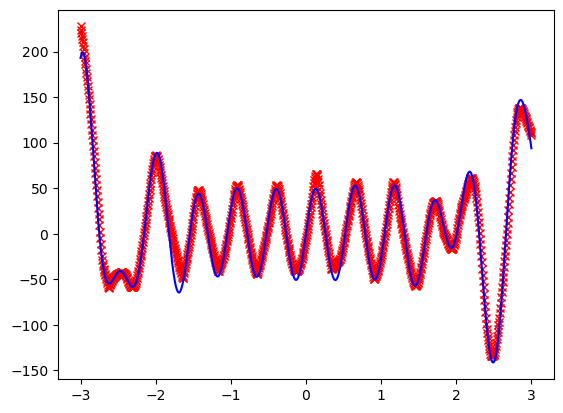

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.21801111464904827
